In [18]:
import matplotlib.pyplot as plt
import tensorflow.keras as k
import numpy as np
from scipy.stats import norm
from scipy.optimize import bisect
from time import time
from sklearn.utils import shuffle

In [31]:

def blackScholesPriceTrue(fwd, strike, mat, vol):
    sqt = vol * np.sqrt(mat)
    d1 = (np.log(fwd / strike) + 0.5 * vol* vol * mat)/sqt
    d2 = d1 - sqt
    n1 = norm.cdf(d1)
    n2 = norm.cdf(d2)
    return n1 - strike/fwd * n2

def blackScholesImliedVol(fwd, strike, mat, price):
    def func(x):        
        return blackScholesPriceTrue(fwd, strike, mat, x) - price
    return bisect(func, 0.00001, 1)

def blackScholesImliedHelper(arr):
    fwd, strike, mat, price = arr
    return blackScholesImliedVol(fwd, strike, mat, price)

def createDatasetIV(size):
    f = np.linspace(0.5, 1.5, size)
    strike = np.linspace(0.5, 1.5, size)
    mat = np.linspace(0.1, 1, size)
    options = np.linspace(0.01, 1, size)
    inputs = np.array(np.meshgrid(f, strike, mat, options)).T.reshape(-1, 4)
    
    vols = list(map(blackScholesImliedHelper, inputs))

    return inputs, vols.flatten()

def createDataset(size):
    f = np.linspace(1,1.5, size)
    strike = np.linspace(0.5,1.5, size)
    mat = np.linspace(0.1,1,size)
    vol = np.linspace(0.01, 0.5, size)
    inputs = np.array(np.meshgrid(f, strike, mat, vol)).T.reshape(-1, 4)
    options = blackScholesPriceTrue(inputs[:, 0],inputs[:, 1], inputs[:, 2], inputs[:, 3])
    vols = inputs[:, [-1]]
    inputs[:, -1] = options 
    return inputs, vols.flatten()

class VolSequence(k.utils.Sequence):

    def __init__(self, dataSetSize, batch_size):
        x, y = createDataset(dataSetSize)
        self.x, self.y = shuffle(x,y, random_state=0)
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size,:]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_x, batch_y= shuffle(batch_x, batch_y, random_state=0)
        return batch_x, batch_y


In [32]:

def add_normalized_layer(h_units, activation='relu'):
    return [
        k.layers.Dense(h_units, use_bias=False),
        k.layers.BatchNormalization(),
        k.layers.Activation(activation)
            ]

def create_model(h_layers, h_units, modelFile = None):
    layers = [k.layers.Dense(units=h_units,  input_dim=4)]
    layers +=[k.layers.Dropout(rate=0.9)]
    for _ in range(h_layers):
        layers += add_normalized_layer(h_units, activation='relu')
    layers += [k.layers.Dense(units=h_units//2, activation='relu')]
    layers += [k.layers.Dense(units=1, activation='linear', use_bias=False)]
    model = k.models.Sequential(layers)
    optimizer = k.optimizers.RMSprop(lr=0.001, clipnorm=5)
    model.compile(optimizer=optimizer, loss='mse')
    if modelFile is not None:
        try:
            model.load_weights(modelFile)
        except:
            pass
    return model

def create_multy_model(h_layers, h_units, modelFile = None, activation='relu'):
    input = k.layers.Input(shape=(4,))
    seq_1 = k.layers.Dense(units=h_units//4,  activation=activation)(input)
    seq_2 = k.layers.Dense(units=h_units//4,  activation=activation)(input)
    seq_3 = k.layers.Dense(units=h_units//4,  activation=activation)(input)
    seq_4 = k.layers.Dense(units=h_units//4,  activation=activation)(input)
    for i in range(h_layers):
        seq_1 = k.layers.Dense(units=h_units//4,  activation=activation)(seq_1)
        seq_2 = k.layers.Dense(units=h_units//4,  activation=activation)(seq_2)
        seq_3 = k.layers.Dense(units=h_units//4,  activation=activation)(seq_3)
        seq_4 = k.layers.Dense(units=h_units//4,  activation=activation)(seq_4)

    connect = k.layers.Concatenate()([seq_1, seq_2, seq_3, seq_4])
    
    reduce = k.layers.Dense(units=h_units//4,  activation=activation)(connect)
    
    final = k.layers.Dense(1)(reduce)
    model = k.models.Model(inputs=[input], outputs=[final])
    optimizer = k.optimizers.RMSprop(lr=0.001, clipnorm=5)
    model.compile(optimizer=optimizer, loss='mse')
    if modelFile is not None:
        try:
            model.load_weights(modelFile)
        except:
            pass
    return model

In [33]:

generator = VolSequence(20,512)
val_generator = VolSequence(5, 5**4)


In [36]:
modelFile = 'bsCalibratorModel.hdf5'
layers = 16
hidden_units = 512
model = create_multy_model(layers, hidden_units, modelFile)

epochs = 100

checkpoint = k.callbacks.ModelCheckpoint(modelFile, monitor='val_loss')
tensorboard = k.callbacks.TensorBoard(log_dir='LOGS\\{}'.format(time()), histogram_freq=10, write_graph=True)
reduce_lr = k.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
model.fit_generator(generator=generator, epochs=epochs, validation_data=val_generator, validation_freq=1, 
                    verbose=1, callbacks=[checkpoint,  reduce_lr])


Epoch 1/100


  1/313 [..............................] - ETA: 1:13:39 - loss: 0.0102

  2/313 [..............................] - ETA: 36:56 - loss: 0.0278  



  3/313 [..............................] - ETA: 24:42 - loss: 0.0247

  4/313 [..............................] - ETA: 18:35 - loss: 0.0240

  5/313 [..............................] - ETA: 14:54 - loss: 0.0223

  6/313 [..............................] - ETA: 12:27 - loss: 0.0209

  7/313 [..............................] - ETA: 10:42 - loss: 0.0196

  8/313 [..............................] - ETA: 9:23 - loss: 0.0187 

  9/313 [..............................] - ETA: 8:22 - loss: 0.0179

 10/313 [..............................] - ETA: 7:33 - loss: 0.0172

 11/313 [>.............................] - ETA: 6:52 - loss: 0.0168

 12/313 [>.............................] - ETA: 6:19 - loss: 0.0164

 13/313 [>.............................] - ETA: 5:51 - loss: 0.0164

 14/313 [>.............................] - ETA: 5:26 - loss: 0.0160

 15/313 [>.............................] - ETA: 5:05 - loss: 0.0155

 16/313 [>.............................] - ETA: 4:47 - loss: 0.0153

 17/313 [>.............................] - ETA: 4:30 - loss: 0.0150

 18/313 [>.............................] - ETA: 4:16 - loss: 0.0151

 19/313 [>.............................] - ETA: 4:03 - loss: 0.0150

 20/313 [>.............................] - ETA: 3:51 - loss: 0.0148

 21/313 [=>............................] - ETA: 3:41 - loss: 0.0147

 22/313 [=>............................] - ETA: 3:31 - loss: 0.0150

 23/313 [=>............................] - ETA: 3:22 - loss: 0.0150

 24/313 [=>............................] - ETA: 3:14 - loss: 0.0149

 25/313 [=>............................] - ETA: 3:07 - loss: 0.0148

 26/313 [=>............................] - ETA: 3:00 - loss: 0.0147

 27/313 [=>............................] - ETA: 2:54 - loss: 0.0146

 28/313 [=>............................] - ETA: 2:48 - loss: 0.0144

 29/313 [=>............................] - ETA: 2:42 - loss: 0.0142

 30/313 [=>............................] - ETA: 2:37 - loss: 0.0141

 31/313 [=>............................] - ETA: 2:32 - loss: 0.0143

 32/313 [==>...........................] - ETA: 2:28 - loss: 0.0141

 33/313 [==>...........................] - ETA: 2:23 - loss: 0.0140

 34/313 [==>...........................] - ETA: 2:19 - loss: 0.0139

 35/313 [==>...........................] - ETA: 2:16 - loss: 0.0138

 36/313 [==>...........................] - ETA: 2:12 - loss: 0.0140

 37/313 [==>...........................] - ETA: 2:09 - loss: 0.0142

 38/313 [==>...........................] - ETA: 2:05 - loss: 0.0142

 39/313 [==>...........................] - ETA: 2:02 - loss: 0.0142

 40/313 [==>...........................] - ETA: 1:59 - loss: 0.0141

 41/313 [==>...........................] - ETA: 1:57 - loss: 0.0140

 42/313 [===>..........................] - ETA: 1:54 - loss: 0.0140

 43/313 [===>..........................] - ETA: 1:51 - loss: 0.0139

 44/313 [===>..........................] - ETA: 1:49 - loss: 0.0138

 45/313 [===>..........................] - ETA: 1:47 - loss: 0.0139

 46/313 [===>..........................] - ETA: 1:44 - loss: 0.0138

 47/313 [===>..........................] - ETA: 1:42 - loss: 0.0137

 48/313 [===>..........................] - ETA: 1:40 - loss: 0.0137

 49/313 [===>..........................] - ETA: 1:38 - loss: 0.0136

 50/313 [===>..........................] - ETA: 1:36 - loss: 0.0136

 51/313 [===>..........................] - ETA: 1:35 - loss: 0.0136

 52/313 [===>..........................] - ETA: 1:33 - loss: 0.0136

 53/313 [====>.........................] - ETA: 1:31 - loss: 0.0136

 54/313 [====>.........................] - ETA: 1:30 - loss: 0.0136

 55/313 [====>.........................] - ETA: 1:28 - loss: 0.0136

 56/313 [====>.........................] - ETA: 1:26 - loss: 0.0135

 57/313 [====>.........................] - ETA: 1:25 - loss: 0.0135

 58/313 [====>.........................] - ETA: 1:24 - loss: 0.0135

 59/313 [====>.........................] - ETA: 1:22 - loss: 0.0135

 60/313 [====>.........................] - ETA: 1:21 - loss: 0.0135

 61/313 [====>.........................] - ETA: 1:20 - loss: 0.0134

 62/313 [====>.........................] - ETA: 1:18 - loss: 0.0134

 63/313 [=====>........................] - ETA: 1:17 - loss: 0.0136

 64/313 [=====>........................] - ETA: 1:16 - loss: 0.0135

 65/313 [=====>........................] - ETA: 1:15 - loss: 0.0135

 66/313 [=====>........................] - ETA: 1:14 - loss: 0.0135

 67/313 [=====>........................] - ETA: 1:13 - loss: 0.0134

 68/313 [=====>........................] - ETA: 1:12 - loss: 0.0134

 69/313 [=====>........................] - ETA: 1:10 - loss: 0.0133

 70/313 [=====>........................] - ETA: 1:09 - loss: 0.0134

 71/313 [=====>........................] - ETA: 1:09 - loss: 0.0134

 72/313 [=====>........................] - ETA: 1:08 - loss: 0.0133

 73/313 [=====>........................] - ETA: 1:07 - loss: 0.0133

 74/313 [======>.......................] - ETA: 1:06 - loss: 0.0133

 75/313 [======>.......................] - ETA: 1:05 - loss: 0.0133

 76/313 [======>.......................] - ETA: 1:04 - loss: 0.0132

 77/313 [======>.......................] - ETA: 1:03 - loss: 0.0132

 78/313 [======>.......................] - ETA: 1:02 - loss: 0.0132

 79/313 [======>.......................] - ETA: 1:02 - loss: 0.0131

 80/313 [======>.......................] - ETA: 1:01 - loss: 0.0132

 81/313 [======>.......................] - ETA: 1:00 - loss: 0.0133

 82/313 [======>.......................] - ETA: 59s - loss: 0.0133 

 83/313 [======>.......................] - ETA: 59s - loss: 0.0133

 84/313 [=======>......................] - ETA: 58s - loss: 0.0132

 85/313 [=======>......................] - ETA: 57s - loss: 0.0132

 86/313 [=======>......................] - ETA: 56s - loss: 0.0132

 87/313 [=======>......................] - ETA: 56s - loss: 0.0132

 88/313 [=======>......................] - ETA: 55s - loss: 0.0131

 89/313 [=======>......................] - ETA: 54s - loss: 0.0132

 90/313 [=======>......................] - ETA: 54s - loss: 0.0133

 91/313 [=======>......................] - ETA: 53s - loss: 0.0133

 92/313 [=======>......................] - ETA: 53s - loss: 0.0132

 93/313 [=======>......................] - ETA: 52s - loss: 0.0132

 94/313 [========>.....................] - ETA: 51s - loss: 0.0132

 95/313 [========>.....................] - ETA: 51s - loss: 0.0131

 96/313 [========>.....................] - ETA: 50s - loss: 0.0131

 97/313 [========>.....................] - ETA: 50s - loss: 0.0131

 98/313 [========>.....................] - ETA: 49s - loss: 0.0131

 99/313 [========>.....................] - ETA: 49s - loss: 0.0132

100/313 [========>.....................] - ETA: 48s - loss: 0.0132

101/313 [========>.....................] - ETA: 47s - loss: 0.0132

102/313 [========>.....................] - ETA: 47s - loss: 0.0131

103/313 [========>.....................] - ETA: 46s - loss: 0.0131

104/313 [========>.....................] - ETA: 46s - loss: 0.0131

105/313 [=========>....................] - ETA: 45s - loss: 0.0131

106/313 [=========>....................] - ETA: 45s - loss: 0.0131

107/313 [=========>....................] - ETA: 44s - loss: 0.0130

108/313 [=========>....................] - ETA: 44s - loss: 0.0130

109/313 [=========>....................] - ETA: 44s - loss: 0.0130

110/313 [=========>....................] - ETA: 43s - loss: 0.0130

111/313 [=========>....................] - ETA: 43s - loss: 0.0130

112/313 [=========>....................] - ETA: 42s - loss: 0.0130

113/313 [=========>....................] - ETA: 42s - loss: 0.0130

114/313 [=========>....................] - ETA: 41s - loss: 0.0129

115/313 [==========>...................] - ETA: 41s - loss: 0.0130

116/313 [==========>...................] - ETA: 41s - loss: 0.0130

117/313 [==========>...................] - ETA: 40s - loss: 0.0130

118/313 [==========>...................] - ETA: 40s - loss: 0.0129

119/313 [==========>...................] - ETA: 39s - loss: 0.0129

120/313 [==========>...................] - ETA: 39s - loss: 0.0129

121/313 [==========>...................] - ETA: 39s - loss: 0.0129

122/313 [==========>...................] - ETA: 38s - loss: 0.0128

123/313 [==========>...................] - ETA: 38s - loss: 0.0128

124/313 [==========>...................] - ETA: 37s - loss: 0.0129

125/313 [==========>...................] - ETA: 37s - loss: 0.0129

126/313 [===========>..................] - ETA: 37s - loss: 0.0129

127/313 [===========>..................] - ETA: 36s - loss: 0.0129

128/313 [===========>..................] - ETA: 36s - loss: 0.0129

129/313 [===========>..................] - ETA: 36s - loss: 0.0129

130/313 [===========>..................] - ETA: 35s - loss: 0.0129

131/313 [===========>..................] - ETA: 35s - loss: 0.0129

132/313 [===========>..................] - ETA: 35s - loss: 0.0129

133/313 [===========>..................] - ETA: 34s - loss: 0.0129

134/313 [===========>..................] - ETA: 34s - loss: 0.0129

135/313 [===========>..................] - ETA: 34s - loss: 0.0129

136/313 [============>.................] - ETA: 33s - loss: 0.0129

137/313 [============>.................] - ETA: 33s - loss: 0.0129

138/313 [============>.................] - ETA: 33s - loss: 0.0129

139/313 [============>.................] - ETA: 32s - loss: 0.0129

140/313 [============>.................] - ETA: 32s - loss: 0.0129

141/313 [============>.................] - ETA: 32s - loss: 0.0129

142/313 [============>.................] - ETA: 31s - loss: 0.0129

143/313 [============>.................] - ETA: 31s - loss: 0.0129

144/313 [============>.................] - ETA: 31s - loss: 0.0128

145/313 [============>.................] - ETA: 30s - loss: 0.0129

146/313 [============>.................] - ETA: 30s - loss: 0.0129

147/313 [=============>................] - ETA: 30s - loss: 0.0129

148/313 [=============>................] - ETA: 30s - loss: 0.0128

149/313 [=============>................] - ETA: 29s - loss: 0.0128

150/313 [=============>................] - ETA: 29s - loss: 0.0128

151/313 [=============>................] - ETA: 29s - loss: 0.0128

152/313 [=============>................] - ETA: 28s - loss: 0.0128

153/313 [=============>................] - ETA: 28s - loss: 0.0128

154/313 [=============>................] - ETA: 28s - loss: 0.0128

155/313 [=============>................] - ETA: 28s - loss: 0.0128

156/313 [=============>................] - ETA: 27s - loss: 0.0128

157/313 [==============>...............] - ETA: 27s - loss: 0.0128

158/313 [==============>...............] - ETA: 27s - loss: 0.0128

159/313 [==============>...............] - ETA: 27s - loss: 0.0128

160/313 [==============>...............] - ETA: 26s - loss: 0.0129

161/313 [==============>...............] - ETA: 26s - loss: 0.0129

162/313 [==============>...............] - ETA: 26s - loss: 0.0129

163/313 [==============>...............] - ETA: 25s - loss: 0.0129



164/313 [==============>...............] - ETA: 25s - loss: 0.0129

165/313 [==============>...............] - ETA: 25s - loss: 0.0129

166/313 [==============>...............] - ETA: 25s - loss: 0.0128

167/313 [===============>..............] - ETA: 24s - loss: 0.0128

168/313 [===============>..............] - ETA: 24s - loss: 0.0128



169/313 [===============>..............] - ETA: 24s - loss: 0.0128

170/313 [===============>..............] - ETA: 24s - loss: 0.0128

171/313 [===============>..............] - ETA: 24s - loss: 0.0128

172/313 [===============>..............] - ETA: 23s - loss: 0.0128

173/313 [===============>..............] - ETA: 23s - loss: 0.0128

174/313 [===============>..............] - ETA: 23s - loss: 0.0128

175/313 [===============>..............] - ETA: 23s - loss: 0.0128

176/313 [===============>..............] - ETA: 22s - loss: 0.0128

177/313 [===============>..............] - ETA: 22s - loss: 0.0128

178/313 [================>.............] - ETA: 22s - loss: 0.0129

179/313 [================>.............] - ETA: 22s - loss: 0.0129

180/313 [================>.............] - ETA: 21s - loss: 0.0129

181/313 [================>.............] - ETA: 21s - loss: 0.0129

182/313 [================>.............] - ETA: 21s - loss: 0.0129

183/313 [================>.............] - ETA: 21s - loss: 0.0129

184/313 [================>.............] - ETA: 21s - loss: 0.0128

185/313 [================>.............] - ETA: 20s - loss: 0.0128

186/313 [================>.............] - ETA: 20s - loss: 0.0128

187/313 [================>.............] - ETA: 20s - loss: 0.0128

188/313 [=================>............] - ETA: 20s - loss: 0.0129

189/313 [=================>............] - ETA: 19s - loss: 0.0129

190/313 [=================>............] - ETA: 19s - loss: 0.0129

191/313 [=================>............] - ETA: 19s - loss: 0.0129

192/313 [=================>............] - ETA: 19s - loss: 0.0128

193/313 [=================>............] - ETA: 19s - loss: 0.0128

194/313 [=================>............] - ETA: 18s - loss: 0.0128

195/313 [=================>............] - ETA: 18s - loss: 0.0128

196/313 [=================>............] - ETA: 18s - loss: 0.0128

197/313 [=================>............] - ETA: 18s - loss: 0.0128

198/313 [=================>............] - ETA: 18s - loss: 0.0128

199/313 [==================>...........] - ETA: 17s - loss: 0.0128

200/313 [==================>...........] - ETA: 17s - loss: 0.0128

201/313 [==================>...........] - ETA: 17s - loss: 0.0128

202/313 [==================>...........] - ETA: 17s - loss: 0.0128

203/313 [==================>...........] - ETA: 17s - loss: 0.0128

204/313 [==================>...........] - ETA: 16s - loss: 0.0128

205/313 [==================>...........] - ETA: 16s - loss: 0.0128

206/313 [==================>...........] - ETA: 16s - loss: 0.0128

207/313 [==================>...........] - ETA: 16s - loss: 0.0128

208/313 [==================>...........] - ETA: 16s - loss: 0.0128

209/313 [===================>..........] - ETA: 16s - loss: 0.0128

210/313 [===================>..........] - ETA: 15s - loss: 0.0128

211/313 [===================>..........] - ETA: 15s - loss: 0.0128

212/313 [===================>..........] - ETA: 15s - loss: 0.0128

213/313 [===================>..........] - ETA: 15s - loss: 0.0128

214/313 [===================>..........] - ETA: 15s - loss: 0.0128

215/313 [===================>..........] - ETA: 14s - loss: 0.0128

216/313 [===================>..........] - ETA: 14s - loss: 0.0128

217/313 [===================>..........] - ETA: 14s - loss: 0.0128

218/313 [===================>..........] - ETA: 14s - loss: 0.0128

219/313 [===================>..........] - ETA: 14s - loss: 0.0128

220/313 [====================>.........] - ETA: 14s - loss: 0.0127

221/313 [====================>.........] - ETA: 13s - loss: 0.0127

222/313 [====================>.........] - ETA: 13s - loss: 0.0128

223/313 [====================>.........] - ETA: 13s - loss: 0.0128

224/313 [====================>.........] - ETA: 13s - loss: 0.0128

225/313 [====================>.........] - ETA: 13s - loss: 0.0128

226/313 [====================>.........] - ETA: 12s - loss: 0.0127

227/313 [====================>.........] - ETA: 12s - loss: 0.0127

228/313 [====================>.........] - ETA: 12s - loss: 0.0127

229/313 [====================>.........] - ETA: 12s - loss: 0.0127

230/313 [=====================>........] - ETA: 12s - loss: 0.0127

231/313 [=====================>........] - ETA: 12s - loss: 0.0127

232/313 [=====================>........] - ETA: 11s - loss: 0.0127

233/313 [=====================>........] - ETA: 11s - loss: 0.0127



234/313 [=====================>........] - ETA: 11s - loss: 0.0127

235/313 [=====================>........] - ETA: 11s - loss: 0.0127

236/313 [=====================>........] - ETA: 11s - loss: 0.0127

237/313 [=====================>........] - ETA: 11s - loss: 0.0127

238/313 [=====================>........] - ETA: 10s - loss: 0.0127

239/313 [=====================>........] - ETA: 10s - loss: 0.0127

240/313 [======================>.......] - ETA: 10s - loss: 0.0127

241/313 [======================>.......] - ETA: 10s - loss: 0.0127

242/313 [======================>.......] - ETA: 10s - loss: 0.0127

243/313 [======================>.......] - ETA: 10s - loss: 0.0127

244/313 [======================>.......] - ETA: 9s - loss: 0.0127 

245/313 [======================>.......] - ETA: 9s - loss: 0.0127

246/313 [======================>.......] - ETA: 9s - loss: 0.0127

247/313 [======================>.......] - ETA: 9s - loss: 0.0127

248/313 [======================>.......] - ETA: 9s - loss: 0.0127

249/313 [======================>.......] - ETA: 9s - loss: 0.0128

250/313 [======================>.......] - ETA: 9s - loss: 0.0128

251/313 [=======================>......] - ETA: 8s - loss: 0.0128

252/313 [=======================>......] - ETA: 8s - loss: 0.0128

253/313 [=======================>......] - ETA: 8s - loss: 0.0128

254/313 [=======================>......] - ETA: 8s - loss: 0.0128

255/313 [=======================>......] - ETA: 8s - loss: 0.0127

256/313 [=======================>......] - ETA: 8s - loss: 0.0127

257/313 [=======================>......] - ETA: 7s - loss: 0.0127

258/313 [=======================>......] - ETA: 7s - loss: 0.0127

259/313 [=======================>......] - ETA: 7s - loss: 0.0127

260/313 [=======================>......] - ETA: 7s - loss: 0.0127

261/313 [========================>.....]

 - ETA: 7s - loss: 0.0127

262/313 [========================>.....] - ETA: 7s - loss: 0.0127

263/313 [========================>.....] - ETA: 7s - loss: 0.0127

264/313 [========================>.....] - ETA: 6s - loss: 0.0127

265/313 [========================>.....] - ETA: 6s - loss: 0.0127

266/313 [========================>.....] - ETA: 6s - loss: 0.0127

267/313 [========================>.....] - ETA: 6s - loss: 0.0127

268/313 [========================>.....] - ETA: 6s - loss: 0.0127

269/313 [========================>.....] - ETA: 6s - loss: 0.0127

270/313 [========================>.....] - ETA: 5s - loss: 0.0127

271/313 [========================>.....] - ETA: 5s - loss: 0.0127

272/313 [=========================>....] - ETA: 5s - loss: 0.0127

273/313 [=========================>....] - ETA: 5s - loss: 0.0127

274/313 [=========================>....] - ETA: 5s - loss: 0.0127

275/313 [=========================>....] - ETA: 5s - loss: 0.0127

276/313 [=========================>....] - ETA: 5s - loss: 0.0127

277/313 [=========================>....] - ETA: 4s - loss: 0.0127

278/313 [=========================>....] - ETA: 4s - loss: 0.0127

279/313 [=========================>....] - ETA: 4s - loss: 0.0127

280/313 [=========================>....] - ETA: 4s - loss: 0.0127

281/313 [=========================>....] - ETA: 4s - loss: 0.0127

282/313 [==========================>...] - ETA: 4s - loss: 0.0127

283/313 [==========================>...] - ETA: 4s - loss: 0.0127

284/313 [==========================>...] - ETA: 3s - loss: 0.0127

285/313 [==========================>...] - ETA: 3s - loss: 0.0127

286/313 [==========================>...] - ETA: 3s - loss: 0.0127

287/313 [==========================>...] - ETA: 3s - loss: 0.0127

288/313 [==========================>...] - ETA: 3s - loss: 0.0127

289/313 [==========================>...] - ETA: 3s - loss: 0.0127

290/313 [==========================>...] - ETA: 3s - loss: 0.0127

291/313 [==========================>...] - ETA: 2s - loss: 0.0127

292/313 [==========================>...] - ETA: 2s - loss: 0.0127

293/313 [===========================>..] - ETA: 2s - loss: 0.0127

294/313 [===========================>..] - ETA: 2s - loss: 0.0127

295/313 [===========================>..] - ETA: 2s - loss: 0.0127

296/313 [===========================>..] - ETA: 2s - loss: 0.0127



297/313 [===========================>..] - ETA: 2s - loss: 0.0127

298/313 [===========================>..] - ETA: 2s - loss: 0.0127

299/313 [===========================>..] - ETA: 1s - loss: 0.0127

300/313 [===========================>..] - ETA: 1s - loss: 0.0127

301/313 [===========================>..] - ETA: 1s - loss: 0.0127

302/313 [===========================>..] - ETA: 1s - loss: 0.0127

303/313 [============================>.] - ETA: 1s - loss: 0.0127

304/313 [============================>.] - ETA: 1s - loss: 0.0127

305/313 [============================>.] - ETA: 1s - loss: 0.0127

306/313 [============================>.] - ETA: 0s - loss: 0.0126

307/313 [============================>.] - ETA: 0s - loss: 0.0127

308/313 [============================>.] - ETA: 0s - loss: 0.0126



309/313 [============================>.] - ETA: 0s - loss: 0.0126

310/313 [============================>.] - ETA: 0s - loss: 0.0126

311/313 [============================>.] - ETA: 0s - loss: 0.0127

312/313 [============================>.] - ETA: 0s - loss: 0.0126

313/313 [==============================] - 89s 285ms/step - loss: 0.0126 - val_loss: 0.0151


Epoch 2/100
  1/313 [..............................] - ETA: 29s - loss: 0.0115

  2/313 [..............................] - ETA: 28s - loss: 0.0113

  3/313 [..............................] - ETA: 28s - loss: 0.0133

  4/313 [..............................] - ETA: 27s - loss: 0.0126

  5/313 [..............................] - ETA: 27s - loss: 0.0121

  6/313 [..............................] - ETA: 27s - loss: 0.0118

  7/313 [..............................] - ETA: 26s - loss: 0.0125

  8/313 [..............................] - ETA: 26s - loss: 0.0143

  9/313 [..............................] - ETA: 26s - loss: 0.0144

 10/313 [..............................] - ETA: 26s - loss: 0.0143

 11/313 [>.............................] - ETA: 26s - loss: 0.0142

 12/313 [>.............................] - ETA: 26s - loss: 0.0140

 13/313 [>.............................] - ETA: 26s - loss: 0.0137

 14/313 [>.............................] - ETA: 26s - loss: 0.0134

 15/313 [>.............................] - ETA: 26s - loss: 0.0132

 16/313 [>.............................] - ETA: 25s - loss: 0.0132

 17/313 [>.............................] - ETA: 25s - loss: 0.0131

 18/313 [>.............................] - ETA: 25s - loss: 0.0130

 19/313 [>.............................] - ETA: 25s - loss: 0.0130

 20/313 [>.............................] - ETA: 25s - loss: 0.0132

 21/313 [=>............................] - ETA: 25s - loss: 0.0131

 22/313 [=>............................] - ETA: 25s - loss: 0.0129

 23/313 [=>............................] - ETA: 25s - loss: 0.0128

 24/313 [=>............................] - ETA: 25s - loss: 0.0128

 25/313 [=>............................] - ETA: 25s - loss: 0.0131

 26/313 [=>............................] - ETA: 24s - loss: 0.0131

 27/313 [=>............................] - ETA: 24s - loss: 0.0131

 28/313 [=>............................] - ETA: 24s - loss: 0.0130

 29/313 [=>............................] - ETA: 24s - loss: 0.0129

 30/313 [=>............................] - ETA: 24s - loss: 0.0128

 31/313 [=>............................] - ETA: 24s - loss: 0.0129

 32/313 [==>...........................] - ETA: 24s - loss: 0.0128

 33/313 [==>...........................] - ETA: 24s - loss: 0.0128

 34/313 [==>...........................] - ETA: 24s - loss: 0.0129

 35/313 [==>...........................] - ETA: 24s - loss: 0.0129

 36/313 [==>...........................] - ETA: 24s - loss: 0.0128

 37/313 [==>...........................] - ETA: 24s - loss: 0.0127

 38/313 [==>...........................] - ETA: 23s - loss: 0.0126

 39/313 [==>...........................] - ETA: 23s - loss: 0.0125

 40/313 [==>...........................] - ETA: 23s - loss: 0.0127

 41/313 [==>...........................] - ETA: 23s - loss: 0.0127

 42/313 [===>..........................] - ETA: 23s - loss: 0.0127

 43/313 [===>..........................] - ETA: 23s - loss: 0.0127

 44/313 [===>..........................] - ETA: 23s - loss: 0.0126

 45/313 [===>..........................] - ETA: 23s - loss: 0.0126

 46/313 [===>..........................] - ETA: 23s - loss: 0.0126

 47/313 [===>..........................] - ETA: 23s - loss: 0.0125

 48/313 [===>..........................] - ETA: 22s - loss: 0.0125

 49/313 [===>..........................] - ETA: 22s - loss: 0.0125

 50/313 [===>..........................] - ETA: 22s - loss: 0.0125

 51/313 [===>..........................] - ETA: 22s - loss: 0.0126

 52/313 [===>..........................] - ETA: 22s - loss: 0.0127

 53/313 [====>.........................] - ETA: 22s - loss: 0.0127

 54/313 [====>.........................] - ETA: 22s - loss: 0.0127

 55/313 [====>.........................] - ETA: 22s - loss: 0.0126

 56/313 [====>.........................] - ETA: 22s - loss: 0.0126

 57/313 [====>.........................] - ETA: 22s - loss: 0.0126

 58/313 [====>.........................] - ETA: 22s - loss: 0.0126

 59/313 [====>.........................] - ETA: 21s - loss: 0.0126

 60/313 [====>.........................] - ETA: 21s - loss: 0.0125

 61/313 [====>.........................] - ETA: 21s - loss: 0.0126

 62/313 [====>.........................] - ETA: 21s - loss: 0.0127

 63/313 [=====>........................] - ETA: 21s - loss: 0.0127

 64/313 [=====>........................] - ETA: 21s - loss: 0.0127

 65/313 [=====>........................] - ETA: 21s - loss: 0.0126

 66/313 [=====>........................] - ETA: 21s - loss: 0.0126

 67/313 [=====>........................] - ETA: 21s - loss: 0.0126

 68/313 [=====>........................] - ETA: 21s - loss: 0.0126

 69/313 [=====>........................] - ETA: 21s - loss: 0.0126

 70/313 [=====>........................] - ETA: 21s - loss: 0.0126

 71/313 [=====>........................] - ETA: 20s - loss: 0.0125

 72/313 [=====>........................] - ETA: 20s - loss: 0.0125

 73/313 [=====>........................] - ETA: 20s - loss: 0.0125

 74/313 [======>.......................] - ETA: 20s - loss: 0.0126

 75/313 [======>.......................] - ETA: 20s - loss: 0.0127

 76/313 [======>.......................] - ETA: 20s - loss: 0.0127

 77/313 [======>.......................] - ETA: 20s - loss: 0.0127

 78/313 [======>.......................] - ETA: 20s - loss: 0.0127

 79/313 [======>.......................] - ETA: 20s - loss: 0.0126

 80/313 [======>.......................] - ETA: 20s - loss: 0.0126

 81/313 [======>.......................] - ETA: 20s - loss: 0.0126

 82/313 [======>.......................] - ETA: 20s - loss: 0.0125

 83/313 [======>.......................] - ETA: 19s - loss: 0.0125

 84/313 [=======>......................] - ETA: 19s - loss: 0.0126

 85/313 [=======>......................] - ETA: 19s - loss: 0.0127

 86/313 [=======>......................] - ETA: 19s - loss: 0.0126

 87/313 [=======>......................] - ETA: 19s - loss: 0.0126

 88/313 [=======>......................] - ETA: 19s - loss: 0.0126

 89/313 [=======>......................] - ETA: 19s - loss: 0.0126

 90/313 [=======>......................] - ETA: 19s - loss: 0.0126

 91/313 [=======>......................] - ETA: 19s - loss: 0.0126

 92/313 [=======>......................] - ETA: 19s - loss: 0.0125

 93/313 [=======>......................] - ETA: 19s - loss: 0.0125

 94/313 [========>.....................] - ETA: 18s - loss: 0.0125

 95/313 [========>.....................] - ETA: 18s - loss: 0.0126

 96/313 [========>.....................] - ETA: 18s - loss: 0.0127

 97/313 [========>.....................] - ETA: 18s - loss: 0.0127

 98/313 [========>.....................] - ETA: 18s - loss: 0.0127

 99/313 [========>.....................] - ETA: 18s - loss: 0.0127

100/313 [========>.....................] - ETA: 18s - loss: 0.0126

101/313 [========>.....................] - ETA: 18s - loss: 0.0126

102/313 [========>.....................] - ETA: 18s - loss: 0.0126

103/313 [========>.....................] - ETA: 18s - loss: 0.0126

104/313 [========>.....................] - ETA: 18s - loss: 0.0126

105/313 [=========>....................] - ETA: 18s - loss: 0.0126

106/313 [=========>....................] - ETA: 17s - loss: 0.0126

107/313 [=========>....................] - ETA: 17s - loss: 0.0126

108/313 [=========>....................] - ETA: 17s - loss: 0.0125

109/313 [=========>....................] - ETA: 17s - loss: 0.0125

110/313 [=========>....................] - ETA: 17s - loss: 0.0126

111/313 [=========>....................] - ETA: 17s - loss: 0.0126

112/313 [=========>....................] - ETA: 17s - loss: 0.0126

113/313 [=========>....................] - ETA: 17s - loss: 0.0126

114/313 [=========>....................] - ETA: 17s - loss: 0.0126

115/313 [==========>...................] - ETA: 17s - loss: 0.0126

116/313 [==========>...................] - ETA: 17s - loss: 0.0126

117/313 [==========>...................] - ETA: 17s - loss: 0.0126

118/313 [==========>...................] - ETA: 16s - loss: 0.0126

119/313 [==========>...................] - ETA: 16s - loss: 0.0126

120/313 [==========>...................] - ETA: 16s - loss: 0.0126

121/313 [==========>...................] - ETA: 16s - loss: 0.0126

122/313 [==========>...................] - ETA: 16s - loss: 0.0126

123/313 [==========>...................] - ETA: 16s - loss: 0.0126

124/313 [==========>...................] - ETA: 16s - loss: 0.0126

125/313 [==========>...................] - ETA: 16s - loss: 0.0126

126/313 [===========>..................] - ETA: 16s - loss: 0.0126

127/313 [===========>..................] - ETA: 16s - loss: 0.0126

128/313 [===========>..................] - ETA: 16s - loss: 0.0126

129/313 [===========>..................] - ETA: 15s - loss: 0.0126

130/313 [===========>..................] - ETA: 15s - loss: 0.0126

131/313 [===========>..................] - ETA: 15s - loss: 0.0126

132/313 [===========>..................] - ETA: 15s - loss: 0.0126

133/313 [===========>..................] - ETA: 15s - loss: 0.0126

134/313 [===========>..................] - ETA: 15s - loss: 0.0126

135/313 [===========>..................] - ETA: 15s - loss: 0.0125

136/313 [============>.................] - ETA: 15s - loss: 0.0125

137/313 [============>.................] - ETA: 15s - loss: 0.0125

138/313 [============>.................] - ETA: 15s - loss: 0.0126

139/313 [============>.................] - ETA: 15s - loss: 0.0126

140/313 [============>.................] - ETA: 15s - loss: 0.0126

141/313 [============>.................] - ETA: 14s - loss: 0.0126

142/313 [============>.................] - ETA: 14s - loss: 0.0126

143/313 [============>.................] - ETA: 14s - loss: 0.0125

144/313 [============>.................] - ETA: 14s - loss: 0.0125

145/313 [============>.................] - ETA: 14s - loss: 0.0125

146/313 [============>.................] - ETA: 14s - loss: 0.0125

147/313 [=============>................] - ETA: 14s - loss: 0.0125

148/313 [=============>................] - ETA: 14s - loss: 0.0125

149/313 [=============>................] - ETA: 14s - loss: 0.0125

150/313 [=============>................] - ETA: 14s - loss: 0.0125

151/313 [=============>................] - ETA: 14s - loss: 0.0125

152/313 [=============>................] - ETA: 13s - loss: 0.0125

153/313 [=============>................] - ETA: 13s - loss: 0.0125

154/313 [=============>................] - ETA: 13s - loss: 0.0125

155/313 [=============>................] - ETA: 13s - loss: 0.0125

156/313 [=============>................] - ETA: 13s - loss: 0.0125

157/313 [==============>...............] - ETA: 13s - loss: 0.0125

158/313 [==============>...............] - ETA: 13s - loss: 0.0125

159/313 [==============>...............] - ETA: 13s - loss: 0.0125

160/313 [==============>...............] - ETA: 13s - loss: 0.0125

161/313 [==============>...............] - ETA: 13s - loss: 0.0125

162/313 [==============>...............] - ETA: 13s - loss: 0.0125

163/313 [==============>...............] - ETA: 13s - loss: 0.0125

164/313 [==============>...............] - ETA: 12s - loss: 0.0125

165/313 [==============>...............] - ETA: 12s - loss: 0.0125

166/313 [==============>...............] - ETA: 12s - loss: 0.0125

167/313 [===============>..............] - ETA: 12s - loss: 0.0125

168/313 [===============>..............] - ETA: 12s - loss: 0.0125

169/313 [===============>..............] - ETA: 12s - loss: 0.0125

170/313 [===============>..............] - ETA: 12s - loss: 0.0125

171/313 [===============>..............] - ETA: 12s - loss: 0.0125

172/313 [===============>..............] - ETA: 12s - loss: 0.0125

173/313 [===============>..............] - ETA: 12s - loss: 0.0125

174/313 [===============>..............] - ETA: 12s - loss: 0.0125

175/313 [===============>..............] - ETA: 11s - loss: 0.0125

176/313 [===============>..............] - ETA: 11s - loss: 0.0125

177/313 [===============>..............] - ETA: 11s - loss: 0.0125

178/313 [================>.............] - ETA: 11s - loss: 0.0125

179/313 [================>.............] - ETA: 11s - loss: 0.0125



180/313 [================>.............] - ETA: 11s - loss: 0.0125



181/313 [================>.............] - ETA: 11s - loss: 0.0125

182/313 [================>.............] - ETA: 11s - loss: 0.0125

183/313 [================>.............] - ETA: 11s - loss: 0.0125

184/313 [================>.............] - ETA: 11s - loss: 0.0125

185/313 [================>.............] - ETA: 11s - loss: 0.0125

186/313 [================>.............] - ETA: 11s - loss: 0.0125

187/313 [================>.............] - ETA: 10s - loss: 0.0125

188/313 [=================>............] - ETA: 10s - loss: 0.0124

189/313 [=================>............] - ETA: 10s - loss: 0.0125

190/313 [=================>............] - ETA: 10s - loss: 0.0125

191/313 [=================>............] - ETA: 10s - loss: 0.0125

192/313 [=================>............] - ETA: 10s - loss: 0.0125

193/313 [=================>............] - ETA: 10s - loss: 0.0125

194/313 [=================>............] - ETA: 10s - loss: 0.0125

195/313 [=================>............] - ETA: 10s - loss: 0.0124

196/313 [=================>............] - ETA: 10s - loss: 0.0124

197/313 [=================>............] - ETA: 10s - loss: 0.0125

198/313 [=================>............] - ETA: 9s - loss: 0.0125 

199/313 [==================>...........] - ETA: 9s - loss: 0.0125

200/313 [==================>...........] - ETA: 9s - loss: 0.0125

201/313 [==================>...........] - ETA: 9s - loss: 0.0125

202/313 [==================>...........] - ETA: 9s - loss: 0.0125

203/313 [==================>...........] - ETA: 9s - loss: 0.0125

204/313 [==================>...........] - ETA: 9s - loss: 0.0125

205/313 [==================>...........] - ETA: 9s - loss: 0.0125

206/313 [==================>...........] - ETA: 9s - loss: 0.0125

207/313 [==================>...........] - ETA: 9s - loss: 0.0125

208/313 [==================>...........] - ETA: 9s - loss: 0.0125

209/313 [===================>..........] - ETA: 9s - loss: 0.0125

210/313 [===================>..........] - ETA: 8s - loss: 0.0125

211/313 [===================>..........] - ETA: 8s - loss: 0.0124

212/313 [===================>..........] - ETA: 8s - loss: 0.0124

213/313 [===================>..........] - ETA: 8s - loss: 0.0124

214/313 [===================>..........] - ETA: 8s - loss: 0.0125

215/313 [===================>..........] - ETA: 8s - loss: 0.0124

216/313 [===================>..........] - ETA: 8s - loss: 0.0124

217/313 [===================>..........] - ETA: 8s - loss: 0.0124

218/313 [===================>..........] - ETA: 8s - loss: 0.0124

219/313 [===================>..........] - ETA: 8s - loss: 0.0124

220/313 [====================>.........] - ETA: 8s - loss: 0.0124

221/313 [====================>.........] - ETA: 7s - loss: 0.0124

222/313 [====================>.........] - ETA: 7s - loss: 0.0124

223/313 [====================>.........] - ETA: 7s - loss: 0.0124

224/313 [====================>.........] - ETA: 7s - loss: 0.0124

225/313 [====================>.........] - ETA: 7s - loss: 0.0124

226/313 [====================>.........] - ETA: 7s - loss: 0.0124

227/313 [====================>.........] - ETA: 7s - loss: 0.0124

228/313 [====================>.........] - ETA: 7s - loss: 0.0124

229/313 [====================>.........] - ETA: 7s - loss: 0.0124

230/313 [=====================>........] - ETA: 7s - loss: 0.0124

231/313 [=====================>........] - ETA: 7s - loss: 0.0124

232/313 [=====================>........] - ETA: 7s - loss: 0.0124

233/313 [=====================>........] - ETA: 6s - loss: 0.0124

234/313 [=====================>........] - ETA: 6s - loss: 0.0124

235/313 [=====================>........] - ETA: 6s - loss: 0.0124

236/313 [=====================>........] - ETA: 6s - loss: 0.0124

237/313 [=====================>........] - ETA: 6s - loss: 0.0124

238/313 [=====================>........] - ETA: 6s - loss: 0.0124

239/313 [=====================>........] - ETA: 6s - loss: 0.0124

240/313 [======================>.......] - ETA: 6s - loss: 0.0124

241/313 [======================>.......] - ETA: 6s - loss: 0.0124

242/313 [======================>.......] - ETA: 6s - loss: 0.0124

243/313 [======================>.......] - ETA: 6s - loss: 0.0124

244/313 [======================>.......] - ETA: 5s - loss: 0.0124

245/313 [======================>.......] - ETA: 5s - loss: 0.0124

246/313 [======================>.......] - ETA: 5s - loss: 0.0124

247/313 [======================>.......] - ETA: 5s - loss: 0.0124

248/313 [======================>.......] - ETA: 5s - loss: 0.0124

249/313 [======================>.......] - ETA: 5s - loss: 0.0124

250/313 [======================>.......] - ETA: 5s - loss: 0.0124

251/313 [=======================>......] - ETA: 5s - loss: 0.0124

252/313 [=======================>......] - ETA: 5s - loss: 0.0124

253/313 [=======================>......] - ETA: 5s - loss: 0.0124

254/313 [=======================>......] - ETA: 5s - loss: 0.0124

255/313 [=======================>......] - ETA: 5s - loss: 0.0124

256/313 [=======================>......] - ETA: 4s - loss: 0.0124

257/313 [=======================>......] - ETA: 4s - loss: 0.0124

258/313 [=======================>......] - ETA: 4s - loss: 0.0124

259/313 [=======================>......] - ETA: 4s - loss: 0.0124

260/313 [=======================>......] - ETA: 4s - loss: 0.0124

261/313 [========================>.....] - ETA: 4s - loss: 0.0124

262/313 [========================>.....] - ETA: 4s - loss: 0.0124

263/313 [========================>.....] - ETA: 4s - loss: 0.0124

264/313 [========================>.....] - ETA: 4s - loss: 0.0124

265/313 [========================>.....] - ETA: 4s - loss: 0.0124

266/313 [========================>.....] - ETA: 4s - loss: 0.0124

267/313 [========================>.....] - ETA: 3s - loss: 0.0124

268/313 [========================>.....] - ETA: 3s - loss: 0.0124

269/313 [========================>.....] - ETA: 3s - loss: 0.0124

270/313 [========================>.....] - ETA: 3s - loss: 0.0124

271/313 [========================>.....] - ETA: 3s - loss: 0.0124



272/313 [=========================>....] - ETA: 3s - loss: 0.0124

273/313 [=========================>....] - ETA: 3s - loss: 0.0124

274/313 [=========================>....] - ETA: 3s - loss: 0.0124

275/313 [=========================>....] - ETA: 3s - loss: 0.0124

276/313 [=========================>....] - ETA: 3s - loss: 0.0124

277/313 [=========================>....] - ETA: 3s - loss: 0.0124

278/313 [=========================>....] - ETA: 3s - loss: 0.0124

279/313 [=========================>....] - ETA: 2s - loss: 0.0124

280/313 [=========================>....] - ETA: 2s - loss: 0.0124

281/313 [=========================>....] - ETA: 2s - loss: 0.0123

282/313 [==========================>...] - ETA: 2s - loss: 0.0124

283/313 [==========================>...] - ETA: 2s - loss: 0.0124

284/313 [==========================>...] - ETA: 2s - loss: 0.0124

285/313 [==========================>...] - ETA: 2s - loss: 0.0124

286/313 [==========================>...] - ETA: 2s - loss: 0.0124

287/313 [==========================>...] - ETA: 2s - loss: 0.0124

288/313 [==========================>...] - ETA: 2s - loss: 0.0124

289/313 [==========================>...] - ETA: 2s - loss: 0.0124

290/313 [==========================>...] - ETA: 1s - loss: 0.0124

291/313 [==========================>...] - ETA: 1s - loss: 0.0124

292/313 [==========================>...] - ETA: 1s - loss: 0.0124

293/313 [===========================>..] - ETA: 1s - loss: 0.0124

294/313 [===========================>..] - ETA: 1s - loss: 0.0124

295/313 [===========================>..] - ETA: 1s - loss: 0.0124

296/313 [===========================>..] - ETA: 1s - loss: 0.0124

297/313 [===========================>..] - ETA: 1s - loss: 0.0124

298/313 [===========================>..] - ETA: 1s - loss: 0.0124

299/313 [===========================>..] - ETA: 1s - loss: 0.0124

300/313 [===========================>..] - ETA: 1s - loss: 0.0124

301/313 [===========================>..] - ETA: 1s - loss: 0.0124

302/313 [===========================>..] - ETA: 0s - loss: 0.0124

303/313 [============================>.] - ETA: 0s - loss: 0.0124

304/313 [============================>.] - ETA: 0s - loss: 0.0124

305/313 [============================>.] - ETA: 0s - loss: 0.0124

306/313 [============================>.] - ETA: 0s - loss: 0.0124

307/313 [============================>.] - ETA: 0s - loss: 0.0124

308/313 [============================>.] - ETA: 0s - loss: 0.0124

309/313 [============================>.] - ETA: 0s - loss: 0.0124

310/313 [============================>.] - ETA: 0s - loss: 0.0124

311/313 [============================>.] - ETA: 0s - loss: 0.0124

312/313 [============================>.] - ETA: 0s - loss: 0.0124

313/313 [==============================] - 28s 91ms/step - loss: 0.0124 - val_loss: 0.0168


Epoch 3/100
  1/313 [..............................] - ETA: 26s - loss: 0.0112

  2/313 [..............................] - ETA: 26s - loss: 0.0111

  3/313 [..............................] - ETA: 27s - loss: 0.0110

  4/313 [..............................] - ETA: 26s - loss: 0.0108

  5/313 [..............................] - ETA: 26s - loss: 0.0109

  6/313 [..............................] - ETA: 26s - loss: 0.0113

  7/313 [..............................] - ETA: 26s - loss: 0.0125

  8/313 [..............................] - ETA: 26s - loss: 0.0124

  9/313 [..............................] - ETA: 26s - loss: 0.0123

 10/313 [..............................] - ETA: 26s - loss: 0.0121

 11/313 [>.............................] - ETA: 26s - loss: 0.0119

 12/313 [>.............................] - ETA: 26s - loss: 0.0120

 13/313 [>.............................] - ETA: 26s - loss: 0.0118

 14/313 [>.............................] - ETA: 26s - loss: 0.0117

 15/313 [>.............................] - ETA: 25s - loss: 0.0120

 16/313 [>.............................] - ETA: 25s - loss: 0.0125

 17/313 [>.............................] - ETA: 25s - loss: 0.0126

 18/313 [>.............................] - ETA: 25s - loss: 0.0126

 19/313 [>.............................] - ETA: 25s - loss: 0.0124

 20/313 [>.............................] - ETA: 25s - loss: 0.0123

 21/313 [=>............................] - ETA: 25s - loss: 0.0122

 22/313 [=>............................] - ETA: 25s - loss: 0.0121

 23/313 [=>............................] - ETA: 25s - loss: 0.0122

 24/313 [=>............................] - ETA: 25s - loss: 0.0126

 25/313 [=>............................] - ETA: 25s - loss: 0.0126

 26/313 [=>............................] - ETA: 24s - loss: 0.0126

 27/313 [=>............................] - ETA: 24s - loss: 0.0125

 28/313 [=>............................] - ETA: 24s - loss: 0.0125

 29/313 [=>............................] - ETA: 24s - loss: 0.0123

 30/313 [=>............................] - ETA: 24s - loss: 0.0122

 31/313 [=>............................] - ETA: 24s - loss: 0.0122

 32/313 [==>...........................] - ETA: 24s - loss: 0.0121

 33/313 [==>...........................] - ETA: 24s - loss: 0.0121

 34/313 [==>...........................] - ETA: 24s - loss: 0.0121

 35/313 [==>...........................] - ETA: 24s - loss: 0.0123

 36/313 [==>...........................] - ETA: 24s - loss: 0.0123

 37/313 [==>...........................] - ETA: 24s - loss: 0.0122

 38/313 [==>...........................] - ETA: 23s - loss: 0.0122

 39/313 [==>...........................] - ETA: 23s - loss: 0.0121

 40/313 [==>...........................] - ETA: 23s - loss: 0.0121

 41/313 [==>...........................] - ETA: 23s - loss: 0.0122

 42/313 [===>..........................] - ETA: 23s - loss: 0.0124

 43/313 [===>..........................] - ETA: 23s - loss: 0.0125



 44/313 [===>..........................] - ETA: 23s - loss: 0.0125

 45/313 [===>..........................] - ETA: 23s - loss: 0.0125

 46/313 [===>..........................] - ETA: 23s - loss: 0.0124

 47/313 [===>..........................] - ETA: 23s - loss: 0.0124

 48/313 [===>..........................] - ETA: 23s - loss: 0.0123

 49/313 [===>..........................] - ETA: 22s - loss: 0.0123

 50/313 [===>..........................] - ETA: 22s - loss: 0.0123

 51/313 [===>..........................] - ETA: 22s - loss: 0.0122

 52/313 [===>..........................] - ETA: 22s - loss: 0.0124

 53/313 [====>.........................] - ETA: 22s - loss: 0.0125

 54/313 [====>.........................] - ETA: 22s - loss: 0.0125

 55/313 [====>.........................] - ETA: 22s - loss: 0.0125

 56/313 [====>.........................] - ETA: 22s - loss: 0.0124

 57/313 [====>.........................] - ETA: 22s - loss: 0.0124

 58/313 [====>.........................] - ETA: 22s - loss: 0.0124

 59/313 [====>.........................] - ETA: 22s - loss: 0.0123

 60/313 [====>.........................] - ETA: 22s - loss: 0.0123

 61/313 [====>.........................] - ETA: 21s - loss: 0.0123

 62/313 [====>.........................] - ETA: 21s - loss: 0.0123

 63/313 [=====>........................] - ETA: 21s - loss: 0.0123

 64/313 [=====>........................] - ETA: 21s - loss: 0.0123

 65/313 [=====>........................] - ETA: 21s - loss: 0.0123

 66/313 [=====>........................] - ETA: 21s - loss: 0.0123

 67/313 [=====>........................] - ETA: 21s - loss: 0.0124

 68/313 [=====>........................] - ETA: 21s - loss: 0.0124

 69/313 [=====>........................]

 - ETA: 21s - loss: 0.0124

 70/313 [=====>........................] - ETA: 21s - loss: 0.0123

 71/313 [=====>........................] - ETA: 21s - loss: 0.0123

 72/313 [=====>........................] - ETA: 20s - loss: 0.0123

 73/313 [=====>........................] - ETA: 20s - loss: 0.0123

 74/313 [======>.......................] - ETA: 20s - loss: 0.0124

 75/313 [======>.......................] - ETA: 20s - loss: 0.0124

 76/313 [======>.......................] - ETA: 20s - loss: 0.0123

 77/313 [======>.......................] - ETA: 20s - loss: 0.0123

 78/313 [======>.......................] - ETA: 20s - loss: 0.0123

 79/313 [======>.......................] - ETA: 20s - loss: 0.0123

 80/313 [======>.......................] - ETA: 20s - loss: 0.0122

 81/313 [======>.......................] - ETA: 20s - loss: 0.0122

 82/313 [======>.......................] - ETA: 20s - loss: 0.0122

 83/313 [======>.......................] - ETA: 20s - loss: 0.0122

 84/313 [=======>......................] - ETA: 19s - loss: 0.0122

 85/313 [=======>......................] - ETA: 19s - loss: 0.0122

 86/313 [=======>......................] - ETA: 19s - loss: 0.0123

 87/313 [=======>......................] - ETA: 19s - loss: 0.0123

 88/313 [=======>......................] - ETA: 19s - loss: 0.0123

 89/313 [=======>......................] - ETA: 19s - loss: 0.0123

 90/313 [=======>......................] - ETA: 19s - loss: 0.0123

 91/313 [=======>......................] - ETA: 19s - loss: 0.0123

 92/313 [=======>......................] - ETA: 19s - loss: 0.0122

 93/313 [=======>......................] - ETA: 19s - loss: 0.0122

 94/313 [========>.....................] - ETA: 19s - loss: 0.0123

 95/313 [========>.....................] - ETA: 18s - loss: 0.0123

 96/313 [========>.....................] - ETA: 18s - loss: 0.0123

 97/313 [========>.....................] - ETA: 18s - loss: 0.0122

 98/313 [========>.....................] - ETA: 18s - loss: 0.0122

 99/313 [========>.....................] - ETA: 18s - loss: 0.0122

100/313 [========>.....................] - ETA: 18s - loss: 0.0122

101/313 [========>.....................] - ETA: 18s - loss: 0.0123

102/313 [========>.....................] - ETA: 18s - loss: 0.0123

103/313 [========>.....................] - ETA: 18s - loss: 0.0123

104/313 [========>.....................] - ETA: 18s - loss: 0.0122

105/313 [=========>....................] - ETA: 18s - loss: 0.0122

106/313 [=========>....................] - ETA: 18s - loss: 0.0123

107/313 [=========>....................] - ETA: 17s - loss: 0.0123

108/313 [=========>....................] - ETA: 17s - loss: 0.0122

109/313 [=========>....................] - ETA: 17s - loss: 0.0122

110/313 [=========>....................] - ETA: 17s - loss: 0.0122

111/313 [=========>....................] - ETA: 17s - loss: 0.0122

112/313 [=========>....................] - ETA: 17s - loss: 0.0122

113/313 [=========>....................] - ETA: 17s - loss: 0.0122

114/313 [=========>....................] - ETA: 17s - loss: 0.0122

115/313 [==========>...................] - ETA: 17s - loss: 0.0123

116/313 [==========>...................] - ETA: 17s - loss: 0.0123

117/313 [==========>...................] - ETA: 17s - loss: 0.0123

118/313 [==========>...................] - ETA: 16s - loss: 0.0123

119/313 [==========>...................] - ETA: 16s - loss: 0.0123

120/313 [==========>...................] - ETA: 16s - loss: 0.0123

121/313 [==========>...................] - ETA: 16s - loss: 0.0123

122/313 [==========>...................] - ETA: 16s - loss: 0.0123

123/313 [==========>...................] - ETA: 16s - loss: 0.0123

124/313 [==========>...................] - ETA: 16s - loss: 0.0122

125/313 [==========>...................] - ETA: 16s - loss: 0.0122

126/313 [===========>..................] - ETA: 16s - loss: 0.0122

127/313 [===========>..................] - ETA: 16s - loss: 0.0122

128/313 [===========>..................] - ETA: 16s - loss: 0.0123



129/313 [===========>..................] - ETA: 16s - loss: 0.0123

130/313 [===========>..................] - ETA: 15s - loss: 0.0123

131/313 [===========>..................] - ETA: 15s - loss: 0.0123

132/313 [===========>..................] - ETA: 15s - loss: 0.0123

133/313 [===========>..................] - ETA: 15s - loss: 0.0122

134/313 [===========>..................] - ETA: 15s - loss: 0.0122

135/313 [===========>..................] - ETA: 15s - loss: 0.0123

136/313 [============>.................] - ETA: 15s - loss: 0.0123

137/313 [============>.................] - ETA: 15s - loss: 0.0123

138/313 [============>.................] - ETA: 15s - loss: 0.0123

139/313 [============>.................] - ETA: 15s - loss: 0.0123

140/313 [============>.................] - ETA: 15s - loss: 0.0123

141/313 [============>.................] - ETA: 14s - loss: 0.0122

142/313 [============>.................] - ETA: 14s - loss: 0.0123

143/313 [============>.................] - ETA: 14s - loss: 0.0123

144/313 [============>.................] - ETA: 14s - loss: 0.0122

145/313 [============>.................] - ETA: 14s - loss: 0.0122

146/313 [============>.................] - ETA: 14s - loss: 0.0123

147/313 [=============>................] - ETA: 14s - loss: 0.0123

148/313 [=============>................] - ETA: 14s - loss: 0.0123



149/313 [=============>................] - ETA: 14s - loss: 0.0122

150/313 [=============>................] - ETA: 14s - loss: 0.0122

151/313 [=============>................] - ETA: 14s - loss: 0.0123

152/313 [=============>................] - ETA: 14s - loss: 0.0122

153/313 [=============>................] - ETA: 13s - loss: 0.0122

154/313 [=============>................] - ETA: 13s - loss: 0.0122

155/313 [=============>................] - ETA: 13s - loss: 0.0122

156/313 [=============>................] - ETA: 13s - loss: 0.0122

157/313 [==============>...............] - ETA: 13s - loss: 0.0122

158/313 [==============>...............] - ETA: 13s - loss: 0.0122

159/313 [==============>...............] - ETA: 13s - loss: 0.0122

160/313 [==============>...............] - ETA: 13s - loss: 0.0123

161/313 [==============>...............] - ETA: 13s - loss: 0.0123

162/313 [==============>...............] - ETA: 13s - loss: 0.0123

163/313 [==============>...............] - ETA: 13s - loss: 0.0123

164/313 [==============>...............] - ETA: 12s - loss: 0.0123

165/313 [==============>...............] - ETA: 12s - loss: 0.0122

166/313 [==============>...............] - ETA: 12s - loss: 0.0123

167/313 [===============>..............] - ETA: 12s - loss: 0.0123

168/313 [===============>..............] - ETA: 12s - loss: 0.0122

169/313 [===============>..............] - ETA: 12s - loss: 0.0122

170/313 [===============>..............] - ETA: 12s - loss: 0.0122

171/313 [===============>..............] - ETA: 12s - loss: 0.0122

172/313 [===============>..............] - ETA: 12s - loss: 0.0122

173/313 [===============>..............] - ETA: 12s - loss: 0.0122

174/313 [===============>..............] - ETA: 12s - loss: 0.0122

175/313 [===============>..............] - ETA: 12s - loss: 0.0122

176/313 [===============>..............] - ETA: 11s - loss: 0.0122

177/313 [===============>..............] - ETA: 11s - loss: 0.0122

178/313 [================>.............] - ETA: 11s - loss: 0.0122

179/313 [================>.............] - ETA: 11s - loss: 0.0122

180/313 [================>.............] - ETA: 11s - loss: 0.0122

181/313 [================>.............] - ETA: 11s - loss: 0.0122

182/313 [================>.............] - ETA: 11s - loss: 0.0122

183/313 [================>.............] - ETA: 11s - loss: 0.0122

184/313 [================>.............] - ETA: 11s - loss: 0.0122

185/313 [================>.............] - ETA: 11s - loss: 0.0122

186/313 [================>.............] - ETA: 11s - loss: 0.0123

187/313 [================>.............] - ETA: 10s - loss: 0.0122

188/313 [=================>............] - ETA: 10s - loss: 0.0122

189/313 [=================>............] - ETA: 10s - loss: 0.0122

190/313 [=================>............] - ETA: 10s - loss: 0.0122

191/313 [=================>............] - ETA: 10s - loss: 0.0122

192/313 [=================>............] - ETA: 10s - loss: 0.0123

193/313 [=================>............] - ETA: 10s - loss: 0.0122

194/313 [=================>............] - ETA: 10s - loss: 0.0122

195/313 [=================>............] - ETA: 10s - loss: 0.0122

196/313 [=================>............] - ETA: 10s - loss: 0.0122

197/313 [=================>............] - ETA: 10s - loss: 0.0122

198/313 [=================>............] - ETA: 10s - loss: 0.0122

199/313 [==================>...........] - ETA: 9s - loss: 0.0122 

200/313 [==================>...........] - ETA: 9s - loss: 0.0122

201/313 [==================>...........] - ETA: 9s - loss: 0.0122

202/313 [==================>...........] - ETA: 9s - loss: 0.0122

203/313 [==================>...........] - ETA: 9s - loss: 0.0122

204/313 [==================>...........] - ETA: 9s - loss: 0.0122

205/313 [==================>...........] - ETA: 9s - loss: 0.0122

206/313 [==================>...........] - ETA: 9s - loss: 0.0122

207/313 [==================>...........] - ETA: 9s - loss: 0.0122

208/313 [==================>...........] - ETA: 9s - loss: 0.0122

209/313 [===================>..........] - ETA: 9s - loss: 0.0122

210/313 [===================>..........]

 - ETA: 8s - loss: 0.0122

211/313 [===================>..........] - ETA: 8s - loss: 0.0122

212/313 [===================>..........] - ETA: 8s - loss: 0.0122

213/313 [===================>..........] - ETA: 8s - loss: 0.0122

214/313 [===================>..........] - ETA: 8s - loss: 0.0122



215/313 [===================>..........] - ETA: 8s - loss: 0.0122

216/313 [===================>..........] - ETA: 8s - loss: 0.0122

217/313 [===================>..........] - ETA: 8s - loss: 0.0122

218/313 [===================>..........] - ETA: 8s - loss: 0.0122

219/313 [===================>..........] - ETA: 8s - loss: 0.0122

220/313 [====================>.........] - ETA: 8s - loss: 0.0122



221/313 [====================>.........] - ETA: 8s - loss: 0.0122

222/313 [====================>.........] - ETA: 7s - loss: 0.0122

223/313 [====================>.........] - ETA: 7s - loss: 0.0122

224/313 [====================>.........] - ETA: 7s - loss: 0.0122

225/313 [====================>.........] - ETA: 7s - loss: 0.0122

226/313 [====================>.........] - ETA: 7s - loss: 0.0122

227/313 [====================>.........] - ETA: 7s - loss: 0.0122

228/313 [====================>.........] - ETA: 7s - loss: 0.0122

229/313 [====================>.........] - ETA: 7s - loss: 0.0122

230/313 [=====================>........] - ETA: 7s - loss: 0.0122

231/313 [=====================>........] - ETA: 7s - loss: 0.0122

232/313 [=====================>........] - ETA: 7s - loss: 0.0122

233/313 [=====================>........] - ETA: 6s - loss: 0.0122

234/313 [=====================>........] - ETA: 6s - loss: 0.0122

235/313 [=====================>........] - ETA: 6s - loss: 0.0122

236/313 [=====================>........] - ETA: 6s - loss: 0.0122

237/313 [=====================>........] - ETA: 6s - loss: 0.0122

238/313 [=====================>........] - ETA: 6s - loss: 0.0122

239/313 [=====================>........] - ETA: 6s - loss: 0.0122

240/313 [======================>.......] - ETA: 6s - loss: 0.0122

241/313 [======================>.......] - ETA: 6s - loss: 0.0122

242/313 [======================>.......] - ETA: 6s - loss: 0.0122

243/313 [======================>.......] - ETA: 6s - loss: 0.0122

244/313 [======================>.......] - ETA: 6s - loss: 0.0122

245/313 [======================>.......] - ETA: 5s - loss: 0.0122

246/313 [======================>.......] - ETA: 5s - loss: 0.0122

247/313 [======================>.......] - ETA: 5s - loss: 0.0122

248/313 [======================>.......] - ETA: 5s - loss: 0.0122

249/313 [======================>.......] - ETA: 5s - loss: 0.0122

250/313 [======================>.......] - ETA: 5s - loss: 0.0122

251/313 [=======================>......] - ETA: 5s - loss: 0.0122

252/313 [=======================>......] - ETA: 5s - loss: 0.0122

253/313 [=======================>......] - ETA: 5s - loss: 0.0122

254/313 [=======================>......] - ETA: 5s - loss: 0.0122

255/313 [=======================>......] - ETA: 5s - loss: 0.0122

256/313 [=======================>......] - ETA: 4s - loss: 0.0122

257/313 [=======================>......] - ETA: 4s - loss: 0.0122

258/313 [=======================>......] - ETA: 4s - loss: 0.0122

259/313 [=======================>......] - ETA: 4s - loss: 0.0122

260/313 [=======================>......] - ETA: 4s - loss: 0.0122

261/313 [========================>.....] - ETA: 4s - loss: 0.0122

262/313 [========================>.....] - ETA: 4s - loss: 0.0122

263/313 [========================>.....] - ETA: 4s - loss: 0.0122

264/313 [========================>.....] - ETA: 4s - loss: 0.0122

265/313 [========================>.....] - ETA: 4s - loss: 0.0122

266/313 [========================>.....] - ETA: 4s - loss: 0.0122

267/313 [========================>.....] - ETA: 3s - loss: 0.0122

268/313 [========================>.....] - ETA: 3s - loss: 0.0122

269/313 [========================>.....] - ETA: 3s - loss: 0.0122

270/313 [========================>.....] - ETA: 3s - loss: 0.0122

271/313 [========================>.....] - ETA: 3s - loss: 0.0122

272/313 [=========================>....] - ETA: 3s - loss: 0.0122

273/313 [=========================>....] - ETA: 3s - loss: 0.0122

274/313 [=========================>....] - ETA: 3s - loss: 0.0122

275/313 [=========================>....] - ETA: 3s - loss: 0.0122

276/313 [=========================>....] - ETA: 3s - loss: 0.0122

277/313 [=========================>....] - ETA: 3s - loss: 0.0122

278/313 [=========================>....] - ETA: 3s - loss: 0.0122

279/313 [=========================>....] - ETA: 2s - loss: 0.0122

280/313 [=========================>....] - ETA: 2s - loss: 0.0122

281/313 [=========================>....] - ETA: 2s - loss: 0.0122

282/313 [==========================>...] - ETA: 2s - loss: 0.0122

283/313 [==========================>...] - ETA: 2s - loss: 0.0122

284/313 [==========================>...] - ETA: 2s - loss: 0.0122

285/313 [==========================>...] - ETA: 2s - loss: 0.0122

286/313 [==========================>...] - ETA: 2s - loss: 0.0122

287/313 [==========================>...] - ETA: 2s - loss: 0.0122

288/313 [==========================>...] - ETA: 2s - loss: 0.0122

289/313 [==========================>...] - ETA: 2s - loss: 0.0122

290/313 [==========================>...] - ETA: 1s - loss: 0.0122

291/313 [==========================>...] - ETA: 1s - loss: 0.0122

292/313 [==========================>...] - ETA: 1s - loss: 0.0122

293/313 [===========================>..] - ETA: 1s - loss: 0.0122

294/313 [===========================>..] - ETA: 1s - loss: 0.0122

295/313 [===========================>..] - ETA: 1s - loss: 0.0122

296/313 [===========================>..] - ETA: 1s - loss: 0.0122

297/313 [===========================>..] - ETA: 1s - loss: 0.0122

298/313 [===========================>..] - ETA: 1s - loss: 0.0122

299/313 [===========================>..] - ETA: 1s - loss: 0.0122

300/313 [===========================>..] - ETA: 1s - loss: 0.0122

301/313 [===========================>..] - ETA: 1s - loss: 0.0122

302/313 [===========================>..] - ETA: 0s - loss: 0.0122

303/313 [============================>.] - ETA: 0s - loss: 0.0122

304/313 [============================>.] - ETA: 0s - loss: 0.0122

305/313 [============================>.] - ETA: 0s - loss: 0.0122

306/313 [============================>.] - ETA: 0s - loss: 0.0122

307/313 [============================>.] - ETA: 0s - loss: 0.0122

308/313 [============================>.] - ETA: 0s - loss: 0.0122

309/313 [============================>.] - ETA: 0s - loss: 0.0122

310/313 [============================>.] - ETA: 0s - loss: 0.0122

311/313 [============================>.] - ETA: 0s - loss: 0.0122

312/313 [============================>.] - ETA: 0s - loss: 0.0122

313/313 [==============================] - 28s 91ms/step - loss: 0.0122 - val_loss: 0.0153


Epoch 4/100
  1/313 [..............................] - ETA: 26s - loss: 0.0117

  2/313 [..............................] - ETA: 26s - loss: 0.0106

  3/313 [..............................] - ETA: 26s - loss: 0.0102

  4/313 [..............................] - ETA: 26s - loss: 0.0103

  5/313 [..............................] - ETA: 26s - loss: 0.0117

  6/313 [..............................] - ETA: 26s - loss: 0.0131

  7/313 [..............................] - ETA: 26s - loss: 0.0129

  8/313 [..............................] - ETA: 26s - loss: 0.0125

  9/313 [..............................] - ETA: 26s - loss: 0.0123

 10/313 [..............................] - ETA: 26s - loss: 0.0119

 11/313 [>.............................] - ETA: 25s - loss: 0.0117

 12/313 [>.............................] - ETA: 25s - loss: 0.0117

 13/313 [>.............................] - ETA: 25s - loss: 0.0117

 14/313 [>.............................] - ETA: 25s - loss: 0.0119

 15/313 [>.............................] - ETA: 25s - loss: 0.0118

 16/313 [>.............................] - ETA: 25s - loss: 0.0118

 17/313 [>.............................] - ETA: 25s - loss: 0.0116

 18/313 [>.............................] - ETA: 25s - loss: 0.0116

 19/313 [>.............................] - ETA: 25s - loss: 0.0119

 20/313 [>.............................] - ETA: 25s - loss: 0.0119

 21/313 [=>............................] - ETA: 25s - loss: 0.0118

 22/313 [=>............................] - ETA: 25s - loss: 0.0117

 23/313 [=>............................] - ETA: 24s - loss: 0.0117

 24/313 [=>............................] - ETA: 24s - loss: 0.0116

 25/313 [=>............................] - ETA: 24s - loss: 0.0115

 26/313 [=>............................] - ETA: 24s - loss: 0.0118

 27/313 [=>............................] - ETA: 24s - loss: 0.0121

 28/313 [=>............................] - ETA: 24s - loss: 0.0122

 29/313 [=>............................] - ETA: 24s - loss: 0.0122

 30/313 [=>............................] - ETA: 24s - loss: 0.0122

 31/313 [=>............................] - ETA: 24s - loss: 0.0121

 32/313 [==>...........................] - ETA: 24s - loss: 0.0121

 33/313 [==>...........................] - ETA: 24s - loss: 0.0120

 34/313 [==>...........................] - ETA: 24s - loss: 0.0119

 35/313 [==>...........................] - ETA: 23s - loss: 0.0119

 36/313 [==>...........................] - ETA: 23s - loss: 0.0119

 37/313 [==>...........................] - ETA: 23s - loss: 0.0119

 38/313 [==>...........................] - ETA: 23s - loss: 0.0118

 39/313 [==>...........................] - ETA: 23s - loss: 0.0118

 40/313 [==>...........................] - ETA: 23s - loss: 0.0119

 41/313 [==>...........................] - ETA: 23s - loss: 0.0119

 42/313 [===>..........................] - ETA: 23s - loss: 0.0119

 43/313 [===>..........................] - ETA: 23s - loss: 0.0118

 44/313 [===>..........................] - ETA: 23s - loss: 0.0118

 45/313 [===>..........................] - ETA: 23s - loss: 0.0117

 46/313 [===>..........................] - ETA: 23s - loss: 0.0117

 47/313 [===>..........................] - ETA: 22s - loss: 0.0120

 48/313 [===>..........................] - ETA: 22s - loss: 0.0120

 49/313 [===>..........................] - ETA: 22s - loss: 0.0120

 50/313 [===>..........................] - ETA: 22s - loss: 0.0119

 51/313 [===>..........................] - ETA: 22s - loss: 0.0119

 52/313 [===>..........................] - ETA: 22s - loss: 0.0118

 53/313 [====>.........................] - ETA: 22s - loss: 0.0119

 54/313 [====>.........................] - ETA: 22s - loss: 0.0118

 55/313 [====>.........................] - ETA: 22s - loss: 0.0118

 56/313 [====>.........................] - ETA: 22s - loss: 0.0117

 57/313 [====>.........................] - ETA: 22s - loss: 0.0119

 58/313 [====>.........................] - ETA: 22s - loss: 0.0119

 59/313 [====>.........................] - ETA: 21s - loss: 0.0119

 60/313 [====>.........................] - ETA: 21s - loss: 0.0119

 61/313 [====>.........................] - ETA: 21s - loss: 0.0118

 62/313 [====>.........................] - ETA: 21s - loss: 0.0118

 63/313 [=====>........................] - ETA: 21s - loss: 0.0118

 64/313 [=====>........................] - ETA: 21s - loss: 0.0118

 65/313 [=====>........................] - ETA: 21s - loss: 0.0119

 66/313 [=====>........................] - ETA: 21s - loss: 0.0119

 67/313 [=====>........................] - ETA: 21s - loss: 0.0118

 68/313 [=====>........................] - ETA: 21s - loss: 0.0119

 69/313 [=====>........................] - ETA: 21s - loss: 0.0119

 70/313 [=====>........................] - ETA: 21s - loss: 0.0118

 71/313 [=====>........................] - ETA: 20s - loss: 0.0119

 72/313 [=====>........................] - ETA: 20s - loss: 0.0119

 73/313 [=====>........................] - ETA: 20s - loss: 0.0119

 74/313 [======>.......................] - ETA: 20s - loss: 0.0118

 75/313 [======>.......................] - ETA: 20s - loss: 0.0119

 76/313 [======>.......................] - ETA: 20s - loss: 0.0119

 77/313 [======>.......................] - ETA: 20s - loss: 0.0119

 78/313 [======>.......................] - ETA: 20s - loss: 0.0118

 79/313 [======>.......................] - ETA: 20s - loss: 0.0118

 80/313 [======>.......................] - ETA: 20s - loss: 0.0118

 81/313 [======>.......................] - ETA: 20s - loss: 0.0119

 82/313 [======>.......................] - ETA: 19s - loss: 0.0119

 83/313 [======>.......................] - ETA: 19s - loss: 0.0119

 84/313 [=======>......................] - ETA: 19s - loss: 0.0119

 85/313 [=======>......................] - ETA: 19s - loss: 0.0118

 86/313 [=======>......................] - ETA: 19s - loss: 0.0118

 87/313 [=======>......................] - ETA: 19s - loss: 0.0118

 88/313 [=======>......................] - ETA: 19s - loss: 0.0118

 89/313 [=======>......................] - ETA: 19s - loss: 0.0119

 90/313 [=======>......................] - ETA: 19s - loss: 0.0120

 91/313 [=======>......................] - ETA: 19s - loss: 0.0120

 92/313 [=======>......................] - ETA: 19s - loss: 0.0120

 93/313 [=======>......................] - ETA: 19s - loss: 0.0120

 94/313 [========>.....................] - ETA: 18s - loss: 0.0120

 95/313 [========>.....................] - ETA: 18s - loss: 0.0120

 96/313 [========>.....................] - ETA: 18s - loss: 0.0120

 97/313 [========>.....................] - ETA: 18s - loss: 0.0120

 98/313 [========>.....................] - ETA: 18s - loss: 0.0119

 99/313 [========>.....................] - ETA: 18s - loss: 0.0119

100/313 [========>.....................] - ETA: 18s - loss: 0.0119

101/313 [========>.....................] - ETA: 18s - loss: 0.0119

102/313 [========>.....................] - ETA: 18s - loss: 0.0120

103/313 [========>.....................] - ETA: 18s - loss: 0.0120

104/313 [========>.....................] - ETA: 18s - loss: 0.0120

105/313 [=========>....................] - ETA: 17s - loss: 0.0119

106/313 [=========>....................] - ETA: 17s - loss: 0.0119

107/313 [=========>....................] - ETA: 17s - loss: 0.0119

108/313 [=========>....................] - ETA: 17s - loss: 0.0119

109/313 [=========>....................] - ETA: 17s - loss: 0.0119

110/313 [=========>....................] - ETA: 17s - loss: 0.0119

111/313 [=========>....................] - ETA: 17s - loss: 0.0120

112/313 [=========>....................] - ETA: 17s - loss: 0.0121

113/313 [=========>....................] - ETA: 17s - loss: 0.0121

114/313 [=========>....................] - ETA: 17s - loss: 0.0121

115/313 [==========>...................] - ETA: 17s - loss: 0.0121

116/313 [==========>...................] - ETA: 17s - loss: 0.0121

117/313 [==========>...................] - ETA: 16s - loss: 0.0120

118/313 [==========>...................] - ETA: 16s - loss: 0.0120

119/313 [==========>...................] - ETA: 16s - loss: 0.0120

120/313 [==========>...................] - ETA: 16s - loss: 0.0120

121/313 [==========>...................] - ETA: 16s - loss: 0.0120

122/313 [==========>...................] - ETA: 16s - loss: 0.0119

123/313 [==========>...................] - ETA: 16s - loss: 0.0119

124/313 [==========>...................] - ETA: 16s - loss: 0.0120

125/313 [==========>...................] - ETA: 16s - loss: 0.0120

126/313 [===========>..................] - ETA: 16s - loss: 0.0120

127/313 [===========>..................] - ETA: 16s - loss: 0.0119

128/313 [===========>..................] - ETA: 16s - loss: 0.0119

129/313 [===========>..................] - ETA: 15s - loss: 0.0119

130/313 [===========>..................] - ETA: 15s - loss: 0.0120

131/313 [===========>..................] - ETA: 15s - loss: 0.0120

132/313 [===========>..................] - ETA: 15s - loss: 0.0119

133/313 [===========>..................] - ETA: 15s - loss: 0.0119

134/313 [===========>..................] - ETA: 15s - loss: 0.0119

135/313 [===========>..................] - ETA: 15s - loss: 0.0119

136/313 [============>.................] - ETA: 15s - loss: 0.0119

137/313 [============>.................] - ETA: 15s - loss: 0.0120

138/313 [============>.................] - ETA: 15s - loss: 0.0120

139/313 [============>.................] - ETA: 15s - loss: 0.0120

140/313 [============>.................] - ETA: 14s - loss: 0.0120

141/313 [============>.................] - ETA: 14s - loss: 0.0120

142/313 [============>.................] - ETA: 14s - loss: 0.0119

143/313 [============>.................] - ETA: 14s - loss: 0.0119

144/313 [============>.................] - ETA: 14s - loss: 0.0119

145/313 [============>.................] - ETA: 14s - loss: 0.0119

146/313 [============>.................] - ETA: 14s - loss: 0.0120



147/313 [=============>................] - ETA: 14s - loss: 0.0120

148/313 [=============>................] - ETA: 14s - loss: 0.0120

149/313 [=============>................] - ETA: 14s - loss: 0.0120

150/313 [=============>................] - ETA: 14s - loss: 0.0120

151/313 [=============>................] - ETA: 14s - loss: 0.0120

152/313 [=============>................] - ETA: 13s - loss: 0.0120

153/313 [=============>................] - ETA: 13s - loss: 0.0120

154/313 [=============>................] - ETA: 13s - loss: 0.0120

155/313 [=============>................] - ETA: 13s - loss: 0.0120

156/313 [=============>................] - ETA: 13s - loss: 0.0119

157/313 [==============>...............] - ETA: 13s - loss: 0.0119

158/313 [==============>...............] - ETA: 13s - loss: 0.0120

159/313 [==============>...............] - ETA: 13s - loss: 0.0120

160/313 [==============>...............] - ETA: 13s - loss: 0.0120

161/313 [==============>...............] - ETA: 13s - loss: 0.0120

162/313 [==============>...............] - ETA: 13s - loss: 0.0120

163/313 [==============>...............] - ETA: 12s - loss: 0.0120

164/313 [==============>...............] - ETA: 12s - loss: 0.0120

165/313 [==============>...............] - ETA: 12s - loss: 0.0120

166/313 [==============>...............] - ETA: 12s - loss: 0.0120

167/313 [===============>..............] - ETA: 12s - loss: 0.0120

168/313 [===============>..............] - ETA: 12s - loss: 0.0120

169/313 [===============>..............] - ETA: 12s - loss: 0.0120

170/313 [===============>..............] - ETA: 12s - loss: 0.0120

171/313 [===============>..............] - ETA: 12s - loss: 0.0120

172/313 [===============>..............] - ETA: 12s - loss: 0.0120

173/313 [===============>..............] - ETA: 12s - loss: 0.0120

174/313 [===============>..............] - ETA: 12s - loss: 0.0120

175/313 [===============>..............] - ETA: 11s - loss: 0.0120

176/313 [===============>..............] - ETA: 11s - loss: 0.0120

177/313 [===============>..............] - ETA: 11s - loss: 0.0120

178/313 [================>.............] - ETA: 11s - loss: 0.0121

179/313 [================>.............] - ETA: 11s - loss: 0.0121

180/313 [================>.............] - ETA: 11s - loss: 0.0121

181/313 [================>.............] - ETA: 11s - loss: 0.0121

182/313 [================>.............] - ETA: 11s - loss: 0.0121

183/313 [================>.............] - ETA: 11s - loss: 0.0120

184/313 [================>.............] - ETA: 11s - loss: 0.0120

185/313 [================>.............] - ETA: 11s - loss: 0.0120

186/313 [================>.............] - ETA: 10s - loss: 0.0120

187/313 [================>.............] - ETA: 10s - loss: 0.0120

188/313 [=================>............] - ETA: 10s - loss: 0.0120

189/313 [=================>............] - ETA: 10s - loss: 0.0120

190/313 [=================>............] - ETA: 10s - loss: 0.0120

191/313 [=================>............] - ETA: 10s - loss: 0.0120

192/313 [=================>............] - ETA: 10s - loss: 0.0120

193/313 [=================>............] - ETA: 10s - loss: 0.0120

194/313 [=================>............] - ETA: 10s - loss: 0.0120

195/313 [=================>............] - ETA: 10s - loss: 0.0120

196/313 [=================>............] - ETA: 10s - loss: 0.0120

197/313 [=================>............] - ETA: 10s - loss: 0.0120

198/313 [=================>............] - ETA: 9s - loss: 0.0120 

199/313 [==================>...........] - ETA: 9s - loss: 0.0120

200/313 [==================>...........] - ETA: 9s - loss: 0.0120

201/313 [==================>...........] - ETA: 9s - loss: 0.0120

202/313 [==================>...........] - ETA: 9s - loss: 0.0120

203/313 [==================>...........] - ETA: 9s - loss: 0.0120

204/313 [==================>...........] - ETA: 9s - loss: 0.0120

205/313 [==================>...........] - ETA: 9s - loss: 0.0120

206/313 [==================>...........] - ETA: 9s - loss: 0.0120

207/313 [==================>...........] - ETA: 9s - loss: 0.0120

208/313 [==================>...........] - ETA: 9s - loss: 0.0120

209/313 [===================>..........] - ETA: 9s - loss: 0.0120

210/313 [===================>..........] - ETA: 8s - loss: 0.0120

211/313 [===================>..........] - ETA: 8s - loss: 0.0120

212/313 [===================>..........] - ETA: 8s - loss: 0.0120

213/313 [===================>..........] - ETA: 8s - loss: 0.0120

214/313 [===================>..........] - ETA: 8s - loss: 0.0120

215/313 [===================>..........] - ETA: 8s - loss: 0.0120

216/313 [===================>..........] - ETA: 8s - loss: 0.0120

217/313 [===================>..........] - ETA: 8s - loss: 0.0120

218/313 [===================>..........] - ETA: 8s - loss: 0.0120

219/313 [===================>..........] - ETA: 8s - loss: 0.0121

220/313 [====================>.........] - ETA: 8s - loss: 0.0121

221/313 [====================>.........] - ETA: 7s - loss: 0.0121

222/313 [====================>.........] - ETA: 7s - loss: 0.0121

223/313 [====================>.........] - ETA: 7s - loss: 0.0121

224/313 [====================>.........] - ETA: 7s - loss: 0.0120

225/313 [====================>.........] - ETA: 7s - loss: 0.0120

226/313 [====================>.........] - ETA: 7s - loss: 0.0120

227/313 [====================>.........] - ETA: 7s - loss: 0.0120

228/313 [====================>.........] - ETA: 7s - loss: 0.0120

229/313 [====================>.........] - ETA: 7s - loss: 0.0120

230/313 [=====================>........] - ETA: 7s - loss: 0.0121

231/313 [=====================>........] - ETA: 7s - loss: 0.0121

232/313 [=====================>........] - ETA: 7s - loss: 0.0121

233/313 [=====================>........] - ETA: 6s - loss: 0.0120

234/313 [=====================>........] - ETA: 6s - loss: 0.0120

235/313 [=====================>........] - ETA: 6s - loss: 0.0120

236/313 [=====================>........] - ETA: 6s - loss: 0.0120

237/313 [=====================>........] - ETA: 6s - loss: 0.0120

238/313 [=====================>........] - ETA: 6s - loss: 0.0120

239/313 [=====================>........] - ETA: 6s - loss: 0.0120

240/313 [======================>.......] - ETA: 6s - loss: 0.0120

241/313 [======================>.......] - ETA: 6s - loss: 0.0120

242/313 [======================>.......] - ETA: 6s - loss: 0.0120

243/313 [======================>.......] - ETA: 6s - loss: 0.0120

244/313 [======================>.......] - ETA: 5s - loss: 0.0120

245/313 [======================>.......] - ETA: 5s - loss: 0.0120

246/313 [======================>.......] - ETA: 5s - loss: 0.0120

247/313 [======================>.......] - ETA: 5s - loss: 0.0120

248/313 [======================>.......] - ETA: 5s - loss: 0.0120

249/313 [======================>.......] - ETA: 5s - loss: 0.0120

250/313 [======================>.......] - ETA: 5s - loss: 0.0120

251/313 [=======================>......] - ETA: 5s - loss: 0.0120

252/313 [=======================>......] - ETA: 5s - loss: 0.0120

253/313 [=======================>......] - ETA: 5s - loss: 0.0120

254/313 [=======================>......] - ETA: 5s - loss: 0.0120

255/313 [=======================>......] - ETA: 5s - loss: 0.0120

256/313 [=======================>......] - ETA: 4s - loss: 0.0120

257/313 [=======================>......] - ETA: 4s - loss: 0.0120

258/313 [=======================>......] - ETA: 4s - loss: 0.0120

259/313 [=======================>......] - ETA: 4s - loss: 0.0120

260/313 [=======================>......] - ETA: 4s - loss: 0.0120

261/313 [========================>.....] - ETA: 4s - loss: 0.0120

262/313 [========================>.....] - ETA: 4s - loss: 0.0120

263/313 [========================>.....] - ETA: 4s - loss: 0.0120

264/313 [========================>.....] - ETA: 4s - loss: 0.0120

265/313 [========================>.....] - ETA: 4s - loss: 0.0120

266/313 [========================>.....] - ETA: 4s - loss: 0.0120

267/313 [========================>.....] - ETA: 3s - loss: 0.0120

268/313 [========================>.....] - ETA: 3s - loss: 0.0120



269/313 [========================>.....] - ETA: 3s - loss: 0.0120

270/313 [========================>.....] - ETA: 3s - loss: 0.0120

271/313 [========================>.....] - ETA: 3s - loss: 0.0120

272/313 [=========================>....] - ETA: 3s - loss: 0.0120

273/313 [=========================>....] - ETA: 3s - loss: 0.0120

274/313 [=========================>....] - ETA: 3s - loss: 0.0120

275/313 [=========================>....] - ETA: 3s - loss: 0.0120

276/313 [=========================>....] - ETA: 3s - loss: 0.0120

277/313 [=========================>....] - ETA: 3s - loss: 0.0120

278/313 [=========================>....] - ETA: 3s - loss: 0.0120

279/313 [=========================>....] - ETA: 2s - loss: 0.0120

280/313 [=========================>....] - ETA: 2s - loss: 0.0120

281/313 [=========================>....] - ETA: 2s - loss: 0.0120

282/313 [==========================>...] - ETA: 2s - loss: 0.0120

283/313 [==========================>...] - ETA: 2s - loss: 0.0120

284/313 [==========================>...] - ETA: 2s - loss: 0.0120

285/313 [==========================>...] - ETA: 2s - loss: 0.0120

286/313 [==========================>...] - ETA: 2s - loss: 0.0120

287/313 [==========================>...] - ETA: 2s - loss: 0.0120

288/313 [==========================>...] - ETA: 2s - loss: 0.0120

289/313 [==========================>...] - ETA: 2s - loss: 0.0120

290/313 [==========================>...] - ETA: 1s - loss: 0.0120

291/313 [==========================>...] - ETA: 1s - loss: 0.0120

292/313 [==========================>...] - ETA: 1s - loss: 0.0120

293/313 [===========================>..] - ETA: 1s - loss: 0.0120

294/313 [===========================>..] - ETA: 1s - loss: 0.0120

295/313 [===========================>..] - ETA: 1s - loss: 0.0120

296/313 [===========================>..] - ETA: 1s - loss: 0.0120

297/313 [===========================>..] - ETA: 1s - loss: 0.0120

298/313 [===========================>..] - ETA: 1s - loss: 0.0120

299/313 [===========================>..] - ETA: 1s - loss: 0.0120

300/313 [===========================>..] - ETA: 1s - loss: 0.0120

301/313 [===========================>..] - ETA: 1s - loss: 0.0120

302/313 [===========================>..] - ETA: 0s - loss: 0.0120

303/313 [============================>.] - ETA: 0s - loss: 0.0120

304/313 [============================>.] - ETA: 0s - loss: 0.0120

305/313 [============================>.] - ETA: 0s - loss: 0.0120

306/313 [============================>.] - ETA: 0s - loss: 0.0120

307/313 [============================>.] - ETA: 0s - loss: 0.0120

308/313 [============================>.] - ETA: 0s - loss: 0.0120

309/313 [============================>.] - ETA: 0s - loss: 0.0120

310/313 [============================>.] - ETA: 0s - loss: 0.0120

311/313 [============================>.] - ETA: 0s - loss: 0.0120

312/313 [============================>.] - ETA: 0s - loss: 0.0120

313/313 [==============================] - 28s 90ms/step - loss: 0.0120 - val_loss: 0.0152


Epoch 5/100
  1/313 [..............................] - ETA: 26s - loss: 0.0099

  2/313 [..............................] - ETA: 26s - loss: 0.0101

  3/313 [..............................] - ETA: 26s - loss: 0.0102

  4/313 [..............................] - ETA: 26s - loss: 0.0104

  5/313 [..............................] - ETA: 26s - loss: 0.0110

  6/313 [..............................] - ETA: 26s - loss: 0.0109

  7/313 [..............................] - ETA: 26s - loss: 0.0111

  8/313 [..............................] - ETA: 26s - loss: 0.0111

  9/313 [..............................] - ETA: 26s - loss: 0.0108

 10/313 [..............................] - ETA: 26s - loss: 0.0108

 11/313 [>.............................] - ETA: 26s - loss: 0.0107

 12/313 [>.............................] - ETA: 26s - loss: 0.0111

 13/313 [>.............................] - ETA: 25s - loss: 0.0110

 14/313 [>.............................] - ETA: 25s - loss: 0.0108

 15/313 [>.............................] - ETA: 25s - loss: 0.0108

 16/313 [>.............................] - ETA: 25s - loss: 0.0109

 17/313 [>.............................] - ETA: 25s - loss: 0.0113

 18/313 [>.............................] - ETA: 25s - loss: 0.0114

 19/313 [>.............................] - ETA: 25s - loss: 0.0114

 20/313 [>.............................] - ETA: 25s - loss: 0.0113

 21/313 [=>............................] - ETA: 25s - loss: 0.0113

 22/313 [=>............................] - ETA: 25s - loss: 0.0113

 23/313 [=>............................] - ETA: 25s - loss: 0.0113

 24/313 [=>............................] - ETA: 25s - loss: 0.0114

 25/313 [=>............................] - ETA: 24s - loss: 0.0114

 26/313 [=>............................] - ETA: 24s - loss: 0.0116

 27/313 [=>............................] - ETA: 24s - loss: 0.0116

 28/313 [=>............................] - ETA: 24s - loss: 0.0115

 29/313 [=>............................] - ETA: 24s - loss: 0.0115

 30/313 [=>............................] - ETA: 24s - loss: 0.0115

 31/313 [=>............................] - ETA: 24s - loss: 0.0116

 32/313 [==>...........................] - ETA: 24s - loss: 0.0118

 33/313 [==>...........................] - ETA: 24s - loss: 0.0117

 34/313 [==>...........................] - ETA: 24s - loss: 0.0117

 35/313 [==>...........................] - ETA: 24s - loss: 0.0117

 36/313 [==>...........................] - ETA: 24s - loss: 0.0116

 37/313 [==>...........................] - ETA: 23s - loss: 0.0116

 38/313 [==>...........................] - ETA: 23s - loss: 0.0116

 39/313 [==>...........................] - ETA: 23s - loss: 0.0118

 40/313 [==>...........................] - ETA: 23s - loss: 0.0118

 41/313 [==>...........................] - ETA: 23s - loss: 0.0118

 42/313 [===>..........................] - ETA: 23s - loss: 0.0117

 43/313 [===>..........................] - ETA: 23s - loss: 0.0116

 44/313 [===>..........................] - ETA: 23s - loss: 0.0117

 45/313 [===>..........................] - ETA: 23s - loss: 0.0119

 46/313 [===>..........................] - ETA: 23s - loss: 0.0119

 47/313 [===>..........................] - ETA: 23s - loss: 0.0119

 48/313 [===>..........................] - ETA: 22s - loss: 0.0119

 49/313 [===>..........................] - ETA: 22s - loss: 0.0118

 50/313 [===>..........................] - ETA: 22s - loss: 0.0118

 51/313 [===>..........................] - ETA: 22s - loss: 0.0118

 52/313 [===>..........................] - ETA: 22s - loss: 0.0118

 53/313 [====>.........................] - ETA: 22s - loss: 0.0118

 54/313 [====>.........................] - ETA: 22s - loss: 0.0118

 55/313 [====>.........................] - ETA: 22s - loss: 0.0119

 56/313 [====>.........................] - ETA: 22s - loss: 0.0121

 57/313 [====>.........................] - ETA: 22s - loss: 0.0121

 58/313 [====>.........................] - ETA: 22s - loss: 0.0121

 59/313 [====>.........................] - ETA: 21s - loss: 0.0121

 60/313 [====>.........................] - ETA: 21s - loss: 0.0121

 61/313 [====>.........................] - ETA: 21s - loss: 0.0120

 62/313 [====>.........................] - ETA: 21s - loss: 0.0120

 63/313 [=====>........................] - ETA: 21s - loss: 0.0120

 64/313 [=====>........................] - ETA: 21s - loss: 0.0119

 65/313 [=====>........................] - ETA: 21s - loss: 0.0119

 66/313 [=====>........................] - ETA: 21s - loss: 0.0119

 67/313 [=====>........................] - ETA: 21s - loss: 0.0120

 68/313 [=====>........................] - ETA: 21s - loss: 0.0120

 69/313 [=====>........................] - ETA: 21s - loss: 0.0120

 70/313 [=====>........................] - ETA: 21s - loss: 0.0119

 71/313 [=====>........................] - ETA: 20s - loss: 0.0119

 72/313 [=====>........................] - ETA: 20s - loss: 0.0119

 73/313 [=====>........................] - ETA: 20s - loss: 0.0119

 74/313 [======>.......................] - ETA: 20s - loss: 0.0119

 75/313 [======>.......................] - ETA: 20s - loss: 0.0118

 76/313 [======>.......................] - ETA: 20s - loss: 0.0119



 77/313 [======>.......................] - ETA: 20s - loss: 0.0119

 78/313 [======>.......................] - ETA: 20s - loss: 0.0119

 79/313 [======>.......................] - ETA: 20s - loss: 0.0119

 80/313 [======>.......................] - ETA: 20s - loss: 0.0118

 81/313 [======>.......................] - ETA: 20s - loss: 0.0118

 82/313 [======>.......................] - ETA: 20s - loss: 0.0119

 83/313 [======>.......................] - ETA: 19s - loss: 0.0119

 84/313 [=======>......................] - ETA: 19s - loss: 0.0119

 85/313 [=======>......................] - ETA: 19s - loss: 0.0119

 86/313 [=======>......................] - ETA: 19s - loss: 0.0119

 87/313 [=======>......................] - ETA: 19s - loss: 0.0119

 88/313 [=======>......................] - ETA: 19s - loss: 0.0119

 89/313 [=======>......................] - ETA: 19s - loss: 0.0118

 90/313 [=======>......................] - ETA: 19s - loss: 0.0118

 91/313 [=======>......................] - ETA: 19s - loss: 0.0118

 92/313 [=======>......................] - ETA: 19s - loss: 0.0118

 93/313 [=======>......................] - ETA: 19s - loss: 0.0118

 94/313 [========>.....................] - ETA: 18s - loss: 0.0118

 95/313 [========>.....................] - ETA: 18s - loss: 0.0118

 96/313 [========>.....................] - ETA: 18s - loss: 0.0118

 97/313 [========>.....................] - ETA: 18s - loss: 0.0118

 98/313 [========>.....................] - ETA: 18s - loss: 0.0119

 99/313 [========>.....................] - ETA: 18s - loss: 0.0119

100/313 [========>.....................] - ETA: 18s - loss: 0.0119

101/313 [========>.....................] - ETA: 18s - loss: 0.0119

102/313 [========>.....................] - ETA: 18s - loss: 0.0119

103/313 [========>.....................] - ETA: 18s - loss: 0.0119

104/313 [========>.....................] - ETA: 18s - loss: 0.0119

105/313 [=========>....................] - ETA: 18s - loss: 0.0119

106/313 [=========>....................] - ETA: 17s - loss: 0.0119

107/313 [=========>....................] - ETA: 17s - loss: 0.0118

108/313 [=========>....................] - ETA: 17s - loss: 0.0118

109/313 [=========>....................] - ETA: 17s - loss: 0.0118

110/313 [=========>....................] - ETA: 17s - loss: 0.0118

111/313 [=========>....................] - ETA: 17s - loss: 0.0119

112/313 [=========>....................] - ETA: 17s - loss: 0.0119

113/313 [=========>....................] - ETA: 17s - loss: 0.0119

114/313 [=========>....................] - ETA: 17s - loss: 0.0119

115/313 [==========>...................] - ETA: 17s - loss: 0.0118

116/313 [==========>...................] - ETA: 17s - loss: 0.0118

117/313 [==========>...................] - ETA: 16s - loss: 0.0118

118/313 [==========>...................] - ETA: 16s - loss: 0.0118

119/313 [==========>...................] - ETA: 16s - loss: 0.0118

120/313 [==========>...................] - ETA: 16s - loss: 0.0118

121/313 [==========>...................] - ETA: 16s - loss: 0.0119

122/313 [==========>...................] - ETA: 16s - loss: 0.0119

123/313 [==========>...................] - ETA: 16s - loss: 0.0120

124/313 [==========>...................] - ETA: 16s - loss: 0.0119

125/313 [==========>...................] - ETA: 16s - loss: 0.0119

126/313 [===========>..................] - ETA: 16s - loss: 0.0119

127/313 [===========>..................] - ETA: 16s - loss: 0.0119

128/313 [===========>..................] - ETA: 16s - loss: 0.0119

129/313 [===========>..................] - ETA: 15s - loss: 0.0119

130/313 [===========>..................] - ETA: 15s - loss: 0.0119

131/313 [===========>..................] - ETA: 15s - loss: 0.0119

132/313 [===========>..................] - ETA: 15s - loss: 0.0119

133/313 [===========>..................] - ETA: 15s - loss: 0.0118

134/313 [===========>..................] - ETA: 15s - loss: 0.0118

135/313 [===========>..................] - ETA: 15s - loss: 0.0118

136/313 [============>.................] - ETA: 15s - loss: 0.0119

137/313 [============>.................] - ETA: 15s - loss: 0.0119

138/313 [============>.................] - ETA: 15s - loss: 0.0118

139/313 [============>.................] - ETA: 15s - loss: 0.0118

140/313 [============>.................] - ETA: 15s - loss: 0.0118

141/313 [============>.................] - ETA: 14s - loss: 0.0118

142/313 [============>.................] - ETA: 14s - loss: 0.0118

143/313 [============>.................] - ETA: 14s - loss: 0.0118

144/313 [============>.................] - ETA: 14s - loss: 0.0118

145/313 [============>.................] - ETA: 14s - loss: 0.0118

146/313 [============>.................] - ETA: 14s - loss: 0.0118

147/313 [=============>................] - ETA: 14s - loss: 0.0118

148/313 [=============>................] - ETA: 14s - loss: 0.0118

149/313 [=============>................] - ETA: 14s - loss: 0.0118

150/313 [=============>................] - ETA: 14s - loss: 0.0118

151/313 [=============>................] - ETA: 14s - loss: 0.0118

152/313 [=============>................] - ETA: 13s - loss: 0.0119

153/313 [=============>................] - ETA: 13s - loss: 0.0119

154/313 [=============>................] - ETA: 13s - loss: 0.0119

155/313 [=============>................] - ETA: 13s - loss: 0.0119

156/313 [=============>................] - ETA: 13s - loss: 0.0118

157/313 [==============>...............] - ETA: 13s - loss: 0.0118

158/313 [==============>...............] - ETA: 13s - loss: 0.0118

159/313 [==============>...............]

 - ETA: 13s - loss: 0.0118

160/313 [==============>...............] - ETA: 13s - loss: 0.0119

161/313 [==============>...............] - ETA: 13s - loss: 0.0119

162/313 [==============>...............] - ETA: 13s - loss: 0.0119

163/313 [==============>...............] - ETA: 13s - loss: 0.0119

164/313 [==============>...............] - ETA: 12s - loss: 0.0118

165/313 [==============>...............] - ETA: 12s - loss: 0.0118

166/313 [==============>...............] - ETA: 12s - loss: 0.0118

167/313 [===============>..............] - ETA: 12s - loss: 0.0119

168/313 [===============>..............] - ETA: 12s - loss: 0.0118

169/313 [===============>..............] - ETA: 12s - loss: 0.0118

170/313 [===============>..............] - ETA: 12s - loss: 0.0118

171/313 [===============>..............] - ETA: 12s - loss: 0.0118

172/313 [===============>..............] - ETA: 12s - loss: 0.0118

173/313 [===============>..............] - ETA: 12s - loss: 0.0118

174/313 [===============>..............] - ETA: 12s - loss: 0.0119

175/313 [===============>..............] - ETA: 11s - loss: 0.0119

176/313 [===============>..............] - ETA: 11s - loss: 0.0119

177/313 [===============>..............] - ETA: 11s - loss: 0.0119

178/313 [================>.............] - ETA: 11s - loss: 0.0119

179/313 [================>.............] - ETA: 11s - loss: 0.0119

180/313 [================>.............] - ETA: 11s - loss: 0.0119

181/313 [================>.............] - ETA: 11s - loss: 0.0119

182/313 [================>.............] - ETA: 11s - loss: 0.0119

183/313 [================>.............] - ETA: 11s - loss: 0.0119

184/313 [================>.............] - ETA: 11s - loss: 0.0119

185/313 [================>.............] - ETA: 11s - loss: 0.0119

186/313 [================>.............] - ETA: 11s - loss: 0.0118

187/313 [================>.............] - ETA: 10s - loss: 0.0118

188/313 [=================>............] - ETA: 10s - loss: 0.0119

189/313 [=================>............] - ETA: 10s - loss: 0.0119

190/313 [=================>............] - ETA: 10s - loss: 0.0119

191/313 [=================>............] - ETA: 10s - loss: 0.0119

192/313 [=================>............] - ETA: 10s - loss: 0.0119

193/313 [=================>............] - ETA: 10s - loss: 0.0119

194/313 [=================>............] - ETA: 10s - loss: 0.0119

195/313 [=================>............] - ETA: 10s - loss: 0.0118

196/313 [=================>............] - ETA: 10s - loss: 0.0118

197/313 [=================>............] - ETA: 10s - loss: 0.0118

198/313 [=================>............] - ETA: 9s - loss: 0.0119 

199/313 [==================>...........] - ETA: 9s - loss: 0.0119

200/313 [==================>...........] - ETA: 9s - loss: 0.0119

201/313 [==================>...........] - ETA: 9s - loss: 0.0119

202/313 [==================>...........] - ETA: 9s - loss: 0.0118

203/313 [==================>...........] - ETA: 9s - loss: 0.0118

204/313 [==================>...........] - ETA: 9s - loss: 0.0118

205/313 [==================>...........] - ETA: 9s - loss: 0.0119

206/313 [==================>...........] - ETA: 9s - loss: 0.0119

207/313 [==================>...........] - ETA: 9s - loss: 0.0119

208/313 [==================>...........] - ETA: 9s - loss: 0.0119

209/313 [===================>..........] - ETA: 9s - loss: 0.0119

210/313 [===================>..........] - ETA: 8s - loss: 0.0119

211/313 [===================>..........] - ETA: 8s - loss: 0.0119

212/313 [===================>..........] - ETA: 8s - loss: 0.0119

213/313 [===================>..........] - ETA: 8s - loss: 0.0119



214/313 [===================>..........] - ETA: 8s - loss: 0.0119

215/313 [===================>..........] - ETA: 8s - loss: 0.0119

216/313 [===================>..........] - ETA: 8s - loss: 0.0119

217/313 [===================>..........] - ETA: 8s - loss: 0.0119

218/313 [===================>..........] - ETA: 8s - loss: 0.0119

219/313 [===================>..........] - ETA: 8s - loss: 0.0119

220/313 [====================>.........] - ETA: 8s - loss: 0.0119

221/313 [====================>.........] - ETA: 7s - loss: 0.0119

222/313 [====================>.........] - ETA: 7s - loss: 0.0119

223/313 [====================>.........] - ETA: 7s - loss: 0.0119

224/313 [====================>.........] - ETA: 7s - loss: 0.0119

225/313 [====================>.........] - ETA: 7s - loss: 0.0119

226/313 [====================>.........] - ETA: 7s - loss: 0.0119

227/313 [====================>.........] - ETA: 7s - loss: 0.0119

228/313 [====================>.........] - ETA: 7s - loss: 0.0119

229/313 [====================>.........] - ETA: 7s - loss: 0.0119

230/313 [=====================>........] - ETA: 7s - loss: 0.0119

231/313 [=====================>........] - ETA: 7s - loss: 0.0119

232/313 [=====================>........] - ETA: 7s - loss: 0.0119

233/313 [=====================>........] - ETA: 6s - loss: 0.0119

234/313 [=====================>........] - ETA: 6s - loss: 0.0119

235/313 [=====================>........] - ETA: 6s - loss: 0.0119

236/313 [=====================>........] - ETA: 6s - loss: 0.0119

237/313 [=====================>........] - ETA: 6s - loss: 0.0119

238/313 [=====================>........] - ETA: 6s - loss: 0.0119

239/313 [=====================>........] - ETA: 6s - loss: 0.0119

240/313 [======================>.......] - ETA: 6s - loss: 0.0119

241/313 [======================>.......] - ETA: 6s - loss: 0.0119

242/313 [======================>.......] - ETA: 6s - loss: 0.0119

243/313 [======================>.......] - ETA: 6s - loss: 0.0119

244/313 [======================>.......] - ETA: 5s - loss: 0.0119

245/313 [======================>.......] - ETA: 5s - loss: 0.0119

246/313 [======================>.......] - ETA: 5s - loss: 0.0118

247/313 [======================>.......] - ETA: 5s - loss: 0.0119

248/313 [======================>.......] - ETA: 5s - loss: 0.0119

249/313 [======================>.......] - ETA: 5s - loss: 0.0118

250/313 [======================>.......] - ETA: 5s - loss: 0.0118

251/313 [=======================>......] - ETA: 5s - loss: 0.0118

252/313 [=======================>......] - ETA: 5s - loss: 0.0118

253/313 [=======================>......] - ETA: 5s - loss: 0.0118

254/313 [=======================>......] - ETA: 5s - loss: 0.0118

255/313 [=======================>......] - ETA: 5s - loss: 0.0118

256/313 [=======================>......] - ETA: 4s - loss: 0.0118

257/313 [=======================>......] - ETA: 4s - loss: 0.0118

258/313 [=======================>......] - ETA: 4s - loss: 0.0118

259/313 [=======================>......] - ETA: 4s - loss: 0.0118

260/313 [=======================>......] - ETA: 4s - loss: 0.0118

261/313 [========================>.....] - ETA: 4s - loss: 0.0118

262/313 [========================>.....] - ETA: 4s - loss: 0.0119

263/313 [========================>.....] - ETA: 4s - loss: 0.0119

264/313 [========================>.....] - ETA: 4s - loss: 0.0119

265/313 [========================>.....] - ETA: 4s - loss: 0.0119

266/313 [========================>.....] - ETA: 4s - loss: 0.0119

267/313 [========================>.....] - ETA: 3s - loss: 0.0119

268/313 [========================>.....] - ETA: 3s - loss: 0.0119

269/313 [========================>.....] - ETA: 3s - loss: 0.0119

270/313 [========================>.....] - ETA: 3s - loss: 0.0119

271/313 [========================>.....] - ETA: 3s - loss: 0.0119

272/313 [=========================>....] - ETA: 3s - loss: 0.0119

273/313 [=========================>....] - ETA: 3s - loss: 0.0119

274/313 [=========================>....] - ETA: 3s - loss: 0.0119

275/313 [=========================>....] - ETA: 3s - loss: 0.0119

276/313 [=========================>....] - ETA: 3s - loss: 0.0119

277/313 [=========================>....] - ETA: 3s - loss: 0.0119

278/313 [=========================>....] - ETA: 3s - loss: 0.0119

279/313 [=========================>....] - ETA: 2s - loss: 0.0119

280/313 [=========================>....] - ETA: 2s - loss: 0.0119

281/313 [=========================>....] - ETA: 2s - loss: 0.0119

282/313 [==========================>...] - ETA: 2s - loss: 0.0119

283/313 [==========================>...] - ETA: 2s - loss: 0.0119

284/313 [==========================>...] - ETA: 2s - loss: 0.0119

285/313 [==========================>...] - ETA: 2s - loss: 0.0119

286/313 [==========================>...] - ETA: 2s - loss: 0.0119

287/313 [==========================>...] - ETA: 2s - loss: 0.0119

288/313 [==========================>...] - ETA: 2s - loss: 0.0119

289/313 [==========================>...] - ETA: 2s - loss: 0.0119

290/313 [==========================>...] - ETA: 1s - loss: 0.0119

291/313 [==========================>...] - ETA: 1s - loss: 0.0119

292/313 [==========================>...] - ETA: 1s - loss: 0.0119

293/313 [===========================>..] - ETA: 1s - loss: 0.0119

294/313 [===========================>..] - ETA: 1s - loss: 0.0119

295/313 [===========================>..] - ETA: 1s - loss: 0.0119

296/313 [===========================>..] - ETA: 1s - loss: 0.0119

297/313 [===========================>..] - ETA: 1s - loss: 0.0119

298/313 [===========================>..] - ETA: 1s - loss: 0.0119

299/313 [===========================>..] - ETA: 1s - loss: 0.0119

300/313 [===========================>..] - ETA: 1s - loss: 0.0119

301/313 [===========================>..] - ETA: 1s - loss: 0.0119

302/313 [===========================>..] - ETA: 0s - loss: 0.0119

303/313 [============================>.] - ETA: 0s - loss: 0.0119

304/313 [============================>.] - ETA: 0s - loss: 0.0119

305/313 [============================>.] - ETA: 0s - loss: 0.0119

306/313 [============================>.] - ETA: 0s - loss: 0.0119

307/313 [============================>.] - ETA: 0s - loss: 0.0119

308/313 [============================>.] - ETA: 0s - loss: 0.0118

309/313 [============================>.] - ETA: 0s - loss: 0.0118

310/313 [============================>.] - ETA: 0s - loss: 0.0119

311/313 [============================>.] - ETA: 0s - loss: 0.0119

312/313 [============================>.] - ETA: 0s - loss: 0.0118

313/313 [==============================] - 28s 90ms/step - loss: 0.0119 - val_loss: 0.0260


Epoch 6/100
  1/313 [..............................] - ETA: 26s - loss: 0.0206

  2/313 [..............................] - ETA: 26s - loss: 0.0177

  3/313 [..............................] - ETA: 26s - loss: 0.0155

  4/313 [..............................] - ETA: 26s - loss: 0.0144

  5/313 [..............................] - ETA: 26s - loss: 0.0134

  6/313 [..............................] - ETA: 26s - loss: 0.0127

  7/313 [..............................] - ETA: 26s - loss: 0.0124

  8/313 [..............................] - ETA: 26s - loss: 0.0127

  9/313 [..............................] - ETA: 26s - loss: 0.0126

 10/313 [..............................] - ETA: 26s - loss: 0.0124

 11/313 [>.............................] - ETA: 26s - loss: 0.0121

 12/313 [>.............................] - ETA: 26s - loss: 0.0118

 13/313 [>.............................] - ETA: 25s - loss: 0.0119

 14/313 [>.............................] - ETA: 25s - loss: 0.0122

 15/313 [>.............................] - ETA: 25s - loss: 0.0128

 16/313 [>.............................] - ETA: 25s - loss: 0.0129

 17/313 [>.............................] - ETA: 25s - loss: 0.0128

 18/313 [>.............................] - ETA: 25s - loss: 0.0126

 19/313 [>.............................] - ETA: 25s - loss: 0.0125

 20/313 [>.............................] - ETA: 25s - loss: 0.0123

 21/313 [=>............................] - ETA: 25s - loss: 0.0122

 22/313 [=>............................] - ETA: 25s - loss: 0.0122

 23/313 [=>............................] - ETA: 25s - loss: 0.0124

 24/313 [=>............................] - ETA: 24s - loss: 0.0123

 25/313 [=>............................] - ETA: 24s - loss: 0.0122

 26/313 [=>............................] - ETA: 24s - loss: 0.0121

 27/313 [=>............................] - ETA: 24s - loss: 0.0120

 28/313 [=>............................] - ETA: 24s - loss: 0.0119

 29/313 [=>............................] - ETA: 24s - loss: 0.0119

 30/313 [=>............................] - ETA: 24s - loss: 0.0119

 31/313 [=>............................] - ETA: 24s - loss: 0.0121

 32/313 [==>...........................] - ETA: 24s - loss: 0.0121



 33/313 [==>...........................] - ETA: 24s - loss: 0.0121

 34/313 [==>...........................] - ETA: 24s - loss: 0.0120

 35/313 [==>...........................] - ETA: 24s - loss: 0.0120

 36/313 [==>...........................] - ETA: 23s - loss: 0.0120

 37/313 [==>...........................] - ETA: 23s - loss: 0.0120

 38/313 [==>...........................] - ETA: 23s - loss: 0.0119

 39/313 [==>...........................] - ETA: 23s - loss: 0.0119

 40/313 [==>...........................] - ETA: 23s - loss: 0.0119

 41/313 [==>...........................] - ETA: 23s - loss: 0.0120

 42/313 [===>..........................] - ETA: 23s - loss: 0.0120

 43/313 [===>..........................] - ETA: 23s - loss: 0.0120

 44/313 [===>..........................] - ETA: 23s - loss: 0.0120

 45/313 [===>..........................] - ETA: 23s - loss: 0.0119

 46/313 [===>..........................] - ETA: 23s - loss: 0.0119

 47/313 [===>..........................] - ETA: 23s - loss: 0.0118

 48/313 [===>..........................] - ETA: 22s - loss: 0.0118

 49/313 [===>..........................] - ETA: 22s - loss: 0.0118

 50/313 [===>..........................] - ETA: 22s - loss: 0.0119

 51/313 [===>..........................] - ETA: 22s - loss: 0.0119

 52/313 [===>..........................] - ETA: 22s - loss: 0.0120

 53/313 [====>.........................] - ETA: 22s - loss: 0.0120

 54/313 [====>.........................] - ETA: 22s - loss: 0.0120

 55/313 [====>.........................] - ETA: 22s - loss: 0.0121

 56/313 [====>.........................] - ETA: 22s - loss: 0.0120

 57/313 [====>.........................] - ETA: 22s - loss: 0.0120

 58/313 [====>.........................] - ETA: 22s - loss: 0.0120

 59/313 [====>.........................] - ETA: 22s - loss: 0.0120

 60/313 [====>.........................] - ETA: 21s - loss: 0.0119

 61/313 [====>.........................] - ETA: 21s - loss: 0.0119

 62/313 [====>.........................] - ETA: 21s - loss: 0.0119

 63/313 [=====>........................] - ETA: 21s - loss: 0.0119

 64/313 [=====>........................] - ETA: 21s - loss: 0.0119

 65/313 [=====>........................] - ETA: 21s - loss: 0.0119

 66/313 [=====>........................] - ETA: 21s - loss: 0.0119

 67/313 [=====>........................] - ETA: 21s - loss: 0.0119

 68/313 [=====>........................] - ETA: 21s - loss: 0.0119

 69/313 [=====>........................] - ETA: 21s - loss: 0.0118

 70/313 [=====>........................] - ETA: 21s - loss: 0.0118

 71/313 [=====>........................] - ETA: 20s - loss: 0.0118

 72/313 [=====>........................] - ETA: 20s - loss: 0.0119

 73/313 [=====>........................] - ETA: 20s - loss: 0.0119

 74/313 [======>.......................] - ETA: 20s - loss: 0.0119

 75/313 [======>.......................] - ETA: 20s - loss: 0.0119

 76/313 [======>.......................] - ETA: 20s - loss: 0.0118

 77/313 [======>.......................] - ETA: 20s - loss: 0.0118

 78/313 [======>.......................] - ETA: 20s - loss: 0.0119

 79/313 [======>.......................] - ETA: 20s - loss: 0.0118

 80/313 [======>.......................] - ETA: 20s - loss: 0.0118

 81/313 [======>.......................] - ETA: 20s - loss: 0.0118

 82/313 [======>.......................] - ETA: 19s - loss: 0.0119

 83/313 [======>.......................] - ETA: 19s - loss: 0.0118

 84/313 [=======>......................] - ETA: 19s - loss: 0.0118

 85/313 [=======>......................] - ETA: 19s - loss: 0.0118

 86/313 [=======>......................] - ETA: 19s - loss: 0.0118

 87/313 [=======>......................] - ETA: 19s - loss: 0.0117

 88/313 [=======>......................] - ETA: 19s - loss: 0.0117

 89/313 [=======>......................] - ETA: 19s - loss: 0.0119

 90/313 [=======>......................] - ETA: 19s - loss: 0.0119

 91/313 [=======>......................] - ETA: 19s - loss: 0.0119

 92/313 [=======>......................] - ETA: 19s - loss: 0.0119

 93/313 [=======>......................] - ETA: 19s - loss: 0.0119

 94/313 [========>.....................] - ETA: 18s - loss: 0.0119

 95/313 [========>.....................] - ETA: 18s - loss: 0.0119

 96/313 [========>.....................] - ETA: 18s - loss: 0.0119

 97/313 [========>.....................] - ETA: 18s - loss: 0.0118

 98/313 [========>.....................] - ETA: 18s - loss: 0.0119

 99/313 [========>.....................] - ETA: 18s - loss: 0.0118

100/313 [========>.....................] - ETA: 18s - loss: 0.0118

101/313 [========>.....................] - ETA: 18s - loss: 0.0118

102/313 [========>.....................] - ETA: 18s - loss: 0.0119

103/313 [========>.....................] - ETA: 18s - loss: 0.0119

104/313 [========>.....................] - ETA: 18s - loss: 0.0118

105/313 [=========>....................] - ETA: 17s - loss: 0.0118

106/313 [=========>....................] - ETA: 17s - loss: 0.0118

107/313 [=========>....................] - ETA: 17s - loss: 0.0118

108/313 [=========>....................] - ETA: 17s - loss: 0.0118

109/313 [=========>....................] - ETA: 17s - loss: 0.0118

110/313 [=========>....................] - ETA: 17s - loss: 0.0118

111/313 [=========>....................] - ETA: 17s - loss: 0.0118

112/313 [=========>....................] - ETA: 17s - loss: 0.0118

113/313 [=========>....................] - ETA: 17s - loss: 0.0118

114/313 [=========>....................] - ETA: 17s - loss: 0.0118

115/313 [==========>...................] - ETA: 17s - loss: 0.0118

116/313 [==========>...................] - ETA: 17s - loss: 0.0118

117/313 [==========>...................] - ETA: 16s - loss: 0.0118

118/313 [==========>...................] - ETA: 16s - loss: 0.0118

119/313 [==========>...................] - ETA: 16s - loss: 0.0118

120/313 [==========>...................] - ETA: 16s - loss: 0.0118



121/313 [==========>...................] - ETA: 16s - loss: 0.0118

122/313 [==========>...................] - ETA: 16s - loss: 0.0118

123/313 [==========>...................] - ETA: 16s - loss: 0.0118

124/313 [==========>...................] - ETA: 16s - loss: 0.0118

125/313 [==========>...................] - ETA: 16s - loss: 0.0118

126/313 [===========>..................] - ETA: 16s - loss: 0.0118

127/313 [===========>..................] - ETA: 16s - loss: 0.0118



128/313 [===========>..................] - ETA: 16s - loss: 0.0118

129/313 [===========>..................] - ETA: 15s - loss: 0.0118

130/313 [===========>..................] - ETA: 15s - loss: 0.0118

131/313 [===========>..................] - ETA: 15s - loss: 0.0118

132/313 [===========>..................] - ETA: 15s - loss: 0.0118

133/313 [===========>..................] - ETA: 15s - loss: 0.0118

134/313 [===========>..................] - ETA: 15s - loss: 0.0118

135/313 [===========>..................] - ETA: 15s - loss: 0.0118

136/313 [============>.................] - ETA: 15s - loss: 0.0118

137/313 [============>.................] - ETA: 15s - loss: 0.0118

138/313 [============>.................] - ETA: 15s - loss: 0.0118

139/313 [============>.................] - ETA: 15s - loss: 0.0118

140/313 [============>.................] - ETA: 14s - loss: 0.0118

141/313 [============>.................] - ETA: 14s - loss: 0.0118

142/313 [============>.................] - ETA: 14s - loss: 0.0118

143/313 [============>.................] - ETA: 14s - loss: 0.0119

144/313 [============>.................] - ETA: 14s - loss: 0.0119

145/313 [============>.................] - ETA: 14s - loss: 0.0119

146/313 [============>.................] - ETA: 14s - loss: 0.0119

147/313 [=============>................] - ETA: 14s - loss: 0.0119

148/313 [=============>................] - ETA: 14s - loss: 0.0119

149/313 [=============>................] - ETA: 14s - loss: 0.0118

150/313 [=============>................] - ETA: 14s - loss: 0.0119

151/313 [=============>................] - ETA: 14s - loss: 0.0118

152/313 [=============>................] - ETA: 13s - loss: 0.0118

153/313 [=============>................] - ETA: 13s - loss: 0.0118

154/313 [=============>................] - ETA: 13s - loss: 0.0118

155/313 [=============>................] - ETA: 13s - loss: 0.0118

156/313 [=============>................] - ETA: 13s - loss: 0.0118

157/313 [==============>...............] - ETA: 13s - loss: 0.0118

158/313 [==============>...............] - ETA: 13s - loss: 0.0118

159/313 [==============>...............] - ETA: 13s - loss: 0.0119

160/313 [==============>...............] - ETA: 13s - loss: 0.0118

161/313 [==============>...............] - ETA: 13s - loss: 0.0118

162/313 [==============>...............] - ETA: 13s - loss: 0.0119

163/313 [==============>...............] - ETA: 12s - loss: 0.0118

164/313 [==============>...............] - ETA: 12s - loss: 0.0118

165/313 [==============>...............] - ETA: 12s - loss: 0.0118

166/313 [==============>...............] - ETA: 12s - loss: 0.0118

167/313 [===============>..............] - ETA: 12s - loss: 0.0118

168/313 [===============>..............] - ETA: 12s - loss: 0.0118

169/313 [===============>..............] - ETA: 12s - loss: 0.0118

170/313 [===============>..............] - ETA: 12s - loss: 0.0118

171/313 [===============>..............] - ETA: 12s - loss: 0.0118

172/313 [===============>..............] - ETA: 12s - loss: 0.0118

173/313 [===============>..............] - ETA: 12s - loss: 0.0118

174/313 [===============>..............] - ETA: 12s - loss: 0.0118

175/313 [===============>..............] - ETA: 11s - loss: 0.0118

176/313 [===============>..............] - ETA: 11s - loss: 0.0118

177/313 [===============>..............] - ETA: 11s - loss: 0.0118

178/313 [================>.............] - ETA: 11s - loss: 0.0118

179/313 [================>.............] - ETA: 11s - loss: 0.0118

180/313 [================>.............] - ETA: 11s - loss: 0.0118

181/313 [================>.............] - ETA: 11s - loss: 0.0118

182/313 [================>.............] - ETA: 11s - loss: 0.0118

183/313 [================>.............] - ETA: 11s - loss: 0.0118

184/313 [================>.............] - ETA: 11s - loss: 0.0119

185/313 [================>.............] - ETA: 11s - loss: 0.0119

186/313 [================>.............] - ETA: 11s - loss: 0.0118

187/313 [================>.............] - ETA: 10s - loss: 0.0118

188/313 [=================>............] - ETA: 10s - loss: 0.0118

189/313 [=================>............] - ETA: 10s - loss: 0.0118

190/313 [=================>............] - ETA: 10s - loss: 0.0118

191/313 [=================>............] - ETA: 10s - loss: 0.0118

192/313 [=================>............] - ETA: 10s - loss: 0.0118

193/313 [=================>............] - ETA: 10s - loss: 0.0118

194/313 [=================>............] - ETA: 10s - loss: 0.0118

195/313 [=================>............] - ETA: 10s - loss: 0.0118

196/313 [=================>............] - ETA: 10s - loss: 0.0118

197/313 [=================>............] - ETA: 10s - loss: 0.0118

198/313 [=================>............] - ETA: 9s - loss: 0.0118 

199/313 [==================>...........] - ETA: 9s - loss: 0.0118

200/313 [==================>...........] - ETA: 9s - loss: 0.0118

201/313 [==================>...........] - ETA: 9s - loss: 0.0118

202/313 [==================>...........] - ETA: 9s - loss: 0.0118

203/313 [==================>...........] - ETA: 9s - loss: 0.0118

204/313 [==================>...........] - ETA: 9s - loss: 0.0118

205/313 [==================>...........] - ETA: 9s - loss: 0.0118

206/313 [==================>...........] - ETA: 9s - loss: 0.0118

207/313 [==================>...........] - ETA: 9s - loss: 0.0118

208/313 [==================>...........] - ETA: 9s - loss: 0.0118

209/313 [===================>..........] - ETA: 9s - loss: 0.0118

210/313 [===================>..........] - ETA: 8s - loss: 0.0118

211/313 [===================>..........] - ETA: 8s - loss: 0.0118

212/313 [===================>..........] - ETA: 8s - loss: 0.0118

213/313 [===================>..........] - ETA: 8s - loss: 0.0118

214/313 [===================>..........] - ETA: 8s - loss: 0.0118

215/313 [===================>..........] - ETA: 8s - loss: 0.0118

216/313 [===================>..........] - ETA: 8s - loss: 0.0118

217/313 [===================>..........] - ETA: 8s - loss: 0.0118

218/313 [===================>..........] - ETA: 8s - loss: 0.0118

219/313 [===================>..........] - ETA: 8s - loss: 0.0118

220/313 [====================>.........] - ETA: 8s - loss: 0.0118

221/313 [====================>.........] - ETA: 7s - loss: 0.0118

222/313 [====================>.........] - ETA: 7s - loss: 0.0118

223/313 [====================>.........] - ETA: 7s - loss: 0.0118

224/313 [====================>.........] - ETA: 7s - loss: 0.0118

225/313 [====================>.........] - ETA: 7s - loss: 0.0118

226/313 [====================>.........] - ETA: 7s - loss: 0.0118

227/313 [====================>.........] - ETA: 7s - loss: 0.0118

228/313 [====================>.........] - ETA: 7s - loss: 0.0118

229/313 [====================>.........] - ETA: 7s - loss: 0.0118

230/313 [=====================>........] - ETA: 7s - loss: 0.0118

231/313 [=====================>........] - ETA: 7s - loss: 0.0118

232/313 [=====================>........] - ETA: 7s - loss: 0.0118

233/313 [=====================>........] - ETA: 6s - loss: 0.0118

234/313 [=====================>........] - ETA: 6s - loss: 0.0118

235/313 [=====================>........] - ETA: 6s - loss: 0.0118

236/313 [=====================>........] - ETA: 6s - loss: 0.0118

237/313 [=====================>........] - ETA: 6s - loss: 0.0118

238/313 [=====================>........] - ETA: 6s - loss: 0.0118

239/313 [=====================>........] - ETA: 6s - loss: 0.0118

240/313 [======================>.......] - ETA: 6s - loss: 0.0118

241/313 [======================>.......] - ETA: 6s - loss: 0.0118

242/313 [======================>.......] - ETA: 6s - loss: 0.0118

243/313 [======================>.......] - ETA: 6s - loss: 0.0118

244/313 [======================>.......] - ETA: 5s - loss: 0.0118

245/313 [======================>.......] - ETA: 5s - loss: 0.0118

246/313 [======================>.......] - ETA: 5s - loss: 0.0118

247/313 [======================>.......] - ETA: 5s - loss: 0.0118

248/313 [======================>.......] - ETA: 5s - loss: 0.0118

249/313 [======================>.......] - ETA: 5s - loss: 0.0118

250/313 [======================>.......] - ETA: 5s - loss: 0.0118

251/313 [=======================>......] - ETA: 5s - loss: 0.0118

252/313 [=======================>......] - ETA: 5s - loss: 0.0118

253/313 [=======================>......] - ETA: 5s - loss: 0.0118

254/313 [=======================>......] - ETA: 5s - loss: 0.0118

255/313 [=======================>......] - ETA: 5s - loss: 0.0118

256/313 [=======================>......] - ETA: 4s - loss: 0.0118

257/313 [=======================>......] - ETA: 4s - loss: 0.0118

258/313 [=======================>......] - ETA: 4s - loss: 0.0118

259/313 [=======================>......] - ETA: 4s - loss: 0.0118



260/313 [=======================>......] - ETA: 4s - loss: 0.0118



261/313 [========================>.....] - ETA: 4s - loss: 0.0118



262/313 [========================>.....] - ETA: 4s - loss: 0.0118



263/313 [========================>.....] - ETA: 4s - loss: 0.0118



264/313 [========================>.....] - ETA: 4s - loss: 0.0118



265/313 [========================>.....] - ETA: 4s - loss: 0.0118

266/313 [========================>.....] - ETA: 4s - loss: 0.0118

267/313 [========================>.....] - ETA: 3s - loss: 0.0118

268/313 [========================>.....] - ETA: 3s - loss: 0.0118

269/313 [========================>.....] - ETA: 3s - loss: 0.0118

270/313 [========================>.....] - ETA: 3s - loss: 0.0118

271/313 [========================>.....] - ETA: 3s - loss: 0.0118

272/313 [=========================>....] - ETA: 3s - loss: 0.0118

273/313 [=========================>....] - ETA: 3s - loss: 0.0118

274/313 [=========================>....] - ETA: 3s - loss: 0.0118

275/313 [=========================>....] - ETA: 3s - loss: 0.0118

276/313 [=========================>....] - ETA: 3s - loss: 0.0118

277/313 [=========================>....] - ETA: 3s - loss: 0.0118

278/313 [=========================>....] - ETA: 3s - loss: 0.0118

279/313 [=========================>....] - ETA: 2s - loss: 0.0118

280/313 [=========================>....] - ETA: 2s - loss: 0.0118

281/313 [=========================>....] - ETA: 2s - loss: 0.0118

282/313 [==========================>...] - ETA: 2s - loss: 0.0118

283/313 [==========================>...] - ETA: 2s - loss: 0.0118

284/313 [==========================>...] - ETA: 2s - loss: 0.0118

285/313 [==========================>...] - ETA: 2s - loss: 0.0118

286/313 [==========================>...] - ETA: 2s - loss: 0.0118

287/313 [==========================>...] - ETA: 2s - loss: 0.0118

288/313 [==========================>...] - ETA: 2s - loss: 0.0118

289/313 [==========================>...] - ETA: 2s - loss: 0.0118

290/313 [==========================>...] - ETA: 1s - loss: 0.0118

291/313 [==========================>...]

 - ETA: 1s - loss: 0.0118

292/313 [==========================>...] - ETA: 1s - loss: 0.0118

293/313 [===========================>..] - ETA: 1s - loss: 0.0118

294/313 [===========================>..] - ETA: 1s - loss: 0.0118

295/313 [===========================>..] - ETA: 1s - loss: 0.0118

296/313 [===========================>..] - ETA: 1s - loss: 0.0118

297/313 [===========================>..] - ETA: 1s - loss: 0.0118

298/313 [===========================>..] - ETA: 1s - loss: 0.0118

299/313 [===========================>..] - ETA: 1s - loss: 0.0118

300/313 [===========================>..] - ETA: 1s - loss: 0.0118

301/313 [===========================>..] - ETA: 1s - loss: 0.0118

302/313 [===========================>..] - ETA: 0s - loss: 0.0118

303/313 [============================>.] - ETA: 0s - loss: 0.0118

304/313 [============================>.] - ETA: 0s - loss: 0.0118

305/313 [============================>.] - ETA: 0s - loss: 0.0118

306/313 [============================>.] - ETA: 0s - loss: 0.0118

307/313 [============================>.] - ETA: 0s - loss: 0.0118

308/313 [============================>.] - ETA: 0s - loss: 0.0118

309/313 [============================>.] - ETA: 0s - loss: 0.0117

310/313 [============================>.] - ETA: 0s - loss: 0.0117

311/313 [============================>.] - ETA: 0s - loss: 0.0118

312/313 [============================>.] - ETA: 0s - loss: 0.0118

313/313 [==============================] - 28s 90ms/step - loss: 0.0118 - val_loss: 0.0140


Epoch 7/100
  1/313 [..............................] - ETA: 26s - loss: 0.0092

  2/313 [..............................] - ETA: 26s - loss: 0.0096

  3/313 [..............................] - ETA: 26s - loss: 0.0114

  4/313 [..............................] - ETA: 26s - loss: 0.0116

  5/313 [..............................] - ETA: 26s - loss: 0.0110

  6/313 [..............................] - ETA: 26s - loss: 0.0105

  7/313 [..............................] - ETA: 26s - loss: 0.0103

  8/313 [..............................] - ETA: 26s - loss: 0.0112

  9/313 [..............................] - ETA: 26s - loss: 0.0123

 10/313 [..............................] - ETA: 26s - loss: 0.0124

 11/313 [>.............................] - ETA: 25s - loss: 0.0124

 12/313 [>.............................] - ETA: 25s - loss: 0.0123

 13/313 [>.............................] - ETA: 25s - loss: 0.0120

 14/313 [>.............................] - ETA: 25s - loss: 0.0119

 15/313 [>.............................] - ETA: 25s - loss: 0.0118

 16/313 [>.............................] - ETA: 25s - loss: 0.0117

 17/313 [>.............................] - ETA: 25s - loss: 0.0116

 18/313 [>.............................] - ETA: 25s - loss: 0.0115

 19/313 [>.............................] - ETA: 25s - loss: 0.0116

 20/313 [>.............................] - ETA: 25s - loss: 0.0116

 21/313 [=>............................] - ETA: 25s - loss: 0.0114

 22/313 [=>............................] - ETA: 25s - loss: 0.0115

 23/313 [=>............................] - ETA: 24s - loss: 0.0117

 24/313 [=>............................] - ETA: 24s - loss: 0.0115

 25/313 [=>............................] - ETA: 24s - loss: 0.0115

 26/313 [=>............................] - ETA: 24s - loss: 0.0116

 27/313 [=>............................] - ETA: 24s - loss: 0.0118

 28/313 [=>............................] - ETA: 24s - loss: 0.0117

 29/313 [=>............................] - ETA: 24s - loss: 0.0117

 30/313 [=>............................] - ETA: 24s - loss: 0.0116

 31/313 [=>............................] - ETA: 24s - loss: 0.0116

 32/313 [==>...........................] - ETA: 24s - loss: 0.0117

 33/313 [==>...........................] - ETA: 24s - loss: 0.0116

 34/313 [==>...........................] - ETA: 24s - loss: 0.0117

 35/313 [==>...........................] - ETA: 24s - loss: 0.0117

 36/313 [==>...........................] - ETA: 23s - loss: 0.0118

 37/313 [==>...........................] - ETA: 23s - loss: 0.0118

 38/313 [==>...........................] - ETA: 23s - loss: 0.0118

 39/313 [==>...........................] - ETA: 23s - loss: 0.0117

 40/313 [==>...........................] - ETA: 23s - loss: 0.0117

 41/313 [==>...........................] - ETA: 23s - loss: 0.0118

 42/313 [===>..........................] - ETA: 23s - loss: 0.0118

 43/313 [===>..........................] - ETA: 23s - loss: 0.0118

 44/313 [===>..........................] - ETA: 23s - loss: 0.0118

 45/313 [===>..........................] - ETA: 23s - loss: 0.0117

 46/313 [===>..........................] - ETA: 23s - loss: 0.0117

 47/313 [===>..........................] - ETA: 23s - loss: 0.0117

 48/313 [===>..........................] - ETA: 22s - loss: 0.0117

 49/313 [===>..........................] - ETA: 22s - loss: 0.0118

 50/313 [===>..........................] - ETA: 22s - loss: 0.0117

 51/313 [===>..........................] - ETA: 22s - loss: 0.0117

 52/313 [===>..........................] - ETA: 22s - loss: 0.0117

 53/313 [====>.........................] - ETA: 22s - loss: 0.0117

 54/313 [====>.........................] - ETA: 22s - loss: 0.0117

 55/313 [====>.........................] - ETA: 22s - loss: 0.0116

 56/313 [====>.........................] - ETA: 22s - loss: 0.0116

 57/313 [====>.........................] - ETA: 22s - loss: 0.0118

 58/313 [====>.........................] - ETA: 22s - loss: 0.0118

 59/313 [====>.........................] - ETA: 22s - loss: 0.0117

 60/313 [====>.........................] - ETA: 21s - loss: 0.0117

 61/313 [====>.........................] - ETA: 21s - loss: 0.0117

 62/313 [====>.........................] - ETA: 21s - loss: 0.0117

 63/313 [=====>........................] - ETA: 21s - loss: 0.0117

 64/313 [=====>........................] - ETA: 21s - loss: 0.0117

 65/313 [=====>........................] - ETA: 21s - loss: 0.0118

 66/313 [=====>........................] - ETA: 21s - loss: 0.0118

 67/313 [=====>........................] - ETA: 21s - loss: 0.0117

 68/313 [=====>........................] - ETA: 21s - loss: 0.0117

 69/313 [=====>........................] - ETA: 21s - loss: 0.0118

 70/313 [=====>........................] - ETA: 20s - loss: 0.0119

 71/313 [=====>........................] - ETA: 20s - loss: 0.0119



 72/313 [=====>........................] - ETA: 20s - loss: 0.0119

 73/313 [=====>........................] - ETA: 20s - loss: 0.0119

 74/313 [======>.......................] - ETA: 20s - loss: 0.0119

 75/313 [======>.......................] - ETA: 20s - loss: 0.0119

 76/313 [======>.......................] - ETA: 20s - loss: 0.0118

 77/313 [======>.......................] - ETA: 20s - loss: 0.0118

 78/313 [======>.......................] - ETA: 20s - loss: 0.0118

 79/313 [======>.......................] - ETA: 20s - loss: 0.0118

 80/313 [======>.......................] - ETA: 20s - loss: 0.0119

 81/313 [======>.......................] - ETA: 20s - loss: 0.0118

 82/313 [======>.......................] - ETA: 19s - loss: 0.0118

 83/313 [======>.......................] - ETA: 19s - loss: 0.0118

 84/313 [=======>......................] - ETA: 19s - loss: 0.0118

 85/313 [=======>......................] - ETA: 19s - loss: 0.0117

 86/313 [=======>......................] - ETA: 19s - loss: 0.0117

 87/313 [=======>......................] - ETA: 19s - loss: 0.0118

 88/313 [=======>......................] - ETA: 19s - loss: 0.0118

 89/313 [=======>......................] - ETA: 19s - loss: 0.0117

 90/313 [=======>......................] - ETA: 19s - loss: 0.0117

 91/313 [=======>......................] - ETA: 19s - loss: 0.0117

 92/313 [=======>......................] - ETA: 19s - loss: 0.0118

 93/313 [=======>......................] - ETA: 19s - loss: 0.0117

 94/313 [========>.....................] - ETA: 18s - loss: 0.0117

 95/313 [========>.....................] - ETA: 18s - loss: 0.0118

 96/313 [========>.....................] - ETA: 18s - loss: 0.0117

 97/313 [========>.....................] - ETA: 18s - loss: 0.0117

 98/313 [========>.....................] - ETA: 18s - loss: 0.0117

 99/313 [========>.....................] - ETA: 18s - loss: 0.0117

100/313 [========>.....................] - ETA: 18s - loss: 0.0117

101/313 [========>.....................] - ETA: 18s - loss: 0.0118

102/313 [========>.....................] - ETA: 18s - loss: 0.0118

103/313 [========>.....................] - ETA: 18s - loss: 0.0118

104/313 [========>.....................] - ETA: 18s - loss: 0.0118

105/313 [=========>....................] - ETA: 17s - loss: 0.0118

106/313 [=========>....................] - ETA: 17s - loss: 0.0118

107/313 [=========>....................] - ETA: 17s - loss: 0.0117

108/313 [=========>....................] - ETA: 17s - loss: 0.0117

109/313 [=========>....................] - ETA: 17s - loss: 0.0117

110/313 [=========>....................] - ETA: 17s - loss: 0.0117

111/313 [=========>....................] - ETA: 17s - loss: 0.0117

112/313 [=========>....................] - ETA: 17s - loss: 0.0117

113/313 [=========>....................] - ETA: 17s - loss: 0.0117

114/313 [=========>....................] - ETA: 17s - loss: 0.0118

115/313 [==========>...................] - ETA: 17s - loss: 0.0118

116/313 [==========>...................] - ETA: 17s - loss: 0.0117

117/313 [==========>...................] - ETA: 16s - loss: 0.0117

118/313 [==========>...................] - ETA: 16s - loss: 0.0117

119/313 [==========>...................] - ETA: 16s - loss: 0.0117

120/313 [==========>...................] - ETA: 16s - loss: 0.0117

121/313 [==========>...................] - ETA: 16s - loss: 0.0117

122/313 [==========>...................] - ETA: 16s - loss: 0.0117

123/313 [==========>...................] - ETA: 16s - loss: 0.0117

124/313 [==========>...................] - ETA: 16s - loss: 0.0117

125/313 [==========>...................] - ETA: 16s - loss: 0.0117

126/313 [===========>..................] - ETA: 16s - loss: 0.0117

127/313 [===========>..................] - ETA: 16s - loss: 0.0117

128/313 [===========>..................] - ETA: 16s - loss: 0.0116

129/313 [===========>..................] - ETA: 15s - loss: 0.0117

130/313 [===========>..................] - ETA: 15s - loss: 0.0117

131/313 [===========>..................] - ETA: 15s - loss: 0.0117

132/313 [===========>..................] - ETA: 15s - loss: 0.0116

133/313 [===========>..................] - ETA: 15s - loss: 0.0116

134/313 [===========>..................] - ETA: 15s - loss: 0.0117

135/313 [===========>..................] - ETA: 15s - loss: 0.0116

136/313 [============>.................] - ETA: 15s - loss: 0.0116

137/313 [============>.................] - ETA: 15s - loss: 0.0117

138/313 [============>.................] - ETA: 15s - loss: 0.0117

139/313 [============>.................] - ETA: 15s - loss: 0.0117

140/313 [============>.................] - ETA: 14s - loss: 0.0117

141/313 [============>.................] - ETA: 14s - loss: 0.0117

142/313 [============>.................] - ETA: 14s - loss: 0.0116

143/313 [============>.................] - ETA: 14s - loss: 0.0116

144/313 [============>.................] - ETA: 14s - loss: 0.0116

145/313 [============>.................] - ETA: 14s - loss: 0.0117

146/313 [============>.................] - ETA: 14s - loss: 0.0116

147/313 [=============>................] - ETA: 14s - loss: 0.0116

148/313 [=============>................] - ETA: 14s - loss: 0.0117

149/313 [=============>................] - ETA: 14s - loss: 0.0117

150/313 [=============>................] - ETA: 14s - loss: 0.0117

151/313 [=============>................] - ETA: 14s - loss: 0.0116

152/313 [=============>................] - ETA: 13s - loss: 0.0116

153/313 [=============>................] - ETA: 13s - loss: 0.0116

154/313 [=============>................] - ETA: 13s - loss: 0.0116

155/313 [=============>................] - ETA: 13s - loss: 0.0116

156/313 [=============>................] - ETA: 13s - loss: 0.0116

157/313 [==============>...............] - ETA: 13s - loss: 0.0116

158/313 [==============>...............] - ETA: 13s - loss: 0.0117

159/313 [==============>...............] - ETA: 13s - loss: 0.0117

160/313 [==============>...............] - ETA: 13s - loss: 0.0116

161/313 [==============>...............] - ETA: 13s - loss: 0.0116

162/313 [==============>...............] - ETA: 13s - loss: 0.0117

163/313 [==============>...............] - ETA: 13s - loss: 0.0116

164/313 [==============>...............] - ETA: 12s - loss: 0.0116

165/313 [==============>...............] - ETA: 12s - loss: 0.0116

166/313 [==============>...............] - ETA: 12s - loss: 0.0116

167/313 [===============>..............] - ETA: 12s - loss: 0.0117

168/313 [===============>..............] - ETA: 12s - loss: 0.0117

169/313 [===============>..............] - ETA: 12s - loss: 0.0117

170/313 [===============>..............] - ETA: 12s - loss: 0.0118

171/313 [===============>..............] - ETA: 12s - loss: 0.0117

172/313 [===============>..............] - ETA: 12s - loss: 0.0117

173/313 [===============>..............] - ETA: 12s - loss: 0.0117

174/313 [===============>..............] - ETA: 12s - loss: 0.0117

175/313 [===============>..............] - ETA: 11s - loss: 0.0117

176/313 [===============>..............] - ETA: 11s - loss: 0.0117

177/313 [===============>..............] - ETA: 11s - loss: 0.0117

178/313 [================>.............] - ETA: 11s - loss: 0.0117

179/313 [================>.............] - ETA: 11s - loss: 0.0117

180/313 [================>.............] - ETA: 11s - loss: 0.0117

181/313 [================>.............] - ETA: 11s - loss: 0.0117

182/313 [================>.............] - ETA: 11s - loss: 0.0117

183/313 [================>.............] - ETA: 11s - loss: 0.0117

184/313 [================>.............] - ETA: 11s - loss: 0.0117

185/313 [================>.............] - ETA: 11s - loss: 0.0117

186/313 [================>.............] - ETA: 11s - loss: 0.0117

187/313 [================>.............] - ETA: 10s - loss: 0.0117

188/313 [=================>............] - ETA: 10s - loss: 0.0117

189/313 [=================>............] - ETA: 10s - loss: 0.0117

190/313 [=================>............] - ETA: 10s - loss: 0.0117

191/313 [=================>............] - ETA: 10s - loss: 0.0117

192/313 [=================>............] - ETA: 10s - loss: 0.0117

193/313 [=================>............] - ETA: 10s - loss: 0.0117

194/313 [=================>............] - ETA: 10s - loss: 0.0117

195/313 [=================>............] - ETA: 10s - loss: 0.0117

196/313 [=================>............] - ETA: 10s - loss: 0.0118

197/313 [=================>............] - ETA: 10s - loss: 0.0118

198/313 [=================>............] - ETA: 9s - loss: 0.0118 

199/313 [==================>...........] - ETA: 9s - loss: 0.0118

200/313 [==================>...........] - ETA: 9s - loss: 0.0117

201/313 [==================>...........] - ETA: 9s - loss: 0.0117

202/313 [==================>...........] - ETA: 9s - loss: 0.0117

203/313 [==================>...........] - ETA: 9s - loss: 0.0117

204/313 [==================>...........] - ETA: 9s - loss: 0.0117

205/313 [==================>...........] - ETA: 9s - loss: 0.0117

206/313 [==================>...........] - ETA: 9s - loss: 0.0117

207/313 [==================>...........] - ETA: 9s - loss: 0.0117

208/313 [==================>...........] - ETA: 9s - loss: 0.0117

209/313 [===================>..........] - ETA: 9s - loss: 0.0117

210/313 [===================>..........] - ETA: 8s - loss: 0.0117

211/313 [===================>..........] - ETA: 8s - loss: 0.0117

212/313 [===================>..........] - ETA: 8s - loss: 0.0117

213/313 [===================>..........] - ETA: 8s - loss: 0.0117

214/313 [===================>..........] - ETA: 8s - loss: 0.0117

215/313 [===================>..........] - ETA: 8s - loss: 0.0117

216/313 [===================>..........] - ETA: 8s - loss: 0.0117

217/313 [===================>..........] - ETA: 8s - loss: 0.0117

218/313 [===================>..........] - ETA: 8s - loss: 0.0117

219/313 [===================>..........] - ETA: 8s - loss: 0.0117

220/313 [====================>.........] - ETA: 8s - loss: 0.0117

221/313 [====================>.........] - ETA: 7s - loss: 0.0117

222/313 [====================>.........] - ETA: 7s - loss: 0.0117

223/313 [====================>.........] - ETA: 7s - loss: 0.0117

224/313 [====================>.........] - ETA: 7s - loss: 0.0117

225/313 [====================>.........] - ETA: 7s - loss: 0.0117

226/313 [====================>.........] - ETA: 7s - loss: 0.0117

227/313 [====================>.........] - ETA: 7s - loss: 0.0117

228/313 [====================>.........] - ETA: 7s - loss: 0.0117

229/313 [====================>.........] - ETA: 7s - loss: 0.0117

230/313 [=====================>........] - ETA: 7s - loss: 0.0117

231/313 [=====================>........] - ETA: 7s - loss: 0.0117

232/313 [=====================>........] - ETA: 7s - loss: 0.0117

233/313 [=====================>........] - ETA: 6s - loss: 0.0117

234/313 [=====================>........] - ETA: 6s - loss: 0.0117

235/313 [=====================>........] - ETA: 6s - loss: 0.0117

236/313 [=====================>........] - ETA: 6s - loss: 0.0117

237/313 [=====================>........] - ETA: 6s - loss: 0.0117

238/313 [=====================>........] - ETA: 6s - loss: 0.0117

239/313 [=====================>........] - ETA: 6s - loss: 0.0117

240/313 [======================>.......] - ETA: 6s - loss: 0.0117

241/313 [======================>.......] - ETA: 6s - loss: 0.0117

242/313 [======================>.......] - ETA: 6s - loss: 0.0117

243/313 [======================>.......] - ETA: 6s - loss: 0.0117

244/313 [======================>.......] - ETA: 5s - loss: 0.0117

245/313 [======================>.......] - ETA: 5s - loss: 0.0117

246/313 [======================>.......] - ETA: 5s - loss: 0.0117

247/313 [======================>.......] - ETA: 5s - loss: 0.0117

248/313 [======================>.......] - ETA: 5s - loss: 0.0117

249/313 [======================>.......] - ETA: 5s - loss: 0.0117

250/313 [======================>.......] - ETA: 5s - loss: 0.0117

251/313 [=======================>......] - ETA: 5s - loss: 0.0117

252/313 [=======================>......]

 - ETA: 5s - loss: 0.0117

253/313 [=======================>......] - ETA: 5s - loss: 0.0117

254/313 [=======================>......] - ETA: 5s - loss: 0.0117

255/313 [=======================>......] - ETA: 5s - loss: 0.0117

256/313 [=======================>......] - ETA: 4s - loss: 0.0117

257/313 [=======================>......] - ETA: 4s - loss: 0.0117

258/313 [=======================>......] - ETA: 4s - loss: 0.0117

259/313 [=======================>......] - ETA: 4s - loss: 0.0117

260/313 [=======================>......] - ETA: 4s - loss: 0.0117

261/313 [========================>.....] - ETA: 4s - loss: 0.0117

262/313 [========================>.....] - ETA: 4s - loss: 0.0117

263/313 [========================>.....] - ETA: 4s - loss: 0.0117

264/313 [========================>.....] - ETA: 4s - loss: 0.0117

265/313 [========================>.....] - ETA: 4s - loss: 0.0117

266/313 [========================>.....] - ETA: 4s - loss: 0.0117

267/313 [========================>.....] - ETA: 3s - loss: 0.0117

268/313 [========================>.....] - ETA: 3s - loss: 0.0117

269/313 [========================>.....] - ETA: 3s - loss: 0.0117

270/313 [========================>.....] - ETA: 3s - loss: 0.0117

271/313 [========================>.....] - ETA: 3s - loss: 0.0117

272/313 [=========================>....] - ETA: 3s - loss: 0.0117

273/313 [=========================>....] - ETA: 3s - loss: 0.0117

274/313 [=========================>....] - ETA: 3s - loss: 0.0117

275/313 [=========================>....] - ETA: 3s - loss: 0.0117

276/313 [=========================>....] - ETA: 3s - loss: 0.0117

277/313 [=========================>....] - ETA: 3s - loss: 0.0117

278/313 [=========================>....] - ETA: 3s - loss: 0.0117

279/313 [=========================>....] - ETA: 2s - loss: 0.0117

280/313 [=========================>....] - ETA: 2s - loss: 0.0117

281/313 [=========================>....] - ETA: 2s - loss: 0.0117

282/313 [==========================>...] - ETA: 2s - loss: 0.0117

283/313 [==========================>...] - ETA: 2s - loss: 0.0117

284/313 [==========================>...] - ETA: 2s - loss: 0.0117

285/313 [==========================>...] - ETA: 2s - loss: 0.0117

286/313 [==========================>...] - ETA: 2s - loss: 0.0117

287/313 [==========================>...] - ETA: 2s - loss: 0.0117

288/313 [==========================>...] - ETA: 2s - loss: 0.0117

289/313 [==========================>...] - ETA: 2s - loss: 0.0117

290/313 [==========================>...] - ETA: 1s - loss: 0.0117

291/313 [==========================>...] - ETA: 1s - loss: 0.0117

292/313 [==========================>...] - ETA: 1s - loss: 0.0117

293/313 [===========================>..] - ETA: 1s - loss: 0.0117

294/313 [===========================>..] - ETA: 1s - loss: 0.0117

295/313 [===========================>..] - ETA: 1s - loss: 0.0117

296/313 [===========================>..] - ETA: 1s - loss: 0.0117

297/313 [===========================>..] - ETA: 1s - loss: 0.0117

298/313 [===========================>..] - ETA: 1s - loss: 0.0117

299/313 [===========================>..] - ETA: 1s - loss: 0.0117

300/313 [===========================>..] - ETA: 1s - loss: 0.0117

301/313 [===========================>..] - ETA: 1s - loss: 0.0117

302/313 [===========================>..] - ETA: 0s - loss: 0.0117

303/313 [============================>.] - ETA: 0s - loss: 0.0117

304/313 [============================>.] - ETA: 0s - loss: 0.0117

305/313 [============================>.] - ETA: 0s - loss: 0.0117

306/313 [============================>.] - ETA: 0s - loss: 0.0117

307/313 [============================>.] - ETA: 0s - loss: 0.0117

308/313 [============================>.] - ETA: 0s - loss: 0.0117

309/313 [============================>.] - ETA: 0s - loss: 0.0117

310/313 [============================>.] - ETA: 0s - loss: 0.0117

311/313 [============================>.] - ETA: 0s - loss: 0.0117

312/313 [============================>.] - ETA: 0s - loss: 0.0117

313/313 [==============================] - 28s 91ms/step - loss: 0.0117 - val_loss: 0.0150


Epoch 8/100
  1/313 [..............................] - ETA: 26s - loss: 0.0101

  2/313 [..............................] - ETA: 26s - loss: 0.0100

  3/313 [..............................] - ETA: 26s - loss: 0.0095

  4/313 [..............................] - ETA: 26s - loss: 0.0094

  5/313 [..............................] - ETA: 26s - loss: 0.0101

  6/313 [..............................] - ETA: 26s - loss: 0.0102

  7/313 [..............................] - ETA: 26s - loss: 0.0103

  8/313 [..............................] - ETA: 26s - loss: 0.0105

  9/313 [..............................] - ETA: 26s - loss: 0.0116

 10/313 [..............................] - ETA: 26s - loss: 0.0118

 11/313 [>.............................] - ETA: 26s - loss: 0.0117

 12/313 [>.............................] - ETA: 26s - loss: 0.0117

 13/313 [>.............................] - ETA: 25s - loss: 0.0115

 14/313 [>.............................] - ETA: 25s - loss: 0.0114

 15/313 [>.............................] - ETA: 25s - loss: 0.0114

 16/313 [>.............................] - ETA: 25s - loss: 0.0113

 17/313 [>.............................] - ETA: 25s - loss: 0.0115

 18/313 [>.............................]

 - ETA: 25s - loss: 0.0113

 19/313 [>.............................] - ETA: 25s - loss: 0.0112

 20/313 [>.............................] - ETA: 25s - loss: 0.0112

 21/313 [=>............................] - ETA: 25s - loss: 0.0113

 22/313 [=>............................] - ETA: 25s - loss: 0.0113

 23/313 [=>............................] - ETA: 25s - loss: 0.0112

 24/313 [=>............................] - ETA: 25s - loss: 0.0112

 25/313 [=>............................] - ETA: 25s - loss: 0.0110

 26/313 [=>............................] - ETA: 24s - loss: 0.0112

 27/313 [=>............................] - ETA: 24s - loss: 0.0111

 28/313 [=>............................] - ETA: 24s - loss: 0.0111

 29/313 [=>............................] - ETA: 24s - loss: 0.0112

 30/313 [=>............................] - ETA: 24s - loss: 0.0115

 31/313 [=>............................] - ETA: 24s - loss: 0.0116

 32/313 [==>...........................] - ETA: 24s - loss: 0.0116

 33/313 [==>...........................] - ETA: 24s - loss: 0.0116

 34/313 [==>...........................] - ETA: 24s - loss: 0.0116

 35/313 [==>...........................] - ETA: 24s - loss: 0.0115

 36/313 [==>...........................] - ETA: 24s - loss: 0.0115

 37/313 [==>...........................] - ETA: 23s - loss: 0.0115

 38/313 [==>...........................] - ETA: 23s - loss: 0.0115

 39/313 [==>...........................] - ETA: 23s - loss: 0.0117

 40/313 [==>...........................] - ETA: 23s - loss: 0.0117

 41/313 [==>...........................] - ETA: 23s - loss: 0.0116

 42/313 [===>..........................] - ETA: 23s - loss: 0.0116

 43/313 [===>..........................] - ETA: 23s - loss: 0.0115

 44/313 [===>..........................] - ETA: 23s - loss: 0.0115

 45/313 [===>..........................] - ETA: 23s - loss: 0.0114

 46/313 [===>..........................] - ETA: 23s - loss: 0.0116

 47/313 [===>..........................] - ETA: 23s - loss: 0.0116

 48/313 [===>..........................] - ETA: 22s - loss: 0.0115

 49/313 [===>..........................] - ETA: 22s - loss: 0.0115

 50/313 [===>..........................] - ETA: 22s - loss: 0.0115

 51/313 [===>..........................] - ETA: 22s - loss: 0.0115

 52/313 [===>..........................] - ETA: 22s - loss: 0.0115

 53/313 [====>.........................] - ETA: 22s - loss: 0.0115

 54/313 [====>.........................] - ETA: 22s - loss: 0.0116

 55/313 [====>.........................] - ETA: 22s - loss: 0.0116

 56/313 [====>.........................] - ETA: 22s - loss: 0.0116

 57/313 [====>.........................] - ETA: 22s - loss: 0.0116

 58/313 [====>.........................] - ETA: 22s - loss: 0.0117

 59/313 [====>.........................] - ETA: 22s - loss: 0.0117

 60/313 [====>.........................] - ETA: 21s - loss: 0.0117

 61/313 [====>.........................] - ETA: 21s - loss: 0.0117

 62/313 [====>.........................] - ETA: 21s - loss: 0.0116

 63/313 [=====>........................] - ETA: 21s - loss: 0.0116

 64/313 [=====>........................] - ETA: 21s - loss: 0.0116

 65/313 [=====>........................] - ETA: 21s - loss: 0.0115

 66/313 [=====>........................] - ETA: 21s - loss: 0.0115

 67/313 [=====>........................] - ETA: 21s - loss: 0.0115

 68/313 [=====>........................] - ETA: 21s - loss: 0.0118

 69/313 [=====>........................] - ETA: 21s - loss: 0.0119

 70/313 [=====>........................] - ETA: 21s - loss: 0.0119

 71/313 [=====>........................] - ETA: 20s - loss: 0.0119

 72/313 [=====>........................] - ETA: 20s - loss: 0.0118

 73/313 [=====>........................] - ETA: 20s - loss: 0.0118

 74/313 [======>.......................] - ETA: 20s - loss: 0.0118

 75/313 [======>.......................] - ETA: 20s - loss: 0.0118

 76/313 [======>.......................] - ETA: 20s - loss: 0.0118

 77/313 [======>.......................] - ETA: 20s - loss: 0.0118

 78/313 [======>.......................] - ETA: 20s - loss: 0.0119

 79/313 [======>.......................] - ETA: 20s - loss: 0.0119

 80/313 [======>.......................] - ETA: 20s - loss: 0.0119

 81/313 [======>.......................] - ETA: 20s - loss: 0.0118

 82/313 [======>.......................] - ETA: 20s - loss: 0.0118

 83/313 [======>.......................] - ETA: 19s - loss: 0.0118

 84/313 [=======>......................] - ETA: 19s - loss: 0.0118

 85/313 [=======>......................] - ETA: 19s - loss: 0.0118

 86/313 [=======>......................] - ETA: 19s - loss: 0.0118

 87/313 [=======>......................] - ETA: 19s - loss: 0.0118

 88/313 [=======>......................] - ETA: 19s - loss: 0.0118

 89/313 [=======>......................] - ETA: 19s - loss: 0.0117

 90/313 [=======>......................] - ETA: 19s - loss: 0.0118

 91/313 [=======>......................] - ETA: 19s - loss: 0.0118

 92/313 [=======>......................] - ETA: 19s - loss: 0.0118

 93/313 [=======>......................] - ETA: 19s - loss: 0.0118

 94/313 [========>.....................] - ETA: 18s - loss: 0.0118

 95/313 [========>.....................] - ETA: 18s - loss: 0.0118

 96/313 [========>.....................] - ETA: 18s - loss: 0.0118

 97/313 [========>.....................] - ETA: 18s - loss: 0.0117

 98/313 [========>.....................] - ETA: 18s - loss: 0.0117

 99/313 [========>.....................] - ETA: 18s - loss: 0.0117

100/313 [========>.....................] - ETA: 18s - loss: 0.0118

101/313 [========>.....................] - ETA: 18s - loss: 0.0118

102/313 [========>.....................] - ETA: 18s - loss: 0.0118

103/313 [========>.....................] - ETA: 18s - loss: 0.0118

104/313 [========>.....................] - ETA: 18s - loss: 0.0118

105/313 [=========>....................] - ETA: 18s - loss: 0.0119

106/313 [=========>....................] - ETA: 17s - loss: 0.0119

107/313 [=========>....................] - ETA: 17s - loss: 0.0119

108/313 [=========>....................] - ETA: 17s - loss: 0.0119

109/313 [=========>....................] - ETA: 17s - loss: 0.0119

110/313 [=========>....................] - ETA: 17s - loss: 0.0119

111/313 [=========>....................] - ETA: 17s - loss: 0.0119

112/313 [=========>....................] - ETA: 17s - loss: 0.0118

113/313 [=========>....................] - ETA: 17s - loss: 0.0118

114/313 [=========>....................] - ETA: 17s - loss: 0.0119

115/313 [==========>...................] - ETA: 17s - loss: 0.0119

116/313 [==========>...................] - ETA: 17s - loss: 0.0119

117/313 [==========>...................] - ETA: 17s - loss: 0.0119

118/313 [==========>...................] - ETA: 16s - loss: 0.0118

119/313 [==========>...................] - ETA: 16s - loss: 0.0118

120/313 [==========>...................] - ETA: 16s - loss: 0.0118

121/313 [==========>...................] - ETA: 16s - loss: 0.0119

122/313 [==========>...................] - ETA: 16s - loss: 0.0118

123/313 [==========>...................] - ETA: 16s - loss: 0.0118

124/313 [==========>...................] - ETA: 16s - loss: 0.0118

125/313 [==========>...................] - ETA: 16s - loss: 0.0118

126/313 [===========>..................] - ETA: 16s - loss: 0.0118

127/313 [===========>..................] - ETA: 16s - loss: 0.0118



128/313 [===========>..................] - ETA: 16s - loss: 0.0118

129/313 [===========>..................] - ETA: 15s - loss: 0.0118

130/313 [===========>..................] - ETA: 15s - loss: 0.0118

131/313 [===========>..................] - ETA: 15s - loss: 0.0118

132/313 [===========>..................] - ETA: 15s - loss: 0.0118

133/313 [===========>..................] - ETA: 15s - loss: 0.0118

134/313 [===========>..................] - ETA: 15s - loss: 0.0118

135/313 [===========>..................] - ETA: 15s - loss: 0.0118

136/313 [============>.................] - ETA: 15s - loss: 0.0118

137/313 [============>.................] - ETA: 15s - loss: 0.0118

138/313 [============>.................] - ETA: 15s - loss: 0.0118

139/313 [============>.................] - ETA: 15s - loss: 0.0118

140/313 [============>.................] - ETA: 15s - loss: 0.0118

141/313 [============>.................] - ETA: 14s - loss: 0.0118

142/313 [============>.................] - ETA: 14s - loss: 0.0118

143/313 [============>.................] - ETA: 14s - loss: 0.0118

144/313 [============>.................] - ETA: 14s - loss: 0.0118

145/313 [============>.................] - ETA: 14s - loss: 0.0118

146/313 [============>.................] - ETA: 14s - loss: 0.0118

147/313 [=============>................] - ETA: 14s - loss: 0.0118

148/313 [=============>................] - ETA: 14s - loss: 0.0118

149/313 [=============>................] - ETA: 14s - loss: 0.0118

150/313 [=============>................] - ETA: 14s - loss: 0.0118

151/313 [=============>................] - ETA: 14s - loss: 0.0118

152/313 [=============>................] - ETA: 13s - loss: 0.0118

153/313 [=============>................] - ETA: 13s - loss: 0.0118

154/313 [=============>................] - ETA: 13s - loss: 0.0118

155/313 [=============>................] - ETA: 13s - loss: 0.0118

156/313 [=============>................] - ETA: 13s - loss: 0.0118

157/313 [==============>...............] - ETA: 13s - loss: 0.0118

158/313 [==============>...............] - ETA: 13s - loss: 0.0118

159/313 [==============>...............] - ETA: 13s - loss: 0.0118

160/313 [==============>...............] - ETA: 13s - loss: 0.0118

161/313 [==============>...............] - ETA: 13s - loss: 0.0118

162/313 [==============>...............] - ETA: 13s - loss: 0.0118

163/313 [==============>...............] - ETA: 13s - loss: 0.0118

164/313 [==============>...............] - ETA: 12s - loss: 0.0117

165/313 [==============>...............] - ETA: 12s - loss: 0.0117

166/313 [==============>...............] - ETA: 12s - loss: 0.0117

167/313 [===============>..............] - ETA: 12s - loss: 0.0117

168/313 [===============>..............] - ETA: 12s - loss: 0.0117

169/313 [===============>..............] - ETA: 12s - loss: 0.0118

170/313 [===============>..............] - ETA: 12s - loss: 0.0118

171/313 [===============>..............] - ETA: 12s - loss: 0.0118

172/313 [===============>..............] - ETA: 12s - loss: 0.0118

173/313 [===============>..............] - ETA: 12s - loss: 0.0118

174/313 [===============>..............] - ETA: 12s - loss: 0.0117

175/313 [===============>..............] - ETA: 11s - loss: 0.0117

176/313 [===============>..............] - ETA: 11s - loss: 0.0117

177/313 [===============>..............] - ETA: 11s - loss: 0.0117

178/313 [================>.............] - ETA: 11s - loss: 0.0118

179/313 [================>.............] - ETA: 11s - loss: 0.0118

180/313 [================>.............] - ETA: 11s - loss: 0.0118

181/313 [================>.............] - ETA: 11s - loss: 0.0118

182/313 [================>.............] - ETA: 11s - loss: 0.0118

183/313 [================>.............] - ETA: 11s - loss: 0.0117

184/313 [================>.............] - ETA: 11s - loss: 0.0117

185/313 [================>.............] - ETA: 11s - loss: 0.0117

186/313 [================>.............] - ETA: 11s - loss: 0.0117

187/313 [================>.............] - ETA: 10s - loss: 0.0117

188/313 [=================>............] - ETA: 10s - loss: 0.0117

189/313 [=================>............] - ETA: 10s - loss: 0.0117

190/313 [=================>............] - ETA: 10s - loss: 0.0117

191/313 [=================>............] - ETA: 10s - loss: 0.0117

192/313 [=================>............] - ETA: 10s - loss: 0.0117

193/313 [=================>............] - ETA: 10s - loss: 0.0117

194/313 [=================>............] - ETA: 10s - loss: 0.0117

195/313 [=================>............] - ETA: 10s - loss: 0.0117

196/313 [=================>............] - ETA: 10s - loss: 0.0117

197/313 [=================>............] - ETA: 10s - loss: 0.0117



198/313 [=================>............] - ETA: 9s - loss: 0.0117 

199/313 [==================>...........] - ETA: 9s - loss: 0.0117

200/313 [==================>...........] - ETA: 9s - loss: 0.0117

201/313 [==================>...........] - ETA: 9s - loss: 0.0117

202/313 [==================>...........] - ETA: 9s - loss: 0.0117

203/313 [==================>...........] - ETA: 9s - loss: 0.0117

204/313 [==================>...........] - ETA: 9s - loss: 0.0117



205/313 [==================>...........] - ETA: 9s - loss: 0.0117

206/313 [==================>...........] - ETA: 9s - loss: 0.0117

207/313 [==================>...........] - ETA: 9s - loss: 0.0117

208/313 [==================>...........] - ETA: 9s - loss: 0.0117

209/313 [===================>..........] - ETA: 9s - loss: 0.0117

210/313 [===================>..........] - ETA: 8s - loss: 0.0117

211/313 [===================>..........] - ETA: 8s - loss: 0.0117

212/313 [===================>..........] - ETA: 8s - loss: 0.0117

213/313 [===================>..........] - ETA: 8s - loss: 0.0118

214/313 [===================>..........] - ETA: 8s - loss: 0.0118

215/313 [===================>..........] - ETA: 8s - loss: 0.0118

216/313 [===================>..........] - ETA: 8s - loss: 0.0118

217/313 [===================>..........] - ETA: 8s - loss: 0.0118

218/313 [===================>..........] - ETA: 8s - loss: 0.0118

219/313 [===================>..........] - ETA: 8s - loss: 0.0117

220/313 [====================>.........] - ETA: 8s - loss: 0.0118

221/313 [====================>.........] - ETA: 7s - loss: 0.0117

222/313 [====================>.........] - ETA: 7s - loss: 0.0118

223/313 [====================>.........] - ETA: 7s - loss: 0.0118

224/313 [====================>.........] - ETA: 7s - loss: 0.0117

225/313 [====================>.........] - ETA: 7s - loss: 0.0117

226/313 [====================>.........] - ETA: 7s - loss: 0.0117

227/313 [====================>.........] - ETA: 7s - loss: 0.0117

228/313 [====================>.........] - ETA: 7s - loss: 0.0117

229/313 [====================>.........] - ETA: 7s - loss: 0.0117

230/313 [=====================>........] - ETA: 7s - loss: 0.0117

231/313 [=====================>........] - ETA: 7s - loss: 0.0117

232/313 [=====================>........] - ETA: 7s - loss: 0.0117

233/313 [=====================>........] - ETA: 6s - loss: 0.0117

234/313 [=====================>........] - ETA: 6s - loss: 0.0117

235/313 [=====================>........] - ETA: 6s - loss: 0.0117

236/313 [=====================>........] - ETA: 6s - loss: 0.0117

237/313 [=====================>........] - ETA: 6s - loss: 0.0117

238/313 [=====================>........] - ETA: 6s - loss: 0.0117

239/313 [=====================>........] - ETA: 6s - loss: 0.0117

240/313 [======================>.......] - ETA: 6s - loss: 0.0117

241/313 [======================>.......] - ETA: 6s - loss: 0.0117

242/313 [======================>.......] - ETA: 6s - loss: 0.0117

243/313 [======================>.......] - ETA: 6s - loss: 0.0117

244/313 [======================>.......] - ETA: 5s - loss: 0.0117

245/313 [======================>.......] - ETA: 5s - loss: 0.0117

246/313 [======================>.......] - ETA: 5s - loss: 0.0117

247/313 [======================>.......] - ETA: 5s - loss: 0.0117

248/313 [======================>.......] - ETA: 5s - loss: 0.0117

249/313 [======================>.......] - ETA: 5s - loss: 0.0117

250/313 [======================>.......] - ETA: 5s - loss: 0.0117

251/313 [=======================>......] - ETA: 5s - loss: 0.0117

252/313 [=======================>......] - ETA: 5s - loss: 0.0117

253/313 [=======================>......] - ETA: 5s - loss: 0.0117

254/313 [=======================>......] - ETA: 5s - loss: 0.0117

255/313 [=======================>......] - ETA: 5s - loss: 0.0117

256/313 [=======================>......] - ETA: 4s - loss: 0.0117

257/313 [=======================>......] - ETA: 4s - loss: 0.0117

258/313 [=======================>......] - ETA: 4s - loss: 0.0117

259/313 [=======================>......] - ETA: 4s - loss: 0.0117

260/313 [=======================>......] - ETA: 4s - loss: 0.0117

261/313 [========================>.....] - ETA: 4s - loss: 0.0117

262/313 [========================>.....] - ETA: 4s - loss: 0.0117

263/313 [========================>.....] - ETA: 4s - loss: 0.0117

264/313 [========================>.....] - ETA: 4s - loss: 0.0117

265/313 [========================>.....] - ETA: 4s - loss: 0.0117

266/313 [========================>.....] - ETA: 4s - loss: 0.0117

267/313 [========================>.....] - ETA: 3s - loss: 0.0117

268/313 [========================>.....] - ETA: 3s - loss: 0.0117

269/313 [========================>.....] - ETA: 3s - loss: 0.0117

270/313 [========================>.....] - ETA: 3s - loss: 0.0117

271/313 [========================>.....] - ETA: 3s - loss: 0.0117

272/313 [=========================>....] - ETA: 3s - loss: 0.0117

273/313 [=========================>....] - ETA: 3s - loss: 0.0117

274/313 [=========================>....] - ETA: 3s - loss: 0.0117

275/313 [=========================>....] - ETA: 3s - loss: 0.0117

276/313 [=========================>....] - ETA: 3s - loss: 0.0117

277/313 [=========================>....] - ETA: 3s - loss: 0.0117

278/313 [=========================>....] - ETA: 3s - loss: 0.0117

279/313 [=========================>....] - ETA: 2s - loss: 0.0117

280/313 [=========================>....] - ETA: 2s - loss: 0.0117

281/313 [=========================>....] - ETA: 2s - loss: 0.0117

282/313 [==========================>...] - ETA: 2s - loss: 0.0117

283/313 [==========================>...] - ETA: 2s - loss: 0.0117

284/313 [==========================>...] - ETA: 2s - loss: 0.0117

285/313 [==========================>...] - ETA: 2s - loss: 0.0117

286/313 [==========================>...] - ETA: 2s - loss: 0.0117

287/313 [==========================>...] - ETA: 2s - loss: 0.0117

288/313 [==========================>...] - ETA: 2s - loss: 0.0117

289/313 [==========================>...] - ETA: 2s - loss: 0.0117

290/313 [==========================>...] - ETA: 1s - loss: 0.0117

291/313 [==========================>...] - ETA: 1s - loss: 0.0117

292/313 [==========================>...] - ETA: 1s - loss: 0.0117

293/313 [===========================>..] - ETA: 1s - loss: 0.0117

294/313 [===========================>..] - ETA: 1s - loss: 0.0117

295/313 [===========================>..] - ETA: 1s - loss: 0.0117

296/313 [===========================>..] - ETA: 1s - loss: 0.0117

297/313 [===========================>..] - ETA: 1s - loss: 0.0117

298/313 [===========================>..] - ETA: 1s - loss: 0.0117

299/313 [===========================>..] - ETA: 1s - loss: 0.0117

300/313 [===========================>..] - ETA: 1s - loss: 0.0117

301/313 [===========================>..] - ETA: 1s - loss: 0.0117

302/313 [===========================>..] - ETA: 0s - loss: 0.0117

303/313 [============================>.] - ETA: 0s - loss: 0.0117

304/313 [============================>.] - ETA: 0s - loss: 0.0117

305/313 [============================>.] - ETA: 0s - loss: 0.0117

306/313 [============================>.] - ETA: 0s - loss: 0.0117

307/313 [============================>.] - ETA: 0s - loss: 0.0117

308/313 [============================>.] - ETA: 0s - loss: 0.0117

309/313 [============================>.] - ETA: 0s - loss: 0.0117

310/313 [============================>.] - ETA: 0s - loss: 0.0117

311/313 [============================>.] - ETA: 0s - loss: 0.0117

312/313 [============================>.] - ETA: 0s - loss: 0.0117

313/313 [==============================] - 28s 90ms/step - loss: 0.0117 - val_loss: 0.0148


Epoch 9/100
  1/313 [..............................] - ETA: 26s - loss: 0.0108

  2/313 [..............................] - ETA: 26s - loss: 0.0097

  3/313 [..............................] - ETA: 26s - loss: 0.0096

  4/313 [..............................] - ETA: 26s - loss: 0.0103

  5/313 [..............................] - ETA: 26s - loss: 0.0112

  6/313 [..............................] - ETA: 26s - loss: 0.0119

  7/313 [..............................] - ETA: 26s - loss: 0.0114

  8/313 [..............................] - ETA: 26s - loss: 0.0114

  9/313 [..............................] - ETA: 26s - loss: 0.0112

 10/313 [..............................] - ETA: 26s - loss: 0.0110

 11/313 [>.............................] - ETA: 26s - loss: 0.0108

 12/313 [>.............................] - ETA: 25s - loss: 0.0108

 13/313 [>.............................] - ETA: 25s - loss: 0.0111

 14/313 [>.............................] - ETA: 25s - loss: 0.0110

 15/313 [>.............................] - ETA: 25s - loss: 0.0110

 16/313 [>.............................] - ETA: 25s - loss: 0.0110

 17/313 [>.............................] - ETA: 25s - loss: 0.0111

 18/313 [>.............................] - ETA: 25s - loss: 0.0109

 19/313 [>.............................] - ETA: 25s - loss: 0.0109

 20/313 [>.............................] - ETA: 25s - loss: 0.0108

 21/313 [=>............................] - ETA: 25s - loss: 0.0107

 22/313 [=>............................] - ETA: 24s - loss: 0.0108

 23/313 [=>............................] - ETA: 24s - loss: 0.0107

 24/313 [=>............................] - ETA: 24s - loss: 0.0107

 25/313 [=>............................] - ETA: 24s - loss: 0.0107

 26/313 [=>............................] - ETA: 24s - loss: 0.0110

 27/313 [=>............................] - ETA: 24s - loss: 0.0110

 28/313 [=>............................] - ETA: 24s - loss: 0.0109

 29/313 [=>............................] - ETA: 24s - loss: 0.0109

 30/313 [=>............................] - ETA: 24s - loss: 0.0109

 31/313 [=>............................] - ETA: 24s - loss: 0.0111

 32/313 [==>...........................] - ETA: 24s - loss: 0.0110

 33/313 [==>...........................] - ETA: 24s - loss: 0.0110

 34/313 [==>...........................] - ETA: 24s - loss: 0.0109

 35/313 [==>...........................] - ETA: 23s - loss: 0.0109

 36/313 [==>...........................] - ETA: 23s - loss: 0.0109

 37/313 [==>...........................] - ETA: 23s - loss: 0.0111

 38/313 [==>...........................] - ETA: 23s - loss: 0.0111

 39/313 [==>...........................] - ETA: 23s - loss: 0.0110

 40/313 [==>...........................]

 - ETA: 23s - loss: 0.0111

 41/313 [==>...........................] - ETA: 23s - loss: 0.0111

 42/313 [===>..........................] - ETA: 23s - loss: 0.0111

 43/313 [===>..........................] - ETA: 23s - loss: 0.0111

 44/313 [===>..........................] - ETA: 23s - loss: 0.0112

 45/313 [===>..........................] - ETA: 23s - loss: 0.0113

 46/313 [===>..........................] - ETA: 23s - loss: 0.0113

 47/313 [===>..........................] - ETA: 22s - loss: 0.0114

 48/313 [===>..........................] - ETA: 22s - loss: 0.0113

 49/313 [===>..........................] - ETA: 22s - loss: 0.0112

 50/313 [===>..........................] - ETA: 22s - loss: 0.0112

 51/313 [===>..........................] - ETA: 22s - loss: 0.0112

 52/313 [===>..........................] - ETA: 22s - loss: 0.0112

 53/313 [====>.........................] - ETA: 22s - loss: 0.0111

 54/313 [====>.........................] - ETA: 22s - loss: 0.0111

 55/313 [====>.........................] - ETA: 22s - loss: 0.0111

 56/313 [====>.........................] - ETA: 22s - loss: 0.0113

 57/313 [====>.........................] - ETA: 22s - loss: 0.0113

 58/313 [====>.........................] - ETA: 22s - loss: 0.0113

 59/313 [====>.........................] - ETA: 21s - loss: 0.0113

 60/313 [====>.........................] - ETA: 21s - loss: 0.0112

 61/313 [====>.........................] - ETA: 21s - loss: 0.0112

 62/313 [====>.........................] - ETA: 21s - loss: 0.0112

 63/313 [=====>........................] - ETA: 21s - loss: 0.0112

 64/313 [=====>........................] - ETA: 21s - loss: 0.0113

 65/313 [=====>........................] - ETA: 21s - loss: 0.0113

 66/313 [=====>........................] - ETA: 21s - loss: 0.0112

 67/313 [=====>........................] - ETA: 21s - loss: 0.0112

 68/313 [=====>........................] - ETA: 21s - loss: 0.0112

 69/313 [=====>........................] - ETA: 21s - loss: 0.0112

 70/313 [=====>........................] - ETA: 21s - loss: 0.0112

 71/313 [=====>........................] - ETA: 20s - loss: 0.0113

 72/313 [=====>........................] - ETA: 20s - loss: 0.0113

 73/313 [=====>........................] - ETA: 20s - loss: 0.0113

 74/313 [======>.......................] - ETA: 20s - loss: 0.0112

 75/313 [======>.......................] - ETA: 20s - loss: 0.0112

 76/313 [======>.......................] - ETA: 20s - loss: 0.0113

 77/313 [======>.......................] - ETA: 20s - loss: 0.0114

 78/313 [======>.......................] - ETA: 20s - loss: 0.0115

 79/313 [======>.......................] - ETA: 20s - loss: 0.0115

 80/313 [======>.......................] - ETA: 20s - loss: 0.0115

 81/313 [======>.......................] - ETA: 20s - loss: 0.0114

 82/313 [======>.......................] - ETA: 20s - loss: 0.0114

 83/313 [======>.......................] - ETA: 19s - loss: 0.0114

 84/313 [=======>......................] - ETA: 19s - loss: 0.0114

 85/313 [=======>......................] - ETA: 19s - loss: 0.0113

 86/313 [=======>......................] - ETA: 19s - loss: 0.0113

 87/313 [=======>......................] - ETA: 19s - loss: 0.0113

 88/313 [=======>......................] - ETA: 19s - loss: 0.0113

 89/313 [=======>......................] - ETA: 19s - loss: 0.0114

 90/313 [=======>......................] - ETA: 19s - loss: 0.0113

 91/313 [=======>......................] - ETA: 19s - loss: 0.0114

 92/313 [=======>......................]

 - ETA: 19s - loss: 0.0114

 93/313 [=======>......................] - ETA: 19s - loss: 0.0113

 94/313 [========>.....................] - ETA: 18s - loss: 0.0113

 95/313 [========>.....................] - ETA: 18s - loss: 0.0113

 96/313 [========>.....................] - ETA: 18s - loss: 0.0113

 97/313 [========>.....................] - ETA: 18s - loss: 0.0113

 98/313 [========>.....................] - ETA: 18s - loss: 0.0113

 99/313 [========>.....................] - ETA: 18s - loss: 0.0114

100/313 [========>.....................] - ETA: 18s - loss: 0.0114

101/313 [========>.....................] - ETA: 18s - loss: 0.0114

102/313 [========>.....................] - ETA: 18s - loss: 0.0114

103/313 [========>.....................] - ETA: 18s - loss: 0.0114

104/313 [========>.....................] - ETA: 18s - loss: 0.0114

105/313 [=========>....................] - ETA: 18s - loss: 0.0114



106/313 [=========>....................] - ETA: 17s - loss: 0.0113

107/313 [=========>....................] - ETA: 17s - loss: 0.0114

108/313 [=========>....................] - ETA: 17s - loss: 0.0115



109/313 [=========>....................] - ETA: 17s - loss: 0.0115

110/313 [=========>....................] - ETA: 17s - loss: 0.0115

111/313 [=========>....................] - ETA: 17s - loss: 0.0114

112/313 [=========>....................] - ETA: 17s - loss: 0.0114

113/313 [=========>....................] - ETA: 17s - loss: 0.0114

114/313 [=========>....................] - ETA: 17s - loss: 0.0114

115/313 [==========>...................] - ETA: 17s - loss: 0.0114

116/313 [==========>...................] - ETA: 17s - loss: 0.0115

117/313 [==========>...................] - ETA: 17s - loss: 0.0115

118/313 [==========>...................] - ETA: 16s - loss: 0.0114

119/313 [==========>...................] - ETA: 16s - loss: 0.0114

120/313 [==========>...................] - ETA: 16s - loss: 0.0114

121/313 [==========>...................] - ETA: 16s - loss: 0.0114

122/313 [==========>...................] - ETA: 16s - loss: 0.0114

123/313 [==========>...................] - ETA: 16s - loss: 0.0115

124/313 [==========>...................] - ETA: 16s - loss: 0.0115

125/313 [==========>...................] - ETA: 16s - loss: 0.0115

126/313 [===========>..................] - ETA: 16s - loss: 0.0115

127/313 [===========>..................] - ETA: 16s - loss: 0.0115

128/313 [===========>..................] - ETA: 16s - loss: 0.0115

129/313 [===========>..................] - ETA: 15s - loss: 0.0114

130/313 [===========>..................] - ETA: 15s - loss: 0.0114

131/313 [===========>..................] - ETA: 15s - loss: 0.0114

132/313 [===========>..................] - ETA: 15s - loss: 0.0114

133/313 [===========>..................] - ETA: 15s - loss: 0.0114

134/313 [===========>..................] - ETA: 15s - loss: 0.0114

135/313 [===========>..................] - ETA: 15s - loss: 0.0114

136/313 [============>.................] - ETA: 15s - loss: 0.0114

137/313 [============>.................] - ETA: 15s - loss: 0.0114

138/313 [============>.................] - ETA: 15s - loss: 0.0114

139/313 [============>.................] - ETA: 15s - loss: 0.0114

140/313 [============>.................] - ETA: 15s - loss: 0.0114

141/313 [============>.................] - ETA: 14s - loss: 0.0114

142/313 [============>.................] - ETA: 14s - loss: 0.0114

143/313 [============>.................] - ETA: 14s - loss: 0.0114

144/313 [============>.................] - ETA: 14s - loss: 0.0114

145/313 [============>.................] - ETA: 14s - loss: 0.0114

146/313 [============>.................] - ETA: 14s - loss: 0.0114

147/313 [=============>................] - ETA: 14s - loss: 0.0114

148/313 [=============>................] - ETA: 14s - loss: 0.0114

149/313 [=============>................] - ETA: 14s - loss: 0.0114

150/313 [=============>................] - ETA: 14s - loss: 0.0114

151/313 [=============>................] - ETA: 14s - loss: 0.0114

152/313 [=============>................] - ETA: 13s - loss: 0.0115

153/313 [=============>................] - ETA: 13s - loss: 0.0115

154/313 [=============>................] - ETA: 13s - loss: 0.0115

155/313 [=============>................] - ETA: 13s - loss: 0.0115

156/313 [=============>................] - ETA: 13s - loss: 0.0115

157/313 [==============>...............] - ETA: 13s - loss: 0.0114

158/313 [==============>...............] - ETA: 13s - loss: 0.0114

159/313 [==============>...............] - ETA: 13s - loss: 0.0114

160/313 [==============>...............] - ETA: 13s - loss: 0.0115

161/313 [==============>...............] - ETA: 13s - loss: 0.0115

162/313 [==============>...............] - ETA: 13s - loss: 0.0115

163/313 [==============>...............] - ETA: 13s - loss: 0.0114

164/313 [==============>...............] - ETA: 12s - loss: 0.0114

165/313 [==============>...............] - ETA: 12s - loss: 0.0114

166/313 [==============>...............] - ETA: 12s - loss: 0.0114

167/313 [===============>..............] - ETA: 12s - loss: 0.0114

168/313 [===============>..............] - ETA: 12s - loss: 0.0115

169/313 [===============>..............] - ETA: 12s - loss: 0.0115

170/313 [===============>..............] - ETA: 12s - loss: 0.0115

171/313 [===============>..............] - ETA: 12s - loss: 0.0115

172/313 [===============>..............] - ETA: 12s - loss: 0.0115

173/313 [===============>..............] - ETA: 12s - loss: 0.0115

174/313 [===============>..............] - ETA: 12s - loss: 0.0114

175/313 [===============>..............] - ETA: 11s - loss: 0.0114

176/313 [===============>..............] - ETA: 11s - loss: 0.0114

177/313 [===============>..............] - ETA: 11s - loss: 0.0114

178/313 [================>.............] - ETA: 11s - loss: 0.0114

179/313 [================>.............] - ETA: 11s - loss: 0.0114

180/313 [================>.............] - ETA: 11s - loss: 0.0114

181/313 [================>.............] - ETA: 11s - loss: 0.0114

182/313 [================>.............] - ETA: 11s - loss: 0.0115

183/313 [================>.............] - ETA: 11s - loss: 0.0115

184/313 [================>.............] - ETA: 11s - loss: 0.0115

185/313 [================>.............] - ETA: 11s - loss: 0.0115

186/313 [================>.............] - ETA: 11s - loss: 0.0115

187/313 [================>.............] - ETA: 10s - loss: 0.0115

188/313 [=================>............] - ETA: 10s - loss: 0.0115

189/313 [=================>............] - ETA: 10s - loss: 0.0115

190/313 [=================>............] - ETA: 10s - loss: 0.0114

191/313 [=================>............] - ETA: 10s - loss: 0.0114

192/313 [=================>............] - ETA: 10s - loss: 0.0114

193/313 [=================>............] - ETA: 10s - loss: 0.0115

194/313 [=================>............] - ETA: 10s - loss: 0.0115

195/313 [=================>............] - ETA: 10s - loss: 0.0115

196/313 [=================>............] - ETA: 10s - loss: 0.0115

197/313 [=================>............] - ETA: 10s - loss: 0.0115

198/313 [=================>............] - ETA: 9s - loss: 0.0115 

199/313 [==================>...........] - ETA: 9s - loss: 0.0115

200/313 [==================>...........] - ETA: 9s - loss: 0.0115

201/313 [==================>...........] - ETA: 9s - loss: 0.0115

202/313 [==================>...........] - ETA: 9s - loss: 0.0115

203/313 [==================>...........] - ETA: 9s - loss: 0.0114

204/313 [==================>...........] - ETA: 9s - loss: 0.0114

205/313 [==================>...........] - ETA: 9s - loss: 0.0115

206/313 [==================>...........] - ETA: 9s - loss: 0.0115

207/313 [==================>...........] - ETA: 9s - loss: 0.0115

208/313 [==================>...........] - ETA: 9s - loss: 0.0115

209/313 [===================>..........] - ETA: 9s - loss: 0.0115

210/313 [===================>..........] - ETA: 8s - loss: 0.0115

211/313 [===================>..........] - ETA: 8s - loss: 0.0115

212/313 [===================>..........] - ETA: 8s - loss: 0.0115

213/313 [===================>..........] - ETA: 8s - loss: 0.0115

214/313 [===================>..........] - ETA: 8s - loss: 0.0115

215/313 [===================>..........] - ETA: 8s - loss: 0.0115

216/313 [===================>..........] - ETA: 8s - loss: 0.0115

217/313 [===================>..........] - ETA: 8s - loss: 0.0115

218/313 [===================>..........] - ETA: 8s - loss: 0.0115



219/313 [===================>..........] - ETA: 8s - loss: 0.0114

220/313 [====================>.........] - ETA: 8s - loss: 0.0114

221/313 [====================>.........] - ETA: 7s - loss: 0.0114

222/313 [====================>.........] - ETA: 7s - loss: 0.0114

223/313 [====================>.........] - ETA: 7s - loss: 0.0114

224/313 [====================>.........] - ETA: 7s - loss: 0.0114

225/313 [====================>.........] - ETA: 7s - loss: 0.0114

226/313 [====================>.........] - ETA: 7s - loss: 0.0115

227/313 [====================>.........] - ETA: 7s - loss: 0.0115

228/313 [====================>.........] - ETA: 7s - loss: 0.0115

229/313 [====================>.........] - ETA: 7s - loss: 0.0115

230/313 [=====================>........] - ETA: 7s - loss: 0.0115

231/313 [=====================>........] - ETA: 7s - loss: 0.0115

232/313 [=====================>........] - ETA: 7s - loss: 0.0115

233/313 [=====================>........] - ETA: 6s - loss: 0.0115

234/313 [=====================>........] - ETA: 6s - loss: 0.0115

235/313 [=====================>........] - ETA: 6s - loss: 0.0115

236/313 [=====================>........] - ETA: 6s - loss: 0.0115

237/313 [=====================>........] - ETA: 6s - loss: 0.0115

238/313 [=====================>........] - ETA: 6s - loss: 0.0115

239/313 [=====================>........] - ETA: 6s - loss: 0.0115

240/313 [======================>.......] - ETA: 6s - loss: 0.0115

241/313 [======================>.......] - ETA: 6s - loss: 0.0115

242/313 [======================>.......] - ETA: 6s - loss: 0.0115

243/313 [======================>.......] - ETA: 6s - loss: 0.0115

244/313 [======================>.......] - ETA: 5s - loss: 0.0115

245/313 [======================>.......] - ETA: 5s - loss: 0.0115

246/313 [======================>.......] - ETA: 5s - loss: 0.0115

247/313 [======================>.......] - ETA: 5s - loss: 0.0115

248/313 [======================>.......] - ETA: 5s - loss: 0.0115

249/313 [======================>.......] - ETA: 5s - loss: 0.0115

250/313 [======================>.......] - ETA: 5s - loss: 0.0115

251/313 [=======================>......] - ETA: 5s - loss: 0.0115

252/313 [=======================>......] - ETA: 5s - loss: 0.0115

253/313 [=======================>......] - ETA: 5s - loss: 0.0115

254/313 [=======================>......] - ETA: 5s - loss: 0.0115

255/313 [=======================>......] - ETA: 5s - loss: 0.0115

256/313 [=======================>......] - ETA: 4s - loss: 0.0115

257/313 [=======================>......] - ETA: 4s - loss: 0.0115

258/313 [=======================>......] - ETA: 4s - loss: 0.0115

259/313 [=======================>......] - ETA: 4s - loss: 0.0115

260/313 [=======================>......] - ETA: 4s - loss: 0.0115

261/313 [========================>.....] - ETA: 4s - loss: 0.0115

262/313 [========================>.....] - ETA: 4s - loss: 0.0115

263/313 [========================>.....] - ETA: 4s - loss: 0.0114

264/313 [========================>.....] - ETA: 4s - loss: 0.0114

265/313 [========================>.....] - ETA: 4s - loss: 0.0114

266/313 [========================>.....] - ETA: 4s - loss: 0.0115

267/313 [========================>.....] - ETA: 3s - loss: 0.0115

268/313 [========================>.....] - ETA: 3s - loss: 0.0115

269/313 [========================>.....] - ETA: 3s - loss: 0.0115

270/313 [========================>.....] - ETA: 3s - loss: 0.0115

271/313 [========================>.....] - ETA: 3s - loss: 0.0115

272/313 [=========================>....] - ETA: 3s - loss: 0.0115

273/313 [=========================>....] - ETA: 3s - loss: 0.0115

274/313 [=========================>....] - ETA: 3s - loss: 0.0115

275/313 [=========================>....] - ETA: 3s - loss: 0.0115

276/313 [=========================>....] - ETA: 3s - loss: 0.0115

277/313 [=========================>....] - ETA: 3s - loss: 0.0115

278/313 [=========================>....] - ETA: 3s - loss: 0.0115

279/313 [=========================>....] - ETA: 2s - loss: 0.0115

280/313 [=========================>....] - ETA: 2s - loss: 0.0115

281/313 [=========================>....] - ETA: 2s - loss: 0.0115

282/313 [==========================>...] - ETA: 2s - loss: 0.0115

283/313 [==========================>...] - ETA: 2s - loss: 0.0115

284/313 [==========================>...] - ETA: 2s - loss: 0.0115

285/313 [==========================>...] - ETA: 2s - loss: 0.0115

286/313 [==========================>...] - ETA: 2s - loss: 0.0115

287/313 [==========================>...] - ETA: 2s - loss: 0.0115

288/313 [==========================>...] - ETA: 2s - loss: 0.0115

289/313 [==========================>...] - ETA: 2s - loss: 0.0115

290/313 [==========================>...] - ETA: 1s - loss: 0.0115

291/313 [==========================>...] - ETA: 1s - loss: 0.0115

292/313 [==========================>...] - ETA: 1s - loss: 0.0115

293/313 [===========================>..] - ETA: 1s - loss: 0.0115

294/313 [===========================>..] - ETA: 1s - loss: 0.0115

295/313 [===========================>..] - ETA: 1s - loss: 0.0115

296/313 [===========================>..] - ETA: 1s - loss: 0.0115

297/313 [===========================>..] - ETA: 1s - loss: 0.0115

298/313 [===========================>..] - ETA: 1s - loss: 0.0115

299/313 [===========================>..] - ETA: 1s - loss: 0.0115

300/313 [===========================>..] - ETA: 1s - loss: 0.0115

301/313 [===========================>..] - ETA: 1s - loss: 0.0115

302/313 [===========================>..] - ETA: 0s - loss: 0.0115

303/313 [============================>.] - ETA: 0s - loss: 0.0115

304/313 [============================>.] - ETA: 0s - loss: 0.0115

305/313 [============================>.] - ETA: 0s - loss: 0.0115

306/313 [============================>.] - ETA: 0s - loss: 0.0115

307/313 [============================>.] - ETA: 0s - loss: 0.0115

308/313 [============================>.] - ETA: 0s - loss: 0.0115

309/313 [============================>.] - ETA: 0s - loss: 0.0115

310/313 [============================>.] - ETA: 0s - loss: 0.0115

311/313 [============================>.] - ETA: 0s - loss: 0.0116

312/313 [============================>.] - ETA: 0s - loss: 0.0116

313/313 [==============================] - 28s 91ms/step - loss: 0.0116 - val_loss: 0.0153


Epoch 10/100
  1/313 [..............................] - ETA: 27s - loss: 0.0116

  2/313 [..............................] - ETA: 27s - loss: 0.0106

  3/313 [..............................] - ETA: 26s - loss: 0.0103

  4/313 [..............................] - ETA: 26s - loss: 0.0104

  5/313 [..............................] - ETA: 26s - loss: 0.0101

  6/313 [..............................] - ETA: 26s - loss: 0.0102

  7/313 [..............................] - ETA: 26s - loss: 0.0100

  8/313 [..............................] - ETA: 26s - loss: 0.0102

  9/313 [..............................] - ETA: 26s - loss: 0.0102

 10/313 [..............................] - ETA: 26s - loss: 0.0105

 11/313 [>.............................] - ETA: 26s - loss: 0.0104

 12/313 [>.............................] - ETA: 26s - loss: 0.0103



 13/313 [>.............................] - ETA: 26s - loss: 0.0102

 14/313 [>.............................] - ETA: 25s - loss: 0.0101

 15/313 [>.............................] - ETA: 25s - loss: 0.0100

 16/313 [>.............................] - ETA: 25s - loss: 0.0100

 17/313 [>.............................] - ETA: 25s - loss: 0.0108

 18/313 [>.............................] - ETA: 25s - loss: 0.0108

 19/313 [>.............................] - ETA: 25s - loss: 0.0108

 20/313 [>.............................] - ETA: 25s - loss: 0.0108

 21/313 [=>............................] - ETA: 25s - loss: 0.0108

 22/313 [=>............................] - ETA: 25s - loss: 0.0108

 23/313 [=>............................] - ETA: 25s - loss: 0.0109

 24/313 [=>............................] - ETA: 25s - loss: 0.0108

 25/313 [=>............................] - ETA: 24s - loss: 0.0110

 26/313 [=>............................] - ETA: 24s - loss: 0.0112

 27/313 [=>............................] - ETA: 24s - loss: 0.0112

 28/313 [=>............................] - ETA: 24s - loss: 0.0112

 29/313 [=>............................] - ETA: 24s - loss: 0.0111

 30/313 [=>............................] - ETA: 24s - loss: 0.0111

 31/313 [=>............................] - ETA: 24s - loss: 0.0111

 32/313 [==>...........................] - ETA: 24s - loss: 0.0110

 33/313 [==>...........................] - ETA: 24s - loss: 0.0110

 34/313 [==>...........................] - ETA: 24s - loss: 0.0110

 35/313 [==>...........................] - ETA: 24s - loss: 0.0110

 36/313 [==>...........................] - ETA: 23s - loss: 0.0113

 37/313 [==>...........................] - ETA: 23s - loss: 0.0113

 38/313 [==>...........................] - ETA: 23s - loss: 0.0113

 39/313 [==>...........................] - ETA: 23s - loss: 0.0113

 40/313 [==>...........................] - ETA: 23s - loss: 0.0112

 41/313 [==>...........................] - ETA: 23s - loss: 0.0112

 42/313 [===>..........................] - ETA: 23s - loss: 0.0112

 43/313 [===>..........................] - ETA: 23s - loss: 0.0112

 44/313 [===>..........................] - ETA: 23s - loss: 0.0112

 45/313 [===>..........................] - ETA: 23s - loss: 0.0112

 46/313 [===>..........................] - ETA: 23s - loss: 0.0112

 47/313 [===>..........................] - ETA: 23s - loss: 0.0111

 48/313 [===>..........................] - ETA: 22s - loss: 0.0111

 49/313 [===>..........................] - ETA: 22s - loss: 0.0111

 50/313 [===>..........................] - ETA: 22s - loss: 0.0110

 51/313 [===>..........................] - ETA: 22s - loss: 0.0111

 52/313 [===>..........................] - ETA: 22s - loss: 0.0111

 53/313 [====>.........................] - ETA: 22s - loss: 0.0112

 54/313 [====>.........................] - ETA: 22s - loss: 0.0113

 55/313 [====>.........................] - ETA: 22s - loss: 0.0112

 56/313 [====>.........................] - ETA: 22s - loss: 0.0112

 57/313 [====>.........................] - ETA: 22s - loss: 0.0112

 58/313 [====>.........................] - ETA: 22s - loss: 0.0112

 59/313 [====>.........................] - ETA: 21s - loss: 0.0112

 60/313 [====>.........................] - ETA: 21s - loss: 0.0112

 61/313 [====>.........................] - ETA: 21s - loss: 0.0112

 62/313 [====>.........................] - ETA: 21s - loss: 0.0112

 63/313 [=====>........................] - ETA: 21s - loss: 0.0113

 64/313 [=====>........................] - ETA: 21s - loss: 0.0114

 65/313 [=====>........................] - ETA: 21s - loss: 0.0114

 66/313 [=====>........................] - ETA: 21s - loss: 0.0114

 67/313 [=====>........................] - ETA: 21s - loss: 0.0114

 68/313 [=====>........................] - ETA: 21s - loss: 0.0114

 69/313 [=====>........................] - ETA: 21s - loss: 0.0113

 70/313 [=====>........................]

 - ETA: 21s - loss: 0.0113

 71/313 [=====>........................] - ETA: 20s - loss: 0.0113

 72/313 [=====>........................] - ETA: 20s - loss: 0.0114

 73/313 [=====>........................] - ETA: 20s - loss: 0.0113

 74/313 [======>.......................] - ETA: 20s - loss: 0.0113

 75/313 [======>.......................] - ETA: 20s - loss: 0.0113

 76/313 [======>.......................] - ETA: 20s - loss: 0.0113

 77/313 [======>.......................] - ETA: 20s - loss: 0.0113

 78/313 [======>.......................] - ETA: 20s - loss: 0.0113

 79/313 [======>.......................] - ETA: 20s - loss: 0.0113

 80/313 [======>.......................] - ETA: 20s - loss: 0.0113

 81/313 [======>.......................] - ETA: 20s - loss: 0.0113

 82/313 [======>.......................] - ETA: 20s - loss: 0.0113

 83/313 [======>.......................] - ETA: 19s - loss: 0.0113

 84/313 [=======>......................] - ETA: 19s - loss: 0.0112

 85/313 [=======>......................] - ETA: 19s - loss: 0.0112

 86/313 [=======>......................] - ETA: 19s - loss: 0.0112

 87/313 [=======>......................] - ETA: 19s - loss: 0.0112

 88/313 [=======>......................] - ETA: 19s - loss: 0.0112

 89/313 [=======>......................] - ETA: 19s - loss: 0.0112

 90/313 [=======>......................] - ETA: 19s - loss: 0.0112

 91/313 [=======>......................] - ETA: 19s - loss: 0.0112

 92/313 [=======>......................] - ETA: 19s - loss: 0.0113

 93/313 [=======>......................] - ETA: 19s - loss: 0.0113

 94/313 [========>.....................] - ETA: 18s - loss: 0.0113

 95/313 [========>.....................] - ETA: 18s - loss: 0.0113

 96/313 [========>.....................] - ETA: 18s - loss: 0.0112

 97/313 [========>.....................] - ETA: 18s - loss: 0.0113

 98/313 [========>.....................] - ETA: 18s - loss: 0.0113

 99/313 [========>.....................] - ETA: 18s - loss: 0.0113

100/313 [========>.....................] - ETA: 18s - loss: 0.0113

101/313 [========>.....................] - ETA: 18s - loss: 0.0113

102/313 [========>.....................] - ETA: 18s - loss: 0.0113

103/313 [========>.....................] - ETA: 18s - loss: 0.0113

104/313 [========>.....................] - ETA: 18s - loss: 0.0112

105/313 [=========>....................] - ETA: 18s - loss: 0.0112

106/313 [=========>....................] - ETA: 17s - loss: 0.0113

107/313 [=========>....................] - ETA: 17s - loss: 0.0114

108/313 [=========>....................] - ETA: 17s - loss: 0.0114

109/313 [=========>....................] - ETA: 17s - loss: 0.0114

110/313 [=========>....................] - ETA: 17s - loss: 0.0114

111/313 [=========>....................] - ETA: 17s - loss: 0.0114

112/313 [=========>....................] - ETA: 17s - loss: 0.0114

113/313 [=========>....................] - ETA: 17s - loss: 0.0114

114/313 [=========>....................] - ETA: 17s - loss: 0.0113

115/313 [==========>...................] - ETA: 17s - loss: 0.0113

116/313 [==========>...................] - ETA: 17s - loss: 0.0113

117/313 [==========>...................] - ETA: 16s - loss: 0.0114

118/313 [==========>...................] - ETA: 16s - loss: 0.0114

119/313 [==========>...................] - ETA: 16s - loss: 0.0114



120/313 [==========>...................] - ETA: 16s - loss: 0.0113

121/313 [==========>...................] - ETA: 16s - loss: 0.0114

122/313 [==========>...................] - ETA: 16s - loss: 0.0114

123/313 [==========>...................] - ETA: 16s - loss: 0.0114

124/313 [==========>...................] - ETA: 16s - loss: 0.0114

125/313 [==========>...................] - ETA: 16s - loss: 0.0114

126/313 [===========>..................] - ETA: 16s - loss: 0.0114

127/313 [===========>..................] - ETA: 16s - loss: 0.0114

128/313 [===========>..................] - ETA: 16s - loss: 0.0114

129/313 [===========>..................] - ETA: 15s - loss: 0.0114

130/313 [===========>..................] - ETA: 15s - loss: 0.0114

131/313 [===========>..................] - ETA: 15s - loss: 0.0114

132/313 [===========>..................] - ETA: 15s - loss: 0.0114

133/313 [===========>..................] - ETA: 15s - loss: 0.0114

134/313 [===========>..................] - ETA: 15s - loss: 0.0113

135/313 [===========>..................] - ETA: 15s - loss: 0.0113

136/313 [============>.................] - ETA: 15s - loss: 0.0113

137/313 [============>.................] - ETA: 15s - loss: 0.0113

138/313 [============>.................] - ETA: 15s - loss: 0.0114

139/313 [============>.................] - ETA: 15s - loss: 0.0114

140/313 [============>.................] - ETA: 14s - loss: 0.0114

141/313 [============>.................] - ETA: 14s - loss: 0.0114

142/313 [============>.................] - ETA: 14s - loss: 0.0114

143/313 [============>.................] - ETA: 14s - loss: 0.0114

144/313 [============>.................] - ETA: 14s - loss: 0.0114

145/313 [============>.................] - ETA: 14s - loss: 0.0114

146/313 [============>.................] - ETA: 14s - loss: 0.0114

147/313 [=============>................] - ETA: 14s - loss: 0.0114

148/313 [=============>................] - ETA: 14s - loss: 0.0114

149/313 [=============>................] - ETA: 14s - loss: 0.0114

150/313 [=============>................] - ETA: 14s - loss: 0.0114

151/313 [=============>................] - ETA: 13s - loss: 0.0114

152/313 [=============>................] - ETA: 13s - loss: 0.0114

153/313 [=============>................] - ETA: 13s - loss: 0.0114

154/313 [=============>................] - ETA: 13s - loss: 0.0114

155/313 [=============>................] - ETA: 13s - loss: 0.0114

156/313 [=============>................] - ETA: 13s - loss: 0.0113

157/313 [==============>...............] - ETA: 13s - loss: 0.0114

158/313 [==============>...............] - ETA: 13s - loss: 0.0114

159/313 [==============>...............] - ETA: 13s - loss: 0.0114

160/313 [==============>...............]

 - ETA: 13s - loss: 0.0114

161/313 [==============>...............] - ETA: 13s - loss: 0.0114

162/313 [==============>...............] - ETA: 13s - loss: 0.0114

163/313 [==============>...............] - ETA: 12s - loss: 0.0114

164/313 [==============>...............] - ETA: 12s - loss: 0.0114

165/313 [==============>...............] - ETA: 12s - loss: 0.0114

166/313 [==============>...............] - ETA: 12s - loss: 0.0114

167/313 [===============>..............] - ETA: 12s - loss: 0.0114

168/313 [===============>..............] - ETA: 12s - loss: 0.0114

169/313 [===============>..............] - ETA: 12s - loss: 0.0114

170/313 [===============>..............] - ETA: 12s - loss: 0.0114

171/313 [===============>..............] - ETA: 12s - loss: 0.0114

172/313 [===============>..............] - ETA: 12s - loss: 0.0114

173/313 [===============>..............] - ETA: 12s - loss: 0.0114

174/313 [===============>..............] - ETA: 12s - loss: 0.0114

175/313 [===============>..............] - ETA: 11s - loss: 0.0115

176/313 [===============>..............] - ETA: 11s - loss: 0.0115

177/313 [===============>..............] - ETA: 11s - loss: 0.0115

178/313 [================>.............] - ETA: 11s - loss: 0.0115

179/313 [================>.............] - ETA: 11s - loss: 0.0115

180/313 [================>.............] - ETA: 11s - loss: 0.0115

181/313 [================>.............] - ETA: 11s - loss: 0.0115

182/313 [================>.............] - ETA: 11s - loss: 0.0115

183/313 [================>.............] - ETA: 11s - loss: 0.0115

184/313 [================>.............] - ETA: 11s - loss: 0.0115

185/313 [================>.............] - ETA: 11s - loss: 0.0115

186/313 [================>.............] - ETA: 10s - loss: 0.0115

187/313 [================>.............] - ETA: 10s - loss: 0.0115

188/313 [=================>............] - ETA: 10s - loss: 0.0115

189/313 [=================>............] - ETA: 10s - loss: 0.0115

190/313 [=================>............] - ETA: 10s - loss: 0.0115

191/313 [=================>............] - ETA: 10s - loss: 0.0115

192/313 [=================>............] - ETA: 10s - loss: 0.0115

193/313 [=================>............] - ETA: 10s - loss: 0.0115

194/313 [=================>............] - ETA: 10s - loss: 0.0115

195/313 [=================>............] - ETA: 10s - loss: 0.0114

196/313 [=================>............] - ETA: 10s - loss: 0.0115

197/313 [=================>............] - ETA: 10s - loss: 0.0115

198/313 [=================>............] - ETA: 9s - loss: 0.0115 

199/313 [==================>...........] - ETA: 9s - loss: 0.0115

200/313 [==================>...........] - ETA: 9s - loss: 0.0115

201/313 [==================>...........] - ETA: 9s - loss: 0.0115

202/313 [==================>...........] - ETA: 9s - loss: 0.0115

203/313 [==================>...........] - ETA: 9s - loss: 0.0115

204/313 [==================>...........] - ETA: 9s - loss: 0.0115

205/313 [==================>...........] - ETA: 9s - loss: 0.0115

206/313 [==================>...........] - ETA: 9s - loss: 0.0115

207/313 [==================>...........] - ETA: 9s - loss: 0.0115

208/313 [==================>...........] - ETA: 9s - loss: 0.0115

209/313 [===================>..........] - ETA: 8s - loss: 0.0115

210/313 [===================>..........] - ETA: 8s - loss: 0.0115

211/313 [===================>..........] - ETA: 8s - loss: 0.0115

212/313 [===================>..........] - ETA: 8s - loss: 0.0115

213/313 [===================>..........] - ETA: 8s - loss: 0.0115

214/313 [===================>..........] - ETA: 8s - loss: 0.0115

215/313 [===================>..........] - ETA: 8s - loss: 0.0115

216/313 [===================>..........] - ETA: 8s - loss: 0.0115

217/313 [===================>..........] - ETA: 8s - loss: 0.0115

218/313 [===================>..........] - ETA: 8s - loss: 0.0115

219/313 [===================>..........] - ETA: 8s - loss: 0.0115

220/313 [====================>.........] - ETA: 8s - loss: 0.0115

221/313 [====================>.........] - ETA: 7s - loss: 0.0115

222/313 [====================>.........] - ETA: 7s - loss: 0.0115

223/313 [====================>.........] - ETA: 7s - loss: 0.0114

224/313 [====================>.........] - ETA: 7s - loss: 0.0114

225/313 [====================>.........] - ETA: 7s - loss: 0.0115

226/313 [====================>.........] - ETA: 7s - loss: 0.0115

227/313 [====================>.........] - ETA: 7s - loss: 0.0115

228/313 [====================>.........] - ETA: 7s - loss: 0.0115

229/313 [====================>.........] - ETA: 7s - loss: 0.0115

230/313 [=====================>........] - ETA: 7s - loss: 0.0115

231/313 [=====================>........] - ETA: 7s - loss: 0.0115

232/313 [=====================>........] - ETA: 7s - loss: 0.0115

233/313 [=====================>........] - ETA: 6s - loss: 0.0115

234/313 [=====================>........] - ETA: 6s - loss: 0.0115

235/313 [=====================>........] - ETA: 6s - loss: 0.0115

236/313 [=====================>........] - ETA: 6s - loss: 0.0115

237/313 [=====================>........] - ETA: 6s - loss: 0.0115

238/313 [=====================>........] - ETA: 6s - loss: 0.0115

239/313 [=====================>........] - ETA: 6s - loss: 0.0115

240/313 [======================>.......] - ETA: 6s - loss: 0.0115

241/313 [======================>.......] - ETA: 6s - loss: 0.0115

242/313 [======================>.......] - ETA: 6s - loss: 0.0115

243/313 [======================>.......] - ETA: 6s - loss: 0.0115

244/313 [======================>.......] - ETA: 5s - loss: 0.0115

245/313 [======================>.......] - ETA: 5s - loss: 0.0115

246/313 [======================>.......] - ETA: 5s - loss: 0.0115

247/313 [======================>.......] - ETA: 5s - loss: 0.0115

248/313 [======================>.......] - ETA: 5s - loss: 0.0115

249/313 [======================>.......] - ETA: 5s - loss: 0.0115

250/313 [======================>.......] - ETA: 5s - loss: 0.0115

251/313 [=======================>......] - ETA: 5s - loss: 0.0115

252/313 [=======================>......] - ETA: 5s - loss: 0.0115

253/313 [=======================>......] - ETA: 5s - loss: 0.0115

254/313 [=======================>......] - ETA: 5s - loss: 0.0115

255/313 [=======================>......] - ETA: 5s - loss: 0.0115

256/313 [=======================>......] - ETA: 4s - loss: 0.0115

257/313 [=======================>......] - ETA: 4s - loss: 0.0115

258/313 [=======================>......] - ETA: 4s - loss: 0.0115

259/313 [=======================>......] - ETA: 4s - loss: 0.0115

260/313 [=======================>......] - ETA: 4s - loss: 0.0115

261/313 [========================>.....] - ETA: 4s - loss: 0.0115

262/313 [========================>.....] - ETA: 4s - loss: 0.0115

263/313 [========================>.....] - ETA: 4s - loss: 0.0115

264/313 [========================>.....] - ETA: 4s - loss: 0.0115

265/313 [========================>.....] - ETA: 4s - loss: 0.0115

266/313 [========================>.....] - ETA: 4s - loss: 0.0115

267/313 [========================>.....] - ETA: 3s - loss: 0.0115

268/313 [========================>.....] - ETA: 3s - loss: 0.0115

269/313 [========================>.....] - ETA: 3s - loss: 0.0115

270/313 [========================>.....] - ETA: 3s - loss: 0.0115

271/313 [========================>.....] - ETA: 3s - loss: 0.0115

272/313 [=========================>....] - ETA: 3s - loss: 0.0115

273/313 [=========================>....] - ETA: 3s - loss: 0.0115

274/313 [=========================>....] - ETA: 3s - loss: 0.0115

275/313 [=========================>....] - ETA: 3s - loss: 0.0115

276/313 [=========================>....] - ETA: 3s - loss: 0.0115

277/313 [=========================>....] - ETA: 3s - loss: 0.0115

278/313 [=========================>....] - ETA: 3s - loss: 0.0115

279/313 [=========================>....] - ETA: 2s - loss: 0.0115

280/313 [=========================>....] - ETA: 2s - loss: 0.0115

281/313 [=========================>....] - ETA: 2s - loss: 0.0115

282/313 [==========================>...] - ETA: 2s - loss: 0.0115

283/313 [==========================>...] - ETA: 2s - loss: 0.0115

284/313 [==========================>...] - ETA: 2s - loss: 0.0115

285/313 [==========================>...] - ETA: 2s - loss: 0.0115

286/313 [==========================>...] - ETA: 2s - loss: 0.0115

287/313 [==========================>...] - ETA: 2s - loss: 0.0115

288/313 [==========================>...] - ETA: 2s - loss: 0.0115

289/313 [==========================>...] - ETA: 2s - loss: 0.0115

290/313 [==========================>...] - ETA: 1s - loss: 0.0115

291/313 [==========================>...] - ETA: 1s - loss: 0.0115

292/313 [==========================>...] - ETA: 1s - loss: 0.0115

293/313 [===========================>..] - ETA: 1s - loss: 0.0115

294/313 [===========================>..] - ETA: 1s - loss: 0.0115

295/313 [===========================>..] - ETA: 1s - loss: 0.0115

296/313 [===========================>..] - ETA: 1s - loss: 0.0115

297/313 [===========================>..] - ETA: 1s - loss: 0.0115

298/313 [===========================>..] - ETA: 1s - loss: 0.0115

299/313 [===========================>..] - ETA: 1s - loss: 0.0115

300/313 [===========================>..] - ETA: 1s - loss: 0.0115

301/313 [===========================>..] - ETA: 1s - loss: 0.0115

302/313 [===========================>..] - ETA: 0s - loss: 0.0115

303/313 [============================>.] - ETA: 0s - loss: 0.0115

304/313 [============================>.] - ETA: 0s - loss: 0.0115

305/313 [============================>.] - ETA: 0s - loss: 0.0115



306/313 [============================>.] - ETA: 0s - loss: 0.0115

307/313 [============================>.] - ETA: 0s - loss: 0.0115

308/313 [============================>.] - ETA: 0s - loss: 0.0115

309/313 [============================>.] - ETA: 0s - loss: 0.0115

310/313 [============================>.] - ETA: 0s - loss: 0.0115

311/313 [============================>.] - ETA: 0s - loss: 0.0115

312/313 [============================>.] - ETA: 0s - loss: 0.0115

313/313 [==============================] - 28s 90ms/step - loss: 0.0115 - val_loss: 0.0140


Epoch 11/100
  1/313 [..............................] - ETA: 25s - loss: 0.0088

  2/313 [..............................] - ETA: 26s - loss: 0.0099

  3/313 [..............................] - ETA: 26s - loss: 0.0110

  4/313 [..............................] - ETA: 26s - loss: 0.0122

  5/313 [..............................] - ETA: 26s - loss: 0.0122

  6/313 [..............................] - ETA: 26s - loss: 0.0119

  7/313 [..............................] - ETA: 26s - loss: 0.0115

  8/313 [..............................] - ETA: 26s - loss: 0.0113

  9/313 [..............................] - ETA: 26s - loss: 0.0110

 10/313 [..............................] - ETA: 26s - loss: 0.0108

 11/313 [>.............................] - ETA: 26s - loss: 0.0106

 12/313 [>.............................] - ETA: 25s - loss: 0.0107

 13/313 [>.............................] - ETA: 25s - loss: 0.0112

 14/313 [>.............................] - ETA: 25s - loss: 0.0111

 15/313 [>.............................] - ETA: 25s - loss: 0.0109

 16/313 [>.............................] - ETA: 25s - loss: 0.0108

 17/313 [>.............................] - ETA: 25s - loss: 0.0108

 18/313 [>.............................] - ETA: 25s - loss: 0.0107

 19/313 [>.............................] - ETA: 25s - loss: 0.0110

 20/313 [>.............................] - ETA: 25s - loss: 0.0109

 21/313 [=>............................] - ETA: 25s - loss: 0.0108



 22/313 [=>............................] - ETA: 25s - loss: 0.0109

 23/313 [=>............................] - ETA: 25s - loss: 0.0108

 24/313 [=>............................] - ETA: 24s - loss: 0.0107

 25/313 [=>............................] - ETA: 24s - loss: 0.0106

 26/313 [=>............................] - ETA: 24s - loss: 0.0106

 27/313 [=>............................] - ETA: 24s - loss: 0.0106

 28/313 [=>............................] - ETA: 24s - loss: 0.0108

 29/313 [=>............................] - ETA: 24s - loss: 0.0108

 30/313 [=>............................] - ETA: 24s - loss: 0.0107

 31/313 [=>............................] - ETA: 24s - loss: 0.0108

 32/313 [==>...........................] - ETA: 24s - loss: 0.0108

 33/313 [==>...........................] - ETA: 24s - loss: 0.0107

 34/313 [==>...........................] - ETA: 24s - loss: 0.0106

 35/313 [==>...........................] - ETA: 24s - loss: 0.0106

 36/313 [==>...........................] - ETA: 23s - loss: 0.0107

 37/313 [==>...........................] - ETA: 23s - loss: 0.0112

 38/313 [==>...........................] - ETA: 23s - loss: 0.0113

 39/313 [==>...........................] - ETA: 23s - loss: 0.0113

 40/313 [==>...........................] - ETA: 23s - loss: 0.0113

 41/313 [==>...........................] - ETA: 23s - loss: 0.0113

 42/313 [===>..........................] - ETA: 23s - loss: 0.0113

 43/313 [===>..........................] - ETA: 23s - loss: 0.0112

 44/313 [===>..........................] - ETA: 23s - loss: 0.0111

 45/313 [===>..........................] - ETA: 23s - loss: 0.0111

 46/313 [===>..........................] - ETA: 23s - loss: 0.0111

 47/313 [===>..........................] - ETA: 23s - loss: 0.0112

 48/313 [===>..........................] - ETA: 22s - loss: 0.0112

 49/313 [===>..........................] - ETA: 22s - loss: 0.0111

 50/313 [===>..........................] - ETA: 22s - loss: 0.0111

 51/313 [===>..........................] - ETA: 22s - loss: 0.0111

 52/313 [===>..........................] - ETA: 22s - loss: 0.0113

 53/313 [====>.........................] - ETA: 22s - loss: 0.0114

 54/313 [====>.........................] - ETA: 22s - loss: 0.0114

 55/313 [====>.........................] - ETA: 22s - loss: 0.0114



 56/313 [====>.........................] - ETA: 22s - loss: 0.0114



 57/313 [====>.........................] - ETA: 22s - loss: 0.0113



 58/313 [====>.........................] - ETA: 22s - loss: 0.0113

 59/313 [====>.........................] - ETA: 22s - loss: 0.0113

 60/313 [====>.........................] - ETA: 22s - loss: 0.0112

 61/313 [====>.........................] - ETA: 21s - loss: 0.0113

 62/313 [====>.........................] - ETA: 21s - loss: 0.0113

 63/313 [=====>........................] - ETA: 21s - loss: 0.0113

 64/313 [=====>........................] - ETA: 21s - loss: 0.0113

 65/313 [=====>........................] - ETA: 21s - loss: 0.0112

 66/313 [=====>........................] - ETA: 21s - loss: 0.0112

 67/313 [=====>........................] - ETA: 21s - loss: 0.0112

 68/313 [=====>........................] - ETA: 21s - loss: 0.0112

 69/313 [=====>........................] - ETA: 21s - loss: 0.0112

 70/313 [=====>........................] - ETA: 21s - loss: 0.0112

 71/313 [=====>........................] - ETA: 20s - loss: 0.0112

 72/313 [=====>........................] - ETA: 20s - loss: 0.0112

 73/313 [=====>........................] - ETA: 20s - loss: 0.0112

 74/313 [======>.......................] - ETA: 20s - loss: 0.0112

 75/313 [======>.......................] - ETA: 20s - loss: 0.0111

 76/313 [======>.......................] - ETA: 20s - loss: 0.0111

 77/313 [======>.......................] - ETA: 20s - loss: 0.0112

 78/313 [======>.......................] - ETA: 20s - loss: 0.0113

 79/313 [======>.......................] - ETA: 20s - loss: 0.0113

 80/313 [======>.......................] - ETA: 20s - loss: 0.0113

 81/313 [======>.......................] - ETA: 20s - loss: 0.0113

 82/313 [======>.......................] - ETA: 20s - loss: 0.0113

 83/313 [======>.......................] - ETA: 19s - loss: 0.0113

 84/313 [=======>......................] - ETA: 19s - loss: 0.0112

 85/313 [=======>......................] - ETA: 19s - loss: 0.0112

 86/313 [=======>......................] - ETA: 19s - loss: 0.0113

 87/313 [=======>......................] - ETA: 19s - loss: 0.0114

 88/313 [=======>......................] - ETA: 19s - loss: 0.0114

 89/313 [=======>......................] - ETA: 19s - loss: 0.0114

 90/313 [=======>......................] - ETA: 19s - loss: 0.0113

 91/313 [=======>......................] - ETA: 19s - loss: 0.0113

 92/313 [=======>......................] - ETA: 19s - loss: 0.0113

 93/313 [=======>......................] - ETA: 19s - loss: 0.0113

 94/313 [========>.....................] - ETA: 18s - loss: 0.0113

 95/313 [========>.....................] - ETA: 18s - loss: 0.0113

 96/313 [========>.....................] - ETA: 18s - loss: 0.0113

 97/313 [========>.....................] - ETA: 18s - loss: 0.0113

 98/313 [========>.....................] - ETA: 18s - loss: 0.0113

 99/313 [========>.....................] - ETA: 18s - loss: 0.0113



100/313 [========>.....................] - ETA: 18s - loss: 0.0113

101/313 [========>.....................] - ETA: 18s - loss: 0.0113

102/313 [========>.....................] - ETA: 18s - loss: 0.0113

103/313 [========>.....................] - ETA: 18s - loss: 0.0113

104/313 [========>.....................] - ETA: 18s - loss: 0.0113

105/313 [=========>....................] - ETA: 18s - loss: 0.0113

106/313 [=========>....................] - ETA: 17s - loss: 0.0113

107/313 [=========>....................] - ETA: 17s - loss: 0.0113

108/313 [=========>....................] - ETA: 17s - loss: 0.0113

109/313 [=========>....................] - ETA: 17s - loss: 0.0113

110/313 [=========>....................] - ETA: 17s - loss: 0.0113

111/313 [=========>....................] - ETA: 17s - loss: 0.0113

112/313 [=========>....................] - ETA: 17s - loss: 0.0114

113/313 [=========>....................] - ETA: 17s - loss: 0.0114

114/313 [=========>....................] - ETA: 17s - loss: 0.0114

115/313 [==========>...................] - ETA: 17s - loss: 0.0113

116/313 [==========>...................] - ETA: 17s - loss: 0.0113

117/313 [==========>...................] - ETA: 17s - loss: 0.0113

118/313 [==========>...................] - ETA: 16s - loss: 0.0113

119/313 [==========>...................] - ETA: 16s - loss: 0.0113

120/313 [==========>...................] - ETA: 16s - loss: 0.0113

121/313 [==========>...................] - ETA: 16s - loss: 0.0113

122/313 [==========>...................] - ETA: 16s - loss: 0.0114

123/313 [==========>...................] - ETA: 16s - loss: 0.0114

124/313 [==========>...................] - ETA: 16s - loss: 0.0114

125/313 [==========>...................] - ETA: 16s - loss: 0.0114

126/313 [===========>..................] - ETA: 16s - loss: 0.0114

127/313 [===========>..................] - ETA: 16s - loss: 0.0114

128/313 [===========>..................] - ETA: 16s - loss: 0.0114

129/313 [===========>..................] - ETA: 15s - loss: 0.0113

130/313 [===========>..................] - ETA: 15s - loss: 0.0113

131/313 [===========>..................] - ETA: 15s - loss: 0.0113

132/313 [===========>..................] - ETA: 15s - loss: 0.0114

133/313 [===========>..................] - ETA: 15s - loss: 0.0114

134/313 [===========>..................] - ETA: 15s - loss: 0.0114

135/313 [===========>..................] - ETA: 15s - loss: 0.0114

136/313 [============>.................] - ETA: 15s - loss: 0.0114

137/313 [============>.................] - ETA: 15s - loss: 0.0114

138/313 [============>.................] - ETA: 15s - loss: 0.0113

139/313 [============>.................] - ETA: 15s - loss: 0.0113

140/313 [============>.................] - ETA: 15s - loss: 0.0113

141/313 [============>.................] - ETA: 14s - loss: 0.0113

142/313 [============>.................] - ETA: 14s - loss: 0.0114

143/313 [============>.................] - ETA: 14s - loss: 0.0114

144/313 [============>.................] - ETA: 14s - loss: 0.0114

145/313 [============>.................] - ETA: 14s - loss: 0.0114

146/313 [============>.................] - ETA: 14s - loss: 0.0114

147/313 [=============>................] - ETA: 14s - loss: 0.0113

148/313 [=============>................] - ETA: 14s - loss: 0.0113

149/313 [=============>................] - ETA: 14s - loss: 0.0114

150/313 [=============>................] - ETA: 14s - loss: 0.0114

151/313 [=============>................] - ETA: 14s - loss: 0.0114

152/313 [=============>................] - ETA: 13s - loss: 0.0113

153/313 [=============>................] - ETA: 13s - loss: 0.0113

154/313 [=============>................] - ETA: 13s - loss: 0.0113

155/313 [=============>................] - ETA: 13s - loss: 0.0113

156/313 [=============>................] - ETA: 13s - loss: 0.0113

157/313 [==============>...............] - ETA: 13s - loss: 0.0113

158/313 [==============>...............] - ETA: 13s - loss: 0.0113

159/313 [==============>...............] - ETA: 13s - loss: 0.0113

160/313 [==============>...............] - ETA: 13s - loss: 0.0113

161/313 [==============>...............] - ETA: 13s - loss: 0.0113

162/313 [==============>...............] - ETA: 13s - loss: 0.0113

163/313 [==============>...............] - ETA: 13s - loss: 0.0113

164/313 [==============>...............] - ETA: 12s - loss: 0.0113

165/313 [==============>...............] - ETA: 12s - loss: 0.0113

166/313 [==============>...............] - ETA: 12s - loss: 0.0114

167/313 [===============>..............] - ETA: 12s - loss: 0.0114

168/313 [===============>..............] - ETA: 12s - loss: 0.0114

169/313 [===============>..............] - ETA: 12s - loss: 0.0114

170/313 [===============>..............] - ETA: 12s - loss: 0.0114

171/313 [===============>..............] - ETA: 12s - loss: 0.0114

172/313 [===============>..............] - ETA: 12s - loss: 0.0114

173/313 [===============>..............] - ETA: 12s - loss: 0.0114

174/313 [===============>..............] - ETA: 12s - loss: 0.0114

175/313 [===============>..............] - ETA: 11s - loss: 0.0114

176/313 [===============>..............] - ETA: 11s - loss: 0.0114

177/313 [===============>..............] - ETA: 11s - loss: 0.0114

178/313 [================>.............] - ETA: 11s - loss: 0.0114

179/313 [================>.............] - ETA: 11s - loss: 0.0114

180/313 [================>.............] - ETA: 11s - loss: 0.0114

181/313 [================>.............] - ETA: 11s - loss: 0.0114

182/313 [================>.............] - ETA: 11s - loss: 0.0114

183/313 [================>.............] - ETA: 11s - loss: 0.0114

184/313 [================>.............] - ETA: 11s - loss: 0.0114

185/313 [================>.............] - ETA: 11s - loss: 0.0114

186/313 [================>.............] - ETA: 11s - loss: 0.0114

187/313 [================>.............] - ETA: 10s - loss: 0.0114

188/313 [=================>............] - ETA: 10s - loss: 0.0114

189/313 [=================>............] - ETA: 10s - loss: 0.0114

190/313 [=================>............] - ETA: 10s - loss: 0.0114

191/313 [=================>............] - ETA: 10s - loss: 0.0114

192/313 [=================>............] - ETA: 10s - loss: 0.0114

193/313 [=================>............] - ETA: 10s - loss: 0.0114

194/313 [=================>............] - ETA: 10s - loss: 0.0114

195/313 [=================>............] - ETA: 10s - loss: 0.0114

196/313 [=================>............] - ETA: 10s - loss: 0.0114

197/313 [=================>............] - ETA: 10s - loss: 0.0114

198/313 [=================>............] - ETA: 9s - loss: 0.0114 

199/313 [==================>...........] - ETA: 9s - loss: 0.0114

200/313 [==================>...........] - ETA: 9s - loss: 0.0114

201/313 [==================>...........] - ETA: 9s - loss: 0.0114

202/313 [==================>...........] - ETA: 9s - loss: 0.0113

203/313 [==================>...........] - ETA: 9s - loss: 0.0113

204/313 [==================>...........] - ETA: 9s - loss: 0.0113

205/313 [==================>...........] - ETA: 9s - loss: 0.0114

206/313 [==================>...........] - ETA: 9s - loss: 0.0113

207/313 [==================>...........] - ETA: 9s - loss: 0.0113

208/313 [==================>...........] - ETA: 9s - loss: 0.0114

209/313 [===================>..........] - ETA: 9s - loss: 0.0113

210/313 [===================>..........] - ETA: 8s - loss: 0.0113

211/313 [===================>..........] - ETA: 8s - loss: 0.0113

212/313 [===================>..........] - ETA: 8s - loss: 0.0113

213/313 [===================>..........] - ETA: 8s - loss: 0.0113

214/313 [===================>..........] - ETA: 8s - loss: 0.0113

215/313 [===================>..........] - ETA: 8s - loss: 0.0113

216/313 [===================>..........] - ETA: 8s - loss: 0.0113

217/313 [===================>..........] - ETA: 8s - loss: 0.0114

218/313 [===================>..........] - ETA: 8s - loss: 0.0114

219/313 [===================>..........] - ETA: 8s - loss: 0.0113

220/313 [====================>.........] - ETA: 8s - loss: 0.0113

221/313 [====================>.........] - ETA: 7s - loss: 0.0113

222/313 [====================>.........] - ETA: 7s - loss: 0.0113

223/313 [====================>.........] - ETA: 7s - loss: 0.0113

224/313 [====================>.........] - ETA: 7s - loss: 0.0113

225/313 [====================>.........] - ETA: 7s - loss: 0.0113

226/313 [====================>.........] - ETA: 7s - loss: 0.0114

227/313 [====================>.........] - ETA: 7s - loss: 0.0113

228/313 [====================>.........] - ETA: 7s - loss: 0.0113

229/313 [====================>.........] - ETA: 7s - loss: 0.0113

230/313 [=====================>........] - ETA: 7s - loss: 0.0113

231/313 [=====================>........] - ETA: 7s - loss: 0.0113

232/313 [=====================>........] - ETA: 7s - loss: 0.0113

233/313 [=====================>........] - ETA: 6s - loss: 0.0113

234/313 [=====================>........] - ETA: 6s - loss: 0.0113

235/313 [=====================>........] - ETA: 6s - loss: 0.0113

236/313 [=====================>........] - ETA: 6s - loss: 0.0113

237/313 [=====================>........] - ETA: 6s - loss: 0.0113

238/313 [=====================>........] - ETA: 6s - loss: 0.0113

239/313 [=====================>........] - ETA: 6s - loss: 0.0113

240/313 [======================>.......] - ETA: 6s - loss: 0.0113

241/313 [======================>.......] - ETA: 6s - loss: 0.0113

242/313 [======================>.......] - ETA: 6s - loss: 0.0113

243/313 [======================>.......] - ETA: 6s - loss: 0.0113

244/313 [======================>.......] - ETA: 5s - loss: 0.0113

245/313 [======================>.......] - ETA: 5s - loss: 0.0113

246/313 [======================>.......] - ETA: 5s - loss: 0.0113

247/313 [======================>.......] - ETA: 5s - loss: 0.0113

248/313 [======================>.......] - ETA: 5s - loss: 0.0113

249/313 [======================>.......] - ETA: 5s - loss: 0.0113

250/313 [======================>.......] - ETA: 5s - loss: 0.0113

251/313 [=======================>......] - ETA: 5s - loss: 0.0113

252/313 [=======================>......] - ETA: 5s - loss: 0.0113

253/313 [=======================>......] - ETA: 5s - loss: 0.0113

254/313 [=======================>......] - ETA: 5s - loss: 0.0113

255/313 [=======================>......] - ETA: 5s - loss: 0.0113

256/313 [=======================>......] - ETA: 4s - loss: 0.0113

257/313 [=======================>......] - ETA: 4s - loss: 0.0113

258/313 [=======================>......] - ETA: 4s - loss: 0.0113

259/313 [=======================>......] - ETA: 4s - loss: 0.0113

260/313 [=======================>......] - ETA: 4s - loss: 0.0113

261/313 [========================>.....] - ETA: 4s - loss: 0.0113

262/313 [========================>.....] - ETA: 4s - loss: 0.0113

263/313 [========================>.....] - ETA: 4s - loss: 0.0113

264/313 [========================>.....] - ETA: 4s - loss: 0.0113

265/313 [========================>.....] - ETA: 4s - loss: 0.0113

266/313 [========================>.....] - ETA: 4s - loss: 0.0113

267/313 [========================>.....] - ETA: 3s - loss: 0.0113

268/313 [========================>.....] - ETA: 3s - loss: 0.0113

269/313 [========================>.....] - ETA: 3s - loss: 0.0113

270/313 [========================>.....] - ETA: 3s - loss: 0.0113

271/313 [========================>.....] - ETA: 3s - loss: 0.0113

272/313 [=========================>....] - ETA: 3s - loss: 0.0113

273/313 [=========================>....] - ETA: 3s - loss: 0.0113

274/313 [=========================>....] - ETA: 3s - loss: 0.0113

275/313 [=========================>....] - ETA: 3s - loss: 0.0113

276/313 [=========================>....] - ETA: 3s - loss: 0.0113

277/313 [=========================>....] - ETA: 3s - loss: 0.0113

278/313 [=========================>....] - ETA: 3s - loss: 0.0113

279/313 [=========================>....] - ETA: 2s - loss: 0.0113

280/313 [=========================>....] - ETA: 2s - loss: 0.0113

281/313 [=========================>....] - ETA: 2s - loss: 0.0113

282/313 [==========================>...] - ETA: 2s - loss: 0.0113

283/313 [==========================>...] - ETA: 2s - loss: 0.0113

284/313 [==========================>...] - ETA: 2s - loss: 0.0113

285/313 [==========================>...] - ETA: 2s - loss: 0.0113

286/313 [==========================>...] - ETA: 2s - loss: 0.0113

287/313 [==========================>...] - ETA: 2s - loss: 0.0113

288/313 [==========================>...] - ETA: 2s - loss: 0.0113

289/313 [==========================>...] - ETA: 2s - loss: 0.0113

290/313 [==========================>...] - ETA: 1s - loss: 0.0113

291/313 [==========================>...] - ETA: 1s - loss: 0.0113

292/313 [==========================>...] - ETA: 1s - loss: 0.0113

293/313 [===========================>..] - ETA: 1s - loss: 0.0113

294/313 [===========================>..] - ETA: 1s - loss: 0.0113

295/313 [===========================>..] - ETA: 1s - loss: 0.0113

296/313 [===========================>..] - ETA: 1s - loss: 0.0113

297/313 [===========================>..] - ETA: 1s - loss: 0.0113

298/313 [===========================>..] - ETA: 1s - loss: 0.0113

299/313 [===========================>..] - ETA: 1s - loss: 0.0113

300/313 [===========================>..] - ETA: 1s - loss: 0.0113

301/313 [===========================>..] - ETA: 1s - loss: 0.0113

302/313 [===========================>..] - ETA: 0s - loss: 0.0113

303/313 [============================>.] - ETA: 0s - loss: 0.0113

304/313 [============================>.] - ETA: 0s - loss: 0.0113

305/313 [============================>.] - ETA: 0s - loss: 0.0113

306/313 [============================>.] - ETA: 0s - loss: 0.0113

307/313 [============================>.] - ETA: 0s - loss: 0.0113

308/313 [============================>.] - ETA: 0s - loss: 0.0113

309/313 [============================>.] - ETA: 0s - loss: 0.0113

310/313 [============================>.] - ETA: 0s - loss: 0.0113

311/313 [============================>.] - ETA: 0s - loss: 0.0113

312/313 [============================>.] - ETA: 0s - loss: 0.0113

313/313 [==============================] - 30s 96ms/step - loss: 0.0113 - val_loss: 0.0193


Epoch 12/100
  1/313 [..............................] - ETA: 27s - loss: 0.0154



  2/313 [..............................] - ETA: 28s - loss: 0.0141

  3/313 [..............................] - ETA: 27s - loss: 0.0138

  4/313 [..............................] - ETA: 27s - loss: 0.0132

  5/313 [..............................] - ETA: 27s - loss: 0.0130

  6/313 [..............................] - ETA: 27s - loss: 0.0126

  7/313 [..............................] - ETA: 26s - loss: 0.0123

  8/313 [..............................] - ETA: 26s - loss: 0.0121

  9/313 [..............................] - ETA: 26s - loss: 0.0116

 10/313 [..............................] - ETA: 26s - loss: 0.0114

 11/313 [>.............................] - ETA: 25s - loss: 0.0110

 12/313 [>.............................] - ETA: 25s - loss: 0.0108

 13/313 [>.............................] - ETA: 25s - loss: 0.0106

 14/313 [>.............................] - ETA: 25s - loss: 0.0105

 15/313 [>.............................] - ETA: 25s - loss: 0.0104

 16/313 [>.............................] - ETA: 25s - loss: 0.0103

 17/313 [>.............................] - ETA: 25s - loss: 0.0102

 18/313 [>.............................] - ETA: 25s - loss: 0.0101

 19/313 [>.............................] - ETA: 25s - loss: 0.0101

 20/313 [>.............................] - ETA: 25s - loss: 0.0100

 21/313 [=>............................] - ETA: 25s - loss: 0.0099

 22/313 [=>............................] - ETA: 25s - loss: 0.0098

 23/313 [=>............................] - ETA: 25s - loss: 0.0097

 24/313 [=>............................] - ETA: 24s - loss: 0.0097

 25/313 [=>............................] - ETA: 24s - loss: 0.0096

 26/313 [=>............................] - ETA: 24s - loss: 0.0096

 27/313 [=>............................] - ETA: 24s - loss: 0.0095

 28/313 [=>............................] - ETA: 24s - loss: 0.0095

 29/313 [=>............................] - ETA: 24s - loss: 0.0094

 30/313 [=>............................] - ETA: 24s - loss: 0.0094

 31/313 [=>............................] - ETA: 24s - loss: 0.0093

 32/313 [==>...........................] - ETA: 24s - loss: 0.0093

 33/313 [==>...........................] - ETA: 24s - loss: 0.0093



 34/313 [==>...........................] - ETA: 24s - loss: 0.0093

 35/313 [==>...........................] - ETA: 24s - loss: 0.0093

 36/313 [==>...........................] - ETA: 24s - loss: 0.0093

 37/313 [==>...........................] - ETA: 23s - loss: 0.0092

 38/313 [==>...........................] - ETA: 23s - loss: 0.0092

 39/313 [==>...........................] - ETA: 23s - loss: 0.0091

 40/313 [==>...........................] - ETA: 23s - loss: 0.0091

 41/313 [==>...........................] - ETA: 23s - loss: 0.0091

 42/313 [===>..........................] - ETA: 23s - loss: 0.0091

 43/313 [===>..........................] - ETA: 23s - loss: 0.0090

 44/313 [===>..........................] - ETA: 23s - loss: 0.0090

 45/313 [===>..........................] - ETA: 23s - loss: 0.0090

 46/313 [===>..........................] - ETA: 23s - loss: 0.0090

 47/313 [===>..........................] - ETA: 23s - loss: 0.0090

 48/313 [===>..........................] - ETA: 22s - loss: 0.0090

 49/313 [===>..........................] - ETA: 22s - loss: 0.0090

 50/313 [===>..........................] - ETA: 22s - loss: 0.0090

 51/313 [===>..........................] - ETA: 22s - loss: 0.0090

 52/313 [===>..........................] - ETA: 22s - loss: 0.0089

 53/313 [====>.........................] - ETA: 22s - loss: 0.0089

 54/313 [====>.........................] - ETA: 22s - loss: 0.0089

 55/313 [====>.........................] - ETA: 22s - loss: 0.0089

 56/313 [====>.........................] - ETA: 22s - loss: 0.0089

 57/313 [====>.........................] - ETA: 22s - loss: 0.0088

 58/313 [====>.........................] - ETA: 22s - loss: 0.0089

 59/313 [====>.........................] - ETA: 21s - loss: 0.0088

 60/313 [====>.........................] - ETA: 21s - loss: 0.0088

 61/313 [====>.........................] - ETA: 21s - loss: 0.0088

 62/313 [====>.........................] - ETA: 21s - loss: 0.0088



 63/313 [=====>........................] - ETA: 21s - loss: 0.0088

 64/313 [=====>........................] - ETA: 21s - loss: 0.0087

 65/313 [=====>........................] - ETA: 21s - loss: 0.0087

 66/313 [=====>........................] - ETA: 21s - loss: 0.0087

 67/313 [=====>........................] - ETA: 21s - loss: 0.0087

 68/313 [=====>........................] - ETA: 21s - loss: 0.0087

 69/313 [=====>........................] - ETA: 21s - loss: 0.0087

 70/313 [=====>........................] - ETA: 21s - loss: 0.0087

 71/313 [=====>........................] - ETA: 20s - loss: 0.0087

 72/313 [=====>........................] - ETA: 20s - loss: 0.0086

 73/313 [=====>........................] - ETA: 20s - loss: 0.0086

 74/313 [======>.......................] - ETA: 20s - loss: 0.0086

 75/313 [======>.......................] - ETA: 20s - loss: 0.0086

 76/313 [======>.......................] - ETA: 20s - loss: 0.0086

 77/313 [======>.......................] - ETA: 20s - loss: 0.0086

 78/313 [======>.......................] - ETA: 20s - loss: 0.0086

 79/313 [======>.......................] - ETA: 20s - loss: 0.0086

 80/313 [======>.......................] - ETA: 20s - loss: 0.0085

 81/313 [======>.......................] - ETA: 20s - loss: 0.0085

 82/313 [======>.......................] - ETA: 20s - loss: 0.0085

 83/313 [======>.......................] - ETA: 19s - loss: 0.0085

 84/313 [=======>......................] - ETA: 19s - loss: 0.0085

 85/313 [=======>......................] - ETA: 19s - loss: 0.0085

 86/313 [=======>......................] - ETA: 19s - loss: 0.0085

 87/313 [=======>......................] - ETA: 19s - loss: 0.0085

 88/313 [=======>......................] - ETA: 19s - loss: 0.0085

 89/313 [=======>......................] - ETA: 19s - loss: 0.0085

 90/313 [=======>......................] - ETA: 19s - loss: 0.0085

 91/313 [=======>......................] - ETA: 19s - loss: 0.0084

 92/313 [=======>......................] - ETA: 19s - loss: 0.0084

 93/313 [=======>......................] - ETA: 19s - loss: 0.0084

 94/313 [========>.....................] - ETA: 18s - loss: 0.0084

 95/313 [========>.....................] - ETA: 18s - loss: 0.0084

 96/313 [========>.....................] - ETA: 18s - loss: 0.0084

 97/313 [========>.....................] - ETA: 18s - loss: 0.0084

 98/313 [========>.....................] - ETA: 18s - loss: 0.0084

 99/313 [========>.....................] - ETA: 18s - loss: 0.0084

100/313 [========>.....................] - ETA: 18s - loss: 0.0084

101/313 [========>.....................] - ETA: 18s - loss: 0.0084

102/313 [========>.....................] - ETA: 18s - loss: 0.0084

103/313 [========>.....................] - ETA: 18s - loss: 0.0084

104/313 [========>.....................] - ETA: 18s - loss: 0.0084

105/313 [=========>....................] - ETA: 18s - loss: 0.0083

106/313 [=========>....................] - ETA: 17s - loss: 0.0083

107/313 [=========>....................] - ETA: 17s - loss: 0.0084

108/313 [=========>....................] - ETA: 17s - loss: 0.0083

109/313 [=========>....................] - ETA: 17s - loss: 0.0083

110/313 [=========>....................] - ETA: 17s - loss: 0.0083

111/313 [=========>....................] - ETA: 17s - loss: 0.0084

112/313 [=========>....................] - ETA: 17s - loss: 0.0084

113/313 [=========>....................] - ETA: 17s - loss: 0.0083

114/313 [=========>....................] - ETA: 17s - loss: 0.0083

115/313 [==========>...................] - ETA: 17s - loss: 0.0083

116/313 [==========>...................] - ETA: 17s - loss: 0.0083

117/313 [==========>...................] - ETA: 16s - loss: 0.0083

118/313 [==========>...................] - ETA: 16s - loss: 0.0083

119/313 [==========>...................] - ETA: 16s - loss: 0.0083

120/313 [==========>...................] - ETA: 16s - loss: 0.0083

121/313 [==========>...................] - ETA: 16s - loss: 0.0083

122/313 [==========>...................] - ETA: 16s - loss: 0.0083

123/313 [==========>...................] - ETA: 16s - loss: 0.0083

124/313 [==========>...................] - ETA: 16s - loss: 0.0083

125/313 [==========>...................] - ETA: 16s - loss: 0.0083

126/313 [===========>..................] - ETA: 16s - loss: 0.0083

127/313 [===========>..................] - ETA: 16s - loss: 0.0082

128/313 [===========>..................] - ETA: 16s - loss: 0.0082

129/313 [===========>..................] - ETA: 15s - loss: 0.0082

130/313 [===========>..................] - ETA: 15s - loss: 0.0082

131/313 [===========>..................] - ETA: 15s - loss: 0.0082

132/313 [===========>..................] - ETA: 15s - loss: 0.0082

133/313 [===========>..................] - ETA: 15s - loss: 0.0082

134/313 [===========>..................] - ETA: 15s - loss: 0.0082

135/313 [===========>..................] - ETA: 15s - loss: 0.0082

136/313 [============>.................] - ETA: 15s - loss: 0.0082

137/313 [============>.................] - ETA: 15s - loss: 0.0082

138/313 [============>.................] - ETA: 15s - loss: 0.0082

139/313 [============>.................] - ETA: 15s - loss: 0.0082

140/313 [============>.................] - ETA: 14s - loss: 0.0082

141/313 [============>.................] - ETA: 14s - loss: 0.0082

142/313 [============>.................] - ETA: 14s - loss: 0.0082

143/313 [============>.................] - ETA: 14s - loss: 0.0082

144/313 [============>.................] - ETA: 14s - loss: 0.0082

145/313 [============>.................] - ETA: 14s - loss: 0.0082

146/313 [============>.................] - ETA: 14s - loss: 0.0082

147/313 [=============>................] - ETA: 14s - loss: 0.0082

148/313 [=============>................] - ETA: 14s - loss: 0.0082

149/313 [=============>................] - ETA: 14s - loss: 0.0082

150/313 [=============>................] - ETA: 14s - loss: 0.0082

151/313 [=============>................] - ETA: 14s - loss: 0.0082

152/313 [=============>................] - ETA: 13s - loss: 0.0082

153/313 [=============>................] - ETA: 13s - loss: 0.0082

154/313 [=============>................] - ETA: 13s - loss: 0.0082

155/313 [=============>................] - ETA: 13s - loss: 0.0082

156/313 [=============>................] - ETA: 13s - loss: 0.0082

157/313 [==============>...............] - ETA: 13s - loss: 0.0081

158/313 [==============>...............] - ETA: 13s - loss: 0.0081

159/313 [==============>...............] - ETA: 13s - loss: 0.0081

160/313 [==============>...............] - ETA: 13s - loss: 0.0081

161/313 [==============>...............] - ETA: 13s - loss: 0.0081

162/313 [==============>...............] - ETA: 13s - loss: 0.0081

163/313 [==============>...............] - ETA: 12s - loss: 0.0081

164/313 [==============>...............] - ETA: 12s - loss: 0.0081

165/313 [==============>...............] - ETA: 12s - loss: 0.0081

166/313 [==============>...............] - ETA: 12s - loss: 0.0081

167/313 [===============>..............] - ETA: 12s - loss: 0.0081

168/313 [===============>..............] - ETA: 12s - loss: 0.0081

169/313 [===============>..............] - ETA: 12s - loss: 0.0081

170/313 [===============>..............] - ETA: 12s - loss: 0.0081

171/313 [===============>..............] - ETA: 12s - loss: 0.0081



172/313 [===============>..............] - ETA: 12s - loss: 0.0081

173/313 [===============>..............] - ETA: 12s - loss: 0.0081

174/313 [===============>..............] - ETA: 12s - loss: 0.0081

175/313 [===============>..............] - ETA: 11s - loss: 0.0081

176/313 [===============>..............] - ETA: 11s - loss: 0.0081

177/313 [===============>..............] - ETA: 11s - loss: 0.0081

178/313 [================>.............] - ETA: 11s - loss: 0.0081

179/313 [================>.............] - ETA: 11s - loss: 0.0081

180/313 [================>.............] - ETA: 11s - loss: 0.0081

181/313 [================>.............] - ETA: 11s - loss: 0.0081

182/313 [================>.............] - ETA: 11s - loss: 0.0081

183/313 [================>.............] - ETA: 11s - loss: 0.0081

184/313 [================>.............] - ETA: 11s - loss: 0.0081

185/313 [================>.............] - ETA: 11s - loss: 0.0081

186/313 [================>.............] - ETA: 11s - loss: 0.0081

187/313 [================>.............] - ETA: 10s - loss: 0.0081

188/313 [=================>............] - ETA: 10s - loss: 0.0081

189/313 [=================>............] - ETA: 10s - loss: 0.0081

190/313 [=================>............] - ETA: 10s - loss: 0.0081

191/313 [=================>............] - ETA: 10s - loss: 0.0081

192/313 [=================>............] - ETA: 10s - loss: 0.0081

193/313 [=================>............] - ETA: 10s - loss: 0.0081

194/313 [=================>............] - ETA: 10s - loss: 0.0081

195/313 [=================>............] - ETA: 10s - loss: 0.0081

196/313 [=================>............] - ETA: 10s - loss: 0.0081

197/313 [=================>............] - ETA: 10s - loss: 0.0081

198/313 [=================>............] - ETA: 9s - loss: 0.0081 

199/313 [==================>...........] - ETA: 9s - loss: 0.0081

200/313 [==================>...........] - ETA: 9s - loss: 0.0081

201/313 [==================>...........] - ETA: 9s - loss: 0.0081

202/313 [==================>...........] - ETA: 9s - loss: 0.0081

203/313 [==================>...........] - ETA: 9s - loss: 0.0081

204/313 [==================>...........] - ETA: 9s - loss: 0.0081

205/313 [==================>...........] - ETA: 9s - loss: 0.0081

206/313 [==================>...........] - ETA: 9s - loss: 0.0081

207/313 [==================>...........] - ETA: 9s - loss: 0.0081

208/313 [==================>...........] - ETA: 9s - loss: 0.0081

209/313 [===================>..........] - ETA: 9s - loss: 0.0081

210/313 [===================>..........] - ETA: 8s - loss: 0.0081

211/313 [===================>..........] - ETA: 8s - loss: 0.0081

212/313 [===================>..........] - ETA: 8s - loss: 0.0081

213/313 [===================>..........] - ETA: 8s - loss: 0.0081

214/313 [===================>..........] - ETA: 8s - loss: 0.0081

215/313 [===================>..........] - ETA: 8s - loss: 0.0081

216/313 [===================>..........] - ETA: 8s - loss: 0.0081

217/313 [===================>..........] - ETA: 8s - loss: 0.0081



218/313 [===================>..........] - ETA: 8s - loss: 0.0081

219/313 [===================>..........] - ETA: 8s - loss: 0.0081

220/313 [====================>.........] - ETA: 8s - loss: 0.0081

221/313 [====================>.........] - ETA: 7s - loss: 0.0081

222/313 [====================>.........] - ETA: 7s - loss: 0.0080

223/313 [====================>.........] - ETA: 7s - loss: 0.0080

224/313 [====================>.........] - ETA: 7s - loss: 0.0080

225/313 [====================>.........] - ETA: 7s - loss: 0.0080

226/313 [====================>.........] - ETA: 7s - loss: 0.0080

227/313 [====================>.........] - ETA: 7s - loss: 0.0080

228/313 [====================>.........] - ETA: 7s - loss: 0.0080

229/313 [====================>.........] - ETA: 7s - loss: 0.0080

230/313 [=====================>........] - ETA: 7s - loss: 0.0080

231/313 [=====================>........] - ETA: 7s - loss: 0.0080

232/313 [=====================>........] - ETA: 7s - loss: 0.0080

233/313 [=====================>........] - ETA: 6s - loss: 0.0080

234/313 [=====================>........] - ETA: 6s - loss: 0.0080

235/313 [=====================>........] - ETA: 6s - loss: 0.0080

236/313 [=====================>........] - ETA: 6s - loss: 0.0080

237/313 [=====================>........] - ETA: 6s - loss: 0.0080

238/313 [=====================>........] - ETA: 6s - loss: 0.0080

239/313 [=====================>........] - ETA: 6s - loss: 0.0080

240/313 [======================>.......] - ETA: 6s - loss: 0.0080

241/313 [======================>.......] - ETA: 6s - loss: 0.0080

242/313 [======================>.......] - ETA: 6s - loss: 0.0080

243/313 [======================>.......] - ETA: 6s - loss: 0.0080



244/313 [======================>.......] - ETA: 5s - loss: 0.0080

245/313 [======================>.......] - ETA: 5s - loss: 0.0080

246/313 [======================>.......] - ETA: 5s - loss: 0.0080

247/313 [======================>.......] - ETA: 5s - loss: 0.0080

248/313 [======================>.......] - ETA: 5s - loss: 0.0080

249/313 [======================>.......] - ETA: 5s - loss: 0.0080

250/313 [======================>.......] - ETA: 5s - loss: 0.0080

251/313 [=======================>......] - ETA: 5s - loss: 0.0080

252/313 [=======================>......] - ETA: 5s - loss: 0.0080

253/313 [=======================>......] - ETA: 5s - loss: 0.0080

254/313 [=======================>......] - ETA: 5s - loss: 0.0080

255/313 [=======================>......] - ETA: 5s - loss: 0.0080

256/313 [=======================>......] - ETA: 4s - loss: 0.0080

257/313 [=======================>......] - ETA: 4s - loss: 0.0080

258/313 [=======================>......] - ETA: 4s - loss: 0.0080

259/313 [=======================>......] - ETA: 4s - loss: 0.0080

260/313 [=======================>......]

 - ETA: 4s - loss: 0.0080

261/313 [========================>.....] - ETA: 4s - loss: 0.0080

262/313 [========================>.....] - ETA: 4s - loss: 0.0080

263/313 [========================>.....] - ETA: 4s - loss: 0.0080

264/313 [========================>.....] - ETA: 4s - loss: 0.0080

265/313 [========================>.....] - ETA: 4s - loss: 0.0080

266/313 [========================>.....] - ETA: 4s - loss: 0.0080

267/313 [========================>.....] - ETA: 3s - loss: 0.0080

268/313 [========================>.....] - ETA: 3s - loss: 0.0080

269/313 [========================>.....] - ETA: 3s - loss: 0.0080

270/313 [========================>.....] - ETA: 3s - loss: 0.0080

271/313 [========================>.....] - ETA: 3s - loss: 0.0080

272/313 [=========================>....] - ETA: 3s - loss: 0.0080

273/313 [=========================>....] - ETA: 3s - loss: 0.0080

274/313 [=========================>....] - ETA: 3s - loss: 0.0080

275/313 [=========================>....] - ETA: 3s - loss: 0.0080

276/313 [=========================>....] - ETA: 3s - loss: 0.0080

277/313 [=========================>....] - ETA: 3s - loss: 0.0080

278/313 [=========================>....] - ETA: 3s - loss: 0.0080

279/313 [=========================>....] - ETA: 2s - loss: 0.0080

280/313 [=========================>....] - ETA: 2s - loss: 0.0080



281/313 [=========================>....] - ETA: 2s - loss: 0.0080

282/313 [==========================>...] - ETA: 2s - loss: 0.0080

283/313 [==========================>...] - ETA: 2s - loss: 0.0080

284/313 [==========================>...] - ETA: 2s - loss: 0.0080

285/313 [==========================>...] - ETA: 2s - loss: 0.0080

286/313 [==========================>...] - ETA: 2s - loss: 0.0080

287/313 [==========================>...] - ETA: 2s - loss: 0.0080

288/313 [==========================>...] - ETA: 2s - loss: 0.0079

289/313 [==========================>...] - ETA: 2s - loss: 0.0080

290/313 [==========================>...] - ETA: 1s - loss: 0.0080

291/313 [==========================>...] - ETA: 1s - loss: 0.0079

292/313 [==========================>...] - ETA: 1s - loss: 0.0079

293/313 [===========================>..] - ETA: 1s - loss: 0.0079

294/313 [===========================>..] - ETA: 1s - loss: 0.0079

295/313 [===========================>..] - ETA: 1s - loss: 0.0079

296/313 [===========================>..] - ETA: 1s - loss: 0.0079

297/313 [===========================>..] - ETA: 1s - loss: 0.0079

298/313 [===========================>..] - ETA: 1s - loss: 0.0079

299/313 [===========================>..] - ETA: 1s - loss: 0.0079

300/313 [===========================>..] - ETA: 1s - loss: 0.0079

301/313 [===========================>..] - ETA: 1s - loss: 0.0079

302/313 [===========================>..] - ETA: 0s - loss: 0.0079

303/313 [============================>.] - ETA: 0s - loss: 0.0079

304/313 [============================>.] - ETA: 0s - loss: 0.0079

305/313 [============================>.] - ETA: 0s - loss: 0.0079

306/313 [============================>.] - ETA: 0s - loss: 0.0079

307/313 [============================>.] - ETA: 0s - loss: 0.0079

308/313 [============================>.] - ETA: 0s - loss: 0.0079

309/313 [============================>.] - ETA: 0s - loss: 0.0079

310/313 [============================>.] - ETA: 0s - loss: 0.0079

311/313 [============================>.] - ETA: 0s - loss: 0.0079

312/313 [============================>.] - ETA: 0s - loss: 0.0079

313/313 [==============================] - 28s 91ms/step - loss: 0.0079 - val_loss: 0.0116


Epoch 13/100
  1/313 [..............................] - ETA: 34s - loss: 0.0086

  2/313 [..............................]

 - ETA: 30s - loss: 0.0081

  3/313 [..............................] - ETA: 29s - loss: 0.0082

  4/313 [..............................] - ETA: 28s - loss: 0.0081

  5/313 [..............................] - ETA: 27s - loss: 0.0084

  6/313 [..............................] - ETA: 27s - loss: 0.0081

  7/313 [..............................] - ETA: 27s - loss: 0.0079

  8/313 [..............................] - ETA: 27s - loss: 0.0078

  9/313 [..............................] - ETA: 26s - loss: 0.0078

 10/313 [..............................] - ETA: 26s - loss: 0.0076

 11/313 [>.............................] - ETA: 26s - loss: 0.0076

 12/313 [>.............................] - ETA: 26s - loss: 0.0075

 13/313 [>.............................] - ETA: 26s - loss: 0.0077

 14/313 [>.............................] - ETA: 26s - loss: 0.0077

 15/313 [>.............................] - ETA: 26s - loss: 0.0077

 16/313 [>.............................] - ETA: 26s - loss: 0.0078

 17/313 [>.............................] - ETA: 25s - loss: 0.0078

 18/313 [>.............................] - ETA: 25s - loss: 0.0078

 19/313 [>.............................] - ETA: 25s - loss: 0.0077

 20/313 [>.............................] - ETA: 25s - loss: 0.0077

 21/313 [=>............................] - ETA: 25s - loss: 0.0077

 22/313 [=>............................] - ETA: 25s - loss: 0.0076

 23/313 [=>............................] - ETA: 25s - loss: 0.0076

 24/313 [=>............................] - ETA: 25s - loss: 0.0076

 25/313 [=>............................] - ETA: 25s - loss: 0.0075

 26/313 [=>............................] - ETA: 24s - loss: 0.0075

 27/313 [=>............................] - ETA: 24s - loss: 0.0075

 28/313 [=>............................] - ETA: 24s - loss: 0.0075

 29/313 [=>............................] - ETA: 24s - loss: 0.0075

 30/313 [=>............................] - ETA: 24s - loss: 0.0075

 31/313 [=>............................] - ETA: 24s - loss: 0.0075

 32/313 [==>...........................] - ETA: 24s - loss: 0.0075

 33/313 [==>...........................] - ETA: 24s - loss: 0.0075

 34/313 [==>...........................] - ETA: 24s - loss: 0.0075

 35/313 [==>...........................] - ETA: 24s - loss: 0.0075

 36/313 [==>...........................] - ETA: 24s - loss: 0.0075

 37/313 [==>...........................] - ETA: 24s - loss: 0.0075

 38/313 [==>...........................] - ETA: 23s - loss: 0.0075

 39/313 [==>...........................] - ETA: 23s - loss: 0.0075

 40/313 [==>...........................] - ETA: 23s - loss: 0.0075

 41/313 [==>...........................] - ETA: 23s - loss: 0.0076

 42/313 [===>..........................] - ETA: 23s - loss: 0.0076

 43/313 [===>..........................] - ETA: 23s - loss: 0.0076

 44/313 [===>..........................] - ETA: 23s - loss: 0.0077

 45/313 [===>..........................] - ETA: 23s - loss: 0.0077

 46/313 [===>..........................] - ETA: 23s - loss: 0.0077

 47/313 [===>..........................] - ETA: 23s - loss: 0.0076

 48/313 [===>..........................] - ETA: 23s - loss: 0.0077

 49/313 [===>..........................] - ETA: 22s - loss: 0.0077

 50/313 [===>..........................] - ETA: 22s - loss: 0.0077

 51/313 [===>..........................] - ETA: 22s - loss: 0.0076

 52/313 [===>..........................] - ETA: 22s - loss: 0.0076

 53/313 [====>.........................] - ETA: 22s - loss: 0.0076

 54/313 [====>.........................] - ETA: 22s - loss: 0.0076

 55/313 [====>.........................] - ETA: 22s - loss: 0.0076

 56/313 [====>.........................] - ETA: 22s - loss: 0.0076

 57/313 [====>.........................] - ETA: 22s - loss: 0.0076

 58/313 [====>.........................] - ETA: 22s - loss: 0.0076

 59/313 [====>.........................] - ETA: 22s - loss: 0.0076

 60/313 [====>.........................] - ETA: 21s - loss: 0.0076

 61/313 [====>.........................] - ETA: 21s - loss: 0.0076

 62/313 [====>.........................] - ETA: 21s - loss: 0.0076

 63/313 [=====>........................] - ETA: 21s - loss: 0.0076

 64/313 [=====>........................] - ETA: 21s - loss: 0.0076

 65/313 [=====>........................] - ETA: 21s - loss: 0.0076

 66/313 [=====>........................] - ETA: 21s - loss: 0.0076

 67/313 [=====>........................] - ETA: 21s - loss: 0.0075

 68/313 [=====>........................] - ETA: 21s - loss: 0.0075

 69/313 [=====>........................] - ETA: 21s - loss: 0.0075

 70/313 [=====>........................] - ETA: 21s - loss: 0.0076

 71/313 [=====>........................] - ETA: 21s - loss: 0.0076

 72/313 [=====>........................] - ETA: 20s - loss: 0.0076

 73/313 [=====>........................] - ETA: 20s - loss: 0.0076

 74/313 [======>.......................] - ETA: 20s - loss: 0.0076

 75/313 [======>.......................] - ETA: 20s - loss: 0.0076

 76/313 [======>.......................] - ETA: 20s - loss: 0.0076

 77/313 [======>.......................] - ETA: 20s - loss: 0.0076

 78/313 [======>.......................] - ETA: 20s - loss: 0.0076

 79/313 [======>.......................] - ETA: 20s - loss: 0.0076

 80/313 [======>.......................] - ETA: 20s - loss: 0.0076

 81/313 [======>.......................] - ETA: 20s - loss: 0.0076

 82/313 [======>.......................] - ETA: 20s - loss: 0.0076

 83/313 [======>.......................] - ETA: 19s - loss: 0.0076

 84/313 [=======>......................] - ETA: 19s - loss: 0.0076

 85/313 [=======>......................] - ETA: 19s - loss: 0.0076

 86/313 [=======>......................] - ETA: 19s - loss: 0.0076

 87/313 [=======>......................] - ETA: 19s - loss: 0.0076

 88/313 [=======>......................] - ETA: 19s - loss: 0.0076

 89/313 [=======>......................] - ETA: 19s - loss: 0.0076

 90/313 [=======>......................] - ETA: 19s - loss: 0.0076

 91/313 [=======>......................] - ETA: 19s - loss: 0.0076

 92/313 [=======>......................] - ETA: 19s - loss: 0.0076

 93/313 [=======>......................] - ETA: 19s - loss: 0.0076

 94/313 [========>.....................] - ETA: 18s - loss: 0.0076

 95/313 [========>.....................] - ETA: 18s - loss: 0.0076

 96/313 [========>.....................] - ETA: 18s - loss: 0.0076

 97/313 [========>.....................] - ETA: 18s - loss: 0.0076

 98/313 [========>.....................] - ETA: 18s - loss: 0.0076

 99/313 [========>.....................] - ETA: 18s - loss: 0.0076

100/313 [========>.....................] - ETA: 18s - loss: 0.0076

101/313 [========>.....................] - ETA: 18s - loss: 0.0076

102/313 [========>.....................] - ETA: 18s - loss: 0.0076

103/313 [========>.....................] - ETA: 18s - loss: 0.0076

104/313 [========>.....................] - ETA: 18s - loss: 0.0076

105/313 [=========>....................] - ETA: 18s - loss: 0.0076

106/313 [=========>....................] - ETA: 17s - loss: 0.0076

107/313 [=========>....................] - ETA: 17s - loss: 0.0076

108/313 [=========>....................] - ETA: 17s - loss: 0.0076

109/313 [=========>....................] - ETA: 17s - loss: 0.0076

110/313 [=========>....................] - ETA: 17s - loss: 0.0076

111/313 [=========>....................] - ETA: 17s - loss: 0.0076

112/313 [=========>....................] - ETA: 17s - loss: 0.0076

113/313 [=========>....................] - ETA: 17s - loss: 0.0076

114/313 [=========>....................] - ETA: 17s - loss: 0.0076

115/313 [==========>...................] - ETA: 17s - loss: 0.0076

116/313 [==========>...................] - ETA: 17s - loss: 0.0076

117/313 [==========>...................] - ETA: 16s - loss: 0.0076

118/313 [==========>...................] - ETA: 16s - loss: 0.0076

119/313 [==========>...................] - ETA: 16s - loss: 0.0076

120/313 [==========>...................] - ETA: 16s - loss: 0.0076

121/313 [==========>...................] - ETA: 16s - loss: 0.0076

122/313 [==========>...................] - ETA: 16s - loss: 0.0076

123/313 [==========>...................] - ETA: 16s - loss: 0.0076

124/313 [==========>...................] - ETA: 16s - loss: 0.0076

125/313 [==========>...................] - ETA: 16s - loss: 0.0076

126/313 [===========>..................] - ETA: 16s - loss: 0.0076

127/313 [===========>..................] - ETA: 16s - loss: 0.0076

128/313 [===========>..................] - ETA: 16s - loss: 0.0076

129/313 [===========>..................] - ETA: 15s - loss: 0.0076

130/313 [===========>..................] - ETA: 15s - loss: 0.0076

131/313 [===========>..................] - ETA: 15s - loss: 0.0076

132/313 [===========>..................] - ETA: 15s - loss: 0.0076

133/313 [===========>..................] - ETA: 15s - loss: 0.0076

134/313 [===========>..................] - ETA: 15s - loss: 0.0076

135/313 [===========>..................] - ETA: 15s - loss: 0.0076

136/313 [============>.................] - ETA: 15s - loss: 0.0076

137/313 [============>.................] - ETA: 15s - loss: 0.0076

138/313 [============>.................] - ETA: 15s - loss: 0.0076

139/313 [============>.................] - ETA: 15s - loss: 0.0076

140/313 [============>.................] - ETA: 14s - loss: 0.0076

141/313 [============>.................] - ETA: 14s - loss: 0.0076

142/313 [============>.................] - ETA: 14s - loss: 0.0076

143/313 [============>.................] - ETA: 14s - loss: 0.0076

144/313 [============>.................] - ETA: 14s - loss: 0.0076

145/313 [============>.................] - ETA: 14s - loss: 0.0076

146/313 [============>.................] - ETA: 14s - loss: 0.0076

147/313 [=============>................] - ETA: 14s - loss: 0.0076

148/313 [=============>................] - ETA: 14s - loss: 0.0076

149/313 [=============>................] - ETA: 14s - loss: 0.0076

150/313 [=============>................] - ETA: 14s - loss: 0.0076

151/313 [=============>................] - ETA: 14s - loss: 0.0076

152/313 [=============>................] - ETA: 13s - loss: 0.0076

153/313 [=============>................] - ETA: 13s - loss: 0.0076

154/313 [=============>................] - ETA: 13s - loss: 0.0076

155/313 [=============>................] - ETA: 13s - loss: 0.0076

156/313 [=============>................] - ETA: 13s - loss: 0.0076

157/313 [==============>...............] - ETA: 13s - loss: 0.0076

158/313 [==============>...............] - ETA: 13s - loss: 0.0076

159/313 [==============>...............] - ETA: 13s - loss: 0.0076

160/313 [==============>...............] - ETA: 13s - loss: 0.0076

161/313 [==============>...............] - ETA: 13s - loss: 0.0076

162/313 [==============>...............] - ETA: 13s - loss: 0.0076

163/313 [==============>...............] - ETA: 12s - loss: 0.0076

164/313 [==============>...............] - ETA: 12s - loss: 0.0076

165/313 [==============>...............] - ETA: 12s - loss: 0.0076

166/313 [==============>...............] - ETA: 12s - loss: 0.0076

167/313 [===============>..............] - ETA: 12s - loss: 0.0076

168/313 [===============>..............] - ETA: 12s - loss: 0.0076

169/313 [===============>..............] - ETA: 12s - loss: 0.0076

170/313 [===============>..............] - ETA: 12s - loss: 0.0076

171/313 [===============>..............] - ETA: 12s - loss: 0.0076

172/313 [===============>..............] - ETA: 12s - loss: 0.0076

173/313 [===============>..............] - ETA: 12s - loss: 0.0076

174/313 [===============>..............] - ETA: 12s - loss: 0.0076

175/313 [===============>..............] - ETA: 11s - loss: 0.0076

176/313 [===============>..............] - ETA: 11s - loss: 0.0076

177/313 [===============>..............] - ETA: 11s - loss: 0.0076

178/313 [================>.............] - ETA: 11s - loss: 0.0076

179/313 [================>.............] - ETA: 11s - loss: 0.0076

180/313 [================>.............] - ETA: 11s - loss: 0.0076

181/313 [================>.............] - ETA: 11s - loss: 0.0076

182/313 [================>.............] - ETA: 11s - loss: 0.0076

183/313 [================>.............] - ETA: 11s - loss: 0.0076

184/313 [================>.............] - ETA: 11s - loss: 0.0076

185/313 [================>.............] - ETA: 11s - loss: 0.0076

186/313 [================>.............] - ETA: 10s - loss: 0.0076

187/313 [================>.............] - ETA: 10s - loss: 0.0076

188/313 [=================>............] - ETA: 10s - loss: 0.0076

189/313 [=================>............] - ETA: 10s - loss: 0.0076

190/313 [=================>............] - ETA: 10s - loss: 0.0076

191/313 [=================>............] - ETA: 10s - loss: 0.0076

192/313 [=================>............] - ETA: 10s - loss: 0.0076

193/313 [=================>............] - ETA: 10s - loss: 0.0076

194/313 [=================>............] - ETA: 10s - loss: 0.0076

195/313 [=================>............] - ETA: 10s - loss: 0.0076

196/313 [=================>............] - ETA: 10s - loss: 0.0076

197/313 [=================>............] - ETA: 10s - loss: 0.0076

198/313 [=================>............] - ETA: 9s - loss: 0.0076 

199/313 [==================>...........] - ETA: 9s - loss: 0.0076

200/313 [==================>...........] - ETA: 9s - loss: 0.0076

201/313 [==================>...........] - ETA: 9s - loss: 0.0076

202/313 [==================>...........] - ETA: 9s - loss: 0.0076

203/313 [==================>...........] - ETA: 9s - loss: 0.0076

204/313 [==================>...........] - ETA: 9s - loss: 0.0076

205/313 [==================>...........] - ETA: 9s - loss: 0.0076

206/313 [==================>...........] - ETA: 9s - loss: 0.0076

207/313 [==================>...........] - ETA: 9s - loss: 0.0076

208/313 [==================>...........] - ETA: 9s - loss: 0.0076

209/313 [===================>..........] - ETA: 8s - loss: 0.0076

210/313 [===================>..........] - ETA: 8s - loss: 0.0076

211/313 [===================>..........] - ETA: 8s - loss: 0.0076

212/313 [===================>..........] - ETA: 8s - loss: 0.0076

213/313 [===================>..........] - ETA: 8s - loss: 0.0076



214/313 [===================>..........] - ETA: 8s - loss: 0.0076

215/313 [===================>..........] - ETA: 8s - loss: 0.0076

216/313 [===================>..........] - ETA: 8s - loss: 0.0076

217/313 [===================>..........] - ETA: 8s - loss: 0.0076

218/313 [===================>..........] - ETA: 8s - loss: 0.0076

219/313 [===================>..........] - ETA: 8s - loss: 0.0076

220/313 [====================>.........] - ETA: 8s - loss: 0.0076

221/313 [====================>.........] - ETA: 7s - loss: 0.0076

222/313 [====================>.........] - ETA: 7s - loss: 0.0076

223/313 [====================>.........] - ETA: 7s - loss: 0.0076

224/313 [====================>.........] - ETA: 7s - loss: 0.0076

225/313 [====================>.........] - ETA: 7s - loss: 0.0076

226/313 [====================>.........] - ETA: 7s - loss: 0.0076

227/313 [====================>.........] - ETA: 7s - loss: 0.0076

228/313 [====================>.........] - ETA: 7s - loss: 0.0076

229/313 [====================>.........] - ETA: 7s - loss: 0.0076

230/313 [=====================>........] - ETA: 7s - loss: 0.0076

231/313 [=====================>........] - ETA: 7s - loss: 0.0076

232/313 [=====================>........] - ETA: 6s - loss: 0.0076

233/313 [=====================>........] - ETA: 6s - loss: 0.0076

234/313 [=====================>........] - ETA: 6s - loss: 0.0076

235/313 [=====================>........] - ETA: 6s - loss: 0.0076

236/313 [=====================>........] - ETA: 6s - loss: 0.0076

237/313 [=====================>........] - ETA: 6s - loss: 0.0076

238/313 [=====================>........] - ETA: 6s - loss: 0.0076

239/313 [=====================>........] - ETA: 6s - loss: 0.0076

240/313 [======================>.......] - ETA: 6s - loss: 0.0076

241/313 [======================>.......] - ETA: 6s - loss: 0.0076

242/313 [======================>.......] - ETA: 6s - loss: 0.0076

243/313 [======================>.......] - ETA: 6s - loss: 0.0076

244/313 [======================>.......] - ETA: 5s - loss: 0.0076

245/313 [======================>.......] - ETA: 5s - loss: 0.0076

246/313 [======================>.......] - ETA: 5s - loss: 0.0076

247/313 [======================>.......] - ETA: 5s - loss: 0.0076

248/313 [======================>.......] - ETA: 5s - loss: 0.0076

249/313 [======================>.......] - ETA: 5s - loss: 0.0076

250/313 [======================>.......] - ETA: 5s - loss: 0.0076

251/313 [=======================>......] - ETA: 5s - loss: 0.0076

252/313 [=======================>......] - ETA: 5s - loss: 0.0076

253/313 [=======================>......] - ETA: 5s - loss: 0.0076

254/313 [=======================>......] - ETA: 5s - loss: 0.0076

255/313 [=======================>......] - ETA: 5s - loss: 0.0076

256/313 [=======================>......] - ETA: 4s - loss: 0.0076

257/313 [=======================>......] - ETA: 4s - loss: 0.0076

258/313 [=======================>......] - ETA: 4s - loss: 0.0076

259/313 [=======================>......] - ETA: 4s - loss: 0.0076

260/313 [=======================>......] - ETA: 4s - loss: 0.0076

261/313 [========================>.....] - ETA: 4s - loss: 0.0076

262/313 [========================>.....] - ETA: 4s - loss: 0.0076

263/313 [========================>.....] - ETA: 4s - loss: 0.0076

264/313 [========================>.....] - ETA: 4s - loss: 0.0076

265/313 [========================>.....] - ETA: 4s - loss: 0.0076

266/313 [========================>.....] - ETA: 4s - loss: 0.0076

267/313 [========================>.....] - ETA: 3s - loss: 0.0076

268/313 [========================>.....] - ETA: 3s - loss: 0.0076

269/313 [========================>.....] - ETA: 3s - loss: 0.0076

270/313 [========================>.....] - ETA: 3s - loss: 0.0076

271/313 [========================>.....] - ETA: 3s - loss: 0.0076

272/313 [=========================>....] - ETA: 3s - loss: 0.0076

273/313 [=========================>....] - ETA: 3s - loss: 0.0076

274/313 [=========================>....] - ETA: 3s - loss: 0.0076

275/313 [=========================>....] - ETA: 3s - loss: 0.0076

276/313 [=========================>....] - ETA: 3s - loss: 0.0076

277/313 [=========================>....] - ETA: 3s - loss: 0.0076

278/313 [=========================>....] - ETA: 3s - loss: 0.0076

279/313 [=========================>....] - ETA: 2s - loss: 0.0076

280/313 [=========================>....] - ETA: 2s - loss: 0.0076

281/313 [=========================>....] - ETA: 2s - loss: 0.0076

282/313 [==========================>...] - ETA: 2s - loss: 0.0076

283/313 [==========================>...] - ETA: 2s - loss: 0.0076

284/313 [==========================>...] - ETA: 2s - loss: 0.0076

285/313 [==========================>...] - ETA: 2s - loss: 0.0076

286/313 [==========================>...] - ETA: 2s - loss: 0.0076

287/313 [==========================>...] - ETA: 2s - loss: 0.0076

288/313 [==========================>...] - ETA: 2s - loss: 0.0076

289/313 [==========================>...] - ETA: 2s - loss: 0.0076

290/313 [==========================>...] - ETA: 1s - loss: 0.0076

291/313 [==========================>...] - ETA: 1s - loss: 0.0076

292/313 [==========================>...] - ETA: 1s - loss: 0.0076

293/313 [===========================>..] - ETA: 1s - loss: 0.0076

294/313 [===========================>..] - ETA: 1s - loss: 0.0076

295/313 [===========================>..] - ETA: 1s - loss: 0.0076

296/313 [===========================>..] - ETA: 1s - loss: 0.0076

297/313 [===========================>..] - ETA: 1s - loss: 0.0076

298/313 [===========================>..] - ETA: 1s - loss: 0.0076

299/313 [===========================>..] - ETA: 1s - loss: 0.0076

300/313 [===========================>..] - ETA: 1s - loss: 0.0076

301/313 [===========================>..] - ETA: 1s - loss: 0.0076

302/313 [===========================>..] - ETA: 0s - loss: 0.0076

303/313 [============================>.] - ETA: 0s - loss: 0.0075

304/313 [============================>.] - ETA: 0s - loss: 0.0075

305/313 [============================>.] - ETA: 0s - loss: 0.0075

306/313 [============================>.] - ETA: 0s - loss: 0.0075

307/313 [============================>.] - ETA: 0s - loss: 0.0075



308/313 [============================>.] - ETA: 0s - loss: 0.0076

309/313 [============================>.] - ETA: 0s - loss: 0.0076

310/313 [============================>.] - ETA: 0s - loss: 0.0076

311/313 [============================>.] - ETA: 0s - loss: 0.0076

312/313 [============================>.] - ETA: 0s - loss: 0.0076

313/313 [==============================] - 28s 91ms/step - loss: 0.0076 - val_loss: 0.0109


Epoch 14/100
  1/313 [..............................] - ETA: 26s - loss: 0.0068

  2/313 [..............................] - ETA: 27s - loss: 0.0068

  3/313 [..............................] - ETA: 27s - loss: 0.0068

  4/313 [..............................] - ETA: 27s - loss: 0.0068

  5/313 [..............................] - ETA: 26s - loss: 0.0073

  6/313 [..............................] - ETA: 26s - loss: 0.0073

  7/313 [..............................] - ETA: 26s - loss: 0.0072

  8/313 [..............................] - ETA: 26s - loss: 0.0072

  9/313 [..............................] - ETA: 26s - loss: 0.0073

 10/313 [..............................] - ETA: 26s - loss: 0.0075

 11/313 [>.............................] - ETA: 26s - loss: 0.0074

 12/313 [>.............................] - ETA: 26s - loss: 0.0073

 13/313 [>.............................] - ETA: 26s - loss: 0.0073

 14/313 [>.............................] - ETA: 25s - loss: 0.0073

 15/313 [>.............................] - ETA: 25s - loss: 0.0073

 16/313 [>.............................] - ETA: 25s - loss: 0.0074

 17/313 [>.............................] - ETA: 25s - loss: 0.0074

 18/313 [>.............................] - ETA: 25s - loss: 0.0075

 19/313 [>.............................] - ETA: 25s - loss: 0.0074

 20/313 [>.............................] - ETA: 25s - loss: 0.0075

 21/313 [=>............................] - ETA: 25s - loss: 0.0075

 22/313 [=>............................] - ETA: 25s - loss: 0.0074

 23/313 [=>............................] - ETA: 25s - loss: 0.0073

 24/313 [=>............................] - ETA: 25s - loss: 0.0073

 25/313 [=>............................] - ETA: 24s - loss: 0.0073

 26/313 [=>............................] - ETA: 24s - loss: 0.0073

 27/313 [=>............................] - ETA: 24s - loss: 0.0073



 28/313 [=>............................] - ETA: 24s - loss: 0.0073

 29/313 [=>............................] - ETA: 24s - loss: 0.0074

 30/313 [=>............................] - ETA: 24s - loss: 0.0074

 31/313 [=>............................] - ETA: 24s - loss: 0.0074

 32/313 [==>...........................] - ETA: 24s - loss: 0.0073

 33/313 [==>...........................] - ETA: 24s - loss: 0.0074

 34/313 [==>...........................] - ETA: 24s - loss: 0.0073

 35/313 [==>...........................] - ETA: 24s - loss: 0.0073

 36/313 [==>...........................] - ETA: 24s - loss: 0.0074

 37/313 [==>...........................] - ETA: 23s - loss: 0.0074

 38/313 [==>...........................] - ETA: 23s - loss: 0.0074

 39/313 [==>...........................] - ETA: 23s - loss: 0.0073

 40/313 [==>...........................] - ETA: 23s - loss: 0.0073

 41/313 [==>...........................] - ETA: 23s - loss: 0.0073

 42/313 [===>..........................] - ETA: 23s - loss: 0.0073

 43/313 [===>..........................] - ETA: 23s - loss: 0.0073

 44/313 [===>..........................] - ETA: 23s - loss: 0.0073

 45/313 [===>..........................] - ETA: 23s - loss: 0.0073

 46/313 [===>..........................] - ETA: 23s - loss: 0.0073

 47/313 [===>..........................] - ETA: 23s - loss: 0.0073

 48/313 [===>..........................] - ETA: 22s - loss: 0.0073

 49/313 [===>..........................] - ETA: 22s - loss: 0.0072

 50/313 [===>..........................] - ETA: 22s - loss: 0.0072

 51/313 [===>..........................] - ETA: 22s - loss: 0.0073

 52/313 [===>..........................] - ETA: 22s - loss: 0.0073

 53/313 [====>.........................] - ETA: 22s - loss: 0.0073

 54/313 [====>.........................] - ETA: 22s - loss: 0.0073

 55/313 [====>.........................] - ETA: 22s - loss: 0.0073

 56/313 [====>.........................] - ETA: 22s - loss: 0.0073

 57/313 [====>.........................] - ETA: 22s - loss: 0.0073

 58/313 [====>.........................] - ETA: 22s - loss: 0.0073

 59/313 [====>.........................] - ETA: 22s - loss: 0.0073

 60/313 [====>.........................] - ETA: 21s - loss: 0.0073

 61/313 [====>.........................] - ETA: 21s - loss: 0.0073

 62/313 [====>.........................] - ETA: 21s - loss: 0.0073

 63/313 [=====>........................] - ETA: 21s - loss: 0.0073

 64/313 [=====>........................] - ETA: 21s - loss: 0.0073

 65/313 [=====>........................] - ETA: 21s - loss: 0.0073

 66/313 [=====>........................] - ETA: 21s - loss: 0.0073



 67/313 [=====>........................] - ETA: 21s - loss: 0.0073

 68/313 [=====>........................] - ETA: 21s - loss: 0.0073

 69/313 [=====>........................] - ETA: 21s - loss: 0.0073

 70/313 [=====>........................] - ETA: 21s - loss: 0.0073

 71/313 [=====>........................] - ETA: 20s - loss: 0.0073

 72/313 [=====>........................] - ETA: 20s - loss: 0.0074

 73/313 [=====>........................] - ETA: 20s - loss: 0.0074

 74/313 [======>.......................] - ETA: 20s - loss: 0.0074

 75/313 [======>.......................] - ETA: 20s - loss: 0.0074

 76/313 [======>.......................] - ETA: 20s - loss: 0.0074

 77/313 [======>.......................] - ETA: 20s - loss: 0.0074

 78/313 [======>.......................] - ETA: 20s - loss: 0.0074

 79/313 [======>.......................] - ETA: 20s - loss: 0.0074

 80/313 [======>.......................] - ETA: 20s - loss: 0.0074

 81/313 [======>.......................] - ETA: 20s - loss: 0.0074

 82/313 [======>.......................] - ETA: 19s - loss: 0.0074

 83/313 [======>.......................] - ETA: 19s - loss: 0.0074

 84/313 [=======>......................] - ETA: 19s - loss: 0.0074

 85/313 [=======>......................] - ETA: 19s - loss: 0.0074

 86/313 [=======>......................] - ETA: 19s - loss: 0.0074

 87/313 [=======>......................] - ETA: 19s - loss: 0.0074

 88/313 [=======>......................] - ETA: 19s - loss: 0.0074

 89/313 [=======>......................] - ETA: 19s - loss: 0.0074

 90/313 [=======>......................] - ETA: 19s - loss: 0.0074

 91/313 [=======>......................] - ETA: 19s - loss: 0.0074

 92/313 [=======>......................] - ETA: 19s - loss: 0.0074

 93/313 [=======>......................] - ETA: 19s - loss: 0.0074

 94/313 [========>.....................] - ETA: 18s - loss: 0.0074

 95/313 [========>.....................] - ETA: 18s - loss: 0.0074

 96/313 [========>.....................] - ETA: 18s - loss: 0.0074

 97/313 [========>.....................] - ETA: 18s - loss: 0.0074

 98/313 [========>.....................] - ETA: 18s - loss: 0.0074

 99/313 [========>.....................] - ETA: 18s - loss: 0.0074

100/313 [========>.....................] - ETA: 18s - loss: 0.0074

101/313 [========>.....................] - ETA: 18s - loss: 0.0074

102/313 [========>.....................] - ETA: 18s - loss: 0.0074

103/313 [========>.....................] - ETA: 18s - loss: 0.0074

104/313 [========>.....................] - ETA: 18s - loss: 0.0074

105/313 [=========>....................] - ETA: 17s - loss: 0.0074

106/313 [=========>....................] - ETA: 17s - loss: 0.0074

107/313 [=========>....................] - ETA: 17s - loss: 0.0074

108/313 [=========>....................] - ETA: 17s - loss: 0.0074

109/313 [=========>....................] - ETA: 17s - loss: 0.0074

110/313 [=========>....................] - ETA: 17s - loss: 0.0074

111/313 [=========>....................] - ETA: 17s - loss: 0.0074

112/313 [=========>....................] - ETA: 17s - loss: 0.0074

113/313 [=========>....................] - ETA: 17s - loss: 0.0074

114/313 [=========>....................] - ETA: 17s - loss: 0.0074

115/313 [==========>...................] - ETA: 17s - loss: 0.0074

116/313 [==========>...................] - ETA: 17s - loss: 0.0074

117/313 [==========>...................] - ETA: 16s - loss: 0.0074

118/313 [==========>...................] - ETA: 16s - loss: 0.0074

119/313 [==========>...................] - ETA: 16s - loss: 0.0074

120/313 [==========>...................] - ETA: 16s - loss: 0.0074

121/313 [==========>...................] - ETA: 16s - loss: 0.0074

122/313 [==========>...................] - ETA: 16s - loss: 0.0074

123/313 [==========>...................] - ETA: 16s - loss: 0.0074

124/313 [==========>...................] - ETA: 16s - loss: 0.0074

125/313 [==========>...................] - ETA: 16s - loss: 0.0074

126/313 [===========>..................] - ETA: 16s - loss: 0.0074

127/313 [===========>..................] - ETA: 16s - loss: 0.0074

128/313 [===========>..................] - ETA: 15s - loss: 0.0074

129/313 [===========>..................] - ETA: 15s - loss: 0.0074

130/313 [===========>..................] - ETA: 15s - loss: 0.0074

131/313 [===========>..................] - ETA: 15s - loss: 0.0075

132/313 [===========>..................] - ETA: 15s - loss: 0.0075

133/313 [===========>..................] - ETA: 15s - loss: 0.0074

134/313 [===========>..................] - ETA: 15s - loss: 0.0074

135/313 [===========>..................] - ETA: 15s - loss: 0.0074

136/313 [============>.................] - ETA: 15s - loss: 0.0074

137/313 [============>.................] - ETA: 15s - loss: 0.0074

138/313 [============>.................] - ETA: 15s - loss: 0.0075

139/313 [============>.................] - ETA: 15s - loss: 0.0075

140/313 [============>.................] - ETA: 14s - loss: 0.0075

141/313 [============>.................] - ETA: 14s - loss: 0.0075

142/313 [============>.................] - ETA: 14s - loss: 0.0075

143/313 [============>.................] - ETA: 14s - loss: 0.0075

144/313 [============>.................] - ETA: 14s - loss: 0.0075

145/313 [============>.................] - ETA: 14s - loss: 0.0075

146/313 [============>.................] - ETA: 14s - loss: 0.0075

147/313 [=============>................] - ETA: 14s - loss: 0.0075

148/313 [=============>................] - ETA: 14s - loss: 0.0075

149/313 [=============>................] - ETA: 14s - loss: 0.0075

150/313 [=============>................] - ETA: 14s - loss: 0.0075

151/313 [=============>................] - ETA: 13s - loss: 0.0075

152/313 [=============>................] - ETA: 13s - loss: 0.0075

153/313 [=============>................] - ETA: 13s - loss: 0.0075

154/313 [=============>................] - ETA: 13s - loss: 0.0075

155/313 [=============>................] - ETA: 13s - loss: 0.0075

156/313 [=============>................] - ETA: 13s - loss: 0.0075

157/313 [==============>...............] - ETA: 13s - loss: 0.0075

158/313 [==============>...............] - ETA: 13s - loss: 0.0075

159/313 [==============>...............] - ETA: 13s - loss: 0.0075

160/313 [==============>...............] - ETA: 13s - loss: 0.0075

161/313 [==============>...............] - ETA: 13s - loss: 0.0075

162/313 [==============>...............] - ETA: 13s - loss: 0.0075

163/313 [==============>...............] - ETA: 12s - loss: 0.0075

164/313 [==============>...............] - ETA: 12s - loss: 0.0075

165/313 [==============>...............] - ETA: 12s - loss: 0.0075

166/313 [==============>...............] - ETA: 12s - loss: 0.0075

167/313 [===============>..............] - ETA: 12s - loss: 0.0075

168/313 [===============>..............] - ETA: 12s - loss: 0.0075

169/313 [===============>..............] - ETA: 12s - loss: 0.0075

170/313 [===============>..............] - ETA: 12s - loss: 0.0075

171/313 [===============>..............] - ETA: 12s - loss: 0.0075

172/313 [===============>..............] - ETA: 12s - loss: 0.0075

173/313 [===============>..............] - ETA: 12s - loss: 0.0075



174/313 [===============>..............] - ETA: 12s - loss: 0.0075

175/313 [===============>..............] - ETA: 11s - loss: 0.0075

176/313 [===============>..............] - ETA: 11s - loss: 0.0075

177/313 [===============>..............] - ETA: 11s - loss: 0.0075

178/313 [================>.............] - ETA: 11s - loss: 0.0075

179/313 [================>.............] - ETA: 11s - loss: 0.0075

180/313 [================>.............] - ETA: 11s - loss: 0.0075

181/313 [================>.............] - ETA: 11s - loss: 0.0075

182/313 [================>.............] - ETA: 11s - loss: 0.0075

183/313 [================>.............] - ETA: 11s - loss: 0.0075

184/313 [================>.............] - ETA: 11s - loss: 0.0075

185/313 [================>.............] - ETA: 11s - loss: 0.0075

186/313 [================>.............] - ETA: 10s - loss: 0.0075

187/313 [================>.............] - ETA: 10s - loss: 0.0075

188/313 [=================>............] - ETA: 10s - loss: 0.0075

189/313 [=================>............] - ETA: 10s - loss: 0.0075

190/313 [=================>............] - ETA: 10s - loss: 0.0075

191/313 [=================>............] - ETA: 10s - loss: 0.0075

192/313 [=================>............] - ETA: 10s - loss: 0.0075

193/313 [=================>............] - ETA: 10s - loss: 0.0075

194/313 [=================>............] - ETA: 10s - loss: 0.0075

195/313 [=================>............] - ETA: 10s - loss: 0.0075

196/313 [=================>............] - ETA: 10s - loss: 0.0075

197/313 [=================>............] - ETA: 10s - loss: 0.0075

198/313 [=================>............] - ETA: 9s - loss: 0.0075 

199/313 [==================>...........] - ETA: 9s - loss: 0.0075

200/313 [==================>...........] - ETA: 9s - loss: 0.0075

201/313 [==================>...........] - ETA: 9s - loss: 0.0075

202/313 [==================>...........] - ETA: 9s - loss: 0.0075

203/313 [==================>...........] - ETA: 9s - loss: 0.0075

204/313 [==================>...........] - ETA: 9s - loss: 0.0075

205/313 [==================>...........] - ETA: 9s - loss: 0.0075

206/313 [==================>...........] - ETA: 9s - loss: 0.0075

207/313 [==================>...........] - ETA: 9s - loss: 0.0075

208/313 [==================>...........] - ETA: 9s - loss: 0.0075

209/313 [===================>..........] - ETA: 8s - loss: 0.0075

210/313 [===================>..........] - ETA: 8s - loss: 0.0075

211/313 [===================>..........] - ETA: 8s - loss: 0.0075



212/313 [===================>..........] - ETA: 8s - loss: 0.0075

213/313 [===================>..........] - ETA: 8s - loss: 0.0075

214/313 [===================>..........] - ETA: 8s - loss: 0.0075

215/313 [===================>..........] - ETA: 8s - loss: 0.0075

216/313 [===================>..........] - ETA: 8s - loss: 0.0075

217/313 [===================>..........] - ETA: 8s - loss: 0.0075

218/313 [===================>..........] - ETA: 8s - loss: 0.0075

219/313 [===================>..........] - ETA: 8s - loss: 0.0075

220/313 [====================>.........] - ETA: 8s - loss: 0.0075

221/313 [====================>.........] - ETA: 7s - loss: 0.0075

222/313 [====================>.........] - ETA: 7s - loss: 0.0075

223/313 [====================>.........] - ETA: 7s - loss: 0.0075

224/313 [====================>.........] - ETA: 7s - loss: 0.0075

225/313 [====================>.........] - ETA: 7s - loss: 0.0075

226/313 [====================>.........] - ETA: 7s - loss: 0.0075

227/313 [====================>.........] - ETA: 7s - loss: 0.0075

228/313 [====================>.........] - ETA: 7s - loss: 0.0075

229/313 [====================>.........] - ETA: 7s - loss: 0.0075

230/313 [=====================>........] - ETA: 7s - loss: 0.0075

231/313 [=====================>........] - ETA: 7s - loss: 0.0075

232/313 [=====================>........] - ETA: 6s - loss: 0.0075

233/313 [=====================>........] - ETA: 6s - loss: 0.0075

234/313 [=====================>........] - ETA: 6s - loss: 0.0075

235/313 [=====================>........] - ETA: 6s - loss: 0.0075

236/313 [=====================>........] - ETA: 6s - loss: 0.0075

237/313 [=====================>........] - ETA: 6s - loss: 0.0075

238/313 [=====================>........] - ETA: 6s - loss: 0.0075

239/313 [=====================>........] - ETA: 6s - loss: 0.0075

240/313 [======================>.......] - ETA: 6s - loss: 0.0075

241/313 [======================>.......] - ETA: 6s - loss: 0.0075

242/313 [======================>.......] - ETA: 6s - loss: 0.0075

243/313 [======================>.......] - ETA: 6s - loss: 0.0075

244/313 [======================>.......] - ETA: 5s - loss: 0.0075



245/313 [======================>.......] - ETA: 5s - loss: 0.0075

246/313 [======================>.......] - ETA: 5s - loss: 0.0075

247/313 [======================>.......] - ETA: 5s - loss: 0.0075

248/313 [======================>.......] - ETA: 5s - loss: 0.0075

249/313 [======================>.......] - ETA: 5s - loss: 0.0075

250/313 [======================>.......] - ETA: 5s - loss: 0.0075

251/313 [=======================>......] - ETA: 5s - loss: 0.0075

252/313 [=======================>......] - ETA: 5s - loss: 0.0075

253/313 [=======================>......] - ETA: 5s - loss: 0.0075

254/313 [=======================>......] - ETA: 5s - loss: 0.0075

255/313 [=======================>......] - ETA: 4s - loss: 0.0075

256/313 [=======================>......] - ETA: 4s - loss: 0.0075

257/313 [=======================>......] - ETA: 4s - loss: 0.0075

258/313 [=======================>......] - ETA: 4s - loss: 0.0075

259/313 [=======================>......] - ETA: 4s - loss: 0.0075

260/313 [=======================>......] - ETA: 4s - loss: 0.0075

261/313 [========================>.....] - ETA: 4s - loss: 0.0075

262/313 [========================>.....] - ETA: 4s - loss: 0.0075

263/313 [========================>.....] - ETA: 4s - loss: 0.0075

264/313 [========================>.....] - ETA: 4s - loss: 0.0075

265/313 [========================>.....] - ETA: 4s - loss: 0.0075

266/313 [========================>.....] - ETA: 4s - loss: 0.0075

267/313 [========================>.....] - ETA: 3s - loss: 0.0075

268/313 [========================>.....] - ETA: 3s - loss: 0.0075

269/313 [========================>.....] - ETA: 3s - loss: 0.0075

270/313 [========================>.....] - ETA: 3s - loss: 0.0075

271/313 [========================>.....] - ETA: 3s - loss: 0.0074

272/313 [=========================>....] - ETA: 3s - loss: 0.0075

273/313 [=========================>....] - ETA: 3s - loss: 0.0075

274/313 [=========================>....] - ETA: 3s - loss: 0.0075

275/313 [=========================>....] - ETA: 3s - loss: 0.0075

276/313 [=========================>....] - ETA: 3s - loss: 0.0075

277/313 [=========================>....] - ETA: 3s - loss: 0.0075

278/313 [=========================>....] - ETA: 3s - loss: 0.0075

279/313 [=========================>....] - ETA: 2s - loss: 0.0075

280/313 [=========================>....] - ETA: 2s - loss: 0.0075

281/313 [=========================>....] - ETA: 2s - loss: 0.0075

282/313 [==========================>...] - ETA: 2s - loss: 0.0075

283/313 [==========================>...] - ETA: 2s - loss: 0.0075

284/313 [==========================>...] - ETA: 2s - loss: 0.0075

285/313 [==========================>...] - ETA: 2s - loss: 0.0075

286/313 [==========================>...] - ETA: 2s - loss: 0.0075

287/313 [==========================>...] - ETA: 2s - loss: 0.0075

288/313 [==========================>...] - ETA: 2s - loss: 0.0075

289/313 [==========================>...] - ETA: 2s - loss: 0.0075

290/313 [==========================>...] - ETA: 1s - loss: 0.0075

291/313 [==========================>...] - ETA: 1s - loss: 0.0075

292/313 [==========================>...] - ETA: 1s - loss: 0.0075

293/313 [===========================>..] - ETA: 1s - loss: 0.0075

294/313 [===========================>..] - ETA: 1s - loss: 0.0075

295/313 [===========================>..] - ETA: 1s - loss: 0.0075

296/313 [===========================>..] - ETA: 1s - loss: 0.0075

297/313 [===========================>..] - ETA: 1s - loss: 0.0075

298/313 [===========================>..] - ETA: 1s - loss: 0.0075

299/313 [===========================>..] - ETA: 1s - loss: 0.0075

300/313 [===========================>..] - ETA: 1s - loss: 0.0075

301/313 [===========================>..] - ETA: 1s - loss: 0.0075

302/313 [===========================>..] - ETA: 0s - loss: 0.0075

303/313 [============================>.] - ETA: 0s - loss: 0.0075

304/313 [============================>.] - ETA: 0s - loss: 0.0075

305/313 [============================>.] - ETA: 0s - loss: 0.0075

306/313 [============================>.] - ETA: 0s - loss: 0.0075

307/313 [============================>.] - ETA: 0s - loss: 0.0075

308/313 [============================>.] - ETA: 0s - loss: 0.0075

309/313 [============================>.] - ETA: 0s - loss: 0.0075

310/313 [============================>.] - ETA: 0s - loss: 0.0075

311/313 [============================>.] - ETA: 0s - loss: 0.0075

312/313 [============================>.] - ETA: 0s - loss: 0.0075

313/313 [==============================] - 28s 90ms/step - loss: 0.0075 - val_loss: 0.0105


Epoch 15/100
  1/313 [..............................] - ETA: 26s - loss: 0.0065

  2/313 [..............................] - ETA: 26s - loss: 0.0067

  3/313 [..............................] - ETA: 26s - loss: 0.0077

  4/313 [..............................] - ETA: 26s - loss: 0.0076

  5/313 [..............................] - ETA: 26s - loss: 0.0074

  6/313 [..............................] - ETA: 26s - loss: 0.0072

  7/313 [..............................] - ETA: 26s - loss: 0.0073

  8/313 [..............................] - ETA: 26s - loss: 0.0072

  9/313 [..............................] - ETA: 26s - loss: 0.0071

 10/313 [..............................] - ETA: 26s - loss: 0.0071

 11/313 [>.............................] - ETA: 26s - loss: 0.0076

 12/313 [>.............................] - ETA: 26s - loss: 0.0078

 13/313 [>.............................] - ETA: 26s - loss: 0.0079

 14/313 [>.............................] - ETA: 25s - loss: 0.0079

 15/313 [>.............................] - ETA: 25s - loss: 0.0078

 16/313 [>.............................] - ETA: 25s - loss: 0.0077

 17/313 [>.............................] - ETA: 25s - loss: 0.0076

 18/313 [>.............................] - ETA: 25s - loss: 0.0076

 19/313 [>.............................] - ETA: 25s - loss: 0.0075

 20/313 [>.............................] - ETA: 25s - loss: 0.0075

 21/313 [=>............................] - ETA: 25s - loss: 0.0074

 22/313 [=>............................] - ETA: 25s - loss: 0.0074

 23/313 [=>............................] - ETA: 25s - loss: 0.0075

 24/313 [=>............................] - ETA: 25s - loss: 0.0076

 25/313 [=>............................] - ETA: 24s - loss: 0.0077

 26/313 [=>............................] - ETA: 24s - loss: 0.0076

 27/313 [=>............................] - ETA: 24s - loss: 0.0076

 28/313 [=>............................] - ETA: 24s - loss: 0.0076

 29/313 [=>............................] - ETA: 24s - loss: 0.0075



 30/313 [=>............................] - ETA: 24s - loss: 0.0075

 31/313 [=>............................] - ETA: 24s - loss: 0.0075

 32/313 [==>...........................] - ETA: 24s - loss: 0.0074

 33/313 [==>...........................] - ETA: 24s - loss: 0.0075

 34/313 [==>...........................] - ETA: 24s - loss: 0.0075

 35/313 [==>...........................] - ETA: 24s - loss: 0.0075

 36/313 [==>...........................] - ETA: 23s - loss: 0.0074

 37/313 [==>...........................] - ETA: 23s - loss: 0.0074

 38/313 [==>...........................] - ETA: 23s - loss: 0.0074

 39/313 [==>...........................] - ETA: 23s - loss: 0.0074

 40/313 [==>...........................] - ETA: 23s - loss: 0.0074

 41/313 [==>...........................] - ETA: 23s - loss: 0.0074

 42/313 [===>..........................] - ETA: 23s - loss: 0.0074

 43/313 [===>..........................] - ETA: 23s - loss: 0.0074

 44/313 [===>..........................] - ETA: 23s - loss: 0.0074

 45/313 [===>..........................] - ETA: 23s - loss: 0.0074

 46/313 [===>..........................] - ETA: 23s - loss: 0.0075

 47/313 [===>..........................] - ETA: 23s - loss: 0.0076

 48/313 [===>..........................] - ETA: 22s - loss: 0.0076

 49/313 [===>..........................] - ETA: 22s - loss: 0.0076

 50/313 [===>..........................] - ETA: 22s - loss: 0.0076

 51/313 [===>..........................] - ETA: 22s - loss: 0.0075

 52/313 [===>..........................] - ETA: 22s - loss: 0.0075

 53/313 [====>.........................] - ETA: 22s - loss: 0.0075

 54/313 [====>.........................] - ETA: 22s - loss: 0.0075

 55/313 [====>.........................] - ETA: 22s - loss: 0.0075

 56/313 [====>.........................] - ETA: 22s - loss: 0.0075

 57/313 [====>.........................] - ETA: 22s - loss: 0.0074

 58/313 [====>.........................] - ETA: 22s - loss: 0.0075

 59/313 [====>.........................] - ETA: 21s - loss: 0.0075

 60/313 [====>.........................] - ETA: 21s - loss: 0.0075

 61/313 [====>.........................] - ETA: 21s - loss: 0.0075

 62/313 [====>.........................] - ETA: 21s - loss: 0.0075

 63/313 [=====>........................] - ETA: 21s - loss: 0.0075

 64/313 [=====>........................] - ETA: 21s - loss: 0.0075

 65/313 [=====>........................] - ETA: 21s - loss: 0.0075

 66/313 [=====>........................] - ETA: 21s - loss: 0.0075

 67/313 [=====>........................] - ETA: 21s - loss: 0.0075

 68/313 [=====>........................] - ETA: 21s - loss: 0.0075

 69/313 [=====>........................] - ETA: 21s - loss: 0.0075

 70/313 [=====>........................] - ETA: 21s - loss: 0.0075

 71/313 [=====>........................] - ETA: 20s - loss: 0.0076

 72/313 [=====>........................] - ETA: 20s - loss: 0.0075

 73/313 [=====>........................] - ETA: 20s - loss: 0.0075

 74/313 [======>.......................] - ETA: 20s - loss: 0.0075

 75/313 [======>.......................] - ETA: 20s - loss: 0.0075

 76/313 [======>.......................] - ETA: 20s - loss: 0.0075

 77/313 [======>.......................] - ETA: 20s - loss: 0.0075

 78/313 [======>.......................] - ETA: 20s - loss: 0.0075

 79/313 [======>.......................] - ETA: 20s - loss: 0.0075

 80/313 [======>.......................] - ETA: 20s - loss: 0.0075

 81/313 [======>.......................] - ETA: 20s - loss: 0.0075

 82/313 [======>.......................] - ETA: 19s - loss: 0.0075

 83/313 [======>.......................] - ETA: 19s - loss: 0.0075

 84/313 [=======>......................] - ETA: 19s - loss: 0.0075

 85/313 [=======>......................] - ETA: 19s - loss: 0.0075

 86/313 [=======>......................] - ETA: 19s - loss: 0.0075

 87/313 [=======>......................] - ETA: 19s - loss: 0.0075

 88/313 [=======>......................] - ETA: 19s - loss: 0.0075

 89/313 [=======>......................] - ETA: 19s - loss: 0.0075

 90/313 [=======>......................] - ETA: 19s - loss: 0.0075

 91/313 [=======>......................] - ETA: 19s - loss: 0.0075

 92/313 [=======>......................] - ETA: 19s - loss: 0.0075

 93/313 [=======>......................] - ETA: 19s - loss: 0.0075

 94/313 [========>.....................] - ETA: 18s - loss: 0.0075

 95/313 [========>.....................] - ETA: 18s - loss: 0.0075

 96/313 [========>.....................] - ETA: 18s - loss: 0.0075

 97/313 [========>.....................] - ETA: 18s - loss: 0.0075

 98/313 [========>.....................] - ETA: 18s - loss: 0.0075

 99/313 [========>.....................] - ETA: 18s - loss: 0.0075

100/313 [========>.....................] - ETA: 18s - loss: 0.0075

101/313 [========>.....................] - ETA: 18s - loss: 0.0075

102/313 [========>.....................] - ETA: 18s - loss: 0.0075

103/313 [========>.....................] - ETA: 18s - loss: 0.0075

104/313 [========>.....................] - ETA: 18s - loss: 0.0075

105/313 [=========>....................] - ETA: 18s - loss: 0.0075

106/313 [=========>....................] - ETA: 17s - loss: 0.0075

107/313 [=========>....................] - ETA: 17s - loss: 0.0075

108/313 [=========>....................] - ETA: 17s - loss: 0.0075

109/313 [=========>....................] - ETA: 17s - loss: 0.0075

110/313 [=========>....................] - ETA: 17s - loss: 0.0075

111/313 [=========>....................] - ETA: 17s - loss: 0.0075

112/313 [=========>....................] - ETA: 17s - loss: 0.0075

113/313 [=========>....................] - ETA: 17s - loss: 0.0075

114/313 [=========>....................] - ETA: 17s - loss: 0.0075

115/313 [==========>...................] - ETA: 17s - loss: 0.0075

116/313 [==========>...................] - ETA: 17s - loss: 0.0075



117/313 [==========>...................] - ETA: 16s - loss: 0.0075

118/313 [==========>...................] - ETA: 16s - loss: 0.0075

119/313 [==========>...................] - ETA: 16s - loss: 0.0075

120/313 [==========>...................] - ETA: 16s - loss: 0.0076

121/313 [==========>...................] - ETA: 16s - loss: 0.0076

122/313 [==========>...................] - ETA: 16s - loss: 0.0076

123/313 [==========>...................] - ETA: 16s - loss: 0.0076

124/313 [==========>...................] - ETA: 16s - loss: 0.0076

125/313 [==========>...................] - ETA: 16s - loss: 0.0076

126/313 [===========>..................] - ETA: 16s - loss: 0.0076

127/313 [===========>..................] - ETA: 16s - loss: 0.0076

128/313 [===========>..................] - ETA: 16s - loss: 0.0076

129/313 [===========>..................] - ETA: 15s - loss: 0.0076

130/313 [===========>..................] - ETA: 15s - loss: 0.0076

131/313 [===========>..................] - ETA: 15s - loss: 0.0076

132/313 [===========>..................] - ETA: 15s - loss: 0.0076

133/313 [===========>..................] - ETA: 15s - loss: 0.0076

134/313 [===========>..................] - ETA: 15s - loss: 0.0076

135/313 [===========>..................] - ETA: 15s - loss: 0.0076

136/313 [============>.................] - ETA: 15s - loss: 0.0076



137/313 [============>.................] - ETA: 15s - loss: 0.0076

138/313 [============>.................] - ETA: 15s - loss: 0.0076

139/313 [============>.................] - ETA: 15s - loss: 0.0076

140/313 [============>.................] - ETA: 15s - loss: 0.0076

141/313 [============>.................] - ETA: 14s - loss: 0.0076

142/313 [============>.................] - ETA: 14s - loss: 0.0076

143/313 [============>.................] - ETA: 14s - loss: 0.0076

144/313 [============>.................] - ETA: 14s - loss: 0.0076

145/313 [============>.................] - ETA: 14s - loss: 0.0076

146/313 [============>.................] - ETA: 14s - loss: 0.0076

147/313 [=============>................] - ETA: 14s - loss: 0.0076

148/313 [=============>................] - ETA: 14s - loss: 0.0076

149/313 [=============>................] - ETA: 14s - loss: 0.0076

150/313 [=============>................] - ETA: 14s - loss: 0.0076

151/313 [=============>................] - ETA: 14s - loss: 0.0076

152/313 [=============>................] - ETA: 13s - loss: 0.0076

153/313 [=============>................] - ETA: 13s - loss: 0.0076

154/313 [=============>................] - ETA: 13s - loss: 0.0076

155/313 [=============>................] - ETA: 13s - loss: 0.0076

156/313 [=============>................] - ETA: 13s - loss: 0.0076

157/313 [==============>...............] - ETA: 13s - loss: 0.0076

158/313 [==============>...............] - ETA: 13s - loss: 0.0075

159/313 [==============>...............] - ETA: 13s - loss: 0.0076

160/313 [==============>...............] - ETA: 13s - loss: 0.0076

161/313 [==============>...............] - ETA: 13s - loss: 0.0076

162/313 [==============>...............] - ETA: 13s - loss: 0.0076

163/313 [==============>...............] - ETA: 13s - loss: 0.0076

164/313 [==============>...............] - ETA: 12s - loss: 0.0076

165/313 [==============>...............] - ETA: 12s - loss: 0.0076

166/313 [==============>...............] - ETA: 12s - loss: 0.0076

167/313 [===============>..............] - ETA: 12s - loss: 0.0076

168/313 [===============>..............] - ETA: 12s - loss: 0.0076

169/313 [===============>..............] - ETA: 12s - loss: 0.0076

170/313 [===============>..............] - ETA: 12s - loss: 0.0076

171/313 [===============>..............] - ETA: 12s - loss: 0.0075

172/313 [===============>..............] - ETA: 12s - loss: 0.0076

173/313 [===============>..............] - ETA: 12s - loss: 0.0076

174/313 [===============>..............] - ETA: 12s - loss: 0.0076

175/313 [===============>..............] - ETA: 11s - loss: 0.0076

176/313 [===============>..............] - ETA: 11s - loss: 0.0076

177/313 [===============>..............] - ETA: 11s - loss: 0.0076

178/313 [================>.............] - ETA: 11s - loss: 0.0076

179/313 [================>.............] - ETA: 11s - loss: 0.0075

180/313 [================>.............] - ETA: 11s - loss: 0.0076

181/313 [================>.............] - ETA: 11s - loss: 0.0075

182/313 [================>.............] - ETA: 11s - loss: 0.0075

183/313 [================>.............] - ETA: 11s - loss: 0.0075

184/313 [================>.............] - ETA: 11s - loss: 0.0075

185/313 [================>.............] - ETA: 11s - loss: 0.0075

186/313 [================>.............] - ETA: 11s - loss: 0.0075

187/313 [================>.............] - ETA: 10s - loss: 0.0075



188/313 [=================>............] - ETA: 10s - loss: 0.0075



189/313 [=================>............] - ETA: 10s - loss: 0.0075

190/313 [=================>............] - ETA: 10s - loss: 0.0075

191/313 [=================>............] - ETA: 10s - loss: 0.0075

192/313 [=================>............] - ETA: 10s - loss: 0.0075

193/313 [=================>............] - ETA: 10s - loss: 0.0075

194/313 [=================>............] - ETA: 10s - loss: 0.0075

195/313 [=================>............] - ETA: 10s - loss: 0.0075

196/313 [=================>............] - ETA: 10s - loss: 0.0075

197/313 [=================>............] - ETA: 10s - loss: 0.0075



198/313 [=================>............] - ETA: 9s - loss: 0.0075 

199/313 [==================>...........] - ETA: 9s - loss: 0.0075

200/313 [==================>...........] - ETA: 9s - loss: 0.0075

201/313 [==================>...........] - ETA: 9s - loss: 0.0075

202/313 [==================>...........] - ETA: 9s - loss: 0.0075

203/313 [==================>...........] - ETA: 9s - loss: 0.0075

204/313 [==================>...........] - ETA: 9s - loss: 0.0075

205/313 [==================>...........] - ETA: 9s - loss: 0.0075

206/313 [==================>...........] - ETA: 9s - loss: 0.0075

207/313 [==================>...........] - ETA: 9s - loss: 0.0075

208/313 [==================>...........] - ETA: 9s - loss: 0.0075

209/313 [===================>..........] - ETA: 9s - loss: 0.0075

210/313 [===================>..........] - ETA: 8s - loss: 0.0075

211/313 [===================>..........] - ETA: 8s - loss: 0.0075

212/313 [===================>..........] - ETA: 8s - loss: 0.0075

213/313 [===================>..........] - ETA: 8s - loss: 0.0075

214/313 [===================>..........] - ETA: 8s - loss: 0.0075

215/313 [===================>..........] - ETA: 8s - loss: 0.0075

216/313 [===================>..........] - ETA: 8s - loss: 0.0075

217/313 [===================>..........] - ETA: 8s - loss: 0.0075

218/313 [===================>..........] - ETA: 8s - loss: 0.0075

219/313 [===================>..........] - ETA: 8s - loss: 0.0075



220/313 [====================>.........] - ETA: 8s - loss: 0.0075

221/313 [====================>.........] - ETA: 7s - loss: 0.0075

222/313 [====================>.........] - ETA: 7s - loss: 0.0075

223/313 [====================>.........] - ETA: 7s - loss: 0.0075

224/313 [====================>.........] - ETA: 7s - loss: 0.0075

225/313 [====================>.........] - ETA: 7s - loss: 0.0075

226/313 [====================>.........] - ETA: 7s - loss: 0.0075

227/313 [====================>.........] - ETA: 7s - loss: 0.0075

228/313 [====================>.........] - ETA: 7s - loss: 0.0075

229/313 [====================>.........] - ETA: 7s - loss: 0.0075

230/313 [=====================>........] - ETA: 7s - loss: 0.0075

231/313 [=====================>........] - ETA: 7s - loss: 0.0075

232/313 [=====================>........] - ETA: 7s - loss: 0.0075

233/313 [=====================>........] - ETA: 6s - loss: 0.0075

234/313 [=====================>........] - ETA: 6s - loss: 0.0075

235/313 [=====================>........] - ETA: 6s - loss: 0.0075

236/313 [=====================>........] - ETA: 6s - loss: 0.0075

237/313 [=====================>........] - ETA: 6s - loss: 0.0075

238/313 [=====================>........] - ETA: 6s - loss: 0.0075

239/313 [=====================>........] - ETA: 6s - loss: 0.0075

240/313 [======================>.......] - ETA: 6s - loss: 0.0075

241/313 [======================>.......] - ETA: 6s - loss: 0.0075

242/313 [======================>.......] - ETA: 6s - loss: 0.0075

243/313 [======================>.......] - ETA: 6s - loss: 0.0075

244/313 [======================>.......] - ETA: 5s - loss: 0.0075

245/313 [======================>.......] - ETA: 5s - loss: 0.0075

246/313 [======================>.......] - ETA: 5s - loss: 0.0075

247/313 [======================>.......] - ETA: 5s - loss: 0.0075

248/313 [======================>.......] - ETA: 5s - loss: 0.0075

249/313 [======================>.......] - ETA: 5s - loss: 0.0075

250/313 [======================>.......] - ETA: 5s - loss: 0.0075

251/313 [=======================>......] - ETA: 5s - loss: 0.0075

252/313 [=======================>......] - ETA: 5s - loss: 0.0075

253/313 [=======================>......] - ETA: 5s - loss: 0.0075

254/313 [=======================>......] - ETA: 5s - loss: 0.0075

255/313 [=======================>......] - ETA: 5s - loss: 0.0075



256/313 [=======================>......] - ETA: 4s - loss: 0.0075

257/313 [=======================>......] - ETA: 4s - loss: 0.0075

258/313 [=======================>......] - ETA: 4s - loss: 0.0075

259/313 [=======================>......] - ETA: 4s - loss: 0.0075

260/313 [=======================>......] - ETA: 4s - loss: 0.0075

261/313 [========================>.....] - ETA: 4s - loss: 0.0075

262/313 [========================>.....] - ETA: 4s - loss: 0.0075

263/313 [========================>.....] - ETA: 4s - loss: 0.0075

264/313 [========================>.....] - ETA: 4s - loss: 0.0075

265/313 [========================>.....] - ETA: 4s - loss: 0.0075

266/313 [========================>.....] - ETA: 4s - loss: 0.0075

267/313 [========================>.....] - ETA: 3s - loss: 0.0075

268/313 [========================>.....] - ETA: 3s - loss: 0.0075

269/313 [========================>.....] - ETA: 3s - loss: 0.0075

270/313 [========================>.....] - ETA: 3s - loss: 0.0075

271/313 [========================>.....] - ETA: 3s - loss: 0.0075

272/313 [=========================>....] - ETA: 3s - loss: 0.0075

273/313 [=========================>....] - ETA: 3s - loss: 0.0075

274/313 [=========================>....] - ETA: 3s - loss: 0.0075

275/313 [=========================>....] - ETA: 3s - loss: 0.0075

276/313 [=========================>....] - ETA: 3s - loss: 0.0075

277/313 [=========================>....] - ETA: 3s - loss: 0.0075

278/313 [=========================>....] - ETA: 3s - loss: 0.0075

279/313 [=========================>....] - ETA: 2s - loss: 0.0075

280/313 [=========================>....] - ETA: 2s - loss: 0.0075

281/313 [=========================>....] - ETA: 2s - loss: 0.0075

282/313 [==========================>...] - ETA: 2s - loss: 0.0075

283/313 [==========================>...] - ETA: 2s - loss: 0.0075

284/313 [==========================>...] - ETA: 2s - loss: 0.0075

285/313 [==========================>...] - ETA: 2s - loss: 0.0075

286/313 [==========================>...] - ETA: 2s - loss: 0.0075

287/313 [==========================>...] - ETA: 2s - loss: 0.0075

288/313 [==========================>...] - ETA: 2s - loss: 0.0075

289/313 [==========================>...] - ETA: 2s - loss: 0.0075

290/313 [==========================>...] - ETA: 1s - loss: 0.0075

291/313 [==========================>...] - ETA: 1s - loss: 0.0075

292/313 [==========================>...] - ETA: 1s - loss: 0.0075

293/313 [===========================>..] - ETA: 1s - loss: 0.0075

294/313 [===========================>..] - ETA: 1s - loss: 0.0075

295/313 [===========================>..] - ETA: 1s - loss: 0.0075

296/313 [===========================>..] - ETA: 1s - loss: 0.0075

297/313 [===========================>..] - ETA: 1s - loss: 0.0075

298/313 [===========================>..] - ETA: 1s - loss: 0.0075

299/313 [===========================>..] - ETA: 1s - loss: 0.0075

300/313 [===========================>..] - ETA: 1s - loss: 0.0075

301/313 [===========================>..] - ETA: 1s - loss: 0.0075

302/313 [===========================>..] - ETA: 0s - loss: 0.0075

303/313 [============================>.] - ETA: 0s - loss: 0.0075

304/313 [============================>.] - ETA: 0s - loss: 0.0075

305/313 [============================>.] - ETA: 0s - loss: 0.0075

306/313 [============================>.] - ETA: 0s - loss: 0.0075

307/313 [============================>.] - ETA: 0s - loss: 0.0075

308/313 [============================>.] - ETA: 0s - loss: 0.0075

309/313 [============================>.] - ETA: 0s - loss: 0.0075

310/313 [============================>.] - ETA: 0s - loss: 0.0075

311/313 [============================>.] - ETA: 0s - loss: 0.0075

312/313 [============================>.] - ETA: 0s - loss: 0.0075

313/313 [==============================] - 29s 91ms/step - loss: 0.0075 - val_loss: 0.0117


Epoch 16/100
  1/313 [..............................] - ETA: 27s - loss: 0.0078

  2/313 [..............................] - ETA: 27s - loss: 0.0078

  3/313 [..............................] - ETA: 26s - loss: 0.0074

  4/313 [..............................] - ETA: 26s - loss: 0.0071

  5/313 [..............................] - ETA: 26s - loss: 0.0071

  6/313 [..............................] - ETA: 26s - loss: 0.0070

  7/313 [..............................] - ETA: 26s - loss: 0.0069

  8/313 [..............................] - ETA: 26s - loss: 0.0069

  9/313 [..............................] - ETA: 26s - loss: 0.0070

 10/313 [..............................] - ETA: 26s - loss: 0.0070

 11/313 [>.............................] - ETA: 26s - loss: 0.0070

 12/313 [>.............................] - ETA: 26s - loss: 0.0071

 13/313 [>.............................] - ETA: 25s - loss: 0.0071

 14/313 [>.............................] - ETA: 25s - loss: 0.0070

 15/313 [>.............................] - ETA: 25s - loss: 0.0070

 16/313 [>.............................] - ETA: 25s - loss: 0.0070

 17/313 [>.............................] - ETA: 25s - loss: 0.0070



 18/313 [>.............................] - ETA: 25s - loss: 0.0072

 19/313 [>.............................] - ETA: 25s - loss: 0.0073

 20/313 [>.............................] - ETA: 25s - loss: 0.0073

 21/313 [=>............................] - ETA: 25s - loss: 0.0073

 22/313 [=>............................] - ETA: 25s - loss: 0.0072

 23/313 [=>............................] - ETA: 25s - loss: 0.0073

 24/313 [=>............................] - ETA: 25s - loss: 0.0073

 25/313 [=>............................] - ETA: 25s - loss: 0.0073

 26/313 [=>............................] - ETA: 24s - loss: 0.0073

 27/313 [=>............................] - ETA: 24s - loss: 0.0072

 28/313 [=>............................] - ETA: 24s - loss: 0.0072

 29/313 [=>............................] - ETA: 24s - loss: 0.0072

 30/313 [=>............................] - ETA: 24s - loss: 0.0073

 31/313 [=>............................] - ETA: 24s - loss: 0.0074

 32/313 [==>...........................] - ETA: 24s - loss: 0.0074

 33/313 [==>...........................] - ETA: 24s - loss: 0.0073

 34/313 [==>...........................] - ETA: 24s - loss: 0.0073

 35/313 [==>...........................] - ETA: 24s - loss: 0.0073

 36/313 [==>...........................] - ETA: 24s - loss: 0.0073

 37/313 [==>...........................] - ETA: 23s - loss: 0.0073

 38/313 [==>...........................] - ETA: 23s - loss: 0.0074

 39/313 [==>...........................] - ETA: 23s - loss: 0.0074

 40/313 [==>...........................] - ETA: 23s - loss: 0.0074

 41/313 [==>...........................] - ETA: 23s - loss: 0.0074

 42/313 [===>..........................] - ETA: 23s - loss: 0.0073

 43/313 [===>..........................] - ETA: 23s - loss: 0.0073

 44/313 [===>..........................] - ETA: 23s - loss: 0.0073

 45/313 [===>..........................] - ETA: 23s - loss: 0.0074

 46/313 [===>..........................] - ETA: 23s - loss: 0.0074

 47/313 [===>..........................] - ETA: 23s - loss: 0.0074

 48/313 [===>..........................] - ETA: 23s - loss: 0.0074

 49/313 [===>..........................] - ETA: 22s - loss: 0.0074

 50/313 [===>..........................] - ETA: 22s - loss: 0.0074

 51/313 [===>..........................] - ETA: 22s - loss: 0.0074

 52/313 [===>..........................] - ETA: 22s - loss: 0.0074

 53/313 [====>.........................]

 - ETA: 22s - loss: 0.0074

 54/313 [====>.........................] - ETA: 22s - loss: 0.0075

 55/313 [====>.........................] - ETA: 22s - loss: 0.0075

 56/313 [====>.........................] - ETA: 22s - loss: 0.0075

 57/313 [====>.........................] - ETA: 22s - loss: 0.0075

 58/313 [====>.........................] - ETA: 22s - loss: 0.0075

 59/313 [====>.........................] - ETA: 22s - loss: 0.0075

 60/313 [====>.........................] - ETA: 22s - loss: 0.0075

 61/313 [====>.........................] - ETA: 21s - loss: 0.0075

 62/313 [====>.........................] - ETA: 21s - loss: 0.0075

 63/313 [=====>........................] - ETA: 21s - loss: 0.0075

 64/313 [=====>........................] - ETA: 21s - loss: 0.0075

 65/313 [=====>........................] - ETA: 21s - loss: 0.0075

 66/313 [=====>........................] - ETA: 21s - loss: 0.0074

 67/313 [=====>........................] - ETA: 21s - loss: 0.0074

 68/313 [=====>........................] - ETA: 21s - loss: 0.0074

 69/313 [=====>........................] - ETA: 21s - loss: 0.0074

 70/313 [=====>........................] - ETA: 21s - loss: 0.0074

 71/313 [=====>........................] - ETA: 21s - loss: 0.0074

 72/313 [=====>........................] - ETA: 20s - loss: 0.0074

 73/313 [=====>........................] - ETA: 20s - loss: 0.0074

 74/313 [======>.......................] - ETA: 20s - loss: 0.0075

 75/313 [======>.......................] - ETA: 20s - loss: 0.0074

 76/313 [======>.......................] - ETA: 20s - loss: 0.0074

 77/313 [======>.......................] - ETA: 20s - loss: 0.0075

 78/313 [======>.......................] - ETA: 20s - loss: 0.0074

 79/313 [======>.......................] - ETA: 20s - loss: 0.0074

 80/313 [======>.......................] - ETA: 20s - loss: 0.0075

 81/313 [======>.......................] - ETA: 20s - loss: 0.0075

 82/313 [======>.......................] - ETA: 20s - loss: 0.0075

 83/313 [======>.......................] - ETA: 19s - loss: 0.0075

 84/313 [=======>......................] - ETA: 19s - loss: 0.0075

 85/313 [=======>......................] - ETA: 19s - loss: 0.0075

 86/313 [=======>......................] - ETA: 19s - loss: 0.0075

 87/313 [=======>......................] - ETA: 19s - loss: 0.0075

 88/313 [=======>......................] - ETA: 19s - loss: 0.0075

 89/313 [=======>......................] - ETA: 19s - loss: 0.0075

 90/313 [=======>......................] - ETA: 19s - loss: 0.0075

 91/313 [=======>......................] - ETA: 19s - loss: 0.0075

 92/313 [=======>......................] - ETA: 19s - loss: 0.0075

 93/313 [=======>......................] - ETA: 19s - loss: 0.0075

 94/313 [========>.....................] - ETA: 19s - loss: 0.0075

 95/313 [========>.....................] - ETA: 18s - loss: 0.0075

 96/313 [========>.....................] - ETA: 18s - loss: 0.0075

 97/313 [========>.....................] - ETA: 18s - loss: 0.0075

 98/313 [========>.....................] - ETA: 18s - loss: 0.0074

 99/313 [========>.....................] - ETA: 18s - loss: 0.0075

100/313 [========>.....................] - ETA: 18s - loss: 0.0074

101/313 [========>.....................] - ETA: 18s - loss: 0.0075

102/313 [========>.....................] - ETA: 18s - loss: 0.0075

103/313 [========>.....................] - ETA: 18s - loss: 0.0075

104/313 [========>.....................] - ETA: 18s - loss: 0.0075

105/313 [=========>....................] - ETA: 18s - loss: 0.0075

106/313 [=========>....................] - ETA: 17s - loss: 0.0075

107/313 [=========>....................] - ETA: 17s - loss: 0.0075

108/313 [=========>....................] - ETA: 17s - loss: 0.0075

109/313 [=========>....................] - ETA: 17s - loss: 0.0075

110/313 [=========>....................] - ETA: 17s - loss: 0.0075

111/313 [=========>....................] - ETA: 17s - loss: 0.0075

112/313 [=========>....................] - ETA: 17s - loss: 0.0074

113/313 [=========>....................] - ETA: 17s - loss: 0.0075

114/313 [=========>....................] - ETA: 17s - loss: 0.0074

115/313 [==========>...................] - ETA: 17s - loss: 0.0074

116/313 [==========>...................] - ETA: 17s - loss: 0.0074

117/313 [==========>...................] - ETA: 17s - loss: 0.0074

118/313 [==========>...................] - ETA: 16s - loss: 0.0074

119/313 [==========>...................] - ETA: 16s - loss: 0.0075

120/313 [==========>...................] - ETA: 16s - loss: 0.0075

121/313 [==========>...................] - ETA: 16s - loss: 0.0075

122/313 [==========>...................] - ETA: 16s - loss: 0.0075

123/313 [==========>...................] - ETA: 16s - loss: 0.0075

124/313 [==========>...................] - ETA: 16s - loss: 0.0075

125/313 [==========>...................] - ETA: 16s - loss: 0.0075

126/313 [===========>..................] - ETA: 16s - loss: 0.0075

127/313 [===========>..................] - ETA: 16s - loss: 0.0075

128/313 [===========>..................] - ETA: 16s - loss: 0.0075

129/313 [===========>..................] - ETA: 16s - loss: 0.0075

130/313 [===========>..................] - ETA: 15s - loss: 0.0075

131/313 [===========>..................] - ETA: 15s - loss: 0.0075

132/313 [===========>..................] - ETA: 15s - loss: 0.0075

133/313 [===========>..................] - ETA: 15s - loss: 0.0075

134/313 [===========>..................] - ETA: 15s - loss: 0.0075

135/313 [===========>..................] - ETA: 15s - loss: 0.0075

136/313 [============>.................] - ETA: 15s - loss: 0.0075

137/313 [============>.................] - ETA: 15s - loss: 0.0075

138/313 [============>.................] - ETA: 15s - loss: 0.0075

139/313 [============>.................] - ETA: 15s - loss: 0.0075

140/313 [============>.................] - ETA: 15s - loss: 0.0075

141/313 [============>.................] - ETA: 14s - loss: 0.0075

142/313 [============>.................] - ETA: 14s - loss: 0.0075

143/313 [============>.................] - ETA: 14s - loss: 0.0075

144/313 [============>.................] - ETA: 14s - loss: 0.0075

145/313 [============>.................] - ETA: 14s - loss: 0.0075

146/313 [============>.................] - ETA: 14s - loss: 0.0075

147/313 [=============>................] - ETA: 14s - loss: 0.0075

148/313 [=============>................] - ETA: 14s - loss: 0.0075

149/313 [=============>................] - ETA: 14s - loss: 0.0075

150/313 [=============>................] - ETA: 14s - loss: 0.0075

151/313 [=============>................] - ETA: 14s - loss: 0.0075

152/313 [=============>................] - ETA: 13s - loss: 0.0075

153/313 [=============>................] - ETA: 13s - loss: 0.0075

154/313 [=============>................] - ETA: 13s - loss: 0.0075

155/313 [=============>................] - ETA: 13s - loss: 0.0075

156/313 [=============>................] - ETA: 13s - loss: 0.0075

157/313 [==============>...............] - ETA: 13s - loss: 0.0075

158/313 [==============>...............] - ETA: 13s - loss: 0.0075

159/313 [==============>...............] - ETA: 13s - loss: 0.0075

160/313 [==============>...............] - ETA: 13s - loss: 0.0075

161/313 [==============>...............] - ETA: 13s - loss: 0.0075

162/313 [==============>...............] - ETA: 13s - loss: 0.0075

163/313 [==============>...............] - ETA: 13s - loss: 0.0075

164/313 [==============>...............] - ETA: 12s - loss: 0.0075

165/313 [==============>...............] - ETA: 12s - loss: 0.0075

166/313 [==============>...............] - ETA: 12s - loss: 0.0075

167/313 [===============>..............] - ETA: 12s - loss: 0.0075

168/313 [===============>..............] - ETA: 12s - loss: 0.0075

169/313 [===============>..............] - ETA: 12s - loss: 0.0075

170/313 [===============>..............] - ETA: 12s - loss: 0.0075

171/313 [===============>..............] - ETA: 12s - loss: 0.0075

172/313 [===============>..............] - ETA: 12s - loss: 0.0075

173/313 [===============>..............] - ETA: 12s - loss: 0.0075

174/313 [===============>..............] - ETA: 12s - loss: 0.0075

175/313 [===============>..............] - ETA: 11s - loss: 0.0075

176/313 [===============>..............] - ETA: 11s - loss: 0.0075

177/313 [===============>..............] - ETA: 11s - loss: 0.0075

178/313 [================>.............] - ETA: 11s - loss: 0.0075

179/313 [================>.............] - ETA: 11s - loss: 0.0075

180/313 [================>.............] - ETA: 11s - loss: 0.0075

181/313 [================>.............] - ETA: 11s - loss: 0.0075

182/313 [================>.............] - ETA: 11s - loss: 0.0075

183/313 [================>.............] - ETA: 11s - loss: 0.0075

184/313 [================>.............] - ETA: 11s - loss: 0.0075

185/313 [================>.............] - ETA: 11s - loss: 0.0075

186/313 [================>.............] - ETA: 11s - loss: 0.0075

187/313 [================>.............] - ETA: 10s - loss: 0.0075

188/313 [=================>............] - ETA: 10s - loss: 0.0075

189/313 [=================>............] - ETA: 10s - loss: 0.0075

190/313 [=================>............] - ETA: 10s - loss: 0.0075

191/313 [=================>............] - ETA: 10s - loss: 0.0075

192/313 [=================>............] - ETA: 10s - loss: 0.0075

193/313 [=================>............] - ETA: 10s - loss: 0.0075

194/313 [=================>............] - ETA: 10s - loss: 0.0075

195/313 [=================>............] - ETA: 10s - loss: 0.0075

196/313 [=================>............] - ETA: 10s - loss: 0.0075

197/313 [=================>............] - ETA: 10s - loss: 0.0075

198/313 [=================>............] - ETA: 9s - loss: 0.0075 

199/313 [==================>...........] - ETA: 9s - loss: 0.0075

200/313 [==================>...........] - ETA: 9s - loss: 0.0075

201/313 [==================>...........] - ETA: 9s - loss: 0.0075

202/313 [==================>...........] - ETA: 9s - loss: 0.0075

203/313 [==================>...........] - ETA: 9s - loss: 0.0075

204/313 [==================>...........] - ETA: 9s - loss: 0.0075

205/313 [==================>...........] - ETA: 9s - loss: 0.0075

206/313 [==================>...........] - ETA: 9s - loss: 0.0075

207/313 [==================>...........] - ETA: 9s - loss: 0.0075

208/313 [==================>...........] - ETA: 9s - loss: 0.0075

209/313 [===================>..........] - ETA: 9s - loss: 0.0075

210/313 [===================>..........] - ETA: 8s - loss: 0.0075

211/313 [===================>..........] - ETA: 8s - loss: 0.0075

212/313 [===================>..........] - ETA: 8s - loss: 0.0075

213/313 [===================>..........] - ETA: 8s - loss: 0.0075

214/313 [===================>..........] - ETA: 8s - loss: 0.0075

215/313 [===================>..........] - ETA: 8s - loss: 0.0075

216/313 [===================>..........] - ETA: 8s - loss: 0.0075

217/313 [===================>..........] - ETA: 8s - loss: 0.0075

218/313 [===================>..........] - ETA: 8s - loss: 0.0075

219/313 [===================>..........] - ETA: 8s - loss: 0.0075

220/313 [====================>.........] - ETA: 8s - loss: 0.0075

221/313 [====================>.........] - ETA: 7s - loss: 0.0075

222/313 [====================>.........] - ETA: 7s - loss: 0.0075

223/313 [====================>.........] - ETA: 7s - loss: 0.0075

224/313 [====================>.........] - ETA: 7s - loss: 0.0075

225/313 [====================>.........] - ETA: 7s - loss: 0.0075

226/313 [====================>.........] - ETA: 7s - loss: 0.0075

227/313 [====================>.........] - ETA: 7s - loss: 0.0075

228/313 [====================>.........] - ETA: 7s - loss: 0.0075

229/313 [====================>.........] - ETA: 7s - loss: 0.0075

230/313 [=====================>........] - ETA: 7s - loss: 0.0075

231/313 [=====================>........] - ETA: 7s - loss: 0.0075

232/313 [=====================>........] - ETA: 7s - loss: 0.0075

233/313 [=====================>........] - ETA: 6s - loss: 0.0075

234/313 [=====================>........] - ETA: 6s - loss: 0.0075

235/313 [=====================>........] - ETA: 6s - loss: 0.0075

236/313 [=====================>........] - ETA: 6s - loss: 0.0075

237/313 [=====================>........] - ETA: 6s - loss: 0.0075

238/313 [=====================>........] - ETA: 6s - loss: 0.0075

239/313 [=====================>........] - ETA: 6s - loss: 0.0075

240/313 [======================>.......] - ETA: 6s - loss: 0.0075

241/313 [======================>.......] - ETA: 6s - loss: 0.0075

242/313 [======================>.......] - ETA: 6s - loss: 0.0075

243/313 [======================>.......] - ETA: 6s - loss: 0.0076

244/313 [======================>.......] - ETA: 5s - loss: 0.0076

245/313 [======================>.......] - ETA: 5s - loss: 0.0076

246/313 [======================>.......] - ETA: 5s - loss: 0.0076

247/313 [======================>.......] - ETA: 5s - loss: 0.0076

248/313 [======================>.......] - ETA: 5s - loss: 0.0076

249/313 [======================>.......] - ETA: 5s - loss: 0.0076

250/313 [======================>.......] - ETA: 5s - loss: 0.0076



251/313 [=======================>......] - ETA: 5s - loss: 0.0076

252/313 [=======================>......] - ETA: 5s - loss: 0.0076

253/313 [=======================>......] - ETA: 5s - loss: 0.0076

254/313 [=======================>......] - ETA: 5s - loss: 0.0076

255/313 [=======================>......] - ETA: 5s - loss: 0.0076

256/313 [=======================>......] - ETA: 4s - loss: 0.0076

257/313 [=======================>......] - ETA: 4s - loss: 0.0076

258/313 [=======================>......] - ETA: 4s - loss: 0.0076

259/313 [=======================>......] - ETA: 4s - loss: 0.0076

260/313 [=======================>......] - ETA: 4s - loss: 0.0076

261/313 [========================>.....] - ETA: 4s - loss: 0.0076

262/313 [========================>.....] - ETA: 4s - loss: 0.0076

263/313 [========================>.....] - ETA: 4s - loss: 0.0076

264/313 [========================>.....] - ETA: 4s - loss: 0.0076

265/313 [========================>.....] - ETA: 4s - loss: 0.0076

266/313 [========================>.....] - ETA: 4s - loss: 0.0076

267/313 [========================>.....] - ETA: 3s - loss: 0.0076

268/313 [========================>.....] - ETA: 3s - loss: 0.0076

269/313 [========================>.....] - ETA: 3s - loss: 0.0076

270/313 [========================>.....] - ETA: 3s - loss: 0.0076

271/313 [========================>.....] - ETA: 3s - loss: 0.0076

272/313 [=========================>....] - ETA: 3s - loss: 0.0076

273/313 [=========================>....] - ETA: 3s - loss: 0.0076

274/313 [=========================>....] - ETA: 3s - loss: 0.0076

275/313 [=========================>....] - ETA: 3s - loss: 0.0076

276/313 [=========================>....] - ETA: 3s - loss: 0.0076

277/313 [=========================>....] - ETA: 3s - loss: 0.0076

278/313 [=========================>....] - ETA: 3s - loss: 0.0076

279/313 [=========================>....] - ETA: 2s - loss: 0.0076

280/313 [=========================>....] - ETA: 2s - loss: 0.0076

281/313 [=========================>....] - ETA: 2s - loss: 0.0076

282/313 [==========================>...] - ETA: 2s - loss: 0.0076

283/313 [==========================>...] - ETA: 2s - loss: 0.0076

284/313 [==========================>...] - ETA: 2s - loss: 0.0076

285/313 [==========================>...] - ETA: 2s - loss: 0.0076

286/313 [==========================>...] - ETA: 2s - loss: 0.0076

287/313 [==========================>...] - ETA: 2s - loss: 0.0076

288/313 [==========================>...] - ETA: 2s - loss: 0.0076

289/313 [==========================>...] - ETA: 2s - loss: 0.0076

290/313 [==========================>...] - ETA: 1s - loss: 0.0076

291/313 [==========================>...] - ETA: 1s - loss: 0.0076

292/313 [==========================>...] - ETA: 1s - loss: 0.0076

293/313 [===========================>..] - ETA: 1s - loss: 0.0076

294/313 [===========================>..] - ETA: 1s - loss: 0.0076

295/313 [===========================>..] - ETA: 1s - loss: 0.0076

296/313 [===========================>..] - ETA: 1s - loss: 0.0076

297/313 [===========================>..] - ETA: 1s - loss: 0.0076

298/313 [===========================>..] - ETA: 1s - loss: 0.0076

299/313 [===========================>..] - ETA: 1s - loss: 0.0076

300/313 [===========================>..] - ETA: 1s - loss: 0.0076

301/313 [===========================>..] - ETA: 1s - loss: 0.0076

302/313 [===========================>..] - ETA: 0s - loss: 0.0076

303/313 [============================>.] - ETA: 0s - loss: 0.0076

304/313 [============================>.] - ETA: 0s - loss: 0.0076

305/313 [============================>.] - ETA: 0s - loss: 0.0076

306/313 [============================>.] - ETA: 0s - loss: 0.0076

307/313 [============================>.] - ETA: 0s - loss: 0.0076

308/313 [============================>.] - ETA: 0s - loss: 0.0076

309/313 [============================>.] - ETA: 0s - loss: 0.0076

310/313 [============================>.] - ETA: 0s - loss: 0.0076

311/313 [============================>.] - ETA: 0s - loss: 0.0076

312/313 [============================>.] - ETA: 0s - loss: 0.0076

313/313 [==============================] - 28s 90ms/step - loss: 0.0076 - val_loss: 0.0112


Epoch 17/100
  1/313 [..............................] - ETA: 25s - loss: 0.0075

  2/313 [..............................] - ETA: 26s - loss: 0.0071

  3/313 [..............................] - ETA: 26s - loss: 0.0069

  4/313 [..............................] - ETA: 26s - loss: 0.0072

  5/313 [..............................] - ETA: 26s - loss: 0.0073

  6/313 [..............................] - ETA: 26s - loss: 0.0073

  7/313 [..............................] - ETA: 26s - loss: 0.0070

  8/313 [..............................] - ETA: 26s - loss: 0.0070

  9/313 [..............................] - ETA: 26s - loss: 0.0072

 10/313 [..............................] - ETA: 26s - loss: 0.0072

 11/313 [>.............................] - ETA: 26s - loss: 0.0071

 12/313 [>.............................] - ETA: 26s - loss: 0.0070

 13/313 [>.............................] - ETA: 26s - loss: 0.0070

 14/313 [>.............................] - ETA: 26s - loss: 0.0071

 15/313 [>.............................] - ETA: 25s - loss: 0.0071

 16/313 [>.............................] - ETA: 25s - loss: 0.0071

 17/313 [>.............................] - ETA: 25s - loss: 0.0072

 18/313 [>.............................] - ETA: 25s - loss: 0.0073

 19/313 [>.............................] - ETA: 25s - loss: 0.0073

 20/313 [>.............................] - ETA: 25s - loss: 0.0073

 21/313 [=>............................] - ETA: 25s - loss: 0.0073

 22/313 [=>............................] - ETA: 25s - loss: 0.0073

 23/313 [=>............................] - ETA: 25s - loss: 0.0072

 24/313 [=>............................] - ETA: 25s - loss: 0.0073

 25/313 [=>............................] - ETA: 25s - loss: 0.0073

 26/313 [=>............................] - ETA: 24s - loss: 0.0073

 27/313 [=>............................] - ETA: 24s - loss: 0.0073

 28/313 [=>............................] - ETA: 24s - loss: 0.0072

 29/313 [=>............................] - ETA: 24s - loss: 0.0072

 30/313 [=>............................] - ETA: 24s - loss: 0.0072

 31/313 [=>............................] - ETA: 24s - loss: 0.0073

 32/313 [==>...........................] - ETA: 24s - loss: 0.0074

 33/313 [==>...........................] - ETA: 24s - loss: 0.0074

 34/313 [==>...........................] - ETA: 24s - loss: 0.0075

 35/313 [==>...........................] - ETA: 24s - loss: 0.0075

 36/313 [==>...........................] - ETA: 24s - loss: 0.0075

 37/313 [==>...........................] - ETA: 23s - loss: 0.0074

 38/313 [==>...........................] - ETA: 23s - loss: 0.0074

 39/313 [==>...........................] - ETA: 23s - loss: 0.0074

 40/313 [==>...........................] - ETA: 23s - loss: 0.0074

 41/313 [==>...........................] - ETA: 23s - loss: 0.0074

 42/313 [===>..........................] - ETA: 23s - loss: 0.0074

 43/313 [===>..........................] - ETA: 23s - loss: 0.0073

 44/313 [===>..........................] - ETA: 23s - loss: 0.0073

 45/313 [===>..........................] - ETA: 23s - loss: 0.0074

 46/313 [===>..........................] - ETA: 23s - loss: 0.0074

 47/313 [===>..........................] - ETA: 23s - loss: 0.0074

 48/313 [===>..........................] - ETA: 22s - loss: 0.0074

 49/313 [===>..........................] - ETA: 22s - loss: 0.0074

 50/313 [===>..........................] - ETA: 22s - loss: 0.0074

 51/313 [===>..........................] - ETA: 22s - loss: 0.0074

 52/313 [===>..........................] - ETA: 22s - loss: 0.0074

 53/313 [====>.........................] - ETA: 22s - loss: 0.0074

 54/313 [====>.........................] - ETA: 22s - loss: 0.0074

 55/313 [====>.........................] - ETA: 22s - loss: 0.0074

 56/313 [====>.........................] - ETA: 22s - loss: 0.0074

 57/313 [====>.........................] - ETA: 22s - loss: 0.0074

 58/313 [====>.........................] - ETA: 22s - loss: 0.0074

 59/313 [====>.........................] - ETA: 22s - loss: 0.0074

 60/313 [====>.........................] - ETA: 21s - loss: 0.0075

 61/313 [====>.........................] - ETA: 21s - loss: 0.0075

 62/313 [====>.........................] - ETA: 21s - loss: 0.0076

 63/313 [=====>........................] - ETA: 21s - loss: 0.0076

 64/313 [=====>........................] - ETA: 21s - loss: 0.0076

 65/313 [=====>........................] - ETA: 21s - loss: 0.0075

 66/313 [=====>........................] - ETA: 21s - loss: 0.0075

 67/313 [=====>........................] - ETA: 21s - loss: 0.0075

 68/313 [=====>........................] - ETA: 21s - loss: 0.0075

 69/313 [=====>........................] - ETA: 21s - loss: 0.0075

 70/313 [=====>........................] - ETA: 21s - loss: 0.0075

 71/313 [=====>........................] - ETA: 21s - loss: 0.0076

 72/313 [=====>........................] - ETA: 20s - loss: 0.0075

 73/313 [=====>........................] - ETA: 20s - loss: 0.0076

 74/313 [======>.......................] - ETA: 20s - loss: 0.0076

 75/313 [======>.......................] - ETA: 20s - loss: 0.0075

 76/313 [======>.......................] - ETA: 20s - loss: 0.0075

 77/313 [======>.......................] - ETA: 20s - loss: 0.0075

 78/313 [======>.......................] - ETA: 20s - loss: 0.0075

 79/313 [======>.......................] - ETA: 20s - loss: 0.0075

 80/313 [======>.......................] - ETA: 20s - loss: 0.0075

 81/313 [======>.......................] - ETA: 20s - loss: 0.0075

 82/313 [======>.......................] - ETA: 20s - loss: 0.0075

 83/313 [======>.......................] - ETA: 19s - loss: 0.0075

 84/313 [=======>......................] - ETA: 19s - loss: 0.0075

 85/313 [=======>......................] - ETA: 19s - loss: 0.0075

 86/313 [=======>......................] - ETA: 19s - loss: 0.0075

 87/313 [=======>......................] - ETA: 19s - loss: 0.0075

 88/313 [=======>......................] - ETA: 19s - loss: 0.0075

 89/313 [=======>......................] - ETA: 19s - loss: 0.0075

 90/313 [=======>......................] - ETA: 19s - loss: 0.0075

 91/313 [=======>......................] - ETA: 19s - loss: 0.0075

 92/313 [=======>......................] - ETA: 19s - loss: 0.0075

 93/313 [=======>......................] - ETA: 19s - loss: 0.0075

 94/313 [========>.....................] - ETA: 19s - loss: 0.0075

 95/313 [========>.....................] - ETA: 18s - loss: 0.0075

 96/313 [========>.....................] - ETA: 18s - loss: 0.0075

 97/313 [========>.....................] - ETA: 18s - loss: 0.0075

 98/313 [========>.....................] - ETA: 18s - loss: 0.0075

 99/313 [========>.....................] - ETA: 18s - loss: 0.0075

100/313 [========>.....................] - ETA: 18s - loss: 0.0075

101/313 [========>.....................] - ETA: 18s - loss: 0.0075

102/313 [========>.....................] - ETA: 18s - loss: 0.0075

103/313 [========>.....................] - ETA: 18s - loss: 0.0075

104/313 [========>.....................] - ETA: 18s - loss: 0.0075

105/313 [=========>....................] - ETA: 18s - loss: 0.0076

106/313 [=========>....................] - ETA: 17s - loss: 0.0076

107/313 [=========>....................] - ETA: 17s - loss: 0.0076

108/313 [=========>....................] - ETA: 17s - loss: 0.0075

109/313 [=========>....................] - ETA: 17s - loss: 0.0075

110/313 [=========>....................] - ETA: 17s - loss: 0.0076

111/313 [=========>....................] - ETA: 17s - loss: 0.0076

112/313 [=========>....................] - ETA: 17s - loss: 0.0076

113/313 [=========>....................] - ETA: 17s - loss: 0.0076

114/313 [=========>....................] - ETA: 17s - loss: 0.0076

115/313 [==========>...................] - ETA: 17s - loss: 0.0076

116/313 [==========>...................] - ETA: 17s - loss: 0.0076

117/313 [==========>...................] - ETA: 17s - loss: 0.0076

118/313 [==========>...................] - ETA: 16s - loss: 0.0075

119/313 [==========>...................] - ETA: 16s - loss: 0.0075

120/313 [==========>...................] - ETA: 16s - loss: 0.0075

121/313 [==========>...................] - ETA: 16s - loss: 0.0075

122/313 [==========>...................] - ETA: 16s - loss: 0.0075

123/313 [==========>...................] - ETA: 16s - loss: 0.0075



124/313 [==========>...................] - ETA: 16s - loss: 0.0075

125/313 [==========>...................] - ETA: 16s - loss: 0.0075

126/313 [===========>..................] - ETA: 16s - loss: 0.0075

127/313 [===========>..................] - ETA: 16s - loss: 0.0075

128/313 [===========>..................] - ETA: 16s - loss: 0.0075

129/313 [===========>..................] - ETA: 15s - loss: 0.0075

130/313 [===========>..................] - ETA: 15s - loss: 0.0075

131/313 [===========>..................] - ETA: 15s - loss: 0.0075

132/313 [===========>..................] - ETA: 15s - loss: 0.0076

133/313 [===========>..................] - ETA: 15s - loss: 0.0076

134/313 [===========>..................] - ETA: 15s - loss: 0.0076

135/313 [===========>..................] - ETA: 15s - loss: 0.0076

136/313 [============>.................] - ETA: 15s - loss: 0.0076

137/313 [============>.................] - ETA: 15s - loss: 0.0076

138/313 [============>.................] - ETA: 15s - loss: 0.0075

139/313 [============>.................] - ETA: 15s - loss: 0.0076

140/313 [============>.................] - ETA: 14s - loss: 0.0076

141/313 [============>.................] - ETA: 14s - loss: 0.0075

142/313 [============>.................] - ETA: 14s - loss: 0.0075

143/313 [============>.................] - ETA: 14s - loss: 0.0075

144/313 [============>.................] - ETA: 14s - loss: 0.0076

145/313 [============>.................] - ETA: 14s - loss: 0.0076

146/313 [============>.................] - ETA: 14s - loss: 0.0076

147/313 [=============>................] - ETA: 14s - loss: 0.0075

148/313 [=============>................] - ETA: 14s - loss: 0.0075

149/313 [=============>................] - ETA: 14s - loss: 0.0075

150/313 [=============>................] - ETA: 14s - loss: 0.0075

151/313 [=============>................] - ETA: 14s - loss: 0.0075

152/313 [=============>................] - ETA: 13s - loss: 0.0075

153/313 [=============>................] - ETA: 13s - loss: 0.0075

154/313 [=============>................] - ETA: 13s - loss: 0.0075

155/313 [=============>................] - ETA: 13s - loss: 0.0076

156/313 [=============>................] - ETA: 13s - loss: 0.0075

157/313 [==============>...............] - ETA: 13s - loss: 0.0076

158/313 [==============>...............] - ETA: 13s - loss: 0.0076

159/313 [==============>...............] - ETA: 13s - loss: 0.0075

160/313 [==============>...............] - ETA: 13s - loss: 0.0075

161/313 [==============>...............] - ETA: 13s - loss: 0.0076

162/313 [==============>...............] - ETA: 13s - loss: 0.0076

163/313 [==============>...............] - ETA: 13s - loss: 0.0076

164/313 [==============>...............] - ETA: 12s - loss: 0.0076

165/313 [==============>...............] - ETA: 12s - loss: 0.0076

166/313 [==============>...............] - ETA: 12s - loss: 0.0076

167/313 [===============>..............] - ETA: 12s - loss: 0.0076

168/313 [===============>..............] - ETA: 12s - loss: 0.0076

169/313 [===============>..............] - ETA: 12s - loss: 0.0076

170/313 [===============>..............] - ETA: 12s - loss: 0.0076

171/313 [===============>..............] - ETA: 12s - loss: 0.0076

172/313 [===============>..............] - ETA: 12s - loss: 0.0076

173/313 [===============>..............] - ETA: 12s - loss: 0.0076

174/313 [===============>..............] - ETA: 12s - loss: 0.0076

175/313 [===============>..............] - ETA: 11s - loss: 0.0076

176/313 [===============>..............] - ETA: 11s - loss: 0.0076

177/313 [===============>..............] - ETA: 11s - loss: 0.0076

178/313 [================>.............] - ETA: 11s - loss: 0.0076

179/313 [================>.............] - ETA: 11s - loss: 0.0076

180/313 [================>.............] - ETA: 11s - loss: 0.0076

181/313 [================>.............] - ETA: 11s - loss: 0.0076

182/313 [================>.............] - ETA: 11s - loss: 0.0076

183/313 [================>.............] - ETA: 11s - loss: 0.0076

184/313 [================>.............] - ETA: 11s - loss: 0.0076

185/313 [================>.............] - ETA: 11s - loss: 0.0076

186/313 [================>.............] - ETA: 11s - loss: 0.0076

187/313 [================>.............] - ETA: 10s - loss: 0.0076

188/313 [=================>............] - ETA: 10s - loss: 0.0076

189/313 [=================>............] - ETA: 10s - loss: 0.0076

190/313 [=================>............] - ETA: 10s - loss: 0.0076

191/313 [=================>............] - ETA: 10s - loss: 0.0076

192/313 [=================>............] - ETA: 10s - loss: 0.0076

193/313 [=================>............] - ETA: 10s - loss: 0.0076

194/313 [=================>............] - ETA: 10s - loss: 0.0076

195/313 [=================>............] - ETA: 10s - loss: 0.0076

196/313 [=================>............] - ETA: 10s - loss: 0.0076

197/313 [=================>............] - ETA: 10s - loss: 0.0076

198/313 [=================>............] - ETA: 9s - loss: 0.0076 

199/313 [==================>...........] - ETA: 9s - loss: 0.0076

200/313 [==================>...........] - ETA: 9s - loss: 0.0076

201/313 [==================>...........] - ETA: 9s - loss: 0.0076

202/313 [==================>...........] - ETA: 9s - loss: 0.0076

203/313 [==================>...........] - ETA: 9s - loss: 0.0076



204/313 [==================>...........] - ETA: 9s - loss: 0.0076

205/313 [==================>...........] - ETA: 9s - loss: 0.0076

206/313 [==================>...........] - ETA: 9s - loss: 0.0076

207/313 [==================>...........] - ETA: 9s - loss: 0.0076

208/313 [==================>...........] - ETA: 9s - loss: 0.0076

209/313 [===================>..........] - ETA: 9s - loss: 0.0076

210/313 [===================>..........] - ETA: 8s - loss: 0.0076

211/313 [===================>..........] - ETA: 8s - loss: 0.0076

212/313 [===================>..........] - ETA: 8s - loss: 0.0076

213/313 [===================>..........] - ETA: 8s - loss: 0.0076

214/313 [===================>..........] - ETA: 8s - loss: 0.0076

215/313 [===================>..........] - ETA: 8s - loss: 0.0076

216/313 [===================>..........] - ETA: 8s - loss: 0.0076

217/313 [===================>..........] - ETA: 8s - loss: 0.0076

218/313 [===================>..........] - ETA: 8s - loss: 0.0076

219/313 [===================>..........] - ETA: 8s - loss: 0.0076

220/313 [====================>.........] - ETA: 8s - loss: 0.0076

221/313 [====================>.........] - ETA: 7s - loss: 0.0076

222/313 [====================>.........] - ETA: 7s - loss: 0.0076

223/313 [====================>.........] - ETA: 7s - loss: 0.0076

224/313 [====================>.........] - ETA: 7s - loss: 0.0076

225/313 [====================>.........] - ETA: 7s - loss: 0.0076

226/313 [====================>.........] - ETA: 7s - loss: 0.0076

227/313 [====================>.........] - ETA: 7s - loss: 0.0076

228/313 [====================>.........] - ETA: 7s - loss: 0.0076

229/313 [====================>.........] - ETA: 7s - loss: 0.0076

230/313 [=====================>........] - ETA: 7s - loss: 0.0076

231/313 [=====================>........] - ETA: 7s - loss: 0.0076

232/313 [=====================>........] - ETA: 7s - loss: 0.0076

233/313 [=====================>........] - ETA: 6s - loss: 0.0076

234/313 [=====================>........] - ETA: 6s - loss: 0.0076

235/313 [=====================>........] - ETA: 6s - loss: 0.0076

236/313 [=====================>........] - ETA: 6s - loss: 0.0076

237/313 [=====================>........] - ETA: 6s - loss: 0.0076

238/313 [=====================>........] - ETA: 6s - loss: 0.0076

239/313 [=====================>........] - ETA: 6s - loss: 0.0076

240/313 [======================>.......] - ETA: 6s - loss: 0.0076

241/313 [======================>.......] - ETA: 6s - loss: 0.0076

242/313 [======================>.......] - ETA: 6s - loss: 0.0076

243/313 [======================>.......] - ETA: 6s - loss: 0.0076

244/313 [======================>.......] - ETA: 5s - loss: 0.0076

245/313 [======================>.......] - ETA: 5s - loss: 0.0076

246/313 [======================>.......] - ETA: 5s - loss: 0.0076

247/313 [======================>.......] - ETA: 5s - loss: 0.0076

248/313 [======================>.......] - ETA: 5s - loss: 0.0076

249/313 [======================>.......] - ETA: 5s - loss: 0.0076

250/313 [======================>.......] - ETA: 5s - loss: 0.0076

251/313 [=======================>......] - ETA: 5s - loss: 0.0076

252/313 [=======================>......] - ETA: 5s - loss: 0.0076

253/313 [=======================>......] - ETA: 5s - loss: 0.0076

254/313 [=======================>......] - ETA: 5s - loss: 0.0076

255/313 [=======================>......] - ETA: 5s - loss: 0.0076

256/313 [=======================>......] - ETA: 4s - loss: 0.0076

257/313 [=======================>......] - ETA: 4s - loss: 0.0076

258/313 [=======================>......] - ETA: 4s - loss: 0.0076

259/313 [=======================>......] - ETA: 4s - loss: 0.0076

260/313 [=======================>......] - ETA: 4s - loss: 0.0076

261/313 [========================>.....] - ETA: 4s - loss: 0.0076

262/313 [========================>.....] - ETA: 4s - loss: 0.0076

263/313 [========================>.....] - ETA: 4s - loss: 0.0076

264/313 [========================>.....] - ETA: 4s - loss: 0.0076

265/313 [========================>.....] - ETA: 4s - loss: 0.0076

266/313 [========================>.....] - ETA: 4s - loss: 0.0076

267/313 [========================>.....] - ETA: 3s - loss: 0.0076

268/313 [========================>.....] - ETA: 3s - loss: 0.0076

269/313 [========================>.....] - ETA: 3s - loss: 0.0076

270/313 [========================>.....] - ETA: 3s - loss: 0.0076

271/313 [========================>.....] - ETA: 3s - loss: 0.0076

272/313 [=========================>....] - ETA: 3s - loss: 0.0076

273/313 [=========================>....] - ETA: 3s - loss: 0.0076

274/313 [=========================>....] - ETA: 3s - loss: 0.0076

275/313 [=========================>....] - ETA: 3s - loss: 0.0076

276/313 [=========================>....] - ETA: 3s - loss: 0.0076

277/313 [=========================>....] - ETA: 3s - loss: 0.0076

278/313 [=========================>....] - ETA: 3s - loss: 0.0076

279/313 [=========================>....] - ETA: 2s - loss: 0.0076

280/313 [=========================>....] - ETA: 2s - loss: 0.0076

281/313 [=========================>....] - ETA: 2s - loss: 0.0076

282/313 [==========================>...] - ETA: 2s - loss: 0.0076

283/313 [==========================>...] - ETA: 2s - loss: 0.0076

284/313 [==========================>...] - ETA: 2s - loss: 0.0076

285/313 [==========================>...] - ETA: 2s - loss: 0.0076

286/313 [==========================>...] - ETA: 2s - loss: 0.0076

287/313 [==========================>...] - ETA: 2s - loss: 0.0076

288/313 [==========================>...] - ETA: 2s - loss: 0.0076

289/313 [==========================>...] - ETA: 2s - loss: 0.0076

290/313 [==========================>...] - ETA: 1s - loss: 0.0076

291/313 [==========================>...] - ETA: 1s - loss: 0.0076

292/313 [==========================>...] - ETA: 1s - loss: 0.0076

293/313 [===========================>..] - ETA: 1s - loss: 0.0076

294/313 [===========================>..] - ETA: 1s - loss: 0.0076

295/313 [===========================>..] - ETA: 1s - loss: 0.0076

296/313 [===========================>..] - ETA: 1s - loss: 0.0076

297/313 [===========================>..] - ETA: 1s - loss: 0.0076

298/313 [===========================>..] - ETA: 1s - loss: 0.0076

299/313 [===========================>..] - ETA: 1s - loss: 0.0076

300/313 [===========================>..] - ETA: 1s - loss: 0.0076

301/313 [===========================>..] - ETA: 1s - loss: 0.0076

302/313 [===========================>..] - ETA: 0s - loss: 0.0076

303/313 [============================>.] - ETA: 0s - loss: 0.0076

304/313 [============================>.] - ETA: 0s - loss: 0.0076

305/313 [============================>.] - ETA: 0s - loss: 0.0076

306/313 [============================>.] - ETA: 0s - loss: 0.0076

307/313 [============================>.] - ETA: 0s - loss: 0.0076

308/313 [============================>.] - ETA: 0s - loss: 0.0076

309/313 [============================>.] - ETA: 0s - loss: 0.0076

310/313 [============================>.] - ETA: 0s - loss: 0.0076

311/313 [============================>.] - ETA: 0s - loss: 0.0076

312/313 [============================>.] - ETA: 0s - loss: 0.0076

313/313 [==============================] - 28s 91ms/step - loss: 0.0076 - val_loss: 0.0108


Epoch 18/100
  1/313 [..............................] - ETA: 26s - loss: 0.0060

  2/313 [..............................] - ETA: 26s - loss: 0.0069

  3/313 [..............................] - ETA: 26s - loss: 0.0081

  4/313 [..............................] - ETA: 26s - loss: 0.0093

  5/313 [..............................] - ETA: 26s - loss: 0.0093

  6/313 [..............................] - ETA: 26s - loss: 0.0090

  7/313 [..............................] - ETA: 26s - loss: 0.0088

  8/313 [..............................] - ETA: 26s - loss: 0.0085

  9/313 [..............................] - ETA: 26s - loss: 0.0083

 10/313 [..............................] - ETA: 26s - loss: 0.0082

 11/313 [>.............................] - ETA: 26s - loss: 0.0080

 12/313 [>.............................] - ETA: 26s - loss: 0.0078

 13/313 [>.............................] - ETA: 26s - loss: 0.0077

 14/313 [>.............................] - ETA: 25s - loss: 0.0077

 15/313 [>.............................] - ETA: 25s - loss: 0.0078

 16/313 [>.............................]

 - ETA: 25s - loss: 0.0080

 17/313 [>.............................] - ETA: 25s - loss: 0.0080

 18/313 [>.............................] - ETA: 25s - loss: 0.0080

 19/313 [>.............................] - ETA: 25s - loss: 0.0079

 20/313 [>.............................] - ETA: 25s - loss: 0.0079

 21/313 [=>............................] - ETA: 25s - loss: 0.0078

 22/313 [=>............................] - ETA: 25s - loss: 0.0078

 23/313 [=>............................] - ETA: 25s - loss: 0.0078

 24/313 [=>............................] - ETA: 25s - loss: 0.0078

 25/313 [=>............................] - ETA: 25s - loss: 0.0078

 26/313 [=>............................] - ETA: 24s - loss: 0.0077

 27/313 [=>............................] - ETA: 24s - loss: 0.0077

 28/313 [=>............................] - ETA: 24s - loss: 0.0077

 29/313 [=>............................] - ETA: 24s - loss: 0.0077

 30/313 [=>............................] - ETA: 24s - loss: 0.0077

 31/313 [=>............................] - ETA: 24s - loss: 0.0077

 32/313 [==>...........................] - ETA: 24s - loss: 0.0076

 33/313 [==>...........................] - ETA: 24s - loss: 0.0076

 34/313 [==>...........................] - ETA: 24s - loss: 0.0076

 35/313 [==>...........................] - ETA: 24s - loss: 0.0076

 36/313 [==>...........................] - ETA: 24s - loss: 0.0076

 37/313 [==>...........................] - ETA: 23s - loss: 0.0076

 38/313 [==>...........................] - ETA: 23s - loss: 0.0076

 39/313 [==>...........................] - ETA: 23s - loss: 0.0076

 40/313 [==>...........................] - ETA: 23s - loss: 0.0076

 41/313 [==>...........................] - ETA: 23s - loss: 0.0076

 42/313 [===>..........................] - ETA: 23s - loss: 0.0075

 43/313 [===>..........................] - ETA: 23s - loss: 0.0077

 44/313 [===>..........................] - ETA: 23s - loss: 0.0078

 45/313 [===>..........................] - ETA: 23s - loss: 0.0078

 46/313 [===>..........................] - ETA: 23s - loss: 0.0078

 47/313 [===>..........................] - ETA: 23s - loss: 0.0078

 48/313 [===>..........................] - ETA: 22s - loss: 0.0078

 49/313 [===>..........................] - ETA: 22s - loss: 0.0078

 50/313 [===>..........................] - ETA: 22s - loss: 0.0077

 51/313 [===>..........................] - ETA: 22s - loss: 0.0077

 52/313 [===>..........................] - ETA: 22s - loss: 0.0077

 53/313 [====>.........................] - ETA: 22s - loss: 0.0077

 54/313 [====>.........................] - ETA: 22s - loss: 0.0077

 55/313 [====>.........................] - ETA: 22s - loss: 0.0077

 56/313 [====>.........................] - ETA: 22s - loss: 0.0077

 57/313 [====>.........................] - ETA: 22s - loss: 0.0077

 58/313 [====>.........................] - ETA: 22s - loss: 0.0076

 59/313 [====>.........................] - ETA: 22s - loss: 0.0076

 60/313 [====>.........................] - ETA: 21s - loss: 0.0076

 61/313 [====>.........................] - ETA: 21s - loss: 0.0076

 62/313 [====>.........................] - ETA: 21s - loss: 0.0075

 63/313 [=====>........................] - ETA: 21s - loss: 0.0075

 64/313 [=====>........................] - ETA: 21s - loss: 0.0075

 65/313 [=====>........................] - ETA: 21s - loss: 0.0075

 66/313 [=====>........................] - ETA: 21s - loss: 0.0075

 67/313 [=====>........................] - ETA: 21s - loss: 0.0075



 68/313 [=====>........................] - ETA: 21s - loss: 0.0075

 69/313 [=====>........................] - ETA: 21s - loss: 0.0075

 70/313 [=====>........................] - ETA: 21s - loss: 0.0074



 71/313 [=====>........................] - ETA: 21s - loss: 0.0074



 72/313 [=====>........................] - ETA: 20s - loss: 0.0074

 73/313 [=====>........................] - ETA: 20s - loss: 0.0074

 74/313 [======>.......................] - ETA: 20s - loss: 0.0074



 75/313 [======>.......................] - ETA: 20s - loss: 0.0074



 76/313 [======>.......................] - ETA: 20s - loss: 0.0074

 77/313 [======>.......................] - ETA: 20s - loss: 0.0074

 78/313 [======>.......................] - ETA: 20s - loss: 0.0075

 79/313 [======>.......................] - ETA: 20s - loss: 0.0075

 80/313 [======>.......................] - ETA: 20s - loss: 0.0075

 81/313 [======>.......................] - ETA: 20s - loss: 0.0075

 82/313 [======>.......................] - ETA: 20s - loss: 0.0074

 83/313 [======>.......................] - ETA: 20s - loss: 0.0075

 84/313 [=======>......................] - ETA: 19s - loss: 0.0074



 85/313 [=======>......................] - ETA: 19s - loss: 0.0075



 86/313 [=======>......................] - ETA: 19s - loss: 0.0075

 87/313 [=======>......................] - ETA: 19s - loss: 0.0075

 88/313 [=======>......................] - ETA: 19s - loss: 0.0075



 89/313 [=======>......................] - ETA: 19s - loss: 0.0075



 90/313 [=======>......................] - ETA: 19s - loss: 0.0075

 91/313 [=======>......................] - ETA: 19s - loss: 0.0075

 92/313 [=======>......................] - ETA: 19s - loss: 0.0075

 93/313 [=======>......................] - ETA: 19s - loss: 0.0075

 94/313 [========>.....................] - ETA: 19s - loss: 0.0075

 95/313 [========>.....................] - ETA: 19s - loss: 0.0075

 96/313 [========>.....................] - ETA: 18s - loss: 0.0075

 97/313 [========>.....................] - ETA: 18s - loss: 0.0075

 98/313 [========>.....................] - ETA: 18s - loss: 0.0075



 99/313 [========>.....................] - ETA: 18s - loss: 0.0075

100/313 [========>.....................] - ETA: 18s - loss: 0.0074

101/313 [========>.....................] - ETA: 18s - loss: 0.0074

102/313 [========>.....................] - ETA: 18s - loss: 0.0074

103/313 [========>.....................] - ETA: 18s - loss: 0.0075

104/313 [========>.....................] - ETA: 18s - loss: 0.0075

105/313 [=========>....................] - ETA: 18s - loss: 0.0075

106/313 [=========>....................] - ETA: 18s - loss: 0.0075

107/313 [=========>....................] - ETA: 17s - loss: 0.0075

108/313 [=========>....................] - ETA: 17s - loss: 0.0075

109/313 [=========>....................] - ETA: 17s - loss: 0.0075

110/313 [=========>....................] - ETA: 17s - loss: 0.0074

111/313 [=========>....................] - ETA: 17s - loss: 0.0074

112/313 [=========>....................] - ETA: 17s - loss: 0.0074

113/313 [=========>....................] - ETA: 17s - loss: 0.0074

114/313 [=========>....................] - ETA: 17s - loss: 0.0075

115/313 [==========>...................] - ETA: 17s - loss: 0.0075

116/313 [==========>...................] - ETA: 17s - loss: 0.0075

117/313 [==========>...................] - ETA: 17s - loss: 0.0075

118/313 [==========>...................] - ETA: 17s - loss: 0.0075

119/313 [==========>...................] - ETA: 16s - loss: 0.0075

120/313 [==========>...................] - ETA: 16s - loss: 0.0075

121/313 [==========>...................] - ETA: 16s - loss: 0.0075

122/313 [==========>...................] - ETA: 16s - loss: 0.0075

123/313 [==========>...................] - ETA: 16s - loss: 0.0075

124/313 [==========>...................] - ETA: 16s - loss: 0.0075

125/313 [==========>...................] - ETA: 16s - loss: 0.0075

126/313 [===========>..................] - ETA: 16s - loss: 0.0075

127/313 [===========>..................] - ETA: 16s - loss: 0.0075

128/313 [===========>..................] - ETA: 16s - loss: 0.0075

129/313 [===========>..................] - ETA: 16s - loss: 0.0075

130/313 [===========>..................] - ETA: 15s - loss: 0.0075

131/313 [===========>..................] - ETA: 15s - loss: 0.0075

132/313 [===========>..................] - ETA: 15s - loss: 0.0075

133/313 [===========>..................] - ETA: 15s - loss: 0.0075

134/313 [===========>..................] - ETA: 15s - loss: 0.0075

135/313 [===========>..................] - ETA: 15s - loss: 0.0075

136/313 [============>.................] - ETA: 15s - loss: 0.0075

137/313 [============>.................] - ETA: 15s - loss: 0.0075

138/313 [============>.................] - ETA: 15s - loss: 0.0075

139/313 [============>.................] - ETA: 15s - loss: 0.0075

140/313 [============>.................] - ETA: 15s - loss: 0.0075

141/313 [============>.................] - ETA: 14s - loss: 0.0075

142/313 [============>.................] - ETA: 14s - loss: 0.0075

143/313 [============>.................] - ETA: 14s - loss: 0.0075

144/313 [============>.................] - ETA: 14s - loss: 0.0075

145/313 [============>.................] - ETA: 14s - loss: 0.0075

146/313 [============>.................] - ETA: 14s - loss: 0.0075

147/313 [=============>................] - ETA: 14s - loss: 0.0075

148/313 [=============>................] - ETA: 14s - loss: 0.0075

149/313 [=============>................] - ETA: 14s - loss: 0.0075

150/313 [=============>................] - ETA: 14s - loss: 0.0075



151/313 [=============>................] - ETA: 14s - loss: 0.0075

152/313 [=============>................] - ETA: 14s - loss: 0.0075

153/313 [=============>................] - ETA: 13s - loss: 0.0075

154/313 [=============>................] - ETA: 13s - loss: 0.0075

155/313 [=============>................] - ETA: 13s - loss: 0.0075

156/313 [=============>................] - ETA: 13s - loss: 0.0075

157/313 [==============>...............] - ETA: 13s - loss: 0.0075

158/313 [==============>...............] - ETA: 13s - loss: 0.0075

159/313 [==============>...............] - ETA: 13s - loss: 0.0075

160/313 [==============>...............] - ETA: 13s - loss: 0.0075

161/313 [==============>...............] - ETA: 13s - loss: 0.0076

162/313 [==============>...............] - ETA: 13s - loss: 0.0076

163/313 [==============>...............] - ETA: 13s - loss: 0.0076

164/313 [==============>...............] - ETA: 12s - loss: 0.0076

165/313 [==============>...............] - ETA: 12s - loss: 0.0076

166/313 [==============>...............] - ETA: 12s - loss: 0.0076

167/313 [===============>..............] - ETA: 12s - loss: 0.0076

168/313 [===============>..............] - ETA: 12s - loss: 0.0076

169/313 [===============>..............] - ETA: 12s - loss: 0.0075

170/313 [===============>..............] - ETA: 12s - loss: 0.0075

171/313 [===============>..............] - ETA: 12s - loss: 0.0075

172/313 [===============>..............] - ETA: 12s - loss: 0.0075

173/313 [===============>..............] - ETA: 12s - loss: 0.0075

174/313 [===============>..............] - ETA: 12s - loss: 0.0075

175/313 [===============>..............] - ETA: 12s - loss: 0.0075

176/313 [===============>..............] - ETA: 11s - loss: 0.0075

177/313 [===============>..............] - ETA: 11s - loss: 0.0075

178/313 [================>.............] - ETA: 11s - loss: 0.0075

179/313 [================>.............] - ETA: 11s - loss: 0.0075

180/313 [================>.............] - ETA: 11s - loss: 0.0075

181/313 [================>.............] - ETA: 11s - loss: 0.0075

182/313 [================>.............] - ETA: 11s - loss: 0.0075

183/313 [================>.............] - ETA: 11s - loss: 0.0075

184/313 [================>.............] - ETA: 11s - loss: 0.0076

185/313 [================>.............] - ETA: 11s - loss: 0.0076

186/313 [================>.............] - ETA: 11s - loss: 0.0076

187/313 [================>.............] - ETA: 10s - loss: 0.0076

188/313 [=================>............] - ETA: 10s - loss: 0.0076

189/313 [=================>............] - ETA: 10s - loss: 0.0076

190/313 [=================>............] - ETA: 10s - loss: 0.0076

191/313 [=================>............] - ETA: 10s - loss: 0.0076

192/313 [=================>............] - ETA: 10s - loss: 0.0076

193/313 [=================>............] - ETA: 10s - loss: 0.0076

194/313 [=================>............] - ETA: 10s - loss: 0.0076

195/313 [=================>............] - ETA: 10s - loss: 0.0076

196/313 [=================>............] - ETA: 10s - loss: 0.0076

197/313 [=================>............] - ETA: 10s - loss: 0.0076

198/313 [=================>............] - ETA: 10s - loss: 0.0076

199/313 [==================>...........] - ETA: 9s - loss: 0.0076 

200/313 [==================>...........] - ETA: 9s - loss: 0.0076

201/313 [==================>...........] - ETA: 9s - loss: 0.0076

202/313 [==================>...........] - ETA: 9s - loss: 0.0076

203/313 [==================>...........] - ETA: 9s - loss: 0.0076

204/313 [==================>...........] - ETA: 9s - loss: 0.0076

205/313 [==================>...........] - ETA: 9s - loss: 0.0076

206/313 [==================>...........] - ETA: 9s - loss: 0.0076

207/313 [==================>...........] - ETA: 9s - loss: 0.0076

208/313 [==================>...........] - ETA: 9s - loss: 0.0076

209/313 [===================>..........] - ETA: 9s - loss: 0.0076

210/313 [===================>..........] - ETA: 8s - loss: 0.0076

211/313 [===================>..........] - ETA: 8s - loss: 0.0076

212/313 [===================>..........] - ETA: 8s - loss: 0.0076

213/313 [===================>..........] - ETA: 8s - loss: 0.0076

214/313 [===================>..........] - ETA: 8s - loss: 0.0076

215/313 [===================>..........] - ETA: 8s - loss: 0.0076

216/313 [===================>..........] - ETA: 8s - loss: 0.0076

217/313 [===================>..........] - ETA: 8s - loss: 0.0076

218/313 [===================>..........] - ETA: 8s - loss: 0.0076

219/313 [===================>..........] - ETA: 8s - loss: 0.0076

220/313 [====================>.........] - ETA: 8s - loss: 0.0076

221/313 [====================>.........] - ETA: 7s - loss: 0.0076

222/313 [====================>.........] - ETA: 7s - loss: 0.0076

223/313 [====================>.........] - ETA: 7s - loss: 0.0076

224/313 [====================>.........] - ETA: 7s - loss: 0.0076

225/313 [====================>.........] - ETA: 7s - loss: 0.0076

226/313 [====================>.........] - ETA: 7s - loss: 0.0076

227/313 [====================>.........] - ETA: 7s - loss: 0.0076

228/313 [====================>.........] - ETA: 7s - loss: 0.0076

229/313 [====================>.........] - ETA: 7s - loss: 0.0076

230/313 [=====================>........] - ETA: 7s - loss: 0.0076

231/313 [=====================>........] - ETA: 7s - loss: 0.0076

232/313 [=====================>........] - ETA: 7s - loss: 0.0076

233/313 [=====================>........] - ETA: 6s - loss: 0.0076

234/313 [=====================>........] - ETA: 6s - loss: 0.0076

235/313 [=====================>........] - ETA: 6s - loss: 0.0076

236/313 [=====================>........] - ETA: 6s - loss: 0.0076

237/313 [=====================>........] - ETA: 6s - loss: 0.0076

238/313 [=====================>........] - ETA: 6s - loss: 0.0076

239/313 [=====================>........] - ETA: 6s - loss: 0.0076

240/313 [======================>.......] - ETA: 6s - loss: 0.0076

241/313 [======================>.......] - ETA: 6s - loss: 0.0076

242/313 [======================>.......] - ETA: 6s - loss: 0.0076

243/313 [======================>.......] - ETA: 6s - loss: 0.0076

244/313 [======================>.......] - ETA: 5s - loss: 0.0076

245/313 [======================>.......] - ETA: 5s - loss: 0.0076

246/313 [======================>.......] - ETA: 5s - loss: 0.0076

247/313 [======================>.......] - ETA: 5s - loss: 0.0076

248/313 [======================>.......] - ETA: 5s - loss: 0.0075

249/313 [======================>.......] - ETA: 5s - loss: 0.0076

250/313 [======================>.......] - ETA: 5s - loss: 0.0076

251/313 [=======================>......] - ETA: 5s - loss: 0.0076

252/313 [=======================>......] - ETA: 5s - loss: 0.0076

253/313 [=======================>......] - ETA: 5s - loss: 0.0076

254/313 [=======================>......] - ETA: 5s - loss: 0.0076

255/313 [=======================>......] - ETA: 5s - loss: 0.0076

256/313 [=======================>......] - ETA: 4s - loss: 0.0076

257/313 [=======================>......] - ETA: 4s - loss: 0.0076

258/313 [=======================>......] - ETA: 4s - loss: 0.0076

259/313 [=======================>......] - ETA: 4s - loss: 0.0076

260/313 [=======================>......] - ETA: 4s - loss: 0.0076

261/313 [========================>.....] - ETA: 4s - loss: 0.0076

262/313 [========================>.....] - ETA: 4s - loss: 0.0076

263/313 [========================>.....] - ETA: 4s - loss: 0.0076

264/313 [========================>.....] - ETA: 4s - loss: 0.0076

265/313 [========================>.....] - ETA: 4s - loss: 0.0076

266/313 [========================>.....] - ETA: 4s - loss: 0.0076

267/313 [========================>.....] - ETA: 3s - loss: 0.0076

268/313 [========================>.....] - ETA: 3s - loss: 0.0076

269/313 [========================>.....] - ETA: 3s - loss: 0.0076

270/313 [========================>.....] - ETA: 3s - loss: 0.0076

271/313 [========================>.....] - ETA: 3s - loss: 0.0076

272/313 [=========================>....] - ETA: 3s - loss: 0.0076

273/313 [=========================>....] - ETA: 3s - loss: 0.0076

274/313 [=========================>....] - ETA: 3s - loss: 0.0076

275/313 [=========================>....] - ETA: 3s - loss: 0.0076

276/313 [=========================>....] - ETA: 3s - loss: 0.0076

277/313 [=========================>....] - ETA: 3s - loss: 0.0076

278/313 [=========================>....] - ETA: 3s - loss: 0.0076

279/313 [=========================>....] - ETA: 2s - loss: 0.0076

280/313 [=========================>....] - ETA: 2s - loss: 0.0076

281/313 [=========================>....] - ETA: 2s - loss: 0.0076

282/313 [==========================>...] - ETA: 2s - loss: 0.0076

283/313 [==========================>...] - ETA: 2s - loss: 0.0076

284/313 [==========================>...] - ETA: 2s - loss: 0.0076

285/313 [==========================>...] - ETA: 2s - loss: 0.0076

286/313 [==========================>...] - ETA: 2s - loss: 0.0076

287/313 [==========================>...] - ETA: 2s - loss: 0.0076

288/313 [==========================>...] - ETA: 2s - loss: 0.0076

289/313 [==========================>...] - ETA: 2s - loss: 0.0076

290/313 [==========================>...] - ETA: 1s - loss: 0.0076

291/313 [==========================>...] - ETA: 1s - loss: 0.0076

292/313 [==========================>...] - ETA: 1s - loss: 0.0076

293/313 [===========================>..] - ETA: 1s - loss: 0.0076

294/313 [===========================>..] - ETA: 1s - loss: 0.0076

295/313 [===========================>..] - ETA: 1s - loss: 0.0076

296/313 [===========================>..] - ETA: 1s - loss: 0.0076

297/313 [===========================>..] - ETA: 1s - loss: 0.0076

298/313 [===========================>..] - ETA: 1s - loss: 0.0076

299/313 [===========================>..] - ETA: 1s - loss: 0.0076

300/313 [===========================>..] - ETA: 1s - loss: 0.0076

301/313 [===========================>..] - ETA: 1s - loss: 0.0076

302/313 [===========================>..] - ETA: 0s - loss: 0.0076

303/313 [============================>.] - ETA: 0s - loss: 0.0076

304/313 [============================>.] - ETA: 0s - loss: 0.0076

305/313 [============================>.] - ETA: 0s - loss: 0.0076

306/313 [============================>.] - ETA: 0s - loss: 0.0076

307/313 [============================>.] - ETA: 0s - loss: 0.0076

308/313 [============================>.] - ETA: 0s - loss: 0.0076

309/313 [============================>.] - ETA: 0s - loss: 0.0076

310/313 [============================>.] - ETA: 0s - loss: 0.0076

311/313 [============================>.] - ETA: 0s - loss: 0.0076

312/313 [============================>.] - ETA: 0s - loss: 0.0076

313/313 [==============================] - 28s 91ms/step - loss: 0.0076 - val_loss: 0.0124


Epoch 19/100
  1/313 [..............................] - ETA: 27s - loss: 0.0093

  2/313 [..............................] - ETA: 26s - loss: 0.0083

  3/313 [..............................] - ETA: 26s - loss: 0.0076

  4/313 [..............................] - ETA: 26s - loss: 0.0070

  5/313 [..............................] - ETA: 26s - loss: 0.0071

  6/313 [..............................] - ETA: 26s - loss: 0.0070

  7/313 [..............................] - ETA: 26s - loss: 0.0072

  8/313 [..............................] - ETA: 26s - loss: 0.0072

  9/313 [..............................] - ETA: 26s - loss: 0.0071

 10/313 [..............................] - ETA: 26s - loss: 0.0071

 11/313 [>.............................] - ETA: 26s - loss: 0.0072

 12/313 [>.............................] - ETA: 26s - loss: 0.0072

 13/313 [>.............................] - ETA: 25s - loss: 0.0072

 14/313 [>.............................] - ETA: 25s - loss: 0.0073

 15/313 [>.............................] - ETA: 25s - loss: 0.0074

 16/313 [>.............................] - ETA: 25s - loss: 0.0073

 17/313 [>.............................] - ETA: 25s - loss: 0.0073

 18/313 [>.............................] - ETA: 25s - loss: 0.0073

 19/313 [>.............................] - ETA: 25s - loss: 0.0073

 20/313 [>.............................] - ETA: 25s - loss: 0.0072

 21/313 [=>............................] - ETA: 25s - loss: 0.0072

 22/313 [=>............................] - ETA: 25s - loss: 0.0074

 23/313 [=>............................] - ETA: 25s - loss: 0.0076

 24/313 [=>............................] - ETA: 25s - loss: 0.0076

 25/313 [=>............................] - ETA: 24s - loss: 0.0076

 26/313 [=>............................] - ETA: 24s - loss: 0.0075

 27/313 [=>............................] - ETA: 24s - loss: 0.0075

 28/313 [=>............................] - ETA: 24s - loss: 0.0074

 29/313 [=>............................] - ETA: 24s - loss: 0.0074

 30/313 [=>............................] - ETA: 24s - loss: 0.0074

 31/313 [=>............................] - ETA: 24s - loss: 0.0075

 32/313 [==>...........................] - ETA: 24s - loss: 0.0076

 33/313 [==>...........................] - ETA: 24s - loss: 0.0076

 34/313 [==>...........................] - ETA: 24s - loss: 0.0076

 35/313 [==>...........................] - ETA: 24s - loss: 0.0076

 36/313 [==>...........................] - ETA: 23s - loss: 0.0075

 37/313 [==>...........................] - ETA: 23s - loss: 0.0075

 38/313 [==>...........................] - ETA: 23s - loss: 0.0075

 39/313 [==>...........................] - ETA: 23s - loss: 0.0074

 40/313 [==>...........................] - ETA: 23s - loss: 0.0074

 41/313 [==>...........................] - ETA: 23s - loss: 0.0074

 42/313 [===>..........................] - ETA: 23s - loss: 0.0074

 43/313 [===>..........................] - ETA: 23s - loss: 0.0074

 44/313 [===>..........................] - ETA: 23s - loss: 0.0074

 45/313 [===>..........................] - ETA: 23s - loss: 0.0074

 46/313 [===>..........................] - ETA: 23s - loss: 0.0074

 47/313 [===>..........................] - ETA: 23s - loss: 0.0074

 48/313 [===>..........................] - ETA: 22s - loss: 0.0074

 49/313 [===>..........................] - ETA: 22s - loss: 0.0074

 50/313 [===>..........................] - ETA: 22s - loss: 0.0074

 51/313 [===>..........................] - ETA: 22s - loss: 0.0075

 52/313 [===>..........................] - ETA: 22s - loss: 0.0075

 53/313 [====>.........................] - ETA: 22s - loss: 0.0075

 54/313 [====>.........................] - ETA: 22s - loss: 0.0075

 55/313 [====>.........................] - ETA: 22s - loss: 0.0075

 56/313 [====>.........................] - ETA: 22s - loss: 0.0074

 57/313 [====>.........................] - ETA: 22s - loss: 0.0074

 58/313 [====>.........................] - ETA: 22s - loss: 0.0074

 59/313 [====>.........................] - ETA: 22s - loss: 0.0074

 60/313 [====>.........................] - ETA: 21s - loss: 0.0074

 61/313 [====>.........................] - ETA: 21s - loss: 0.0074

 62/313 [====>.........................] - ETA: 21s - loss: 0.0074

 63/313 [=====>........................] - ETA: 21s - loss: 0.0075

 64/313 [=====>........................] - ETA: 21s - loss: 0.0075

 65/313 [=====>........................] - ETA: 21s - loss: 0.0076

 66/313 [=====>........................] - ETA: 21s - loss: 0.0076

 67/313 [=====>........................] - ETA: 21s - loss: 0.0076

 68/313 [=====>........................] - ETA: 21s - loss: 0.0075

 69/313 [=====>........................] - ETA: 21s - loss: 0.0075

 70/313 [=====>........................] - ETA: 21s - loss: 0.0075

 71/313 [=====>........................] - ETA: 21s - loss: 0.0075

 72/313 [=====>........................] - ETA: 20s - loss: 0.0075

 73/313 [=====>........................] - ETA: 20s - loss: 0.0075

 74/313 [======>.......................] - ETA: 20s - loss: 0.0075

 75/313 [======>.......................] - ETA: 20s - loss: 0.0076

 76/313 [======>.......................] - ETA: 20s - loss: 0.0076

 77/313 [======>.......................] - ETA: 20s - loss: 0.0076

 78/313 [======>.......................] - ETA: 20s - loss: 0.0076

 79/313 [======>.......................] - ETA: 20s - loss: 0.0076

 80/313 [======>.......................] - ETA: 20s - loss: 0.0076

 81/313 [======>.......................] - ETA: 20s - loss: 0.0076

 82/313 [======>.......................] - ETA: 20s - loss: 0.0076

 83/313 [======>.......................] - ETA: 19s - loss: 0.0076

 84/313 [=======>......................] - ETA: 19s - loss: 0.0076

 85/313 [=======>......................] - ETA: 19s - loss: 0.0076

 86/313 [=======>......................] - ETA: 19s - loss: 0.0076

 87/313 [=======>......................] - ETA: 19s - loss: 0.0076

 88/313 [=======>......................] - ETA: 19s - loss: 0.0076

 89/313 [=======>......................] - ETA: 19s - loss: 0.0076

 90/313 [=======>......................] - ETA: 19s - loss: 0.0076

 91/313 [=======>......................] - ETA: 19s - loss: 0.0076

 92/313 [=======>......................] - ETA: 19s - loss: 0.0076

 93/313 [=======>......................] - ETA: 19s - loss: 0.0076

 94/313 [========>.....................] - ETA: 19s - loss: 0.0076

 95/313 [========>.....................] - ETA: 18s - loss: 0.0076

 96/313 [========>.....................] - ETA: 18s - loss: 0.0076

 97/313 [========>.....................] - ETA: 18s - loss: 0.0075

 98/313 [========>.....................] - ETA: 18s - loss: 0.0075

 99/313 [========>.....................] - ETA: 18s - loss: 0.0075

100/313 [========>.....................] - ETA: 18s - loss: 0.0075

101/313 [========>.....................] - ETA: 18s - loss: 0.0075

102/313 [========>.....................] - ETA: 18s - loss: 0.0076

103/313 [========>.....................] - ETA: 18s - loss: 0.0076

104/313 [========>.....................] - ETA: 18s - loss: 0.0076

105/313 [=========>....................] - ETA: 18s - loss: 0.0077

106/313 [=========>....................] - ETA: 17s - loss: 0.0076

107/313 [=========>....................] - ETA: 17s - loss: 0.0076

108/313 [=========>....................] - ETA: 17s - loss: 0.0076

109/313 [=========>....................] - ETA: 17s - loss: 0.0076

110/313 [=========>....................] - ETA: 17s - loss: 0.0076

111/313 [=========>....................] - ETA: 17s - loss: 0.0076

112/313 [=========>....................] - ETA: 17s - loss: 0.0076

113/313 [=========>....................] - ETA: 17s - loss: 0.0076

114/313 [=========>....................] - ETA: 17s - loss: 0.0076

115/313 [==========>...................] - ETA: 17s - loss: 0.0076

116/313 [==========>...................] - ETA: 17s - loss: 0.0076

117/313 [==========>...................] - ETA: 17s - loss: 0.0076

118/313 [==========>...................] - ETA: 16s - loss: 0.0076

119/313 [==========>...................] - ETA: 16s - loss: 0.0076

120/313 [==========>...................] - ETA: 16s - loss: 0.0076

121/313 [==========>...................] - ETA: 16s - loss: 0.0076

122/313 [==========>...................] - ETA: 16s - loss: 0.0076

123/313 [==========>...................] - ETA: 16s - loss: 0.0076

124/313 [==========>...................] - ETA: 16s - loss: 0.0075

125/313 [==========>...................] - ETA: 16s - loss: 0.0075

126/313 [===========>..................] - ETA: 16s - loss: 0.0075

127/313 [===========>..................] - ETA: 16s - loss: 0.0076

128/313 [===========>..................] - ETA: 16s - loss: 0.0076

129/313 [===========>..................] - ETA: 15s - loss: 0.0076

130/313 [===========>..................] - ETA: 15s - loss: 0.0076

131/313 [===========>..................] - ETA: 15s - loss: 0.0075

132/313 [===========>..................] - ETA: 15s - loss: 0.0075

133/313 [===========>..................] - ETA: 15s - loss: 0.0075

134/313 [===========>..................] - ETA: 15s - loss: 0.0075

135/313 [===========>..................] - ETA: 15s - loss: 0.0075

136/313 [============>.................] - ETA: 15s - loss: 0.0075

137/313 [============>.................] - ETA: 15s - loss: 0.0075

138/313 [============>.................] - ETA: 15s - loss: 0.0076

139/313 [============>.................] - ETA: 15s - loss: 0.0076

140/313 [============>.................] - ETA: 15s - loss: 0.0076

141/313 [============>.................] - ETA: 14s - loss: 0.0076

142/313 [============>.................] - ETA: 14s - loss: 0.0076



143/313 [============>.................] - ETA: 14s - loss: 0.0076

144/313 [============>.................] - ETA: 14s - loss: 0.0076

145/313 [============>.................] - ETA: 14s - loss: 0.0076

146/313 [============>.................] - ETA: 14s - loss: 0.0075

147/313 [=============>................] - ETA: 14s - loss: 0.0075

148/313 [=============>................] - ETA: 14s - loss: 0.0075

149/313 [=============>................] - ETA: 14s - loss: 0.0075

150/313 [=============>................] - ETA: 14s - loss: 0.0075

151/313 [=============>................] - ETA: 14s - loss: 0.0075

152/313 [=============>................] - ETA: 13s - loss: 0.0075

153/313 [=============>................] - ETA: 13s - loss: 0.0075

154/313 [=============>................] - ETA: 13s - loss: 0.0075

155/313 [=============>................] - ETA: 13s - loss: 0.0075

156/313 [=============>................] - ETA: 13s - loss: 0.0075

157/313 [==============>...............] - ETA: 13s - loss: 0.0075

158/313 [==============>...............] - ETA: 13s - loss: 0.0075

159/313 [==============>...............] - ETA: 13s - loss: 0.0075

160/313 [==============>...............] - ETA: 13s - loss: 0.0075

161/313 [==============>...............] - ETA: 13s - loss: 0.0075

162/313 [==============>...............] - ETA: 13s - loss: 0.0075

163/313 [==============>...............] - ETA: 13s - loss: 0.0075

164/313 [==============>...............] - ETA: 12s - loss: 0.0075

165/313 [==============>...............] - ETA: 12s - loss: 0.0075

166/313 [==============>...............] - ETA: 12s - loss: 0.0075

167/313 [===============>..............] - ETA: 12s - loss: 0.0075

168/313 [===============>..............] - ETA: 12s - loss: 0.0075

169/313 [===============>..............] - ETA: 12s - loss: 0.0075

170/313 [===============>..............] - ETA: 12s - loss: 0.0075

171/313 [===============>..............] - ETA: 12s - loss: 0.0075

172/313 [===============>..............] - ETA: 12s - loss: 0.0075

173/313 [===============>..............] - ETA: 12s - loss: 0.0075

174/313 [===============>..............] - ETA: 12s - loss: 0.0075

175/313 [===============>..............] - ETA: 11s - loss: 0.0075

176/313 [===============>..............] - ETA: 11s - loss: 0.0075

177/313 [===============>..............] - ETA: 11s - loss: 0.0075

178/313 [================>.............] - ETA: 11s - loss: 0.0075

179/313 [================>.............] - ETA: 11s - loss: 0.0075

180/313 [================>.............] - ETA: 11s - loss: 0.0075

181/313 [================>.............] - ETA: 11s - loss: 0.0075

182/313 [================>.............] - ETA: 11s - loss: 0.0075

183/313 [================>.............] - ETA: 11s - loss: 0.0075

184/313 [================>.............] - ETA: 11s - loss: 0.0075

185/313 [================>.............] - ETA: 11s - loss: 0.0075

186/313 [================>.............] - ETA: 11s - loss: 0.0075

187/313 [================>.............] - ETA: 10s - loss: 0.0075

188/313 [=================>............] - ETA: 10s - loss: 0.0075

189/313 [=================>............] - ETA: 10s - loss: 0.0075



190/313 [=================>............] - ETA: 10s - loss: 0.0075

191/313 [=================>............] - ETA: 10s - loss: 0.0075

192/313 [=================>............] - ETA: 10s - loss: 0.0075

193/313 [=================>............] - ETA: 10s - loss: 0.0075

194/313 [=================>............] - ETA: 10s - loss: 0.0075

195/313 [=================>............] - ETA: 10s - loss: 0.0075

196/313 [=================>............] - ETA: 10s - loss: 0.0075

197/313 [=================>............] - ETA: 10s - loss: 0.0075

198/313 [=================>............] - ETA: 9s - loss: 0.0075 

199/313 [==================>...........] - ETA: 9s - loss: 0.0075

200/313 [==================>...........] - ETA: 9s - loss: 0.0075

201/313 [==================>...........] - ETA: 9s - loss: 0.0075

202/313 [==================>...........] - ETA: 9s - loss: 0.0075

203/313 [==================>...........] - ETA: 9s - loss: 0.0075

204/313 [==================>...........] - ETA: 9s - loss: 0.0075

205/313 [==================>...........] - ETA: 9s - loss: 0.0075

206/313 [==================>...........] - ETA: 9s - loss: 0.0075

207/313 [==================>...........] - ETA: 9s - loss: 0.0075

208/313 [==================>...........] - ETA: 9s - loss: 0.0075

209/313 [===================>..........] - ETA: 9s - loss: 0.0075

210/313 [===================>..........] - ETA: 8s - loss: 0.0075

211/313 [===================>..........] - ETA: 8s - loss: 0.0075

212/313 [===================>..........] - ETA: 8s - loss: 0.0075

213/313 [===================>..........] - ETA: 8s - loss: 0.0075

214/313 [===================>..........] - ETA: 8s - loss: 0.0075

215/313 [===================>..........] - ETA: 8s - loss: 0.0075

216/313 [===================>..........] - ETA: 8s - loss: 0.0075

217/313 [===================>..........] - ETA: 8s - loss: 0.0075

218/313 [===================>..........] - ETA: 8s - loss: 0.0075

219/313 [===================>..........] - ETA: 8s - loss: 0.0075

220/313 [====================>.........] - ETA: 8s - loss: 0.0075

221/313 [====================>.........] - ETA: 7s - loss: 0.0075

222/313 [====================>.........] - ETA: 7s - loss: 0.0075

223/313 [====================>.........] - ETA: 7s - loss: 0.0075

224/313 [====================>.........] - ETA: 7s - loss: 0.0075

225/313 [====================>.........] - ETA: 7s - loss: 0.0075

226/313 [====================>.........] - ETA: 7s - loss: 0.0075

227/313 [====================>.........] - ETA: 7s - loss: 0.0075

228/313 [====================>.........] - ETA: 7s - loss: 0.0075

229/313 [====================>.........] - ETA: 7s - loss: 0.0075

230/313 [=====================>........] - ETA: 7s - loss: 0.0075

231/313 [=====================>........] - ETA: 7s - loss: 0.0075

232/313 [=====================>........] - ETA: 7s - loss: 0.0075

233/313 [=====================>........] - ETA: 6s - loss: 0.0075

234/313 [=====================>........] - ETA: 6s - loss: 0.0075

235/313 [=====================>........] - ETA: 6s - loss: 0.0075

236/313 [=====================>........] - ETA: 6s - loss: 0.0075

237/313 [=====================>........] - ETA: 6s - loss: 0.0075

238/313 [=====================>........] - ETA: 6s - loss: 0.0075

239/313 [=====================>........] - ETA: 6s - loss: 0.0075

240/313 [======================>.......] - ETA: 6s - loss: 0.0075



241/313 [======================>.......] - ETA: 6s - loss: 0.0075

242/313 [======================>.......] - ETA: 6s - loss: 0.0075

243/313 [======================>.......] - ETA: 6s - loss: 0.0075

244/313 [======================>.......] - ETA: 5s - loss: 0.0075

245/313 [======================>.......] - ETA: 5s - loss: 0.0075

246/313 [======================>.......] - ETA: 5s - loss: 0.0075

247/313 [======================>.......] - ETA: 5s - loss: 0.0075

248/313 [======================>.......] - ETA: 5s - loss: 0.0075

249/313 [======================>.......] - ETA: 5s - loss: 0.0075

250/313 [======================>.......] - ETA: 5s - loss: 0.0075

251/313 [=======================>......] - ETA: 5s - loss: 0.0075

252/313 [=======================>......] - ETA: 5s - loss: 0.0075

253/313 [=======================>......] - ETA: 5s - loss: 0.0075

254/313 [=======================>......] - ETA: 5s - loss: 0.0075

255/313 [=======================>......] - ETA: 5s - loss: 0.0075

256/313 [=======================>......] - ETA: 4s - loss: 0.0075

257/313 [=======================>......] - ETA: 4s - loss: 0.0075

258/313 [=======================>......] - ETA: 4s - loss: 0.0075

259/313 [=======================>......] - ETA: 4s - loss: 0.0075

260/313 [=======================>......] - ETA: 4s - loss: 0.0075

261/313 [========================>.....]

 - ETA: 4s - loss: 0.0075

262/313 [========================>.....] - ETA: 4s - loss: 0.0075

263/313 [========================>.....] - ETA: 4s - loss: 0.0075

264/313 [========================>.....] - ETA: 4s - loss: 0.0075

265/313 [========================>.....] - ETA: 4s - loss: 0.0075

266/313 [========================>.....] - ETA: 4s - loss: 0.0075

267/313 [========================>.....] - ETA: 3s - loss: 0.0075

268/313 [========================>.....] - ETA: 3s - loss: 0.0075

269/313 [========================>.....] - ETA: 3s - loss: 0.0075

270/313 [========================>.....] - ETA: 3s - loss: 0.0075

271/313 [========================>.....] - ETA: 3s - loss: 0.0075

272/313 [=========================>....] - ETA: 3s - loss: 0.0075

273/313 [=========================>....] - ETA: 3s - loss: 0.0075

274/313 [=========================>....] - ETA: 3s - loss: 0.0075

275/313 [=========================>....] - ETA: 3s - loss: 0.0075

276/313 [=========================>....] - ETA: 3s - loss: 0.0075

277/313 [=========================>....] - ETA: 3s - loss: 0.0075

278/313 [=========================>....] - ETA: 3s - loss: 0.0075

279/313 [=========================>....] - ETA: 2s - loss: 0.0075

280/313 [=========================>....] - ETA: 2s - loss: 0.0075

281/313 [=========================>....] - ETA: 2s - loss: 0.0075

282/313 [==========================>...] - ETA: 2s - loss: 0.0075

283/313 [==========================>...] - ETA: 2s - loss: 0.0075

284/313 [==========================>...] - ETA: 2s - loss: 0.0075

285/313 [==========================>...] - ETA: 2s - loss: 0.0075

286/313 [==========================>...] - ETA: 2s - loss: 0.0075

287/313 [==========================>...] - ETA: 2s - loss: 0.0075

288/313 [==========================>...] - ETA: 2s - loss: 0.0075

289/313 [==========================>...] - ETA: 2s - loss: 0.0075



290/313 [==========================>...] - ETA: 1s - loss: 0.0075

291/313 [==========================>...] - ETA: 1s - loss: 0.0075

292/313 [==========================>...] - ETA: 1s - loss: 0.0075

293/313 [===========================>..] - ETA: 1s - loss: 0.0075

294/313 [===========================>..] - ETA: 1s - loss: 0.0075

295/313 [===========================>..] - ETA: 1s - loss: 0.0075

296/313 [===========================>..] - ETA: 1s - loss: 0.0075

297/313 [===========================>..] - ETA: 1s - loss: 0.0075

298/313 [===========================>..] - ETA: 1s - loss: 0.0075



299/313 [===========================>..] - ETA: 1s - loss: 0.0075

300/313 [===========================>..] - ETA: 1s - loss: 0.0075

301/313 [===========================>..] - ETA: 1s - loss: 0.0075

302/313 [===========================>..] - ETA: 0s - loss: 0.0075

303/313 [============================>.] - ETA: 0s - loss: 0.0075

304/313 [============================>.] - ETA: 0s - loss: 0.0075

305/313 [============================>.] - ETA: 0s - loss: 0.0075

306/313 [============================>.] - ETA: 0s - loss: 0.0075

307/313 [============================>.] - ETA: 0s - loss: 0.0075

308/313 [============================>.] - ETA: 0s - loss: 0.0075

309/313 [============================>.] - ETA: 0s - loss: 0.0075

310/313 [============================>.] - ETA: 0s - loss: 0.0075

311/313 [============================>.] - ETA: 0s - loss: 0.0075



312/313 [============================>.] - ETA: 0s - loss: 0.0075

313/313 [==============================] - 28s 91ms/step - loss: 0.0075 - val_loss: 0.0107


Epoch 20/100
  1/313 [..............................] - ETA: 27s - loss: 0.0065

  2/313 [..............................] - ETA: 26s - loss: 0.0062

  3/313 [..............................] - ETA: 26s - loss: 0.0062

  4/313 [..............................] - ETA: 26s - loss: 0.0065

  5/313 [..............................] - ETA: 26s - loss: 0.0066

  6/313 [..............................] - ETA: 26s - loss: 0.0066

  7/313 [..............................] - ETA: 26s - loss: 0.0065

  8/313 [..............................] - ETA: 26s - loss: 0.0064

  9/313 [..............................] - ETA: 26s - loss: 0.0065

 10/313 [..............................] - ETA: 26s - loss: 0.0065



 11/313 [>.............................] - ETA: 26s - loss: 0.0066

 12/313 [>.............................] - ETA: 26s - loss: 0.0066

 13/313 [>.............................] - ETA: 26s - loss: 0.0065

 14/313 [>.............................] - ETA: 26s - loss: 0.0065

 15/313 [>.............................] - ETA: 26s - loss: 0.0064

 16/313 [>.............................] - ETA: 26s - loss: 0.0064

 17/313 [>.............................] - ETA: 25s - loss: 0.0064

 18/313 [>.............................] - ETA: 25s - loss: 0.0064

 19/313 [>.............................] - ETA: 25s - loss: 0.0065

 20/313 [>.............................] - ETA: 25s - loss: 0.0065

 21/313 [=>............................] - ETA: 25s - loss: 0.0065

 22/313 [=>............................] - ETA: 25s - loss: 0.0065

 23/313 [=>............................] - ETA: 25s - loss: 0.0065

 24/313 [=>............................] - ETA: 25s - loss: 0.0065

 25/313 [=>............................] - ETA: 25s - loss: 0.0064

 26/313 [=>............................] - ETA: 25s - loss: 0.0064

 27/313 [=>............................] - ETA: 24s - loss: 0.0064

 28/313 [=>............................] - ETA: 24s - loss: 0.0064

 29/313 [=>............................] - ETA: 24s - loss: 0.0064

 30/313 [=>............................] - ETA: 24s - loss: 0.0064

 31/313 [=>............................] - ETA: 24s - loss: 0.0064

 32/313 [==>...........................] - ETA: 24s - loss: 0.0064

 33/313 [==>...........................] - ETA: 24s - loss: 0.0064

 34/313 [==>...........................] - ETA: 24s - loss: 0.0064

 35/313 [==>...........................] - ETA: 24s - loss: 0.0063

 36/313 [==>...........................] - ETA: 24s - loss: 0.0063

 37/313 [==>...........................] - ETA: 24s - loss: 0.0063

 38/313 [==>...........................] - ETA: 23s - loss: 0.0063

 39/313 [==>...........................] - ETA: 23s - loss: 0.0063

 40/313 [==>...........................] - ETA: 23s - loss: 0.0063

 41/313 [==>...........................] - ETA: 23s - loss: 0.0063

 42/313 [===>..........................] - ETA: 23s - loss: 0.0063

 43/313 [===>..........................] - ETA: 23s - loss: 0.0063



 44/313 [===>..........................] - ETA: 23s - loss: 0.0063

 45/313 [===>..........................] - ETA: 23s - loss: 0.0063

 46/313 [===>..........................] - ETA: 23s - loss: 0.0063

 47/313 [===>..........................] - ETA: 23s - loss: 0.0063

 48/313 [===>..........................] - ETA: 23s - loss: 0.0063

 49/313 [===>..........................] - ETA: 22s - loss: 0.0063

 50/313 [===>..........................] - ETA: 22s - loss: 0.0063

 51/313 [===>..........................] - ETA: 22s - loss: 0.0062

 52/313 [===>..........................] - ETA: 22s - loss: 0.0063

 53/313 [====>.........................] - ETA: 22s - loss: 0.0063

 54/313 [====>.........................] - ETA: 22s - loss: 0.0063

 55/313 [====>.........................] - ETA: 22s - loss: 0.0062

 56/313 [====>.........................] - ETA: 22s - loss: 0.0062

 57/313 [====>.........................] - ETA: 22s - loss: 0.0062

 58/313 [====>.........................] - ETA: 22s - loss: 0.0063

 59/313 [====>.........................] - ETA: 22s - loss: 0.0063

 60/313 [====>.........................] - ETA: 21s - loss: 0.0063

 61/313 [====>.........................] - ETA: 21s - loss: 0.0062

 62/313 [====>.........................] - ETA: 21s - loss: 0.0062

 63/313 [=====>........................] - ETA: 21s - loss: 0.0062

 64/313 [=====>........................] - ETA: 21s - loss: 0.0063

 65/313 [=====>........................] - ETA: 21s - loss: 0.0062

 66/313 [=====>........................] - ETA: 21s - loss: 0.0062

 67/313 [=====>........................] - ETA: 21s - loss: 0.0062

 68/313 [=====>........................] - ETA: 21s - loss: 0.0062

 69/313 [=====>........................] - ETA: 21s - loss: 0.0062

 70/313 [=====>........................] - ETA: 21s - loss: 0.0062

 71/313 [=====>........................] - ETA: 21s - loss: 0.0062

 72/313 [=====>........................] - ETA: 20s - loss: 0.0062

 73/313 [=====>........................] - ETA: 20s - loss: 0.0062

 74/313 [======>.......................] - ETA: 20s - loss: 0.0062

 75/313 [======>.......................] - ETA: 20s - loss: 0.0062

 76/313 [======>.......................] - ETA: 20s - loss: 0.0062

 77/313 [======>.......................] - ETA: 20s - loss: 0.0062

 78/313 [======>.......................] - ETA: 20s - loss: 0.0062

 79/313 [======>.......................] - ETA: 20s - loss: 0.0062

 80/313 [======>.......................] - ETA: 20s - loss: 0.0062

 81/313 [======>.......................] - ETA: 20s - loss: 0.0062

 82/313 [======>.......................] - ETA: 20s - loss: 0.0062

 83/313 [======>.......................] - ETA: 19s - loss: 0.0062

 84/313 [=======>......................] - ETA: 19s - loss: 0.0062

 85/313 [=======>......................] - ETA: 19s - loss: 0.0062

 86/313 [=======>......................] - ETA: 19s - loss: 0.0062

 87/313 [=======>......................] - ETA: 19s - loss: 0.0062

 88/313 [=======>......................] - ETA: 19s - loss: 0.0062

 89/313 [=======>......................] - ETA: 19s - loss: 0.0062

 90/313 [=======>......................] - ETA: 19s - loss: 0.0062

 91/313 [=======>......................] - ETA: 19s - loss: 0.0062

 92/313 [=======>......................] - ETA: 19s - loss: 0.0062

 93/313 [=======>......................] - ETA: 19s - loss: 0.0062

 94/313 [========>.....................] - ETA: 18s - loss: 0.0062

 95/313 [========>.....................] - ETA: 18s - loss: 0.0062

 96/313 [========>.....................] - ETA: 18s - loss: 0.0062

 97/313 [========>.....................] - ETA: 18s - loss: 0.0062

 98/313 [========>.....................] - ETA: 18s - loss: 0.0062



 99/313 [========>.....................] - ETA: 18s - loss: 0.0062

100/313 [========>.....................] - ETA: 18s - loss: 0.0062

101/313 [========>.....................] - ETA: 18s - loss: 0.0062

102/313 [========>.....................] - ETA: 18s - loss: 0.0061

103/313 [========>.....................] - ETA: 18s - loss: 0.0061

104/313 [========>.....................] - ETA: 18s - loss: 0.0061

105/313 [=========>....................] - ETA: 18s - loss: 0.0061

106/313 [=========>....................] - ETA: 17s - loss: 0.0061

107/313 [=========>....................] - ETA: 17s - loss: 0.0061

108/313 [=========>....................] - ETA: 17s - loss: 0.0061

109/313 [=========>....................] - ETA: 17s - loss: 0.0061

110/313 [=========>....................] - ETA: 17s - loss: 0.0061

111/313 [=========>....................] - ETA: 17s - loss: 0.0061

112/313 [=========>....................] - ETA: 17s - loss: 0.0062

113/313 [=========>....................] - ETA: 17s - loss: 0.0062

114/313 [=========>....................] - ETA: 17s - loss: 0.0062

115/313 [==========>...................] - ETA: 17s - loss: 0.0062

116/313 [==========>...................] - ETA: 17s - loss: 0.0061

117/313 [==========>...................] - ETA: 16s - loss: 0.0061

118/313 [==========>...................] - ETA: 16s - loss: 0.0061

119/313 [==========>...................] - ETA: 16s - loss: 0.0061

120/313 [==========>...................] - ETA: 16s - loss: 0.0061

121/313 [==========>...................] - ETA: 16s - loss: 0.0061

122/313 [==========>...................] - ETA: 16s - loss: 0.0061

123/313 [==========>...................] - ETA: 16s - loss: 0.0062

124/313 [==========>...................] - ETA: 16s - loss: 0.0062

125/313 [==========>...................] - ETA: 16s - loss: 0.0062

126/313 [===========>..................] - ETA: 16s - loss: 0.0062

127/313 [===========>..................] - ETA: 16s - loss: 0.0062

128/313 [===========>..................] - ETA: 16s - loss: 0.0062

129/313 [===========>..................] - ETA: 15s - loss: 0.0061

130/313 [===========>..................] - ETA: 15s - loss: 0.0061

131/313 [===========>..................] - ETA: 15s - loss: 0.0061

132/313 [===========>..................] - ETA: 15s - loss: 0.0061

133/313 [===========>..................] - ETA: 15s - loss: 0.0061

134/313 [===========>..................] - ETA: 15s - loss: 0.0061

135/313 [===========>..................] - ETA: 15s - loss: 0.0061

136/313 [============>.................] - ETA: 15s - loss: 0.0061

137/313 [============>.................] - ETA: 15s - loss: 0.0061

138/313 [============>.................] - ETA: 15s - loss: 0.0061

139/313 [============>.................] - ETA: 15s - loss: 0.0061

140/313 [============>.................] - ETA: 14s - loss: 0.0061

141/313 [============>.................] - ETA: 14s - loss: 0.0061

142/313 [============>.................] - ETA: 14s - loss: 0.0061

143/313 [============>.................] - ETA: 14s - loss: 0.0061

144/313 [============>.................] - ETA: 14s - loss: 0.0061

145/313 [============>.................] - ETA: 14s - loss: 0.0061

146/313 [============>.................] - ETA: 14s - loss: 0.0061

147/313 [=============>................] - ETA: 14s - loss: 0.0061

148/313 [=============>................] - ETA: 14s - loss: 0.0061

149/313 [=============>................] - ETA: 14s - loss: 0.0061

150/313 [=============>................] - ETA: 14s - loss: 0.0061

151/313 [=============>................] - ETA: 14s - loss: 0.0061

152/313 [=============>................] - ETA: 13s - loss: 0.0061

153/313 [=============>................] - ETA: 13s - loss: 0.0061

154/313 [=============>................] - ETA: 13s - loss: 0.0061

155/313 [=============>................] - ETA: 13s - loss: 0.0061

156/313 [=============>................] - ETA: 13s - loss: 0.0061

157/313 [==============>...............] - ETA: 13s - loss: 0.0061

158/313 [==============>...............] - ETA: 13s - loss: 0.0061

159/313 [==============>...............] - ETA: 13s - loss: 0.0061

160/313 [==============>...............] - ETA: 13s - loss: 0.0061

161/313 [==============>...............] - ETA: 13s - loss: 0.0061

162/313 [==============>...............]

 - ETA: 13s - loss: 0.0061

163/313 [==============>...............] - ETA: 13s - loss: 0.0061

164/313 [==============>...............] - ETA: 12s - loss: 0.0061

165/313 [==============>...............] - ETA: 12s - loss: 0.0061

166/313 [==============>...............] - ETA: 12s - loss: 0.0061

167/313 [===============>..............] - ETA: 12s - loss: 0.0061

168/313 [===============>..............] - ETA: 12s - loss: 0.0061

169/313 [===============>..............] - ETA: 12s - loss: 0.0061

170/313 [===============>..............] - ETA: 12s - loss: 0.0061

171/313 [===============>..............] - ETA: 12s - loss: 0.0061

172/313 [===============>..............] - ETA: 12s - loss: 0.0061

173/313 [===============>..............] - ETA: 12s - loss: 0.0061

174/313 [===============>..............] - ETA: 12s - loss: 0.0061

175/313 [===============>..............] - ETA: 11s - loss: 0.0061

176/313 [===============>..............] - ETA: 11s - loss: 0.0061

177/313 [===============>..............] - ETA: 11s - loss: 0.0061

178/313 [================>.............] - ETA: 11s - loss: 0.0061

179/313 [================>.............] - ETA: 11s - loss: 0.0061

180/313 [================>.............] - ETA: 11s - loss: 0.0061

181/313 [================>.............] - ETA: 11s - loss: 0.0061

182/313 [================>.............] - ETA: 11s - loss: 0.0061

183/313 [================>.............] - ETA: 11s - loss: 0.0061

184/313 [================>.............] - ETA: 11s - loss: 0.0061

185/313 [================>.............] - ETA: 11s - loss: 0.0061

186/313 [================>.............] - ETA: 11s - loss: 0.0061

187/313 [================>.............] - ETA: 10s - loss: 0.0061

188/313 [=================>............] - ETA: 10s - loss: 0.0061

189/313 [=================>............] - ETA: 10s - loss: 0.0061

190/313 [=================>............] - ETA: 10s - loss: 0.0061

191/313 [=================>............] - ETA: 10s - loss: 0.0061

192/313 [=================>............] - ETA: 10s - loss: 0.0061

193/313 [=================>............] - ETA: 10s - loss: 0.0061

194/313 [=================>............] - ETA: 10s - loss: 0.0061

195/313 [=================>............] - ETA: 10s - loss: 0.0061

196/313 [=================>............] - ETA: 10s - loss: 0.0061

197/313 [=================>............] - ETA: 10s - loss: 0.0061

198/313 [=================>............] - ETA: 9s - loss: 0.0061 

199/313 [==================>...........] - ETA: 9s - loss: 0.0061

200/313 [==================>...........] - ETA: 9s - loss: 0.0061

201/313 [==================>...........] - ETA: 9s - loss: 0.0061

202/313 [==================>...........] - ETA: 9s - loss: 0.0061

203/313 [==================>...........] - ETA: 9s - loss: 0.0061

204/313 [==================>...........] - ETA: 9s - loss: 0.0061

205/313 [==================>...........] - ETA: 9s - loss: 0.0061

206/313 [==================>...........] - ETA: 9s - loss: 0.0061

207/313 [==================>...........] - ETA: 9s - loss: 0.0061

208/313 [==================>...........] - ETA: 9s - loss: 0.0061

209/313 [===================>..........] - ETA: 9s - loss: 0.0061

210/313 [===================>..........] - ETA: 8s - loss: 0.0060

211/313 [===================>..........] - ETA: 8s - loss: 0.0060

212/313 [===================>..........] - ETA: 8s - loss: 0.0060

213/313 [===================>..........] - ETA: 8s - loss: 0.0060

214/313 [===================>..........] - ETA: 8s - loss: 0.0061

215/313 [===================>..........] - ETA: 8s - loss: 0.0061

216/313 [===================>..........] - ETA: 8s - loss: 0.0061

217/313 [===================>..........] - ETA: 8s - loss: 0.0061

218/313 [===================>..........] - ETA: 8s - loss: 0.0061

219/313 [===================>..........] - ETA: 8s - loss: 0.0060

220/313 [====================>.........] - ETA: 8s - loss: 0.0060

221/313 [====================>.........] - ETA: 7s - loss: 0.0060

222/313 [====================>.........] - ETA: 7s - loss: 0.0060

223/313 [====================>.........] - ETA: 7s - loss: 0.0060

224/313 [====================>.........] - ETA: 7s - loss: 0.0060

225/313 [====================>.........] - ETA: 7s - loss: 0.0060

226/313 [====================>.........] - ETA: 7s - loss: 0.0060

227/313 [====================>.........] - ETA: 7s - loss: 0.0060

228/313 [====================>.........] - ETA: 7s - loss: 0.0060

229/313 [====================>.........] - ETA: 7s - loss: 0.0060

230/313 [=====================>........] - ETA: 7s - loss: 0.0060

231/313 [=====================>........] - ETA: 7s - loss: 0.0060

232/313 [=====================>........] - ETA: 7s - loss: 0.0060

233/313 [=====================>........] - ETA: 6s - loss: 0.0060

234/313 [=====================>........] - ETA: 6s - loss: 0.0060

235/313 [=====================>........] - ETA: 6s - loss: 0.0060

236/313 [=====================>........] - ETA: 6s - loss: 0.0060

237/313 [=====================>........] - ETA: 6s - loss: 0.0060

238/313 [=====================>........] - ETA: 6s - loss: 0.0060

239/313 [=====================>........] - ETA: 6s - loss: 0.0060

240/313 [======================>.......] - ETA: 6s - loss: 0.0060

241/313 [======================>.......] - ETA: 6s - loss: 0.0060

242/313 [======================>.......] - ETA: 6s - loss: 0.0060

243/313 [======================>.......] - ETA: 6s - loss: 0.0060

244/313 [======================>.......] - ETA: 5s - loss: 0.0060

245/313 [======================>.......] - ETA: 5s - loss: 0.0060

246/313 [======================>.......] - ETA: 5s - loss: 0.0060

247/313 [======================>.......] - ETA: 5s - loss: 0.0060

248/313 [======================>.......] - ETA: 5s - loss: 0.0060

249/313 [======================>.......] - ETA: 5s - loss: 0.0060

250/313 [======================>.......] - ETA: 5s - loss: 0.0060

251/313 [=======================>......] - ETA: 5s - loss: 0.0060

252/313 [=======================>......] - ETA: 5s - loss: 0.0060

253/313 [=======================>......] - ETA: 5s - loss: 0.0060

254/313 [=======================>......] - ETA: 5s - loss: 0.0060

255/313 [=======================>......] - ETA: 5s - loss: 0.0060

256/313 [=======================>......] - ETA: 4s - loss: 0.0060

257/313 [=======================>......] - ETA: 4s - loss: 0.0060

258/313 [=======================>......] - ETA: 4s - loss: 0.0060

259/313 [=======================>......] - ETA: 4s - loss: 0.0060

260/313 [=======================>......] - ETA: 4s - loss: 0.0060

261/313 [========================>.....] - ETA: 4s - loss: 0.0060

262/313 [========================>.....] - ETA: 4s - loss: 0.0060

263/313 [========================>.....] - ETA: 4s - loss: 0.0060

264/313 [========================>.....] - ETA: 4s - loss: 0.0060



265/313 [========================>.....] - ETA: 4s - loss: 0.0060

266/313 [========================>.....] - ETA: 4s - loss: 0.0060

267/313 [========================>.....] - ETA: 3s - loss: 0.0060

268/313 [========================>.....] - ETA: 3s - loss: 0.0060

269/313 [========================>.....] - ETA: 3s - loss: 0.0060

270/313 [========================>.....] - ETA: 3s - loss: 0.0060

271/313 [========================>.....] - ETA: 3s - loss: 0.0060

272/313 [=========================>....] - ETA: 3s - loss: 0.0060

273/313 [=========================>....] - ETA: 3s - loss: 0.0060

274/313 [=========================>....] - ETA: 3s - loss: 0.0060

275/313 [=========================>....] - ETA: 3s - loss: 0.0060

276/313 [=========================>....] - ETA: 3s - loss: 0.0060

277/313 [=========================>....] - ETA: 3s - loss: 0.0060

278/313 [=========================>....] - ETA: 3s - loss: 0.0060

279/313 [=========================>....] - ETA: 2s - loss: 0.0060

280/313 [=========================>....] - ETA: 2s - loss: 0.0060

281/313 [=========================>....] - ETA: 2s - loss: 0.0060

282/313 [==========================>...] - ETA: 2s - loss: 0.0060

283/313 [==========================>...] - ETA: 2s - loss: 0.0060

284/313 [==========================>...] - ETA: 2s - loss: 0.0060

285/313 [==========================>...] - ETA: 2s - loss: 0.0060

286/313 [==========================>...] - ETA: 2s - loss: 0.0060

287/313 [==========================>...] - ETA: 2s - loss: 0.0060

288/313 [==========================>...] - ETA: 2s - loss: 0.0060

289/313 [==========================>...] - ETA: 2s - loss: 0.0060

290/313 [==========================>...] - ETA: 1s - loss: 0.0060

291/313 [==========================>...] - ETA: 1s - loss: 0.0060

292/313 [==========================>...] - ETA: 1s - loss: 0.0060

293/313 [===========================>..] - ETA: 1s - loss: 0.0060

294/313 [===========================>..] - ETA: 1s - loss: 0.0060

295/313 [===========================>..] - ETA: 1s - loss: 0.0060

296/313 [===========================>..] - ETA: 1s - loss: 0.0060

297/313 [===========================>..] - ETA: 1s - loss: 0.0060

298/313 [===========================>..] - ETA: 1s - loss: 0.0060

299/313 [===========================>..] - ETA: 1s - loss: 0.0060

300/313 [===========================>..] - ETA: 1s - loss: 0.0060

301/313 [===========================>..] - ETA: 1s - loss: 0.0060

302/313 [===========================>..] - ETA: 0s - loss: 0.0060

303/313 [============================>.] - ETA: 0s - loss: 0.0060

304/313 [============================>.] - ETA: 0s - loss: 0.0060

305/313 [============================>.] - ETA: 0s - loss: 0.0060

306/313 [============================>.] - ETA: 0s - loss: 0.0060



307/313 [============================>.] - ETA: 0s - loss: 0.0060

308/313 [============================>.] - ETA: 0s - loss: 0.0060

309/313 [============================>.] - ETA: 0s - loss: 0.0060

310/313 [============================>.] - ETA: 0s - loss: 0.0060

311/313 [============================>.] - ETA: 0s - loss: 0.0060

312/313 [============================>.] - ETA: 0s - loss: 0.0060

313/313 [==============================] - 28s 91ms/step - loss: 0.0060 - val_loss: 0.0102


Epoch 21/100
  1/313 [..............................] - ETA: 27s - loss: 0.0057

  2/313 [..............................] - ETA: 27s - loss: 0.0056

  3/313 [..............................] - ETA: 27s - loss: 0.0058

  4/313 [..............................] - ETA: 27s - loss: 0.0059

  5/313 [..............................] - ETA: 26s - loss: 0.0059

  6/313 [..............................] - ETA: 26s - loss: 0.0061



  7/313 [..............................] - ETA: 26s - loss: 0.0060

  8/313 [..............................] - ETA: 26s - loss: 0.0060

  9/313 [..............................] - ETA: 26s - loss: 0.0060

 10/313 [..............................] - ETA: 26s - loss: 0.0059

 11/313 [>.............................] - ETA: 26s - loss: 0.0059

 12/313 [>.............................] - ETA: 26s - loss: 0.0059

 13/313 [>.............................] - ETA: 26s - loss: 0.0059

 14/313 [>.............................] - ETA: 26s - loss: 0.0059

 15/313 [>.............................] - ETA: 26s - loss: 0.0058

 16/313 [>.............................] - ETA: 26s - loss: 0.0058

 17/313 [>.............................] - ETA: 25s - loss: 0.0058

 18/313 [>.............................] - ETA: 25s - loss: 0.0058

 19/313 [>.............................] - ETA: 25s - loss: 0.0058

 20/313 [>.............................] - ETA: 25s - loss: 0.0058

 21/313 [=>............................] - ETA: 25s - loss: 0.0058

 22/313 [=>............................] - ETA: 25s - loss: 0.0058

 23/313 [=>............................] - ETA: 25s - loss: 0.0058

 24/313 [=>............................] - ETA: 25s - loss: 0.0058

 25/313 [=>............................] - ETA: 25s - loss: 0.0058

 26/313 [=>............................] - ETA: 25s - loss: 0.0058

 27/313 [=>............................] - ETA: 24s - loss: 0.0058

 28/313 [=>............................] - ETA: 24s - loss: 0.0058

 29/313 [=>............................] - ETA: 24s - loss: 0.0058

 30/313 [=>............................] - ETA: 24s - loss: 0.0058

 31/313 [=>............................] - ETA: 24s - loss: 0.0057

 32/313 [==>...........................] - ETA: 24s - loss: 0.0058

 33/313 [==>...........................] - ETA: 24s - loss: 0.0058

 34/313 [==>...........................] - ETA: 24s - loss: 0.0058

 35/313 [==>...........................] - ETA: 24s - loss: 0.0058

 36/313 [==>...........................] - ETA: 24s - loss: 0.0058

 37/313 [==>...........................] - ETA: 24s - loss: 0.0058

 38/313 [==>...........................] - ETA: 23s - loss: 0.0058

 39/313 [==>...........................] - ETA: 23s - loss: 0.0058

 40/313 [==>...........................] - ETA: 23s - loss: 0.0058

 41/313 [==>...........................] - ETA: 23s - loss: 0.0058

 42/313 [===>..........................] - ETA: 23s - loss: 0.0058

 43/313 [===>..........................] - ETA: 23s - loss: 0.0058

 44/313 [===>..........................] - ETA: 23s - loss: 0.0058

 45/313 [===>..........................] - ETA: 23s - loss: 0.0057

 46/313 [===>..........................] - ETA: 23s - loss: 0.0057

 47/313 [===>..........................] - ETA: 23s - loss: 0.0058

 48/313 [===>..........................] - ETA: 23s - loss: 0.0058



 49/313 [===>..........................] - ETA: 22s - loss: 0.0058

 50/313 [===>..........................] - ETA: 22s - loss: 0.0058

 51/313 [===>..........................] - ETA: 22s - loss: 0.0057

 52/313 [===>..........................] - ETA: 22s - loss: 0.0057

 53/313 [====>.........................] - ETA: 22s - loss: 0.0057

 54/313 [====>.........................] - ETA: 22s - loss: 0.0057

 55/313 [====>.........................] - ETA: 22s - loss: 0.0057

 56/313 [====>.........................] - ETA: 22s - loss: 0.0057

 57/313 [====>.........................] - ETA: 22s - loss: 0.0057

 58/313 [====>.........................] - ETA: 22s - loss: 0.0057

 59/313 [====>.........................] - ETA: 22s - loss: 0.0057

 60/313 [====>.........................] - ETA: 22s - loss: 0.0057

 61/313 [====>.........................] - ETA: 21s - loss: 0.0057

 62/313 [====>.........................] - ETA: 21s - loss: 0.0057

 63/313 [=====>........................] - ETA: 21s - loss: 0.0057

 64/313 [=====>........................] - ETA: 21s - loss: 0.0057

 65/313 [=====>........................] - ETA: 21s - loss: 0.0057

 66/313 [=====>........................] - ETA: 21s - loss: 0.0057

 67/313 [=====>........................] - ETA: 21s - loss: 0.0057

 68/313 [=====>........................] - ETA: 21s - loss: 0.0057

 69/313 [=====>........................] - ETA: 21s - loss: 0.0057

 70/313 [=====>........................] - ETA: 21s - loss: 0.0057

 71/313 [=====>........................] - ETA: 21s - loss: 0.0057

 72/313 [=====>........................] - ETA: 20s - loss: 0.0057

 73/313 [=====>........................] - ETA: 20s - loss: 0.0057

 74/313 [======>.......................] - ETA: 20s - loss: 0.0057

 75/313 [======>.......................] - ETA: 20s - loss: 0.0057

 76/313 [======>.......................] - ETA: 20s - loss: 0.0057

 77/313 [======>.......................] - ETA: 20s - loss: 0.0057

 78/313 [======>.......................] - ETA: 20s - loss: 0.0057

 79/313 [======>.......................] - ETA: 20s - loss: 0.0057

 80/313 [======>.......................] - ETA: 20s - loss: 0.0057

 81/313 [======>.......................] - ETA: 20s - loss: 0.0057

 82/313 [======>.......................] - ETA: 20s - loss: 0.0057

 83/313 [======>.......................] - ETA: 19s - loss: 0.0057

 84/313 [=======>......................] - ETA: 19s - loss: 0.0057

 85/313 [=======>......................] - ETA: 19s - loss: 0.0057

 86/313 [=======>......................] - ETA: 19s - loss: 0.0057

 87/313 [=======>......................] - ETA: 19s - loss: 0.0057

 88/313 [=======>......................] - ETA: 19s - loss: 0.0057

 89/313 [=======>......................] - ETA: 19s - loss: 0.0057

 90/313 [=======>......................] - ETA: 19s - loss: 0.0057

 91/313 [=======>......................] - ETA: 19s - loss: 0.0058

 92/313 [=======>......................] - ETA: 19s - loss: 0.0058

 93/313 [=======>......................] - ETA: 19s - loss: 0.0058

 94/313 [========>.....................] - ETA: 19s - loss: 0.0058

 95/313 [========>.....................] - ETA: 18s - loss: 0.0058

 96/313 [========>.....................] - ETA: 18s - loss: 0.0058

 97/313 [========>.....................] - ETA: 18s - loss: 0.0058

 98/313 [========>.....................] - ETA: 18s - loss: 0.0058

 99/313 [========>.....................] - ETA: 18s - loss: 0.0058

100/313 [========>.....................] - ETA: 18s - loss: 0.0058

101/313 [========>.....................] - ETA: 18s - loss: 0.0058

102/313 [========>.....................] - ETA: 18s - loss: 0.0058

103/313 [========>.....................] - ETA: 18s - loss: 0.0058

104/313 [========>.....................] - ETA: 18s - loss: 0.0058

105/313 [=========>....................] - ETA: 18s - loss: 0.0058

106/313 [=========>....................] - ETA: 17s - loss: 0.0058

107/313 [=========>....................] - ETA: 17s - loss: 0.0058

108/313 [=========>....................] - ETA: 17s - loss: 0.0058

109/313 [=========>....................] - ETA: 17s - loss: 0.0058

110/313 [=========>....................] - ETA: 17s - loss: 0.0058

111/313 [=========>....................] - ETA: 17s - loss: 0.0058

112/313 [=========>....................] - ETA: 17s - loss: 0.0058

113/313 [=========>....................] - ETA: 17s - loss: 0.0058

114/313 [=========>....................] - ETA: 17s - loss: 0.0058

115/313 [==========>...................] - ETA: 17s - loss: 0.0058

116/313 [==========>...................] - ETA: 17s - loss: 0.0058

117/313 [==========>...................] - ETA: 17s - loss: 0.0058

118/313 [==========>...................] - ETA: 16s - loss: 0.0058

119/313 [==========>...................] - ETA: 16s - loss: 0.0058

120/313 [==========>...................] - ETA: 16s - loss: 0.0058

121/313 [==========>...................] - ETA: 16s - loss: 0.0058

122/313 [==========>...................] - ETA: 16s - loss: 0.0058

123/313 [==========>...................] - ETA: 16s - loss: 0.0058

124/313 [==========>...................] - ETA: 16s - loss: 0.0058

125/313 [==========>...................] - ETA: 16s - loss: 0.0058

126/313 [===========>..................] - ETA: 16s - loss: 0.0058

127/313 [===========>..................] - ETA: 16s - loss: 0.0058

128/313 [===========>..................] - ETA: 16s - loss: 0.0058

129/313 [===========>..................] - ETA: 15s - loss: 0.0058

130/313 [===========>..................] - ETA: 15s - loss: 0.0058

131/313 [===========>..................] - ETA: 15s - loss: 0.0058

132/313 [===========>..................] - ETA: 15s - loss: 0.0058

133/313 [===========>..................] - ETA: 15s - loss: 0.0058

134/313 [===========>..................] - ETA: 15s - loss: 0.0058

135/313 [===========>..................] - ETA: 15s - loss: 0.0058

136/313 [============>.................] - ETA: 15s - loss: 0.0058

137/313 [============>.................] - ETA: 15s - loss: 0.0058



138/313 [============>.................] - ETA: 15s - loss: 0.0058

139/313 [============>.................] - ETA: 15s - loss: 0.0058

140/313 [============>.................] - ETA: 15s - loss: 0.0058

141/313 [============>.................] - ETA: 14s - loss: 0.0058

142/313 [============>.................] - ETA: 14s - loss: 0.0058

143/313 [============>.................] - ETA: 14s - loss: 0.0058

144/313 [============>.................] - ETA: 14s - loss: 0.0058

145/313 [============>.................] - ETA: 14s - loss: 0.0058

146/313 [============>.................] - ETA: 14s - loss: 0.0058

147/313 [=============>................] - ETA: 14s - loss: 0.0058

148/313 [=============>................] - ETA: 14s - loss: 0.0058

149/313 [=============>................] - ETA: 14s - loss: 0.0058

150/313 [=============>................] - ETA: 14s - loss: 0.0058

151/313 [=============>................] - ETA: 14s - loss: 0.0058

152/313 [=============>................] - ETA: 13s - loss: 0.0058

153/313 [=============>................] - ETA: 13s - loss: 0.0058

154/313 [=============>................] - ETA: 13s - loss: 0.0058

155/313 [=============>................] - ETA: 13s - loss: 0.0058

156/313 [=============>................] - ETA: 13s - loss: 0.0058

157/313 [==============>...............] - ETA: 13s - loss: 0.0058

158/313 [==============>...............] - ETA: 13s - loss: 0.0058

159/313 [==============>...............] - ETA: 13s - loss: 0.0058

160/313 [==============>...............] - ETA: 13s - loss: 0.0058

161/313 [==============>...............] - ETA: 13s - loss: 0.0058

162/313 [==============>...............] - ETA: 13s - loss: 0.0058

163/313 [==============>...............] - ETA: 13s - loss: 0.0058

164/313 [==============>...............] - ETA: 12s - loss: 0.0058

165/313 [==============>...............] - ETA: 12s - loss: 0.0058

166/313 [==============>...............] - ETA: 12s - loss: 0.0058

167/313 [===============>..............] - ETA: 12s - loss: 0.0058

168/313 [===============>..............] - ETA: 12s - loss: 0.0058

169/313 [===============>..............] - ETA: 12s - loss: 0.0058

170/313 [===============>..............] - ETA: 12s - loss: 0.0058

171/313 [===============>..............] - ETA: 12s - loss: 0.0058

172/313 [===============>..............] - ETA: 12s - loss: 0.0058

173/313 [===============>..............] - ETA: 12s - loss: 0.0058

174/313 [===============>..............] - ETA: 12s - loss: 0.0058

175/313 [===============>..............] - ETA: 11s - loss: 0.0058

176/313 [===============>..............] - ETA: 11s - loss: 0.0058

177/313 [===============>..............] - ETA: 11s - loss: 0.0058

178/313 [================>.............] - ETA: 11s - loss: 0.0058

179/313 [================>.............] - ETA: 11s - loss: 0.0058

180/313 [================>.............] - ETA: 11s - loss: 0.0058

181/313 [================>.............] - ETA: 11s - loss: 0.0058

182/313 [================>.............] - ETA: 11s - loss: 0.0058

183/313 [================>.............] - ETA: 11s - loss: 0.0058

184/313 [================>.............] - ETA: 11s - loss: 0.0058

185/313 [================>.............] - ETA: 11s - loss: 0.0058

186/313 [================>.............] - ETA: 11s - loss: 0.0058

187/313 [================>.............] - ETA: 10s - loss: 0.0058

188/313 [=================>............] - ETA: 10s - loss: 0.0058

189/313 [=================>............] - ETA: 10s - loss: 0.0058

190/313 [=================>............] - ETA: 10s - loss: 0.0058

191/313 [=================>............] - ETA: 10s - loss: 0.0058

192/313 [=================>............] - ETA: 10s - loss: 0.0058

193/313 [=================>............] - ETA: 10s - loss: 0.0058

194/313 [=================>............] - ETA: 10s - loss: 0.0058

195/313 [=================>............] - ETA: 10s - loss: 0.0058

196/313 [=================>............] - ETA: 10s - loss: 0.0058

197/313 [=================>............] - ETA: 10s - loss: 0.0058

198/313 [=================>............] - ETA: 9s - loss: 0.0058 

199/313 [==================>...........] - ETA: 9s - loss: 0.0058

200/313 [==================>...........] - ETA: 9s - loss: 0.0058

201/313 [==================>...........] - ETA: 9s - loss: 0.0058

202/313 [==================>...........] - ETA: 9s - loss: 0.0058

203/313 [==================>...........] - ETA: 9s - loss: 0.0058

204/313 [==================>...........] - ETA: 9s - loss: 0.0058

205/313 [==================>...........] - ETA: 9s - loss: 0.0058

206/313 [==================>...........] - ETA: 9s - loss: 0.0058

207/313 [==================>...........] - ETA: 9s - loss: 0.0058

208/313 [==================>...........] - ETA: 9s - loss: 0.0058

209/313 [===================>..........] - ETA: 9s - loss: 0.0058

210/313 [===================>..........] - ETA: 8s - loss: 0.0058

211/313 [===================>..........] - ETA: 8s - loss: 0.0058

212/313 [===================>..........] - ETA: 8s - loss: 0.0058

213/313 [===================>..........] - ETA: 8s - loss: 0.0058

214/313 [===================>..........] - ETA: 8s - loss: 0.0058

215/313 [===================>..........] - ETA: 8s - loss: 0.0058

216/313 [===================>..........] - ETA: 8s - loss: 0.0058

217/313 [===================>..........] - ETA: 8s - loss: 0.0058

218/313 [===================>..........] - ETA: 8s - loss: 0.0058

219/313 [===================>..........] - ETA: 8s - loss: 0.0058

220/313 [====================>.........] - ETA: 8s - loss: 0.0058

221/313 [====================>.........] - ETA: 7s - loss: 0.0058

222/313 [====================>.........] - ETA: 7s - loss: 0.0058

223/313 [====================>.........] - ETA: 7s - loss: 0.0058

224/313 [====================>.........] - ETA: 7s - loss: 0.0058

225/313 [====================>.........] - ETA: 7s - loss: 0.0058

226/313 [====================>.........] - ETA: 7s - loss: 0.0058

227/313 [====================>.........] - ETA: 7s - loss: 0.0058

228/313 [====================>.........] - ETA: 7s - loss: 0.0058

229/313 [====================>.........] - ETA: 7s - loss: 0.0058

230/313 [=====================>........] - ETA: 7s - loss: 0.0058



231/313 [=====================>........] - ETA: 7s - loss: 0.0058

232/313 [=====================>........] - ETA: 7s - loss: 0.0058

233/313 [=====================>........] - ETA: 6s - loss: 0.0058

234/313 [=====================>........] - ETA: 6s - loss: 0.0058

235/313 [=====================>........] - ETA: 6s - loss: 0.0058

236/313 [=====================>........] - ETA: 6s - loss: 0.0058

237/313 [=====================>........] - ETA: 6s - loss: 0.0058

238/313 [=====================>........] - ETA: 6s - loss: 0.0058

239/313 [=====================>........] - ETA: 6s - loss: 0.0058

240/313 [======================>.......] - ETA: 6s - loss: 0.0058

241/313 [======================>.......] - ETA: 6s - loss: 0.0058

242/313 [======================>.......] - ETA: 6s - loss: 0.0058

243/313 [======================>.......] - ETA: 6s - loss: 0.0058

244/313 [======================>.......] - ETA: 5s - loss: 0.0058

245/313 [======================>.......] - ETA: 5s - loss: 0.0058

246/313 [======================>.......] - ETA: 5s - loss: 0.0058

247/313 [======================>.......] - ETA: 5s - loss: 0.0058

248/313 [======================>.......] - ETA: 5s - loss: 0.0058

249/313 [======================>.......] - ETA: 5s - loss: 0.0058

250/313 [======================>.......] - ETA: 5s - loss: 0.0058

251/313 [=======================>......] - ETA: 5s - loss: 0.0058

252/313 [=======================>......] - ETA: 5s - loss: 0.0058

253/313 [=======================>......] - ETA: 5s - loss: 0.0058

254/313 [=======================>......] - ETA: 5s - loss: 0.0058

255/313 [=======================>......] - ETA: 5s - loss: 0.0058

256/313 [=======================>......] - ETA: 4s - loss: 0.0058

257/313 [=======================>......] - ETA: 4s - loss: 0.0058

258/313 [=======================>......] - ETA: 4s - loss: 0.0058

259/313 [=======================>......] - ETA: 4s - loss: 0.0058

260/313 [=======================>......] - ETA: 4s - loss: 0.0058

261/313 [========================>.....] - ETA: 4s - loss: 0.0058

262/313 [========================>.....] - ETA: 4s - loss: 0.0058

263/313 [========================>.....] - ETA: 4s - loss: 0.0058

264/313 [========================>.....] - ETA: 4s - loss: 0.0058

265/313 [========================>.....] - ETA: 4s - loss: 0.0058

266/313 [========================>.....] - ETA: 4s - loss: 0.0058

267/313 [========================>.....] - ETA: 3s - loss: 0.0058

268/313 [========================>.....] - ETA: 3s - loss: 0.0058

269/313 [========================>.....] - ETA: 3s - loss: 0.0058

270/313 [========================>.....] - ETA: 3s - loss: 0.0058

271/313 [========================>.....] - ETA: 3s - loss: 0.0058

272/313 [=========================>....] - ETA: 3s - loss: 0.0058

273/313 [=========================>....] - ETA: 3s - loss: 0.0058

274/313 [=========================>....] - ETA: 3s - loss: 0.0058

275/313 [=========================>....] - ETA: 3s - loss: 0.0058



276/313 [=========================>....] - ETA: 3s - loss: 0.0058

277/313 [=========================>....] - ETA: 3s - loss: 0.0058

278/313 [=========================>....] - ETA: 3s - loss: 0.0058

279/313 [=========================>....] - ETA: 2s - loss: 0.0058

280/313 [=========================>....] - ETA: 2s - loss: 0.0058

281/313 [=========================>....] - ETA: 2s - loss: 0.0058

282/313 [==========================>...] - ETA: 2s - loss: 0.0058

283/313 [==========================>...] - ETA: 2s - loss: 0.0058

284/313 [==========================>...] - ETA: 2s - loss: 0.0058

285/313 [==========================>...] - ETA: 2s - loss: 0.0058

286/313 [==========================>...] - ETA: 2s - loss: 0.0058

287/313 [==========================>...] - ETA: 2s - loss: 0.0058

288/313 [==========================>...] - ETA: 2s - loss: 0.0058

289/313 [==========================>...] - ETA: 2s - loss: 0.0058

290/313 [==========================>...] - ETA: 1s - loss: 0.0058

291/313 [==========================>...] - ETA: 1s - loss: 0.0058

292/313 [==========================>...] - ETA: 1s - loss: 0.0058

293/313 [===========================>..] - ETA: 1s - loss: 0.0058

294/313 [===========================>..] - ETA: 1s - loss: 0.0058

295/313 [===========================>..] - ETA: 1s - loss: 0.0058



296/313 [===========================>..] - ETA: 1s - loss: 0.0058

297/313 [===========================>..] - ETA: 1s - loss: 0.0058

298/313 [===========================>..] - ETA: 1s - loss: 0.0058

299/313 [===========================>..] - ETA: 1s - loss: 0.0058

300/313 [===========================>..] - ETA: 1s - loss: 0.0058

301/313 [===========================>..] - ETA: 1s - loss: 0.0058

302/313 [===========================>..] - ETA: 0s - loss: 0.0058

303/313 [============================>.] - ETA: 0s - loss: 0.0058

304/313 [============================>.] - ETA: 0s - loss: 0.0058

305/313 [============================>.] - ETA: 0s - loss: 0.0058

306/313 [============================>.] - ETA: 0s - loss: 0.0058

307/313 [============================>.] - ETA: 0s - loss: 0.0058

308/313 [============================>.] - ETA: 0s - loss: 0.0058

309/313 [============================>.] - ETA: 0s - loss: 0.0058

310/313 [============================>.] - ETA: 0s - loss: 0.0058

311/313 [============================>.] - ETA: 0s - loss: 0.0058

312/313 [============================>.] - ETA: 0s - loss: 0.0058

313/313 [==============================] - 28s 91ms/step - loss: 0.0058 - val_loss: 0.0095


Epoch 22/100
  1/313 [..............................] - ETA: 27s - loss: 0.0049

  2/313 [..............................] - ETA: 27s - loss: 0.0049

  3/313 [..............................] - ETA: 26s - loss: 0.0051

  4/313 [..............................] - ETA: 26s - loss: 0.0053

  5/313 [..............................] - ETA: 26s - loss: 0.0054

  6/313 [..............................] - ETA: 26s - loss: 0.0054

  7/313 [..............................] - ETA: 26s - loss: 0.0054

  8/313 [..............................] - ETA: 26s - loss: 0.0054

  9/313 [..............................] - ETA: 26s - loss: 0.0055

 10/313 [..............................] - ETA: 26s - loss: 0.0055

 11/313 [>.............................] - ETA: 26s - loss: 0.0055

 12/313 [>.............................] - ETA: 26s - loss: 0.0056

 13/313 [>.............................] - ETA: 25s - loss: 0.0056

 14/313 [>.............................] - ETA: 25s - loss: 0.0056

 15/313 [>.............................] - ETA: 25s - loss: 0.0056

 16/313 [>.............................] - ETA: 25s - loss: 0.0056

 17/313 [>.............................] - ETA: 25s - loss: 0.0057

 18/313 [>.............................] - ETA: 25s - loss: 0.0057

 19/313 [>.............................] - ETA: 25s - loss: 0.0057

 20/313 [>.............................] - ETA: 25s - loss: 0.0057

 21/313 [=>............................] - ETA: 25s - loss: 0.0057

 22/313 [=>............................] - ETA: 25s - loss: 0.0058

 23/313 [=>............................] - ETA: 25s - loss: 0.0058

 24/313 [=>............................] - ETA: 25s - loss: 0.0058

 25/313 [=>............................] - ETA: 24s - loss: 0.0058

 26/313 [=>............................] - ETA: 24s - loss: 0.0058

 27/313 [=>............................] - ETA: 24s - loss: 0.0057

 28/313 [=>............................] - ETA: 24s - loss: 0.0057

 29/313 [=>............................] - ETA: 24s - loss: 0.0058

 30/313 [=>............................] - ETA: 24s - loss: 0.0057

 31/313 [=>............................] - ETA: 24s - loss: 0.0057

 32/313 [==>...........................] - ETA: 24s - loss: 0.0057

 33/313 [==>...........................] - ETA: 24s - loss: 0.0058

 34/313 [==>...........................] - ETA: 24s - loss: 0.0058

 35/313 [==>...........................] - ETA: 24s - loss: 0.0057

 36/313 [==>...........................] - ETA: 24s - loss: 0.0057

 37/313 [==>...........................] - ETA: 23s - loss: 0.0057

 38/313 [==>...........................] - ETA: 23s - loss: 0.0057

 39/313 [==>...........................] - ETA: 23s - loss: 0.0057

 40/313 [==>...........................] - ETA: 23s - loss: 0.0057

 41/313 [==>...........................] - ETA: 23s - loss: 0.0057

 42/313 [===>..........................] - ETA: 23s - loss: 0.0057

 43/313 [===>..........................] - ETA: 23s - loss: 0.0058

 44/313 [===>..........................] - ETA: 23s - loss: 0.0058

 45/313 [===>..........................] - ETA: 23s - loss: 0.0058

 46/313 [===>..........................] - ETA: 23s - loss: 0.0058

 47/313 [===>..........................] - ETA: 23s - loss: 0.0058

 48/313 [===>..........................] - ETA: 23s - loss: 0.0058

 49/313 [===>..........................] - ETA: 22s - loss: 0.0058

 50/313 [===>..........................] - ETA: 22s - loss: 0.0058

 51/313 [===>..........................] - ETA: 22s - loss: 0.0058

 52/313 [===>..........................] - ETA: 22s - loss: 0.0058

 53/313 [====>.........................] - ETA: 22s - loss: 0.0058

 54/313 [====>.........................] - ETA: 22s - loss: 0.0058

 55/313 [====>.........................] - ETA: 22s - loss: 0.0058

 56/313 [====>.........................] - ETA: 22s - loss: 0.0058

 57/313 [====>.........................] - ETA: 22s - loss: 0.0058

 58/313 [====>.........................] - ETA: 22s - loss: 0.0058

 59/313 [====>.........................] - ETA: 22s - loss: 0.0058

 60/313 [====>.........................] - ETA: 21s - loss: 0.0058

 61/313 [====>.........................] - ETA: 21s - loss: 0.0058

 62/313 [====>.........................] - ETA: 21s - loss: 0.0058

 63/313 [=====>........................] - ETA: 21s - loss: 0.0058

 64/313 [=====>........................] - ETA: 21s - loss: 0.0058

 65/313 [=====>........................] - ETA: 21s - loss: 0.0058

 66/313 [=====>........................] - ETA: 21s - loss: 0.0058

 67/313 [=====>........................] - ETA: 21s - loss: 0.0058

 68/313 [=====>........................] - ETA: 21s - loss: 0.0058

 69/313 [=====>........................] - ETA: 21s - loss: 0.0058

 70/313 [=====>........................] - ETA: 21s - loss: 0.0058

 71/313 [=====>........................] - ETA: 20s - loss: 0.0058

 72/313 [=====>........................] - ETA: 20s - loss: 0.0058

 73/313 [=====>........................] - ETA: 20s - loss: 0.0058

 74/313 [======>.......................] - ETA: 20s - loss: 0.0058

 75/313 [======>.......................] - ETA: 20s - loss: 0.0058

 76/313 [======>.......................] - ETA: 20s - loss: 0.0058

 77/313 [======>.......................] - ETA: 20s - loss: 0.0058

 78/313 [======>.......................] - ETA: 20s - loss: 0.0058

 79/313 [======>.......................] - ETA: 20s - loss: 0.0058

 80/313 [======>.......................] - ETA: 20s - loss: 0.0058

 81/313 [======>.......................] - ETA: 20s - loss: 0.0058

 82/313 [======>.......................] - ETA: 20s - loss: 0.0058

 83/313 [======>.......................] - ETA: 19s - loss: 0.0058

 84/313 [=======>......................] - ETA: 19s - loss: 0.0058

 85/313 [=======>......................] - ETA: 19s - loss: 0.0058

 86/313 [=======>......................] - ETA: 19s - loss: 0.0058

 87/313 [=======>......................] - ETA: 19s - loss: 0.0058

 88/313 [=======>......................] - ETA: 19s - loss: 0.0058

 89/313 [=======>......................] - ETA: 19s - loss: 0.0058

 90/313 [=======>......................] - ETA: 19s - loss: 0.0058

 91/313 [=======>......................] - ETA: 19s - loss: 0.0058

 92/313 [=======>......................] - ETA: 19s - loss: 0.0058

 93/313 [=======>......................] - ETA: 19s - loss: 0.0058

 94/313 [========>.....................] - ETA: 18s - loss: 0.0058

 95/313 [========>.....................] - ETA: 18s - loss: 0.0058

 96/313 [========>.....................]

 - ETA: 18s - loss: 0.0058

 97/313 [========>.....................] - ETA: 18s - loss: 0.0058

 98/313 [========>.....................] - ETA: 18s - loss: 0.0058

 99/313 [========>.....................] - ETA: 18s - loss: 0.0058

100/313 [========>.....................] - ETA: 18s - loss: 0.0058

101/313 [========>.....................] - ETA: 18s - loss: 0.0059

102/313 [========>.....................] - ETA: 18s - loss: 0.0058

103/313 [========>.....................] - ETA: 18s - loss: 0.0058

104/313 [========>.....................] - ETA: 18s - loss: 0.0058

105/313 [=========>....................] - ETA: 18s - loss: 0.0058

106/313 [=========>....................] - ETA: 17s - loss: 0.0058

107/313 [=========>....................] - ETA: 17s - loss: 0.0058

108/313 [=========>....................] - ETA: 17s - loss: 0.0058

109/313 [=========>....................] - ETA: 17s - loss: 0.0058

110/313 [=========>....................] - ETA: 17s - loss: 0.0058

111/313 [=========>....................] - ETA: 17s - loss: 0.0058

112/313 [=========>....................] - ETA: 17s - loss: 0.0059

113/313 [=========>....................] - ETA: 17s - loss: 0.0058

114/313 [=========>....................] - ETA: 17s - loss: 0.0058

115/313 [==========>...................] - ETA: 17s - loss: 0.0058

116/313 [==========>...................] - ETA: 17s - loss: 0.0058

117/313 [==========>...................] - ETA: 16s - loss: 0.0058

118/313 [==========>...................] - ETA: 16s - loss: 0.0058

119/313 [==========>...................] - ETA: 16s - loss: 0.0058

120/313 [==========>...................] - ETA: 16s - loss: 0.0058

121/313 [==========>...................] - ETA: 16s - loss: 0.0058

122/313 [==========>...................] - ETA: 16s - loss: 0.0058

123/313 [==========>...................] - ETA: 16s - loss: 0.0058

124/313 [==========>...................] - ETA: 16s - loss: 0.0058

125/313 [==========>...................] - ETA: 16s - loss: 0.0058

126/313 [===========>..................] - ETA: 16s - loss: 0.0058

127/313 [===========>..................] - ETA: 16s - loss: 0.0058

128/313 [===========>..................] - ETA: 16s - loss: 0.0058

129/313 [===========>..................] - ETA: 15s - loss: 0.0058

130/313 [===========>..................] - ETA: 15s - loss: 0.0058

131/313 [===========>..................] - ETA: 15s - loss: 0.0058

132/313 [===========>..................] - ETA: 15s - loss: 0.0058

133/313 [===========>..................] - ETA: 15s - loss: 0.0058

134/313 [===========>..................] - ETA: 15s - loss: 0.0058

135/313 [===========>..................] - ETA: 15s - loss: 0.0058

136/313 [============>.................] - ETA: 15s - loss: 0.0058

137/313 [============>.................] - ETA: 15s - loss: 0.0058

138/313 [============>.................] - ETA: 15s - loss: 0.0058

139/313 [============>.................] - ETA: 15s - loss: 0.0058

140/313 [============>.................] - ETA: 15s - loss: 0.0058

141/313 [============>.................] - ETA: 14s - loss: 0.0059

142/313 [============>.................] - ETA: 14s - loss: 0.0059

143/313 [============>.................] - ETA: 14s - loss: 0.0058

144/313 [============>.................] - ETA: 14s - loss: 0.0058

145/313 [============>.................] - ETA: 14s - loss: 0.0058

146/313 [============>.................] - ETA: 14s - loss: 0.0058

147/313 [=============>................] - ETA: 14s - loss: 0.0058

148/313 [=============>................] - ETA: 14s - loss: 0.0058

149/313 [=============>................] - ETA: 14s - loss: 0.0058

150/313 [=============>................] - ETA: 14s - loss: 0.0058

151/313 [=============>................] - ETA: 14s - loss: 0.0058

152/313 [=============>................] - ETA: 13s - loss: 0.0058

153/313 [=============>................] - ETA: 13s - loss: 0.0058

154/313 [=============>................] - ETA: 13s - loss: 0.0059

155/313 [=============>................] - ETA: 13s - loss: 0.0059

156/313 [=============>................] - ETA: 13s - loss: 0.0059

157/313 [==============>...............] - ETA: 13s - loss: 0.0058

158/313 [==============>...............] - ETA: 13s - loss: 0.0059

159/313 [==============>...............] - ETA: 13s - loss: 0.0059

160/313 [==============>...............] - ETA: 13s - loss: 0.0058

161/313 [==============>...............] - ETA: 13s - loss: 0.0059

162/313 [==============>...............] - ETA: 13s - loss: 0.0059

163/313 [==============>...............] - ETA: 13s - loss: 0.0058

164/313 [==============>...............] - ETA: 12s - loss: 0.0058

165/313 [==============>...............] - ETA: 12s - loss: 0.0058

166/313 [==============>...............] - ETA: 12s - loss: 0.0058

167/313 [===============>..............] - ETA: 12s - loss: 0.0058

168/313 [===============>..............] - ETA: 12s - loss: 0.0058

169/313 [===============>..............] - ETA: 12s - loss: 0.0058

170/313 [===============>..............] - ETA: 12s - loss: 0.0058

171/313 [===============>..............] - ETA: 12s - loss: 0.0058

172/313 [===============>..............] - ETA: 12s - loss: 0.0058

173/313 [===============>..............] - ETA: 12s - loss: 0.0058

174/313 [===============>..............] - ETA: 12s - loss: 0.0058

175/313 [===============>..............] - ETA: 11s - loss: 0.0058

176/313 [===============>..............] - ETA: 11s - loss: 0.0058

177/313 [===============>..............] - ETA: 11s - loss: 0.0058

178/313 [================>.............] - ETA: 11s - loss: 0.0058

179/313 [================>.............] - ETA: 11s - loss: 0.0058



180/313 [================>.............] - ETA: 11s - loss: 0.0058

181/313 [================>.............] - ETA: 11s - loss: 0.0058

182/313 [================>.............] - ETA: 11s - loss: 0.0058

183/313 [================>.............] - ETA: 11s - loss: 0.0058

184/313 [================>.............] - ETA: 11s - loss: 0.0058

185/313 [================>.............] - ETA: 11s - loss: 0.0058

186/313 [================>.............] - ETA: 11s - loss: 0.0058

187/313 [================>.............] - ETA: 10s - loss: 0.0058

188/313 [=================>............] - ETA: 10s - loss: 0.0058

189/313 [=================>............] - ETA: 10s - loss: 0.0058

190/313 [=================>............] - ETA: 10s - loss: 0.0058

191/313 [=================>............] - ETA: 10s - loss: 0.0058

192/313 [=================>............] - ETA: 10s - loss: 0.0058

193/313 [=================>............] - ETA: 10s - loss: 0.0058

194/313 [=================>............] - ETA: 10s - loss: 0.0058

195/313 [=================>............] - ETA: 10s - loss: 0.0058

196/313 [=================>............] - ETA: 10s - loss: 0.0058

197/313 [=================>............] - ETA: 10s - loss: 0.0058

198/313 [=================>............] - ETA: 9s - loss: 0.0058 

199/313 [==================>...........] - ETA: 9s - loss: 0.0058

200/313 [==================>...........] - ETA: 9s - loss: 0.0058

201/313 [==================>...........] - ETA: 9s - loss: 0.0058

202/313 [==================>...........] - ETA: 9s - loss: 0.0058

203/313 [==================>...........] - ETA: 9s - loss: 0.0058

204/313 [==================>...........] - ETA: 9s - loss: 0.0058

205/313 [==================>...........] - ETA: 9s - loss: 0.0058

206/313 [==================>...........] - ETA: 9s - loss: 0.0058

207/313 [==================>...........] - ETA: 9s - loss: 0.0058

208/313 [==================>...........] - ETA: 9s - loss: 0.0058

209/313 [===================>..........] - ETA: 9s - loss: 0.0058

210/313 [===================>..........] - ETA: 8s - loss: 0.0058

211/313 [===================>..........] - ETA: 8s - loss: 0.0058

212/313 [===================>..........] - ETA: 8s - loss: 0.0058

213/313 [===================>..........] - ETA: 8s - loss: 0.0058

214/313 [===================>..........] - ETA: 8s - loss: 0.0058

215/313 [===================>..........] - ETA: 8s - loss: 0.0058

216/313 [===================>..........] - ETA: 8s - loss: 0.0058

217/313 [===================>..........] - ETA: 8s - loss: 0.0058

218/313 [===================>..........] - ETA: 8s - loss: 0.0058

219/313 [===================>..........] - ETA: 8s - loss: 0.0058

220/313 [====================>.........] - ETA: 8s - loss: 0.0058

221/313 [====================>.........] - ETA: 7s - loss: 0.0058

222/313 [====================>.........] - ETA: 7s - loss: 0.0058

223/313 [====================>.........] - ETA: 7s - loss: 0.0058

224/313 [====================>.........] - ETA: 7s - loss: 0.0058

225/313 [====================>.........] - ETA: 7s - loss: 0.0058

226/313 [====================>.........] - ETA: 7s - loss: 0.0058

227/313 [====================>.........] - ETA: 7s - loss: 0.0058

228/313 [====================>.........] - ETA: 7s - loss: 0.0058

229/313 [====================>.........] - ETA: 7s - loss: 0.0058

230/313 [=====================>........] - ETA: 7s - loss: 0.0058

231/313 [=====================>........] - ETA: 7s - loss: 0.0058

232/313 [=====================>........] - ETA: 7s - loss: 0.0058

233/313 [=====================>........] - ETA: 6s - loss: 0.0058

234/313 [=====================>........] - ETA: 6s - loss: 0.0058

235/313 [=====================>........] - ETA: 6s - loss: 0.0058

236/313 [=====================>........] - ETA: 6s - loss: 0.0058

237/313 [=====================>........] - ETA: 6s - loss: 0.0058

238/313 [=====================>........] - ETA: 6s - loss: 0.0058

239/313 [=====================>........] - ETA: 6s - loss: 0.0058

240/313 [======================>.......] - ETA: 6s - loss: 0.0058

241/313 [======================>.......] - ETA: 6s - loss: 0.0058

242/313 [======================>.......] - ETA: 6s - loss: 0.0058

243/313 [======================>.......] - ETA: 6s - loss: 0.0058

244/313 [======================>.......] - ETA: 5s - loss: 0.0058

245/313 [======================>.......] - ETA: 5s - loss: 0.0058

246/313 [======================>.......] - ETA: 5s - loss: 0.0058

247/313 [======================>.......] - ETA: 5s - loss: 0.0058

248/313 [======================>.......] - ETA: 5s - loss: 0.0058

249/313 [======================>.......] - ETA: 5s - loss: 0.0058

250/313 [======================>.......] - ETA: 5s - loss: 0.0058

251/313 [=======================>......] - ETA: 5s - loss: 0.0058

252/313 [=======================>......] - ETA: 5s - loss: 0.0058

253/313 [=======================>......] - ETA: 5s - loss: 0.0058

254/313 [=======================>......] - ETA: 5s - loss: 0.0058

255/313 [=======================>......] - ETA: 5s - loss: 0.0058

256/313 [=======================>......] - ETA: 4s - loss: 0.0058

257/313 [=======================>......] - ETA: 4s - loss: 0.0058

258/313 [=======================>......] - ETA: 4s - loss: 0.0058

259/313 [=======================>......] - ETA: 4s - loss: 0.0058

260/313 [=======================>......] - ETA: 4s - loss: 0.0058

261/313 [========================>.....] - ETA: 4s - loss: 0.0058

262/313 [========================>.....] - ETA: 4s - loss: 0.0058

263/313 [========================>.....] - ETA: 4s - loss: 0.0058

264/313 [========================>.....] - ETA: 4s - loss: 0.0058

265/313 [========================>.....] - ETA: 4s - loss: 0.0058

266/313 [========================>.....] - ETA: 4s - loss: 0.0058

267/313 [========================>.....] - ETA: 3s - loss: 0.0058

268/313 [========================>.....] - ETA: 3s - loss: 0.0058

269/313 [========================>.....] - ETA: 3s - loss: 0.0058

270/313 [========================>.....] - ETA: 3s - loss: 0.0058

271/313 [========================>.....] - ETA: 3s - loss: 0.0058

272/313 [=========================>....] - ETA: 3s - loss: 0.0058

273/313 [=========================>....] - ETA: 3s - loss: 0.0058

274/313 [=========================>....] - ETA: 3s - loss: 0.0058

275/313 [=========================>....] - ETA: 3s - loss: 0.0058

276/313 [=========================>....] - ETA: 3s - loss: 0.0058

277/313 [=========================>....] - ETA: 3s - loss: 0.0058

278/313 [=========================>....] - ETA: 3s - loss: 0.0058

279/313 [=========================>....] - ETA: 2s - loss: 0.0058

280/313 [=========================>....] - ETA: 2s - loss: 0.0058

281/313 [=========================>....] - ETA: 2s - loss: 0.0058

282/313 [==========================>...] - ETA: 2s - loss: 0.0058

283/313 [==========================>...] - ETA: 2s - loss: 0.0058

284/313 [==========================>...] - ETA: 2s - loss: 0.0058

285/313 [==========================>...] - ETA: 2s - loss: 0.0058

286/313 [==========================>...] - ETA: 2s - loss: 0.0058

287/313 [==========================>...] - ETA: 2s - loss: 0.0058

288/313 [==========================>...] - ETA: 2s - loss: 0.0058

289/313 [==========================>...] - ETA: 2s - loss: 0.0058

290/313 [==========================>...] - ETA: 1s - loss: 0.0058

291/313 [==========================>...] - ETA: 1s - loss: 0.0058

292/313 [==========================>...] - ETA: 1s - loss: 0.0058

293/313 [===========================>..] - ETA: 1s - loss: 0.0058

294/313 [===========================>..] - ETA: 1s - loss: 0.0058

295/313 [===========================>..] - ETA: 1s - loss: 0.0058

296/313 [===========================>..] - ETA: 1s - loss: 0.0058

297/313 [===========================>..] - ETA: 1s - loss: 0.0058

298/313 [===========================>..] - ETA: 1s - loss: 0.0058

299/313 [===========================>..] - ETA: 1s - loss: 0.0058

300/313 [===========================>..] - ETA: 1s - loss: 0.0058

301/313 [===========================>..] - ETA: 1s - loss: 0.0058

302/313 [===========================>..] - ETA: 0s - loss: 0.0058

303/313 [============================>.] - ETA: 0s - loss: 0.0058

304/313 [============================>.] - ETA: 0s - loss: 0.0058

305/313 [============================>.] - ETA: 0s - loss: 0.0058

306/313 [============================>.] - ETA: 0s - loss: 0.0058

307/313 [============================>.] - ETA: 0s - loss: 0.0058

308/313 [============================>.] - ETA: 0s - loss: 0.0058

309/313 [============================>.] - ETA: 0s - loss: 0.0058

310/313 [============================>.] - ETA: 0s - loss: 0.0058

311/313 [============================>.] - ETA: 0s - loss: 0.0058

312/313 [============================>.] - ETA: 0s - loss: 0.0058

313/313 [==============================] - 28s 90ms/step - loss: 0.0058 - val_loss: 0.0095


Epoch 23/100
  1/313 [..............................] - ETA: 26s - loss: 0.0057

  2/313 [..............................] - ETA: 26s - loss: 0.0056

  3/313 [..............................] - ETA: 26s - loss: 0.0055

  4/313 [..............................] - ETA: 26s - loss: 0.0056

  5/313 [..............................] - ETA: 26s - loss: 0.0055

  6/313 [..............................] - ETA: 26s - loss: 0.0058

  7/313 [..............................] - ETA: 26s - loss: 0.0059

  8/313 [..............................] - ETA: 26s - loss: 0.0059

  9/313 [..............................] - ETA: 26s - loss: 0.0058

 10/313 [..............................] - ETA: 26s - loss: 0.0058

 11/313 [>.............................] - ETA: 26s - loss: 0.0057

 12/313 [>.............................] - ETA: 25s - loss: 0.0057

 13/313 [>.............................] - ETA: 25s - loss: 0.0056

 14/313 [>.............................] - ETA: 25s - loss: 0.0056

 15/313 [>.............................] - ETA: 25s - loss: 0.0056

 16/313 [>.............................] - ETA: 25s - loss: 0.0056

 17/313 [>.............................] - ETA: 25s - loss: 0.0057

 18/313 [>.............................] - ETA: 25s - loss: 0.0057

 19/313 [>.............................] - ETA: 25s - loss: 0.0057

 20/313 [>.............................] - ETA: 25s - loss: 0.0057

 21/313 [=>............................] - ETA: 25s - loss: 0.0057

 22/313 [=>............................] - ETA: 24s - loss: 0.0058

 23/313 [=>............................] - ETA: 24s - loss: 0.0057

 24/313 [=>............................] - ETA: 24s - loss: 0.0057

 25/313 [=>............................] - ETA: 24s - loss: 0.0057

 26/313 [=>............................] - ETA: 24s - loss: 0.0057

 27/313 [=>............................] - ETA: 24s - loss: 0.0057

 28/313 [=>............................] - ETA: 24s - loss: 0.0058

 29/313 [=>............................] - ETA: 24s - loss: 0.0058

 30/313 [=>............................] - ETA: 24s - loss: 0.0058

 31/313 [=>............................] - ETA: 24s - loss: 0.0059

 32/313 [==>...........................] - ETA: 24s - loss: 0.0059

 33/313 [==>...........................] - ETA: 24s - loss: 0.0059

 34/313 [==>...........................] - ETA: 23s - loss: 0.0059

 35/313 [==>...........................] - ETA: 23s - loss: 0.0059

 36/313 [==>...........................] - ETA: 23s - loss: 0.0059

 37/313 [==>...........................] - ETA: 23s - loss: 0.0059

 38/313 [==>...........................] - ETA: 23s - loss: 0.0058

 39/313 [==>...........................] - ETA: 23s - loss: 0.0058

 40/313 [==>...........................] - ETA: 23s - loss: 0.0058

 41/313 [==>...........................] - ETA: 23s - loss: 0.0058

 42/313 [===>..........................] - ETA: 23s - loss: 0.0058

 43/313 [===>..........................] - ETA: 23s - loss: 0.0059

 44/313 [===>..........................] - ETA: 23s - loss: 0.0059

 45/313 [===>..........................] - ETA: 22s - loss: 0.0058

 46/313 [===>..........................] - ETA: 22s - loss: 0.0058

 47/313 [===>..........................] - ETA: 22s - loss: 0.0058

 48/313 [===>..........................] - ETA: 22s - loss: 0.0058

 49/313 [===>..........................] - ETA: 22s - loss: 0.0058

 50/313 [===>..........................] - ETA: 22s - loss: 0.0058

 51/313 [===>..........................] - ETA: 22s - loss: 0.0058

 52/313 [===>..........................] - ETA: 22s - loss: 0.0058

 53/313 [====>.........................] - ETA: 22s - loss: 0.0058

 54/313 [====>.........................] - ETA: 22s - loss: 0.0058

 55/313 [====>.........................] - ETA: 22s - loss: 0.0058

 56/313 [====>.........................] - ETA: 22s - loss: 0.0058

 57/313 [====>.........................] - ETA: 21s - loss: 0.0058

 58/313 [====>.........................] - ETA: 21s - loss: 0.0058

 59/313 [====>.........................] - ETA: 21s - loss: 0.0058

 60/313 [====>.........................] - ETA: 21s - loss: 0.0058

 61/313 [====>.........................] - ETA: 21s - loss: 0.0058

 62/313 [====>.........................] - ETA: 21s - loss: 0.0058

 63/313 [=====>........................] - ETA: 21s - loss: 0.0058

 64/313 [=====>........................] - ETA: 21s - loss: 0.0058

 65/313 [=====>........................] - ETA: 21s - loss: 0.0058

 66/313 [=====>........................] - ETA: 21s - loss: 0.0058

 67/313 [=====>........................] - ETA: 21s - loss: 0.0058

 68/313 [=====>........................] - ETA: 20s - loss: 0.0058

 69/313 [=====>........................] - ETA: 20s - loss: 0.0058

 70/313 [=====>........................] - ETA: 20s - loss: 0.0058

 71/313 [=====>........................] - ETA: 20s - loss: 0.0058

 72/313 [=====>........................] - ETA: 20s - loss: 0.0058

 73/313 [=====>........................] - ETA: 20s - loss: 0.0058

 74/313 [======>.......................] - ETA: 20s - loss: 0.0058

 75/313 [======>.......................] - ETA: 20s - loss: 0.0058

 76/313 [======>.......................] - ETA: 20s - loss: 0.0058

 77/313 [======>.......................] - ETA: 20s - loss: 0.0057

 78/313 [======>.......................] - ETA: 20s - loss: 0.0058

 79/313 [======>.......................] - ETA: 20s - loss: 0.0058

 80/313 [======>.......................] - ETA: 19s - loss: 0.0058

 81/313 [======>.......................] - ETA: 19s - loss: 0.0058

 82/313 [======>.......................] - ETA: 19s - loss: 0.0058

 83/313 [======>.......................] - ETA: 19s - loss: 0.0058

 84/313 [=======>......................] - ETA: 19s - loss: 0.0058

 85/313 [=======>......................] - ETA: 19s - loss: 0.0057

 86/313 [=======>......................] - ETA: 19s - loss: 0.0057

 87/313 [=======>......................] - ETA: 19s - loss: 0.0057

 88/313 [=======>......................] - ETA: 19s - loss: 0.0057

 89/313 [=======>......................] - ETA: 19s - loss: 0.0057

 90/313 [=======>......................] - ETA: 19s - loss: 0.0057

 91/313 [=======>......................] - ETA: 18s - loss: 0.0057

 92/313 [=======>......................] - ETA: 18s - loss: 0.0057

 93/313 [=======>......................] - ETA: 18s - loss: 0.0057

 94/313 [========>.....................] - ETA: 18s - loss: 0.0057

 95/313 [========>.....................] - ETA: 18s - loss: 0.0057

 96/313 [========>.....................] - ETA: 18s - loss: 0.0057

 97/313 [========>.....................] - ETA: 18s - loss: 0.0057

 98/313 [========>.....................] - ETA: 18s - loss: 0.0057

 99/313 [========>.....................] - ETA: 18s - loss: 0.0057

100/313 [========>.....................] - ETA: 18s - loss: 0.0057

101/313 [========>.....................] - ETA: 18s - loss: 0.0057

102/313 [========>.....................] - ETA: 18s - loss: 0.0057

103/313 [========>.....................] - ETA: 17s - loss: 0.0057

104/313 [========>.....................] - ETA: 17s - loss: 0.0057

105/313 [=========>....................] - ETA: 17s - loss: 0.0057

106/313 [=========>....................] - ETA: 17s - loss: 0.0057

107/313 [=========>....................] - ETA: 17s - loss: 0.0057

108/313 [=========>....................] - ETA: 17s - loss: 0.0057

109/313 [=========>....................] - ETA: 17s - loss: 0.0057

110/313 [=========>....................] - ETA: 17s - loss: 0.0057

111/313 [=========>....................] - ETA: 17s - loss: 0.0057

112/313 [=========>....................] - ETA: 17s - loss: 0.0057

113/313 [=========>....................] - ETA: 17s - loss: 0.0057

114/313 [=========>....................] - ETA: 17s - loss: 0.0057

115/313 [==========>...................] - ETA: 16s - loss: 0.0057

116/313 [==========>...................] - ETA: 16s - loss: 0.0057

117/313 [==========>...................] - ETA: 16s - loss: 0.0057

118/313 [==========>...................] - ETA: 16s - loss: 0.0057

119/313 [==========>...................] - ETA: 16s - loss: 0.0057

120/313 [==========>...................] - ETA: 16s - loss: 0.0057

121/313 [==========>...................] - ETA: 16s - loss: 0.0057

122/313 [==========>...................] - ETA: 16s - loss: 0.0057

123/313 [==========>...................] - ETA: 16s - loss: 0.0057

124/313 [==========>...................] - ETA: 16s - loss: 0.0057

125/313 [==========>...................] - ETA: 16s - loss: 0.0057

126/313 [===========>..................] - ETA: 15s - loss: 0.0057

127/313 [===========>..................] - ETA: 15s - loss: 0.0057

128/313 [===========>..................] - ETA: 15s - loss: 0.0057

129/313 [===========>..................] - ETA: 15s - loss: 0.0057

130/313 [===========>..................] - ETA: 15s - loss: 0.0057

131/313 [===========>..................] - ETA: 15s - loss: 0.0057

132/313 [===========>..................] - ETA: 15s - loss: 0.0057

133/313 [===========>..................] - ETA: 15s - loss: 0.0057

134/313 [===========>..................] - ETA: 15s - loss: 0.0057

135/313 [===========>..................] - ETA: 15s - loss: 0.0057

136/313 [============>.................] - ETA: 15s - loss: 0.0057

137/313 [============>.................] - ETA: 15s - loss: 0.0057

138/313 [============>.................] - ETA: 14s - loss: 0.0057

139/313 [============>.................] - ETA: 14s - loss: 0.0057

140/313 [============>.................] - ETA: 14s - loss: 0.0057

141/313 [============>.................] - ETA: 14s - loss: 0.0057

142/313 [============>.................] - ETA: 14s - loss: 0.0057

143/313 [============>.................] - ETA: 14s - loss: 0.0057

144/313 [============>.................] - ETA: 14s - loss: 0.0057

145/313 [============>.................] - ETA: 14s - loss: 0.0057

146/313 [============>.................] - ETA: 14s - loss: 0.0057

147/313 [=============>................] - ETA: 14s - loss: 0.0057

148/313 [=============>................] - ETA: 14s - loss: 0.0057

149/313 [=============>................] - ETA: 14s - loss: 0.0057

150/313 [=============>................] - ETA: 13s - loss: 0.0057

151/313 [=============>................] - ETA: 13s - loss: 0.0057

152/313 [=============>................] - ETA: 13s - loss: 0.0057

153/313 [=============>................] - ETA: 13s - loss: 0.0057

154/313 [=============>................] - ETA: 13s - loss: 0.0057

155/313 [=============>................] - ETA: 13s - loss: 0.0057

156/313 [=============>................] - ETA: 13s - loss: 0.0057

157/313 [==============>...............] - ETA: 13s - loss: 0.0057

158/313 [==============>...............] - ETA: 13s - loss: 0.0057

159/313 [==============>...............] - ETA: 13s - loss: 0.0058

160/313 [==============>...............] - ETA: 13s - loss: 0.0058

161/313 [==============>...............] - ETA: 13s - loss: 0.0058

162/313 [==============>...............] - ETA: 12s - loss: 0.0058

163/313 [==============>...............] - ETA: 12s - loss: 0.0058

164/313 [==============>...............] - ETA: 12s - loss: 0.0058

165/313 [==============>...............] - ETA: 12s - loss: 0.0058

166/313 [==============>...............] - ETA: 12s - loss: 0.0057

167/313 [===============>..............] - ETA: 12s - loss: 0.0058

168/313 [===============>..............] - ETA: 12s - loss: 0.0057

169/313 [===============>..............] - ETA: 12s - loss: 0.0057

170/313 [===============>..............] - ETA: 12s - loss: 0.0057

171/313 [===============>..............] - ETA: 12s - loss: 0.0057

172/313 [===============>..............] - ETA: 12s - loss: 0.0057

173/313 [===============>..............] - ETA: 11s - loss: 0.0057

174/313 [===============>..............] - ETA: 11s - loss: 0.0057

175/313 [===============>..............] - ETA: 11s - loss: 0.0057

176/313 [===============>..............] - ETA: 11s - loss: 0.0057

177/313 [===============>..............] - ETA: 11s - loss: 0.0057

178/313 [================>.............] - ETA: 11s - loss: 0.0057

179/313 [================>.............] - ETA: 11s - loss: 0.0057

180/313 [================>.............] - ETA: 11s - loss: 0.0057

181/313 [================>.............] - ETA: 11s - loss: 0.0057

182/313 [================>.............] - ETA: 11s - loss: 0.0057

183/313 [================>.............] - ETA: 11s - loss: 0.0057

184/313 [================>.............] - ETA: 11s - loss: 0.0057

185/313 [================>.............] - ETA: 10s - loss: 0.0057

186/313 [================>.............] - ETA: 10s - loss: 0.0057

187/313 [================>.............] - ETA: 10s - loss: 0.0057

188/313 [=================>............] - ETA: 10s - loss: 0.0057

189/313 [=================>............] - ETA: 10s - loss: 0.0057

190/313 [=================>............] - ETA: 10s - loss: 0.0057

191/313 [=================>............] - ETA: 10s - loss: 0.0057

192/313 [=================>............] - ETA: 10s - loss: 0.0057

193/313 [=================>............] - ETA: 10s - loss: 0.0057

194/313 [=================>............] - ETA: 10s - loss: 0.0057

195/313 [=================>............] - ETA: 10s - loss: 0.0057

196/313 [=================>............] - ETA: 10s - loss: 0.0057

197/313 [=================>............] - ETA: 9s - loss: 0.0057 

198/313 [=================>............] - ETA: 9s - loss: 0.0057

199/313 [==================>...........] - ETA: 9s - loss: 0.0057

200/313 [==================>...........] - ETA: 9s - loss: 0.0058

201/313 [==================>...........] - ETA: 9s - loss: 0.0058

202/313 [==================>...........] - ETA: 9s - loss: 0.0058

203/313 [==================>...........] - ETA: 9s - loss: 0.0058

204/313 [==================>...........] - ETA: 9s - loss: 0.0058

205/313 [==================>...........] - ETA: 9s - loss: 0.0058

206/313 [==================>...........] - ETA: 9s - loss: 0.0057

207/313 [==================>...........] - ETA: 9s - loss: 0.0057

208/313 [==================>...........] - ETA: 8s - loss: 0.0057

209/313 [===================>..........] - ETA: 8s - loss: 0.0057

210/313 [===================>..........] - ETA: 8s - loss: 0.0058

211/313 [===================>..........] - ETA: 8s - loss: 0.0058

212/313 [===================>..........] - ETA: 8s - loss: 0.0058

213/313 [===================>..........] - ETA: 8s - loss: 0.0057

214/313 [===================>..........] - ETA: 8s - loss: 0.0057

215/313 [===================>..........] - ETA: 8s - loss: 0.0057

216/313 [===================>..........] - ETA: 8s - loss: 0.0057

217/313 [===================>..........] - ETA: 8s - loss: 0.0057

218/313 [===================>..........] - ETA: 8s - loss: 0.0057

219/313 [===================>..........] - ETA: 8s - loss: 0.0057

220/313 [====================>.........] - ETA: 7s - loss: 0.0057

221/313 [====================>.........] - ETA: 7s - loss: 0.0057

222/313 [====================>.........] - ETA: 7s - loss: 0.0057

223/313 [====================>.........] - ETA: 7s - loss: 0.0057

224/313 [====================>.........] - ETA: 7s - loss: 0.0057

225/313 [====================>.........] - ETA: 7s - loss: 0.0057

226/313 [====================>.........] - ETA: 7s - loss: 0.0057

227/313 [====================>.........] - ETA: 7s - loss: 0.0057

228/313 [====================>.........] - ETA: 7s - loss: 0.0057

229/313 [====================>.........] - ETA: 7s - loss: 0.0057

230/313 [=====================>........] - ETA: 7s - loss: 0.0057

231/313 [=====================>........] - ETA: 7s - loss: 0.0057

232/313 [=====================>........] - ETA: 6s - loss: 0.0057

233/313 [=====================>........] - ETA: 6s - loss: 0.0057

234/313 [=====================>........] - ETA: 6s - loss: 0.0057

235/313 [=====================>........] - ETA: 6s - loss: 0.0057

236/313 [=====================>........] - ETA: 6s - loss: 0.0057

237/313 [=====================>........] - ETA: 6s - loss: 0.0057

238/313 [=====================>........] - ETA: 6s - loss: 0.0057

239/313 [=====================>........] - ETA: 6s - loss: 0.0057

240/313 [======================>.......] - ETA: 6s - loss: 0.0057

241/313 [======================>.......] - ETA: 6s - loss: 0.0057

242/313 [======================>.......] - ETA: 6s - loss: 0.0057

243/313 [======================>.......] - ETA: 5s - loss: 0.0057

244/313 [======================>.......] - ETA: 5s - loss: 0.0057

245/313 [======================>.......] - ETA: 5s - loss: 0.0057

246/313 [======================>.......] - ETA: 5s - loss: 0.0057

247/313 [======================>.......] - ETA: 5s - loss: 0.0057

248/313 [======================>.......] - ETA: 5s - loss: 0.0057

249/313 [======================>.......] - ETA: 5s - loss: 0.0057

250/313 [======================>.......] - ETA: 5s - loss: 0.0057

251/313 [=======================>......] - ETA: 5s - loss: 0.0058

252/313 [=======================>......] - ETA: 5s - loss: 0.0057

253/313 [=======================>......] - ETA: 5s - loss: 0.0058

254/313 [=======================>......] - ETA: 5s - loss: 0.0057

255/313 [=======================>......] - ETA: 4s - loss: 0.0057

256/313 [=======================>......] - ETA: 4s - loss: 0.0058

257/313 [=======================>......] - ETA: 4s - loss: 0.0058

258/313 [=======================>......] - ETA: 4s - loss: 0.0058

259/313 [=======================>......] - ETA: 4s - loss: 0.0058

260/313 [=======================>......] - ETA: 4s - loss: 0.0058

261/313 [========================>.....] - ETA: 4s - loss: 0.0058

262/313 [========================>.....] - ETA: 4s - loss: 0.0058

263/313 [========================>.....] - ETA: 4s - loss: 0.0058

264/313 [========================>.....] - ETA: 4s - loss: 0.0058

265/313 [========================>.....] - ETA: 4s - loss: 0.0058

266/313 [========================>.....] - ETA: 4s - loss: 0.0058

267/313 [========================>.....] - ETA: 3s - loss: 0.0058

268/313 [========================>.....] - ETA: 3s - loss: 0.0057

269/313 [========================>.....] - ETA: 3s - loss: 0.0057

270/313 [========================>.....] - ETA: 3s - loss: 0.0058

271/313 [========================>.....] - ETA: 3s - loss: 0.0058

272/313 [=========================>....] - ETA: 3s - loss: 0.0058

273/313 [=========================>....] - ETA: 3s - loss: 0.0058



274/313 [=========================>....] - ETA: 3s - loss: 0.0058

275/313 [=========================>....] - ETA: 3s - loss: 0.0058

276/313 [=========================>....] - ETA: 3s - loss: 0.0058

277/313 [=========================>....] - ETA: 3s - loss: 0.0058

278/313 [=========================>....] - ETA: 2s - loss: 0.0058

279/313 [=========================>....] - ETA: 2s - loss: 0.0058

280/313 [=========================>....] - ETA: 2s - loss: 0.0058

281/313 [=========================>....] - ETA: 2s - loss: 0.0058

282/313 [==========================>...] - ETA: 2s - loss: 0.0058

283/313 [==========================>...] - ETA: 2s - loss: 0.0058

284/313 [==========================>...] - ETA: 2s - loss: 0.0058

285/313 [==========================>...] - ETA: 2s - loss: 0.0058

286/313 [==========================>...] - ETA: 2s - loss: 0.0058

287/313 [==========================>...] - ETA: 2s - loss: 0.0057

288/313 [==========================>...] - ETA: 2s - loss: 0.0058

289/313 [==========================>...] - ETA: 2s - loss: 0.0057

290/313 [==========================>...] - ETA: 1s - loss: 0.0057

291/313 [==========================>...] - ETA: 1s - loss: 0.0057

292/313 [==========================>...] - ETA: 1s - loss: 0.0057

293/313 [===========================>..] - ETA: 1s - loss: 0.0057

294/313 [===========================>..] - ETA: 1s - loss: 0.0057

295/313 [===========================>..] - ETA: 1s - loss: 0.0057

296/313 [===========================>..] - ETA: 1s - loss: 0.0057

297/313 [===========================>..] - ETA: 1s - loss: 0.0058

298/313 [===========================>..] - ETA: 1s - loss: 0.0058

299/313 [===========================>..] - ETA: 1s - loss: 0.0058

300/313 [===========================>..] - ETA: 1s - loss: 0.0057

301/313 [===========================>..] - ETA: 1s - loss: 0.0057

302/313 [===========================>..] - ETA: 0s - loss: 0.0057

303/313 [============================>.] - ETA: 0s - loss: 0.0058

304/313 [============================>.] - ETA: 0s - loss: 0.0057

305/313 [============================>.] - ETA: 0s - loss: 0.0057

306/313 [============================>.] - ETA: 0s - loss: 0.0057

307/313 [============================>.] - ETA: 0s - loss: 0.0057

308/313 [============================>.] - ETA: 0s - loss: 0.0057

309/313 [============================>.] - ETA: 0s - loss: 0.0057

310/313 [============================>.] - ETA: 0s - loss: 0.0058

311/313 [============================>.] - ETA: 0s - loss: 0.0058

312/313 [============================>.] - ETA: 0s - loss: 0.0058

313/313 [==============================] - 28s 90ms/step - loss: 0.0058 - val_loss: 0.0092


Epoch 24/100
  1/313 [..............................] - ETA: 29s - loss: 0.0058

  2/313 [..............................] - ETA: 28s - loss: 0.0053

  3/313 [..............................] - ETA: 27s - loss: 0.0057

  4/313 [..............................] - ETA: 27s - loss: 0.0060

  5/313 [..............................] - ETA: 27s - loss: 0.0060

  6/313 [..............................] - ETA: 26s - loss: 0.0062

  7/313 [..............................] - ETA: 26s - loss: 0.0061

  8/313 [..............................] - ETA: 26s - loss: 0.0060

  9/313 [..............................] - ETA: 26s - loss: 0.0061

 10/313 [..............................] - ETA: 26s - loss: 0.0061

 11/313 [>.............................] - ETA: 26s - loss: 0.0061

 12/313 [>.............................] - ETA: 25s - loss: 0.0061

 13/313 [>.............................] - ETA: 25s - loss: 0.0060

 14/313 [>.............................] - ETA: 25s - loss: 0.0059

 15/313 [>.............................] - ETA: 25s - loss: 0.0060

 16/313 [>.............................] - ETA: 25s - loss: 0.0060

 17/313 [>.............................] - ETA: 25s - loss: 0.0060

 18/313 [>.............................] - ETA: 25s - loss: 0.0059

 19/313 [>.............................] - ETA: 25s - loss: 0.0060

 20/313 [>.............................] - ETA: 25s - loss: 0.0060

 21/313 [=>............................] - ETA: 25s - loss: 0.0060

 22/313 [=>............................] - ETA: 25s - loss: 0.0059

 23/313 [=>............................] - ETA: 24s - loss: 0.0059

 24/313 [=>............................] - ETA: 24s - loss: 0.0059

 25/313 [=>............................] - ETA: 24s - loss: 0.0059

 26/313 [=>............................] - ETA: 24s - loss: 0.0059

 27/313 [=>............................] - ETA: 24s - loss: 0.0059

 28/313 [=>............................] - ETA: 24s - loss: 0.0059

 29/313 [=>............................] - ETA: 24s - loss: 0.0059

 30/313 [=>............................] - ETA: 24s - loss: 0.0059

 31/313 [=>............................] - ETA: 24s - loss: 0.0058

 32/313 [==>...........................] - ETA: 24s - loss: 0.0059

 33/313 [==>...........................] - ETA: 24s - loss: 0.0058

 34/313 [==>...........................] - ETA: 24s - loss: 0.0058

 35/313 [==>...........................] - ETA: 24s - loss: 0.0058

 36/313 [==>...........................] - ETA: 23s - loss: 0.0058



 37/313 [==>...........................] - ETA: 23s - loss: 0.0058

 38/313 [==>...........................] - ETA: 23s - loss: 0.0058

 39/313 [==>...........................] - ETA: 23s - loss: 0.0058

 40/313 [==>...........................] - ETA: 23s - loss: 0.0058

 41/313 [==>...........................] - ETA: 23s - loss: 0.0058

 42/313 [===>..........................] - ETA: 23s - loss: 0.0058

 43/313 [===>..........................] - ETA: 23s - loss: 0.0058

 44/313 [===>..........................] - ETA: 23s - loss: 0.0058

 45/313 [===>..........................] - ETA: 23s - loss: 0.0058

 46/313 [===>..........................] - ETA: 23s - loss: 0.0058

 47/313 [===>..........................] - ETA: 22s - loss: 0.0058

 48/313 [===>..........................] - ETA: 22s - loss: 0.0058

 49/313 [===>..........................] - ETA: 22s - loss: 0.0058

 50/313 [===>..........................] - ETA: 22s - loss: 0.0058

 51/313 [===>..........................] - ETA: 22s - loss: 0.0058

 52/313 [===>..........................] - ETA: 22s - loss: 0.0058

 53/313 [====>.........................] - ETA: 22s - loss: 0.0058

 54/313 [====>.........................] - ETA: 22s - loss: 0.0058

 55/313 [====>.........................] - ETA: 22s - loss: 0.0058

 56/313 [====>.........................] - ETA: 22s - loss: 0.0058

 57/313 [====>.........................] - ETA: 22s - loss: 0.0058

 58/313 [====>.........................] - ETA: 21s - loss: 0.0058

 59/313 [====>.........................] - ETA: 21s - loss: 0.0058

 60/313 [====>.........................] - ETA: 21s - loss: 0.0058

 61/313 [====>.........................] - ETA: 21s - loss: 0.0058

 62/313 [====>.........................] - ETA: 21s - loss: 0.0058

 63/313 [=====>........................] - ETA: 21s - loss: 0.0058

 64/313 [=====>........................] - ETA: 21s - loss: 0.0058

 65/313 [=====>........................] - ETA: 21s - loss: 0.0058

 66/313 [=====>........................] - ETA: 21s - loss: 0.0057

 67/313 [=====>........................] - ETA: 21s - loss: 0.0057

 68/313 [=====>........................] - ETA: 21s - loss: 0.0057

 69/313 [=====>........................] - ETA: 20s - loss: 0.0058

 70/313 [=====>........................] - ETA: 20s - loss: 0.0058



 71/313 [=====>........................] - ETA: 20s - loss: 0.0058



 72/313 [=====>........................] - ETA: 20s - loss: 0.0058

 73/313 [=====>........................] - ETA: 20s - loss: 0.0058

 74/313 [======>.......................] - ETA: 20s - loss: 0.0058



 75/313 [======>.......................] - ETA: 20s - loss: 0.0058



 76/313 [======>.......................] - ETA: 20s - loss: 0.0058



 77/313 [======>.......................] - ETA: 20s - loss: 0.0058

 78/313 [======>.......................] - ETA: 20s - loss: 0.0058

 79/313 [======>.......................] - ETA: 20s - loss: 0.0058

 80/313 [======>.......................] - ETA: 20s - loss: 0.0058

 81/313 [======>.......................] - ETA: 20s - loss: 0.0058

 82/313 [======>.......................] - ETA: 19s - loss: 0.0058

 83/313 [======>.......................] - ETA: 19s - loss: 0.0058

 84/313 [=======>......................] - ETA: 19s - loss: 0.0058

 85/313 [=======>......................] - ETA: 19s - loss: 0.0058

 86/313 [=======>......................] - ETA: 19s - loss: 0.0058

 87/313 [=======>......................] - ETA: 19s - loss: 0.0058

 88/313 [=======>......................] - ETA: 19s - loss: 0.0058

 89/313 [=======>......................] - ETA: 19s - loss: 0.0058

 90/313 [=======>......................] - ETA: 19s - loss: 0.0058

 91/313 [=======>......................] - ETA: 19s - loss: 0.0058

 92/313 [=======>......................] - ETA: 19s - loss: 0.0058

 93/313 [=======>......................] - ETA: 19s - loss: 0.0058

 94/313 [========>.....................] - ETA: 18s - loss: 0.0058

 95/313 [========>.....................] - ETA: 18s - loss: 0.0058

 96/313 [========>.....................] - ETA: 18s - loss: 0.0058

 97/313 [========>.....................] - ETA: 18s - loss: 0.0058

 98/313 [========>.....................] - ETA: 18s - loss: 0.0058

 99/313 [========>.....................] - ETA: 18s - loss: 0.0058

100/313 [========>.....................] - ETA: 18s - loss: 0.0058

101/313 [========>.....................] - ETA: 18s - loss: 0.0058

102/313 [========>.....................] - ETA: 18s - loss: 0.0058

103/313 [========>.....................] - ETA: 18s - loss: 0.0058

104/313 [========>.....................] - ETA: 18s - loss: 0.0058

105/313 [=========>....................] - ETA: 18s - loss: 0.0058

106/313 [=========>....................] - ETA: 17s - loss: 0.0058

107/313 [=========>....................] - ETA: 17s - loss: 0.0058

108/313 [=========>....................] - ETA: 17s - loss: 0.0058

109/313 [=========>....................] - ETA: 17s - loss: 0.0058

110/313 [=========>....................] - ETA: 17s - loss: 0.0058

111/313 [=========>....................] - ETA: 17s - loss: 0.0058

112/313 [=========>....................] - ETA: 17s - loss: 0.0058

113/313 [=========>....................] - ETA: 17s - loss: 0.0058

114/313 [=========>....................] - ETA: 17s - loss: 0.0058

115/313 [==========>...................] - ETA: 17s - loss: 0.0058

116/313 [==========>...................] - ETA: 17s - loss: 0.0058

117/313 [==========>...................] - ETA: 16s - loss: 0.0058

118/313 [==========>...................] - ETA: 16s - loss: 0.0058

119/313 [==========>...................] - ETA: 16s - loss: 0.0058

120/313 [==========>...................] - ETA: 16s - loss: 0.0058

121/313 [==========>...................] - ETA: 16s - loss: 0.0058

122/313 [==========>...................] - ETA: 16s - loss: 0.0058



123/313 [==========>...................] - ETA: 16s - loss: 0.0058



124/313 [==========>...................] - ETA: 16s - loss: 0.0058



125/313 [==========>...................] - ETA: 16s - loss: 0.0058

126/313 [===========>..................] - ETA: 16s - loss: 0.0058

127/313 [===========>..................] - ETA: 16s - loss: 0.0058

128/313 [===========>..................] - ETA: 16s - loss: 0.0058

129/313 [===========>..................] - ETA: 15s - loss: 0.0058

130/313 [===========>..................] - ETA: 15s - loss: 0.0058

131/313 [===========>..................] - ETA: 15s - loss: 0.0058



132/313 [===========>..................] - ETA: 15s - loss: 0.0058

133/313 [===========>..................] - ETA: 15s - loss: 0.0058

134/313 [===========>..................] - ETA: 15s - loss: 0.0058

135/313 [===========>..................] - ETA: 15s - loss: 0.0058

136/313 [============>.................] - ETA: 15s - loss: 0.0058

137/313 [============>.................] - ETA: 15s - loss: 0.0058

138/313 [============>.................] - ETA: 15s - loss: 0.0058

139/313 [============>.................] - ETA: 15s - loss: 0.0058

140/313 [============>.................] - ETA: 15s - loss: 0.0058

141/313 [============>.................] - ETA: 14s - loss: 0.0058

142/313 [============>.................] - ETA: 14s - loss: 0.0058

143/313 [============>.................] - ETA: 14s - loss: 0.0058

144/313 [============>.................] - ETA: 14s - loss: 0.0058

145/313 [============>.................] - ETA: 14s - loss: 0.0058

146/313 [============>.................] - ETA: 14s - loss: 0.0058

147/313 [=============>................] - ETA: 14s - loss: 0.0058

148/313 [=============>................] - ETA: 14s - loss: 0.0058



149/313 [=============>................] - ETA: 14s - loss: 0.0058

150/313 [=============>................] - ETA: 14s - loss: 0.0058

151/313 [=============>................] - ETA: 14s - loss: 0.0058

152/313 [=============>................] - ETA: 13s - loss: 0.0058

153/313 [=============>................] - ETA: 13s - loss: 0.0058

154/313 [=============>................] - ETA: 13s - loss: 0.0058

155/313 [=============>................] - ETA: 13s - loss: 0.0058

156/313 [=============>................] - ETA: 13s - loss: 0.0058

157/313 [==============>...............] - ETA: 13s - loss: 0.0058

158/313 [==============>...............] - ETA: 13s - loss: 0.0058

159/313 [==============>...............] - ETA: 13s - loss: 0.0058

160/313 [==============>...............] - ETA: 13s - loss: 0.0058

161/313 [==============>...............] - ETA: 13s - loss: 0.0058

162/313 [==============>...............] - ETA: 13s - loss: 0.0058

163/313 [==============>...............] - ETA: 13s - loss: 0.0058

164/313 [==============>...............] - ETA: 12s - loss: 0.0058

165/313 [==============>...............] - ETA: 12s - loss: 0.0058

166/313 [==============>...............] - ETA: 12s - loss: 0.0058

167/313 [===============>..............] - ETA: 12s - loss: 0.0058

168/313 [===============>..............] - ETA: 12s - loss: 0.0058

169/313 [===============>..............] - ETA: 12s - loss: 0.0058

170/313 [===============>..............] - ETA: 12s - loss: 0.0058

171/313 [===============>..............] - ETA: 12s - loss: 0.0058

172/313 [===============>..............] - ETA: 12s - loss: 0.0058

173/313 [===============>..............] - ETA: 12s - loss: 0.0058

174/313 [===============>..............] - ETA: 12s - loss: 0.0058

175/313 [===============>..............] - ETA: 12s - loss: 0.0058

176/313 [===============>..............] - ETA: 11s - loss: 0.0058

177/313 [===============>..............] - ETA: 11s - loss: 0.0058

178/313 [================>.............] - ETA: 11s - loss: 0.0058

179/313 [================>.............] - ETA: 11s - loss: 0.0058

180/313 [================>.............] - ETA: 11s - loss: 0.0058

181/313 [================>.............] - ETA: 11s - loss: 0.0058

182/313 [================>.............] - ETA: 11s - loss: 0.0058

183/313 [================>.............] - ETA: 11s - loss: 0.0058

184/313 [================>.............] - ETA: 11s - loss: 0.0058

185/313 [================>.............] - ETA: 11s - loss: 0.0058

186/313 [================>.............] - ETA: 11s - loss: 0.0058

187/313 [================>.............] - ETA: 10s - loss: 0.0058

188/313 [=================>............] - ETA: 10s - loss: 0.0058

189/313 [=================>............] - ETA: 10s - loss: 0.0058

190/313 [=================>............] - ETA: 10s - loss: 0.0058

191/313 [=================>............] - ETA: 10s - loss: 0.0058

192/313 [=================>............] - ETA: 10s - loss: 0.0058

193/313 [=================>............] - ETA: 10s - loss: 0.0058

194/313 [=================>............] - ETA: 10s - loss: 0.0058

195/313 [=================>............] - ETA: 10s - loss: 0.0058

196/313 [=================>............] - ETA: 10s - loss: 0.0058

197/313 [=================>............] - ETA: 10s - loss: 0.0058

198/313 [=================>............] - ETA: 9s - loss: 0.0058 

199/313 [==================>...........] - ETA: 9s - loss: 0.0058

200/313 [==================>...........] - ETA: 9s - loss: 0.0057

201/313 [==================>...........] - ETA: 9s - loss: 0.0057

202/313 [==================>...........] - ETA: 9s - loss: 0.0057

203/313 [==================>...........] - ETA: 9s - loss: 0.0058

204/313 [==================>...........] - ETA: 9s - loss: 0.0058

205/313 [==================>...........] - ETA: 9s - loss: 0.0057

206/313 [==================>...........] - ETA: 9s - loss: 0.0057

207/313 [==================>...........] - ETA: 9s - loss: 0.0057

208/313 [==================>...........] - ETA: 9s - loss: 0.0057

209/313 [===================>..........] - ETA: 9s - loss: 0.0057

210/313 [===================>..........] - ETA: 8s - loss: 0.0057

211/313 [===================>..........] - ETA: 8s - loss: 0.0057

212/313 [===================>..........] - ETA: 8s - loss: 0.0057

213/313 [===================>..........] - ETA: 8s - loss: 0.0057

214/313 [===================>..........] - ETA: 8s - loss: 0.0057

215/313 [===================>..........] - ETA: 8s - loss: 0.0057

216/313 [===================>..........] - ETA: 8s - loss: 0.0057

217/313 [===================>..........] - ETA: 8s - loss: 0.0057

218/313 [===================>..........] - ETA: 8s - loss: 0.0057

219/313 [===================>..........] - ETA: 8s - loss: 0.0057

220/313 [====================>.........] - ETA: 8s - loss: 0.0057

221/313 [====================>.........] - ETA: 7s - loss: 0.0057

222/313 [====================>.........] - ETA: 7s - loss: 0.0057

223/313 [====================>.........] - ETA: 7s - loss: 0.0057

224/313 [====================>.........] - ETA: 7s - loss: 0.0057

225/313 [====================>.........] - ETA: 7s - loss: 0.0058

226/313 [====================>.........] - ETA: 7s - loss: 0.0057

227/313 [====================>.........] - ETA: 7s - loss: 0.0057



228/313 [====================>.........] - ETA: 7s - loss: 0.0057

229/313 [====================>.........] - ETA: 7s - loss: 0.0057

230/313 [=====================>........] - ETA: 7s - loss: 0.0057

231/313 [=====================>........] - ETA: 7s - loss: 0.0057

232/313 [=====================>........] - ETA: 7s - loss: 0.0057

233/313 [=====================>........] - ETA: 6s - loss: 0.0057

234/313 [=====================>........] - ETA: 6s - loss: 0.0057

235/313 [=====================>........] - ETA: 6s - loss: 0.0057

236/313 [=====================>........] - ETA: 6s - loss: 0.0057

237/313 [=====================>........] - ETA: 6s - loss: 0.0057

238/313 [=====================>........] - ETA: 6s - loss: 0.0057

239/313 [=====================>........] - ETA: 6s - loss: 0.0057

240/313 [======================>.......] - ETA: 6s - loss: 0.0057

241/313 [======================>.......] - ETA: 6s - loss: 0.0057

242/313 [======================>.......] - ETA: 6s - loss: 0.0057

243/313 [======================>.......] - ETA: 6s - loss: 0.0057

244/313 [======================>.......] - ETA: 5s - loss: 0.0057

245/313 [======================>.......] - ETA: 5s - loss: 0.0057

246/313 [======================>.......] - ETA: 5s - loss: 0.0057

247/313 [======================>.......] - ETA: 5s - loss: 0.0057

248/313 [======================>.......] - ETA: 5s - loss: 0.0057

249/313 [======================>.......] - ETA: 5s - loss: 0.0057

250/313 [======================>.......] - ETA: 5s - loss: 0.0057

251/313 [=======================>......] - ETA: 5s - loss: 0.0057

252/313 [=======================>......] - ETA: 5s - loss: 0.0057

253/313 [=======================>......] - ETA: 5s - loss: 0.0057

254/313 [=======================>......] - ETA: 5s - loss: 0.0057

255/313 [=======================>......] - ETA: 5s - loss: 0.0057

256/313 [=======================>......] - ETA: 4s - loss: 0.0057

257/313 [=======================>......] - ETA: 4s - loss: 0.0057

258/313 [=======================>......] - ETA: 4s - loss: 0.0057

259/313 [=======================>......] - ETA: 4s - loss: 0.0057

260/313 [=======================>......] - ETA: 4s - loss: 0.0057

261/313 [========================>.....] - ETA: 4s - loss: 0.0057

262/313 [========================>.....] - ETA: 4s - loss: 0.0057

263/313 [========================>.....] - ETA: 4s - loss: 0.0057

264/313 [========================>.....] - ETA: 4s - loss: 0.0057

265/313 [========================>.....] - ETA: 4s - loss: 0.0057

266/313 [========================>.....] - ETA: 4s - loss: 0.0057

267/313 [========================>.....] - ETA: 3s - loss: 0.0057

268/313 [========================>.....] - ETA: 3s - loss: 0.0057

269/313 [========================>.....] - ETA: 3s - loss: 0.0057

270/313 [========================>.....] - ETA: 3s - loss: 0.0057

271/313 [========================>.....] - ETA: 3s - loss: 0.0057

272/313 [=========================>....] - ETA: 3s - loss: 0.0057

273/313 [=========================>....] - ETA: 3s - loss: 0.0057

274/313 [=========================>....] - ETA: 3s - loss: 0.0057

275/313 [=========================>....] - ETA: 3s - loss: 0.0057

276/313 [=========================>....] - ETA: 3s - loss: 0.0057

277/313 [=========================>....] - ETA: 3s - loss: 0.0057

278/313 [=========================>....] - ETA: 3s - loss: 0.0057

279/313 [=========================>....] - ETA: 2s - loss: 0.0057

280/313 [=========================>....] - ETA: 2s - loss: 0.0057

281/313 [=========================>....] - ETA: 2s - loss: 0.0057

282/313 [==========================>...] - ETA: 2s - loss: 0.0057

283/313 [==========================>...] - ETA: 2s - loss: 0.0057

284/313 [==========================>...] - ETA: 2s - loss: 0.0057

285/313 [==========================>...] - ETA: 2s - loss: 0.0057

286/313 [==========================>...] - ETA: 2s - loss: 0.0057

287/313 [==========================>...] - ETA: 2s - loss: 0.0057

288/313 [==========================>...] - ETA: 2s - loss: 0.0057

289/313 [==========================>...] - ETA: 2s - loss: 0.0057

290/313 [==========================>...] - ETA: 1s - loss: 0.0057

291/313 [==========================>...] - ETA: 1s - loss: 0.0057

292/313 [==========================>...] - ETA: 1s - loss: 0.0057

293/313 [===========================>..] - ETA: 1s - loss: 0.0057

294/313 [===========================>..] - ETA: 1s - loss: 0.0057

295/313 [===========================>..] - ETA: 1s - loss: 0.0057

296/313 [===========================>..] - ETA: 1s - loss: 0.0057

297/313 [===========================>..] - ETA: 1s - loss: 0.0057

298/313 [===========================>..] - ETA: 1s - loss: 0.0057

299/313 [===========================>..] - ETA: 1s - loss: 0.0057

300/313 [===========================>..] - ETA: 1s - loss: 0.0057

301/313 [===========================>..] - ETA: 1s - loss: 0.0057

302/313 [===========================>..] - ETA: 0s - loss: 0.0057

303/313 [============================>.] - ETA: 0s - loss: 0.0057

304/313 [============================>.] - ETA: 0s - loss: 0.0057

305/313 [============================>.] - ETA: 0s - loss: 0.0057

306/313 [============================>.] - ETA: 0s - loss: 0.0057

307/313 [============================>.] - ETA: 0s - loss: 0.0057

308/313 [============================>.] - ETA: 0s - loss: 0.0057

309/313 [============================>.] - ETA: 0s - loss: 0.0057

310/313 [============================>.] - ETA: 0s - loss: 0.0057

311/313 [============================>.] - ETA: 0s - loss: 0.0057

312/313 [============================>.] - ETA: 0s - loss: 0.0057

313/313 [==============================] - 28s 90ms/step - loss: 0.0057 - val_loss: 0.0092


Epoch 25/100
  1/313 [..............................] - ETA: 26s - loss: 0.0061

  2/313 [..............................] - ETA: 26s - loss: 0.0061

  3/313 [..............................] - ETA: 26s - loss: 0.0061

  4/313 [..............................] - ETA: 26s - loss: 0.0062

  5/313 [..............................] - ETA: 26s - loss: 0.0063

  6/313 [..............................] - ETA: 26s - loss: 0.0065

  7/313 [..............................] - ETA: 26s - loss: 0.0066

  8/313 [..............................] - ETA: 26s - loss: 0.0065

  9/313 [..............................] - ETA: 26s - loss: 0.0064

 10/313 [..............................] - ETA: 26s - loss: 0.0063

 11/313 [>.............................] - ETA: 26s - loss: 0.0062

 12/313 [>.............................] - ETA: 26s - loss: 0.0061

 13/313 [>.............................] - ETA: 26s - loss: 0.0060

 14/313 [>.............................] - ETA: 25s - loss: 0.0059

 15/313 [>.............................] - ETA: 25s - loss: 0.0059

 16/313 [>.............................] - ETA: 25s - loss: 0.0059

 17/313 [>.............................] - ETA: 25s - loss: 0.0059

 18/313 [>.............................] - ETA: 25s - loss: 0.0058

 19/313 [>.............................] - ETA: 25s - loss: 0.0058

 20/313 [>.............................] - ETA: 25s - loss: 0.0058

 21/313 [=>............................] - ETA: 25s - loss: 0.0058

 22/313 [=>............................] - ETA: 25s - loss: 0.0059

 23/313 [=>............................] - ETA: 25s - loss: 0.0059

 24/313 [=>............................] - ETA: 25s - loss: 0.0058

 25/313 [=>............................] - ETA: 25s - loss: 0.0058

 26/313 [=>............................] - ETA: 24s - loss: 0.0058

 27/313 [=>............................] - ETA: 24s - loss: 0.0058

 28/313 [=>............................] - ETA: 24s - loss: 0.0058

 29/313 [=>............................] - ETA: 24s - loss: 0.0058

 30/313 [=>............................] - ETA: 24s - loss: 0.0058

 31/313 [=>............................] - ETA: 24s - loss: 0.0058

 32/313 [==>...........................] - ETA: 24s - loss: 0.0058

 33/313 [==>...........................] - ETA: 24s - loss: 0.0058

 34/313 [==>...........................] - ETA: 24s - loss: 0.0058

 35/313 [==>...........................] - ETA: 24s - loss: 0.0058

 36/313 [==>...........................] - ETA: 24s - loss: 0.0058

 37/313 [==>...........................] - ETA: 24s - loss: 0.0058

 38/313 [==>...........................] - ETA: 23s - loss: 0.0058

 39/313 [==>...........................] - ETA: 23s - loss: 0.0058

 40/313 [==>...........................] - ETA: 23s - loss: 0.0058

 41/313 [==>...........................] - ETA: 23s - loss: 0.0058

 42/313 [===>..........................] - ETA: 23s - loss: 0.0058

 43/313 [===>..........................] - ETA: 23s - loss: 0.0058

 44/313 [===>..........................] - ETA: 23s - loss: 0.0058

 45/313 [===>..........................] - ETA: 23s - loss: 0.0058

 46/313 [===>..........................] - ETA: 23s - loss: 0.0058

 47/313 [===>..........................] - ETA: 23s - loss: 0.0058

 48/313 [===>..........................] - ETA: 23s - loss: 0.0058

 49/313 [===>..........................] - ETA: 22s - loss: 0.0058

 50/313 [===>..........................] - ETA: 22s - loss: 0.0058

 51/313 [===>..........................] - ETA: 22s - loss: 0.0058

 52/313 [===>..........................] - ETA: 22s - loss: 0.0058

 53/313 [====>.........................] - ETA: 22s - loss: 0.0058

 54/313 [====>.........................] - ETA: 22s - loss: 0.0059

 55/313 [====>.........................] - ETA: 22s - loss: 0.0059

 56/313 [====>.........................] - ETA: 22s - loss: 0.0059

 57/313 [====>.........................] - ETA: 22s - loss: 0.0059

 58/313 [====>.........................] - ETA: 22s - loss: 0.0059

 59/313 [====>.........................] - ETA: 22s - loss: 0.0059

 60/313 [====>.........................] - ETA: 22s - loss: 0.0059

 61/313 [====>.........................] - ETA: 21s - loss: 0.0059

 62/313 [====>.........................] - ETA: 21s - loss: 0.0058

 63/313 [=====>........................] - ETA: 21s - loss: 0.0058

 64/313 [=====>........................] - ETA: 21s - loss: 0.0058

 65/313 [=====>........................] - ETA: 21s - loss: 0.0058

 66/313 [=====>........................] - ETA: 21s - loss: 0.0058

 67/313 [=====>........................] - ETA: 21s - loss: 0.0058

 68/313 [=====>........................] - ETA: 21s - loss: 0.0058

 69/313 [=====>........................] - ETA: 21s - loss: 0.0058

 70/313 [=====>........................] - ETA: 21s - loss: 0.0058

 71/313 [=====>........................] - ETA: 21s - loss: 0.0058

 72/313 [=====>........................] - ETA: 20s - loss: 0.0058

 73/313 [=====>........................] - ETA: 20s - loss: 0.0058

 74/313 [======>.......................] - ETA: 20s - loss: 0.0058

 75/313 [======>.......................] - ETA: 20s - loss: 0.0058

 76/313 [======>.......................] - ETA: 20s - loss: 0.0058

 77/313 [======>.......................] - ETA: 20s - loss: 0.0058

 78/313 [======>.......................] - ETA: 20s - loss: 0.0058

 79/313 [======>.......................] - ETA: 20s - loss: 0.0058

 80/313 [======>.......................] - ETA: 20s - loss: 0.0058

 81/313 [======>.......................] - ETA: 20s - loss: 0.0058

 82/313 [======>.......................] - ETA: 20s - loss: 0.0058

 83/313 [======>.......................] - ETA: 20s - loss: 0.0058

 84/313 [=======>......................] - ETA: 19s - loss: 0.0058

 85/313 [=======>......................] - ETA: 19s - loss: 0.0058

 86/313 [=======>......................] - ETA: 19s - loss: 0.0058

 87/313 [=======>......................] - ETA: 19s - loss: 0.0058

 88/313 [=======>......................] - ETA: 19s - loss: 0.0058

 89/313 [=======>......................] - ETA: 19s - loss: 0.0058

 90/313 [=======>......................] - ETA: 19s - loss: 0.0058

 91/313 [=======>......................] - ETA: 19s - loss: 0.0058

 92/313 [=======>......................] - ETA: 19s - loss: 0.0058

 93/313 [=======>......................] - ETA: 19s - loss: 0.0057

 94/313 [========>.....................] - ETA: 19s - loss: 0.0058

 95/313 [========>.....................] - ETA: 18s - loss: 0.0058

 96/313 [========>.....................] - ETA: 18s - loss: 0.0058

 97/313 [========>.....................] - ETA: 18s - loss: 0.0058

 98/313 [========>.....................] - ETA: 18s - loss: 0.0057

 99/313 [========>.....................] - ETA: 18s - loss: 0.0058

100/313 [========>.....................] - ETA: 18s - loss: 0.0058

101/313 [========>.....................] - ETA: 18s - loss: 0.0057

102/313 [========>.....................] - ETA: 18s - loss: 0.0057



103/313 [========>.....................] - ETA: 18s - loss: 0.0057

104/313 [========>.....................] - ETA: 18s - loss: 0.0057

105/313 [=========>....................] - ETA: 18s - loss: 0.0057

106/313 [=========>....................] - ETA: 18s - loss: 0.0057

107/313 [=========>....................] - ETA: 17s - loss: 0.0057

108/313 [=========>....................] - ETA: 17s - loss: 0.0057

109/313 [=========>....................] - ETA: 17s - loss: 0.0057

110/313 [=========>....................] - ETA: 17s - loss: 0.0057

111/313 [=========>....................] - ETA: 17s - loss: 0.0057

112/313 [=========>....................] - ETA: 17s - loss: 0.0057

113/313 [=========>....................] - ETA: 17s - loss: 0.0057

114/313 [=========>....................] - ETA: 17s - loss: 0.0057

115/313 [==========>...................] - ETA: 17s - loss: 0.0057

116/313 [==========>...................] - ETA: 17s - loss: 0.0057

117/313 [==========>...................] - ETA: 17s - loss: 0.0057

118/313 [==========>...................] - ETA: 16s - loss: 0.0057

119/313 [==========>...................] - ETA: 16s - loss: 0.0057

120/313 [==========>...................] - ETA: 16s - loss: 0.0057

121/313 [==========>...................] - ETA: 16s - loss: 0.0057

122/313 [==========>...................] - ETA: 16s - loss: 0.0057

123/313 [==========>...................] - ETA: 16s - loss: 0.0057

124/313 [==========>...................] - ETA: 16s - loss: 0.0057

125/313 [==========>...................] - ETA: 16s - loss: 0.0057

126/313 [===========>..................] - ETA: 16s - loss: 0.0057

127/313 [===========>..................] - ETA: 16s - loss: 0.0057



128/313 [===========>..................] - ETA: 16s - loss: 0.0057



129/313 [===========>..................] - ETA: 16s - loss: 0.0057

130/313 [===========>..................] - ETA: 15s - loss: 0.0057

131/313 [===========>..................] - ETA: 15s - loss: 0.0057

132/313 [===========>..................] - ETA: 15s - loss: 0.0057

133/313 [===========>..................] - ETA: 15s - loss: 0.0057

134/313 [===========>..................] - ETA: 15s - loss: 0.0057

135/313 [===========>..................] - ETA: 15s - loss: 0.0057

136/313 [============>.................] - ETA: 15s - loss: 0.0057

137/313 [============>.................] - ETA: 15s - loss: 0.0057

138/313 [============>.................] - ETA: 15s - loss: 0.0057

139/313 [============>.................] - ETA: 15s - loss: 0.0057

140/313 [============>.................] - ETA: 15s - loss: 0.0057

141/313 [============>.................] - ETA: 15s - loss: 0.0057

142/313 [============>.................] - ETA: 14s - loss: 0.0057

143/313 [============>.................] - ETA: 14s - loss: 0.0057

144/313 [============>.................] - ETA: 14s - loss: 0.0057

145/313 [============>.................] - ETA: 14s - loss: 0.0057

146/313 [============>.................] - ETA: 14s - loss: 0.0057

147/313 [=============>................] - ETA: 14s - loss: 0.0057



148/313 [=============>................] - ETA: 14s - loss: 0.0057

149/313 [=============>................] - ETA: 14s - loss: 0.0057

150/313 [=============>................] - ETA: 14s - loss: 0.0057



151/313 [=============>................] - ETA: 14s - loss: 0.0057

152/313 [=============>................] - ETA: 14s - loss: 0.0057

153/313 [=============>................] - ETA: 13s - loss: 0.0057

154/313 [=============>................] - ETA: 13s - loss: 0.0057

155/313 [=============>................] - ETA: 13s - loss: 0.0057

156/313 [=============>................] - ETA: 13s - loss: 0.0057

157/313 [==============>...............] - ETA: 13s - loss: 0.0057

158/313 [==============>...............] - ETA: 13s - loss: 0.0057

159/313 [==============>...............] - ETA: 13s - loss: 0.0057

160/313 [==============>...............] - ETA: 13s - loss: 0.0057

161/313 [==============>...............] - ETA: 13s - loss: 0.0057

162/313 [==============>...............] - ETA: 13s - loss: 0.0057

163/313 [==============>...............] - ETA: 13s - loss: 0.0057

164/313 [==============>...............] - ETA: 13s - loss: 0.0057

165/313 [==============>...............] - ETA: 12s - loss: 0.0057

166/313 [==============>...............] - ETA: 12s - loss: 0.0057

167/313 [===============>..............] - ETA: 12s - loss: 0.0057

168/313 [===============>..............] - ETA: 12s - loss: 0.0057

169/313 [===============>..............] - ETA: 12s - loss: 0.0057

170/313 [===============>..............] - ETA: 12s - loss: 0.0057

171/313 [===============>..............] - ETA: 12s - loss: 0.0057

172/313 [===============>..............] - ETA: 12s - loss: 0.0057

173/313 [===============>..............] - ETA: 12s - loss: 0.0057

174/313 [===============>..............] - ETA: 12s - loss: 0.0057

175/313 [===============>..............] - ETA: 12s - loss: 0.0057

176/313 [===============>..............] - ETA: 11s - loss: 0.0057

177/313 [===============>..............] - ETA: 11s - loss: 0.0057

178/313 [================>.............] - ETA: 11s - loss: 0.0057

179/313 [================>.............] - ETA: 11s - loss: 0.0057

180/313 [================>.............] - ETA: 11s - loss: 0.0057

181/313 [================>.............] - ETA: 11s - loss: 0.0057

182/313 [================>.............] - ETA: 11s - loss: 0.0057

183/313 [================>.............] - ETA: 11s - loss: 0.0057

184/313 [================>.............] - ETA: 11s - loss: 0.0057

185/313 [================>.............] - ETA: 11s - loss: 0.0057

186/313 [================>.............] - ETA: 11s - loss: 0.0057

187/313 [================>.............] - ETA: 11s - loss: 0.0057

188/313 [=================>............] - ETA: 10s - loss: 0.0057

189/313 [=================>............] - ETA: 10s - loss: 0.0057

190/313 [=================>............] - ETA: 10s - loss: 0.0057

191/313 [=================>............] - ETA: 10s - loss: 0.0057

192/313 [=================>............] - ETA: 10s - loss: 0.0057

193/313 [=================>............] - ETA: 10s - loss: 0.0057

194/313 [=================>............] - ETA: 10s - loss: 0.0057

195/313 [=================>............] - ETA: 10s - loss: 0.0057



196/313 [=================>............] - ETA: 10s - loss: 0.0057

197/313 [=================>............] - ETA: 10s - loss: 0.0057

198/313 [=================>............] - ETA: 10s - loss: 0.0057

199/313 [==================>...........] - ETA: 9s - loss: 0.0057 

200/313 [==================>...........] - ETA: 9s - loss: 0.0057

201/313 [==================>...........] - ETA: 9s - loss: 0.0057

202/313 [==================>...........] - ETA: 9s - loss: 0.0057

203/313 [==================>...........] - ETA: 9s - loss: 0.0057

204/313 [==================>...........] - ETA: 9s - loss: 0.0057

205/313 [==================>...........] - ETA: 9s - loss: 0.0057

206/313 [==================>...........] - ETA: 9s - loss: 0.0057

207/313 [==================>...........] - ETA: 9s - loss: 0.0057

208/313 [==================>...........] - ETA: 9s - loss: 0.0057

209/313 [===================>..........] - ETA: 9s - loss: 0.0057

210/313 [===================>..........] - ETA: 8s - loss: 0.0057

211/313 [===================>..........] - ETA: 8s - loss: 0.0057

212/313 [===================>..........] - ETA: 8s - loss: 0.0057

213/313 [===================>..........] - ETA: 8s - loss: 0.0057

214/313 [===================>..........] - ETA: 8s - loss: 0.0057



215/313 [===================>..........] - ETA: 8s - loss: 0.0057

216/313 [===================>..........] - ETA: 8s - loss: 0.0057

217/313 [===================>..........] - ETA: 8s - loss: 0.0057

218/313 [===================>..........] - ETA: 8s - loss: 0.0057

219/313 [===================>..........] - ETA: 8s - loss: 0.0057

220/313 [====================>.........] - ETA: 8s - loss: 0.0057

221/313 [====================>.........] - ETA: 8s - loss: 0.0057

222/313 [====================>.........] - ETA: 7s - loss: 0.0057

223/313 [====================>.........] - ETA: 7s - loss: 0.0057

224/313 [====================>.........] - ETA: 7s - loss: 0.0057

225/313 [====================>.........] - ETA: 7s - loss: 0.0057

226/313 [====================>.........] - ETA: 7s - loss: 0.0057

227/313 [====================>.........] - ETA: 7s - loss: 0.0057

228/313 [====================>.........] - ETA: 7s - loss: 0.0057

229/313 [====================>.........] - ETA: 7s - loss: 0.0057

230/313 [=====================>........] - ETA: 7s - loss: 0.0057

231/313 [=====================>........] - ETA: 7s - loss: 0.0057

232/313 [=====================>........] - ETA: 7s - loss: 0.0057

233/313 [=====================>........] - ETA: 6s - loss: 0.0057

234/313 [=====================>........] - ETA: 6s - loss: 0.0057

235/313 [=====================>........] - ETA: 6s - loss: 0.0057

236/313 [=====================>........] - ETA: 6s - loss: 0.0057

237/313 [=====================>........] - ETA: 6s - loss: 0.0057

238/313 [=====================>........] - ETA: 6s - loss: 0.0057

239/313 [=====================>........] - ETA: 6s - loss: 0.0057

240/313 [======================>.......] - ETA: 6s - loss: 0.0057

241/313 [======================>.......] - ETA: 6s - loss: 0.0057

242/313 [======================>.......] - ETA: 6s - loss: 0.0057

243/313 [======================>.......] - ETA: 6s - loss: 0.0057

244/313 [======================>.......] - ETA: 6s - loss: 0.0057

245/313 [======================>.......] - ETA: 5s - loss: 0.0057

246/313 [======================>.......] - ETA: 5s - loss: 0.0057

247/313 [======================>.......] - ETA: 5s - loss: 0.0057

248/313 [======================>.......] - ETA: 5s - loss: 0.0057

249/313 [======================>.......] - ETA: 5s - loss: 0.0057

250/313 [======================>.......] - ETA: 5s - loss: 0.0057



251/313 [=======================>......] - ETA: 5s - loss: 0.0057

252/313 [=======================>......] - ETA: 5s - loss: 0.0057

253/313 [=======================>......] - ETA: 5s - loss: 0.0057

254/313 [=======================>......] - ETA: 5s - loss: 0.0057

255/313 [=======================>......] - ETA: 5s - loss: 0.0057

256/313 [=======================>......] - ETA: 4s - loss: 0.0057

257/313 [=======================>......] - ETA: 4s - loss: 0.0057

258/313 [=======================>......] - ETA: 4s - loss: 0.0057

259/313 [=======================>......] - ETA: 4s - loss: 0.0057

260/313 [=======================>......] - ETA: 4s - loss: 0.0057

261/313 [========================>.....] - ETA: 4s - loss: 0.0057

262/313 [========================>.....] - ETA: 4s - loss: 0.0057

263/313 [========================>.....] - ETA: 4s - loss: 0.0057

264/313 [========================>.....] - ETA: 4s - loss: 0.0057

265/313 [========================>.....] - ETA: 4s - loss: 0.0057

266/313 [========================>.....] - ETA: 4s - loss: 0.0057

267/313 [========================>.....] - ETA: 4s - loss: 0.0057

268/313 [========================>.....] - ETA: 3s - loss: 0.0057

269/313 [========================>.....] - ETA: 3s - loss: 0.0057

270/313 [========================>.....] - ETA: 3s - loss: 0.0057

271/313 [========================>.....] - ETA: 3s - loss: 0.0057

272/313 [=========================>....] - ETA: 3s - loss: 0.0057

273/313 [=========================>....] - ETA: 3s - loss: 0.0057

274/313 [=========================>....] - ETA: 3s - loss: 0.0057

275/313 [=========================>....] - ETA: 3s - loss: 0.0057

276/313 [=========================>....] - ETA: 3s - loss: 0.0057

277/313 [=========================>....] - ETA: 3s - loss: 0.0057

278/313 [=========================>....] - ETA: 3s - loss: 0.0057

279/313 [=========================>....] - ETA: 2s - loss: 0.0057

280/313 [=========================>....] - ETA: 2s - loss: 0.0057

281/313 [=========================>....] - ETA: 2s - loss: 0.0057

282/313 [==========================>...] - ETA: 2s - loss: 0.0057

283/313 [==========================>...] - ETA: 2s - loss: 0.0057

284/313 [==========================>...] - ETA: 2s - loss: 0.0057

285/313 [==========================>...] - ETA: 2s - loss: 0.0057

286/313 [==========================>...] - ETA: 2s - loss: 0.0057

287/313 [==========================>...] - ETA: 2s - loss: 0.0057

288/313 [==========================>...] - ETA: 2s - loss: 0.0057

289/313 [==========================>...] - ETA: 2s - loss: 0.0057

290/313 [==========================>...] - ETA: 2s - loss: 0.0057

291/313 [==========================>...] - ETA: 1s - loss: 0.0057

292/313 [==========================>...] - ETA: 1s - loss: 0.0057

293/313 [===========================>..] - ETA: 1s - loss: 0.0057

294/313 [===========================>..] - ETA: 1s - loss: 0.0057



295/313 [===========================>..] - ETA: 1s - loss: 0.0057

296/313 [===========================>..] - ETA: 1s - loss: 0.0057

297/313 [===========================>..] - ETA: 1s - loss: 0.0057

298/313 [===========================>..] - ETA: 1s - loss: 0.0057

299/313 [===========================>..] - ETA: 1s - loss: 0.0057

300/313 [===========================>..] - ETA: 1s - loss: 0.0057

301/313 [===========================>..] - ETA: 1s - loss: 0.0057

302/313 [===========================>..] - ETA: 0s - loss: 0.0057

303/313 [============================>.] - ETA: 0s - loss: 0.0057

304/313 [============================>.] - ETA: 0s - loss: 0.0057

305/313 [============================>.] - ETA: 0s - loss: 0.0057

306/313 [============================>.] - ETA: 0s - loss: 0.0057

307/313 [============================>.] - ETA: 0s - loss: 0.0057

308/313 [============================>.] - ETA: 0s - loss: 0.0057

309/313 [============================>.] - ETA: 0s - loss: 0.0057

310/313 [============================>.] - ETA: 0s - loss: 0.0057

311/313 [============================>.] - ETA: 0s - loss: 0.0057



312/313 [============================>.] - ETA: 0s - loss: 0.0057

313/313 [==============================] - 29s 91ms/step - loss: 0.0057 - val_loss: 0.0092


Epoch 26/100
  1/313 [..............................] - ETA: 26s - loss: 0.0057

  2/313 [..............................] - ETA: 26s - loss: 0.0054

  3/313 [..............................] - ETA: 26s - loss: 0.0053

  4/313 [..............................] - ETA: 26s - loss: 0.0056

  5/313 [..............................] - ETA: 26s - loss: 0.0058

  6/313 [..............................] - ETA: 26s - loss: 0.0058

  7/313 [..............................] - ETA: 26s - loss: 0.0057

  8/313 [..............................] - ETA: 26s - loss: 0.0059

  9/313 [..............................] - ETA: 26s - loss: 0.0060

 10/313 [..............................] - ETA: 26s - loss: 0.0060

 11/313 [>.............................] - ETA: 26s - loss: 0.0060

 12/313 [>.............................] - ETA: 26s - loss: 0.0059

 13/313 [>.............................] - ETA: 25s - loss: 0.0060

 14/313 [>.............................] - ETA: 25s - loss: 0.0060

 15/313 [>.............................] - ETA: 25s - loss: 0.0060

 16/313 [>.............................] - ETA: 25s - loss: 0.0059

 17/313 [>.............................] - ETA: 25s - loss: 0.0059

 18/313 [>.............................] - ETA: 25s - loss: 0.0059

 19/313 [>.............................] - ETA: 25s - loss: 0.0058

 20/313 [>.............................] - ETA: 25s - loss: 0.0058

 21/313 [=>............................] - ETA: 25s - loss: 0.0058

 22/313 [=>............................] - ETA: 25s - loss: 0.0058

 23/313 [=>............................] - ETA: 25s - loss: 0.0058

 24/313 [=>............................] - ETA: 24s - loss: 0.0058

 25/313 [=>............................] - ETA: 24s - loss: 0.0058

 26/313 [=>............................] - ETA: 24s - loss: 0.0057

 27/313 [=>............................] - ETA: 24s - loss: 0.0058

 28/313 [=>............................] - ETA: 24s - loss: 0.0058

 29/313 [=>............................] - ETA: 24s - loss: 0.0058

 30/313 [=>............................] - ETA: 24s - loss: 0.0058

 31/313 [=>............................] - ETA: 24s - loss: 0.0058

 32/313 [==>...........................] - ETA: 24s - loss: 0.0058

 33/313 [==>...........................] - ETA: 24s - loss: 0.0057

 34/313 [==>...........................] - ETA: 24s - loss: 0.0057

 35/313 [==>...........................] - ETA: 24s - loss: 0.0057

 36/313 [==>...........................] - ETA: 23s - loss: 0.0057

 37/313 [==>...........................] - ETA: 23s - loss: 0.0057

 38/313 [==>...........................] - ETA: 23s - loss: 0.0057

 39/313 [==>...........................] - ETA: 23s - loss: 0.0057

 40/313 [==>...........................] - ETA: 23s - loss: 0.0057

 41/313 [==>...........................] - ETA: 23s - loss: 0.0057

 42/313 [===>..........................] - ETA: 23s - loss: 0.0057

 43/313 [===>..........................] - ETA: 23s - loss: 0.0056

 44/313 [===>..........................] - ETA: 23s - loss: 0.0057

 45/313 [===>..........................] - ETA: 23s - loss: 0.0057

 46/313 [===>..........................] - ETA: 23s - loss: 0.0057

 47/313 [===>..........................] - ETA: 22s - loss: 0.0057

 48/313 [===>..........................] - ETA: 22s - loss: 0.0057

 49/313 [===>..........................] - ETA: 22s - loss: 0.0057

 50/313 [===>..........................] - ETA: 22s - loss: 0.0057

 51/313 [===>..........................] - ETA: 22s - loss: 0.0057

 52/313 [===>..........................] - ETA: 22s - loss: 0.0057

 53/313 [====>.........................] - ETA: 22s - loss: 0.0057

 54/313 [====>.........................] - ETA: 22s - loss: 0.0057

 55/313 [====>.........................] - ETA: 22s - loss: 0.0057

 56/313 [====>.........................] - ETA: 22s - loss: 0.0057

 57/313 [====>.........................] - ETA: 22s - loss: 0.0057

 58/313 [====>.........................] - ETA: 22s - loss: 0.0057

 59/313 [====>.........................] - ETA: 21s - loss: 0.0057

 60/313 [====>.........................] - ETA: 21s - loss: 0.0057

 61/313 [====>.........................] - ETA: 21s - loss: 0.0057

 62/313 [====>.........................] - ETA: 21s - loss: 0.0057

 63/313 [=====>........................] - ETA: 21s - loss: 0.0057

 64/313 [=====>........................] - ETA: 21s - loss: 0.0057

 65/313 [=====>........................] - ETA: 21s - loss: 0.0057

 66/313 [=====>........................] - ETA: 21s - loss: 0.0057

 67/313 [=====>........................] - ETA: 21s - loss: 0.0057

 68/313 [=====>........................] - ETA: 21s - loss: 0.0057

 69/313 [=====>........................] - ETA: 21s - loss: 0.0057

 70/313 [=====>........................] - ETA: 21s - loss: 0.0057

 71/313 [=====>........................] - ETA: 20s - loss: 0.0057

 72/313 [=====>........................] - ETA: 20s - loss: 0.0057

 73/313 [=====>........................] - ETA: 20s - loss: 0.0057

 74/313 [======>.......................] - ETA: 20s - loss: 0.0057

 75/313 [======>.......................] - ETA: 20s - loss: 0.0057

 76/313 [======>.......................] - ETA: 20s - loss: 0.0057

 77/313 [======>.......................] - ETA: 20s - loss: 0.0057

 78/313 [======>.......................] - ETA: 20s - loss: 0.0057

 79/313 [======>.......................] - ETA: 20s - loss: 0.0057

 80/313 [======>.......................] - ETA: 20s - loss: 0.0057

 81/313 [======>.......................] - ETA: 20s - loss: 0.0057

 82/313 [======>.......................] - ETA: 19s - loss: 0.0057

 83/313 [======>.......................] - ETA: 19s - loss: 0.0057

 84/313 [=======>......................] - ETA: 19s - loss: 0.0057

 85/313 [=======>......................] - ETA: 19s - loss: 0.0057

 86/313 [=======>......................] - ETA: 19s - loss: 0.0057

 87/313 [=======>......................] - ETA: 19s - loss: 0.0057

 88/313 [=======>......................] - ETA: 19s - loss: 0.0057

 89/313 [=======>......................] - ETA: 19s - loss: 0.0057

 90/313 [=======>......................] - ETA: 19s - loss: 0.0057

 91/313 [=======>......................] - ETA: 19s - loss: 0.0057

 92/313 [=======>......................] - ETA: 19s - loss: 0.0057

 93/313 [=======>......................] - ETA: 19s - loss: 0.0057

 94/313 [========>.....................] - ETA: 18s - loss: 0.0057

 95/313 [========>.....................] - ETA: 18s - loss: 0.0057

 96/313 [========>.....................] - ETA: 18s - loss: 0.0057

 97/313 [========>.....................] - ETA: 18s - loss: 0.0057

 98/313 [========>.....................] - ETA: 18s - loss: 0.0057

 99/313 [========>.....................] - ETA: 18s - loss: 0.0057

100/313 [========>.....................] - ETA: 18s - loss: 0.0057

101/313 [========>.....................] - ETA: 18s - loss: 0.0057

102/313 [========>.....................] - ETA: 18s - loss: 0.0057

103/313 [========>.....................] - ETA: 18s - loss: 0.0057

104/313 [========>.....................] - ETA: 18s - loss: 0.0057

105/313 [=========>....................] - ETA: 17s - loss: 0.0057

106/313 [=========>....................] - ETA: 17s - loss: 0.0057

107/313 [=========>....................] - ETA: 17s - loss: 0.0057

108/313 [=========>....................] - ETA: 17s - loss: 0.0057

109/313 [=========>....................] - ETA: 17s - loss: 0.0057

110/313 [=========>....................] - ETA: 17s - loss: 0.0057

111/313 [=========>....................] - ETA: 17s - loss: 0.0057

112/313 [=========>....................] - ETA: 17s - loss: 0.0057

113/313 [=========>....................] - ETA: 17s - loss: 0.0057



114/313 [=========>....................] - ETA: 17s - loss: 0.0057

115/313 [==========>...................] - ETA: 17s - loss: 0.0057

116/313 [==========>...................] - ETA: 16s - loss: 0.0057

117/313 [==========>...................] - ETA: 16s - loss: 0.0057

118/313 [==========>...................] - ETA: 16s - loss: 0.0057

119/313 [==========>...................] - ETA: 16s - loss: 0.0057

120/313 [==========>...................] - ETA: 16s - loss: 0.0057

121/313 [==========>...................] - ETA: 16s - loss: 0.0057

122/313 [==========>...................] - ETA: 16s - loss: 0.0057

123/313 [==========>...................] - ETA: 16s - loss: 0.0057

124/313 [==========>...................] - ETA: 16s - loss: 0.0057

125/313 [==========>...................] - ETA: 16s - loss: 0.0057



126/313 [===========>..................] - ETA: 16s - loss: 0.0057

127/313 [===========>..................] - ETA: 16s - loss: 0.0057

128/313 [===========>..................] - ETA: 15s - loss: 0.0057

129/313 [===========>..................] - ETA: 15s - loss: 0.0057

130/313 [===========>..................] - ETA: 15s - loss: 0.0057

131/313 [===========>..................] - ETA: 15s - loss: 0.0057

132/313 [===========>..................] - ETA: 15s - loss: 0.0057

133/313 [===========>..................] - ETA: 15s - loss: 0.0057

134/313 [===========>..................] - ETA: 15s - loss: 0.0057

135/313 [===========>..................] - ETA: 15s - loss: 0.0057

136/313 [============>.................] - ETA: 15s - loss: 0.0056

137/313 [============>.................] - ETA: 15s - loss: 0.0056



138/313 [============>.................] - ETA: 15s - loss: 0.0057



139/313 [============>.................] - ETA: 15s - loss: 0.0057

140/313 [============>.................] - ETA: 14s - loss: 0.0057

141/313 [============>.................] - ETA: 14s - loss: 0.0057

142/313 [============>.................] - ETA: 14s - loss: 0.0057

143/313 [============>.................] - ETA: 14s - loss: 0.0057



144/313 [============>.................] - ETA: 14s - loss: 0.0057

145/313 [============>.................] - ETA: 14s - loss: 0.0057

146/313 [============>.................] - ETA: 14s - loss: 0.0057

147/313 [=============>................] - ETA: 14s - loss: 0.0057

148/313 [=============>................] - ETA: 14s - loss: 0.0057

149/313 [=============>................] - ETA: 14s - loss: 0.0057

150/313 [=============>................] - ETA: 14s - loss: 0.0057

151/313 [=============>................] - ETA: 14s - loss: 0.0057

152/313 [=============>................] - ETA: 13s - loss: 0.0057

153/313 [=============>................] - ETA: 13s - loss: 0.0057

154/313 [=============>................] - ETA: 13s - loss: 0.0057

155/313 [=============>................] - ETA: 13s - loss: 0.0057

156/313 [=============>................] - ETA: 13s - loss: 0.0057

157/313 [==============>...............] - ETA: 13s - loss: 0.0057

158/313 [==============>...............] - ETA: 13s - loss: 0.0057

159/313 [==============>...............] - ETA: 13s - loss: 0.0057

160/313 [==============>...............] - ETA: 13s - loss: 0.0057

161/313 [==============>...............] - ETA: 13s - loss: 0.0057

162/313 [==============>...............] - ETA: 13s - loss: 0.0057

163/313 [==============>...............] - ETA: 12s - loss: 0.0057

164/313 [==============>...............] - ETA: 12s - loss: 0.0057

165/313 [==============>...............] - ETA: 12s - loss: 0.0057

166/313 [==============>...............] - ETA: 12s - loss: 0.0057

167/313 [===============>..............] - ETA: 12s - loss: 0.0057

168/313 [===============>..............] - ETA: 12s - loss: 0.0057

169/313 [===============>..............] - ETA: 12s - loss: 0.0057

170/313 [===============>..............] - ETA: 12s - loss: 0.0057

171/313 [===============>..............] - ETA: 12s - loss: 0.0057

172/313 [===============>..............] - ETA: 12s - loss: 0.0057

173/313 [===============>..............] - ETA: 12s - loss: 0.0057

174/313 [===============>..............] - ETA: 12s - loss: 0.0057

175/313 [===============>..............] - ETA: 11s - loss: 0.0057

176/313 [===============>..............] - ETA: 11s - loss: 0.0057

177/313 [===============>..............] - ETA: 11s - loss: 0.0057

178/313 [================>.............] - ETA: 11s - loss: 0.0057

179/313 [================>.............] - ETA: 11s - loss: 0.0057

180/313 [================>.............] - ETA: 11s - loss: 0.0057



181/313 [================>.............] - ETA: 11s - loss: 0.0057

182/313 [================>.............] - ETA: 11s - loss: 0.0057

183/313 [================>.............] - ETA: 11s - loss: 0.0057

184/313 [================>.............] - ETA: 11s - loss: 0.0057

185/313 [================>.............] - ETA: 11s - loss: 0.0057

186/313 [================>.............] - ETA: 10s - loss: 0.0057

187/313 [================>.............] - ETA: 10s - loss: 0.0057

188/313 [=================>............] - ETA: 10s - loss: 0.0057

189/313 [=================>............] - ETA: 10s - loss: 0.0057

190/313 [=================>............] - ETA: 10s - loss: 0.0057

191/313 [=================>............] - ETA: 10s - loss: 0.0057

192/313 [=================>............] - ETA: 10s - loss: 0.0057

193/313 [=================>............] - ETA: 10s - loss: 0.0057

194/313 [=================>............] - ETA: 10s - loss: 0.0057

195/313 [=================>............] - ETA: 10s - loss: 0.0057

196/313 [=================>............] - ETA: 10s - loss: 0.0057

197/313 [=================>............] - ETA: 10s - loss: 0.0057

198/313 [=================>............] - ETA: 9s - loss: 0.0057 

199/313 [==================>...........] - ETA: 9s - loss: 0.0057

200/313 [==================>...........] - ETA: 9s - loss: 0.0057

201/313 [==================>...........] - ETA: 9s - loss: 0.0057

202/313 [==================>...........] - ETA: 9s - loss: 0.0057

203/313 [==================>...........] - ETA: 9s - loss: 0.0057

204/313 [==================>...........] - ETA: 9s - loss: 0.0057

205/313 [==================>...........] - ETA: 9s - loss: 0.0057

206/313 [==================>...........] - ETA: 9s - loss: 0.0057

207/313 [==================>...........] - ETA: 9s - loss: 0.0057

208/313 [==================>...........] - ETA: 9s - loss: 0.0057

209/313 [===================>..........] - ETA: 8s - loss: 0.0057

210/313 [===================>..........] - ETA: 8s - loss: 0.0057

211/313 [===================>..........] - ETA: 8s - loss: 0.0057

212/313 [===================>..........] - ETA: 8s - loss: 0.0057

213/313 [===================>..........] - ETA: 8s - loss: 0.0057

214/313 [===================>..........] - ETA: 8s - loss: 0.0057

215/313 [===================>..........] - ETA: 8s - loss: 0.0057

216/313 [===================>..........] - ETA: 8s - loss: 0.0057

217/313 [===================>..........] - ETA: 8s - loss: 0.0057

218/313 [===================>..........] - ETA: 8s - loss: 0.0057

219/313 [===================>..........] - ETA: 8s - loss: 0.0057

220/313 [====================>.........] - ETA: 8s - loss: 0.0057

221/313 [====================>.........] - ETA: 7s - loss: 0.0057

222/313 [====================>.........] - ETA: 7s - loss: 0.0057

223/313 [====================>.........] - ETA: 7s - loss: 0.0057

224/313 [====================>.........] - ETA: 7s - loss: 0.0057

225/313 [====================>.........] - ETA: 7s - loss: 0.0057

226/313 [====================>.........] - ETA: 7s - loss: 0.0057

227/313 [====================>.........] - ETA: 7s - loss: 0.0057

228/313 [====================>.........] - ETA: 7s - loss: 0.0057

229/313 [====================>.........] - ETA: 7s - loss: 0.0057

230/313 [=====================>........] - ETA: 7s - loss: 0.0057

231/313 [=====================>........] - ETA: 7s - loss: 0.0057



232/313 [=====================>........] - ETA: 7s - loss: 0.0057

233/313 [=====================>........] - ETA: 6s - loss: 0.0057

234/313 [=====================>........] - ETA: 6s - loss: 0.0057

235/313 [=====================>........] - ETA: 6s - loss: 0.0057

236/313 [=====================>........] - ETA: 6s - loss: 0.0057

237/313 [=====================>........] - ETA: 6s - loss: 0.0057

238/313 [=====================>........] - ETA: 6s - loss: 0.0057

239/313 [=====================>........] - ETA: 6s - loss: 0.0057

240/313 [======================>.......] - ETA: 6s - loss: 0.0057

241/313 [======================>.......] - ETA: 6s - loss: 0.0057

242/313 [======================>.......] - ETA: 6s - loss: 0.0057

243/313 [======================>.......] - ETA: 6s - loss: 0.0057

244/313 [======================>.......] - ETA: 5s - loss: 0.0057

245/313 [======================>.......] - ETA: 5s - loss: 0.0057

246/313 [======================>.......] - ETA: 5s - loss: 0.0057

247/313 [======================>.......] - ETA: 5s - loss: 0.0057

248/313 [======================>.......] - ETA: 5s - loss: 0.0057

249/313 [======================>.......] - ETA: 5s - loss: 0.0057

250/313 [======================>.......] - ETA: 5s - loss: 0.0057

251/313 [=======================>......] - ETA: 5s - loss: 0.0057

252/313 [=======================>......] - ETA: 5s - loss: 0.0057

253/313 [=======================>......] - ETA: 5s - loss: 0.0057

254/313 [=======================>......] - ETA: 5s - loss: 0.0057

255/313 [=======================>......] - ETA: 5s - loss: 0.0057

256/313 [=======================>......] - ETA: 4s - loss: 0.0057

257/313 [=======================>......] - ETA: 4s - loss: 0.0057

258/313 [=======================>......] - ETA: 4s - loss: 0.0057

259/313 [=======================>......] - ETA: 4s - loss: 0.0057

260/313 [=======================>......] - ETA: 4s - loss: 0.0057

261/313 [========================>.....] - ETA: 4s - loss: 0.0057

262/313 [========================>.....] - ETA: 4s - loss: 0.0057

263/313 [========================>.....] - ETA: 4s - loss: 0.0057

264/313 [========================>.....] - ETA: 4s - loss: 0.0057

265/313 [========================>.....] - ETA: 4s - loss: 0.0057

266/313 [========================>.....] - ETA: 4s - loss: 0.0057

267/313 [========================>.....] - ETA: 3s - loss: 0.0057

268/313 [========================>.....] - ETA: 3s - loss: 0.0057

269/313 [========================>.....] - ETA: 3s - loss: 0.0057

270/313 [========================>.....] - ETA: 3s - loss: 0.0057

271/313 [========================>.....] - ETA: 3s - loss: 0.0057

272/313 [=========================>....] - ETA: 3s - loss: 0.0057

273/313 [=========================>....] - ETA: 3s - loss: 0.0057

274/313 [=========================>....] - ETA: 3s - loss: 0.0057

275/313 [=========================>....] - ETA: 3s - loss: 0.0057

276/313 [=========================>....] - ETA: 3s - loss: 0.0057

277/313 [=========================>....] - ETA: 3s - loss: 0.0057

278/313 [=========================>....] - ETA: 3s - loss: 0.0057

279/313 [=========================>....] - ETA: 2s - loss: 0.0057

280/313 [=========================>....] - ETA: 2s - loss: 0.0057

281/313 [=========================>....] - ETA: 2s - loss: 0.0057

282/313 [==========================>...] - ETA: 2s - loss: 0.0057

283/313 [==========================>...] - ETA: 2s - loss: 0.0057

284/313 [==========================>...] - ETA: 2s - loss: 0.0057

285/313 [==========================>...] - ETA: 2s - loss: 0.0057

286/313 [==========================>...] - ETA: 2s - loss: 0.0057

287/313 [==========================>...] - ETA: 2s - loss: 0.0057

288/313 [==========================>...] - ETA: 2s - loss: 0.0057

289/313 [==========================>...] - ETA: 2s - loss: 0.0057

290/313 [==========================>...] - ETA: 1s - loss: 0.0057

291/313 [==========================>...] - ETA: 1s - loss: 0.0057

292/313 [==========================>...] - ETA: 1s - loss: 0.0057

293/313 [===========================>..] - ETA: 1s - loss: 0.0057

294/313 [===========================>..] - ETA: 1s - loss: 0.0057

295/313 [===========================>..] - ETA: 1s - loss: 0.0057

296/313 [===========================>..] - ETA: 1s - loss: 0.0057

297/313 [===========================>..] - ETA: 1s - loss: 0.0057

298/313 [===========================>..] - ETA: 1s - loss: 0.0057

299/313 [===========================>..] - ETA: 1s - loss: 0.0057

300/313 [===========================>..] - ETA: 1s - loss: 0.0057

301/313 [===========================>..] - ETA: 1s - loss: 0.0057

302/313 [===========================>..] - ETA: 0s - loss: 0.0057

303/313 [============================>.] - ETA: 0s - loss: 0.0057

304/313 [============================>.] - ETA: 0s - loss: 0.0057

305/313 [============================>.] - ETA: 0s - loss: 0.0057

306/313 [============================>.] - ETA: 0s - loss: 0.0057

307/313 [============================>.] - ETA: 0s - loss: 0.0057

308/313 [============================>.] - ETA: 0s - loss: 0.0057

309/313 [============================>.] - ETA: 0s - loss: 0.0057

310/313 [============================>.] - ETA: 0s - loss: 0.0057

311/313 [============================>.] - ETA: 0s - loss: 0.0057

312/313 [============================>.] - ETA: 0s - loss: 0.0057

313/313 [==============================] - 28s 90ms/step - loss: 0.0057 - val_loss: 0.0100


Epoch 27/100
  1/313 [..............................] - ETA: 27s - loss: 0.0054

  2/313 [..............................] - ETA: 27s - loss: 0.0055

  3/313 [..............................] - ETA: 26s - loss: 0.0054

  4/313 [..............................] - ETA: 26s - loss: 0.0053

  5/313 [..............................] - ETA: 26s - loss: 0.0054

  6/313 [..............................] - ETA: 26s - loss: 0.0054

  7/313 [..............................] - ETA: 26s - loss: 0.0053

  8/313 [..............................] - ETA: 26s - loss: 0.0055

  9/313 [..............................] - ETA: 26s - loss: 0.0054

 10/313 [..............................] - ETA: 26s - loss: 0.0055

 11/313 [>.............................] - ETA: 26s - loss: 0.0055

 12/313 [>.............................] - ETA: 26s - loss: 0.0055

 13/313 [>.............................] - ETA: 26s - loss: 0.0055

 14/313 [>.............................] - ETA: 26s - loss: 0.0055

 15/313 [>.............................] - ETA: 25s - loss: 0.0056

 16/313 [>.............................] - ETA: 25s - loss: 0.0056

 17/313 [>.............................] - ETA: 25s - loss: 0.0056

 18/313 [>.............................] - ETA: 25s - loss: 0.0057

 19/313 [>.............................] - ETA: 25s - loss: 0.0057

 20/313 [>.............................] - ETA: 25s - loss: 0.0057

 21/313 [=>............................] - ETA: 25s - loss: 0.0057

 22/313 [=>............................] - ETA: 25s - loss: 0.0057

 23/313 [=>............................] - ETA: 25s - loss: 0.0057

 24/313 [=>............................]

 - ETA: 24s - loss: 0.0056

 25/313 [=>............................] - ETA: 24s - loss: 0.0056

 26/313 [=>............................] - ETA: 24s - loss: 0.0056

 27/313 [=>............................] - ETA: 24s - loss: 0.0056

 28/313 [=>............................] - ETA: 24s - loss: 0.0056

 29/313 [=>............................] - ETA: 24s - loss: 0.0056

 30/313 [=>............................] - ETA: 24s - loss: 0.0056

 31/313 [=>............................] - ETA: 24s - loss: 0.0056

 32/313 [==>...........................] - ETA: 24s - loss: 0.0056

 33/313 [==>...........................] - ETA: 24s - loss: 0.0056

 34/313 [==>...........................] - ETA: 24s - loss: 0.0056

 35/313 [==>...........................] - ETA: 24s - loss: 0.0056

 36/313 [==>...........................] - ETA: 23s - loss: 0.0056

 37/313 [==>...........................] - ETA: 23s - loss: 0.0056

 38/313 [==>...........................] - ETA: 23s - loss: 0.0056

 39/313 [==>...........................] - ETA: 23s - loss: 0.0056

 40/313 [==>...........................] - ETA: 23s - loss: 0.0056

 41/313 [==>...........................] - ETA: 23s - loss: 0.0056

 42/313 [===>..........................] - ETA: 23s - loss: 0.0056

 43/313 [===>..........................] - ETA: 23s - loss: 0.0056

 44/313 [===>..........................] - ETA: 23s - loss: 0.0056

 45/313 [===>..........................] - ETA: 23s - loss: 0.0056

 46/313 [===>..........................] - ETA: 23s - loss: 0.0056

 47/313 [===>..........................] - ETA: 23s - loss: 0.0056

 48/313 [===>..........................] - ETA: 22s - loss: 0.0056

 49/313 [===>..........................] - ETA: 22s - loss: 0.0056

 50/313 [===>..........................] - ETA: 22s - loss: 0.0056

 51/313 [===>..........................] - ETA: 22s - loss: 0.0056

 52/313 [===>..........................] - ETA: 22s - loss: 0.0056

 53/313 [====>.........................] - ETA: 22s - loss: 0.0056

 54/313 [====>.........................] - ETA: 22s - loss: 0.0056

 55/313 [====>.........................] - ETA: 22s - loss: 0.0056

 56/313 [====>.........................] - ETA: 22s - loss: 0.0057

 57/313 [====>.........................] - ETA: 22s - loss: 0.0057

 58/313 [====>.........................] - ETA: 22s - loss: 0.0057

 59/313 [====>.........................] - ETA: 22s - loss: 0.0057

 60/313 [====>.........................] - ETA: 21s - loss: 0.0057

 61/313 [====>.........................] - ETA: 21s - loss: 0.0057

 62/313 [====>.........................] - ETA: 21s - loss: 0.0057

 63/313 [=====>........................] - ETA: 21s - loss: 0.0057

 64/313 [=====>........................] - ETA: 21s - loss: 0.0057

 65/313 [=====>........................] - ETA: 21s - loss: 0.0056

 66/313 [=====>........................] - ETA: 21s - loss: 0.0057

 67/313 [=====>........................] - ETA: 21s - loss: 0.0056

 68/313 [=====>........................] - ETA: 21s - loss: 0.0056

 69/313 [=====>........................] - ETA: 21s - loss: 0.0056

 70/313 [=====>........................] - ETA: 21s - loss: 0.0056

 71/313 [=====>........................] - ETA: 20s - loss: 0.0056

 72/313 [=====>........................] - ETA: 20s - loss: 0.0056

 73/313 [=====>........................] - ETA: 20s - loss: 0.0056

 74/313 [======>.......................] - ETA: 20s - loss: 0.0056

 75/313 [======>.......................] - ETA: 20s - loss: 0.0056

 76/313 [======>.......................] - ETA: 20s - loss: 0.0056

 77/313 [======>.......................] - ETA: 20s - loss: 0.0056

 78/313 [======>.......................] - ETA: 20s - loss: 0.0057

 79/313 [======>.......................] - ETA: 20s - loss: 0.0057

 80/313 [======>.......................] - ETA: 20s - loss: 0.0057

 81/313 [======>.......................] - ETA: 20s - loss: 0.0057

 82/313 [======>.......................] - ETA: 19s - loss: 0.0056

 83/313 [======>.......................] - ETA: 19s - loss: 0.0056

 84/313 [=======>......................] - ETA: 19s - loss: 0.0056

 85/313 [=======>......................] - ETA: 19s - loss: 0.0057

 86/313 [=======>......................] - ETA: 19s - loss: 0.0057

 87/313 [=======>......................] - ETA: 19s - loss: 0.0057

 88/313 [=======>......................] - ETA: 19s - loss: 0.0057

 89/313 [=======>......................] - ETA: 19s - loss: 0.0056

 90/313 [=======>......................] - ETA: 19s - loss: 0.0057

 91/313 [=======>......................] - ETA: 19s - loss: 0.0057

 92/313 [=======>......................] - ETA: 19s - loss: 0.0057

 93/313 [=======>......................] - ETA: 19s - loss: 0.0057

 94/313 [========>.....................] - ETA: 18s - loss: 0.0057

 95/313 [========>.....................] - ETA: 18s - loss: 0.0057

 96/313 [========>.....................] - ETA: 18s - loss: 0.0057

 97/313 [========>.....................] - ETA: 18s - loss: 0.0057

 98/313 [========>.....................] - ETA: 18s - loss: 0.0057

 99/313 [========>.....................] - ETA: 18s - loss: 0.0056

100/313 [========>.....................] - ETA: 18s - loss: 0.0056

101/313 [========>.....................] - ETA: 18s - loss: 0.0056

102/313 [========>.....................] - ETA: 18s - loss: 0.0056

103/313 [========>.....................] - ETA: 18s - loss: 0.0056

104/313 [========>.....................] - ETA: 18s - loss: 0.0056

105/313 [=========>....................] - ETA: 17s - loss: 0.0056

106/313 [=========>....................] - ETA: 17s - loss: 0.0056

107/313 [=========>....................] - ETA: 17s - loss: 0.0056

108/313 [=========>....................] - ETA: 17s - loss: 0.0056

109/313 [=========>....................] - ETA: 17s - loss: 0.0056

110/313 [=========>....................] - ETA: 17s - loss: 0.0056

111/313 [=========>....................] - ETA: 17s - loss: 0.0056

112/313 [=========>....................] - ETA: 17s - loss: 0.0056

113/313 [=========>....................] - ETA: 17s - loss: 0.0056

114/313 [=========>....................] - ETA: 17s - loss: 0.0056

115/313 [==========>...................] - ETA: 17s - loss: 0.0057

116/313 [==========>...................] - ETA: 17s - loss: 0.0056

117/313 [==========>...................] - ETA: 16s - loss: 0.0057

118/313 [==========>...................] - ETA: 16s - loss: 0.0056

119/313 [==========>...................] - ETA: 16s - loss: 0.0056

120/313 [==========>...................] - ETA: 16s - loss: 0.0056

121/313 [==========>...................] - ETA: 16s - loss: 0.0056

122/313 [==========>...................] - ETA: 16s - loss: 0.0056

123/313 [==========>...................] - ETA: 16s - loss: 0.0056

124/313 [==========>...................] - ETA: 16s - loss: 0.0056

125/313 [==========>...................] - ETA: 16s - loss: 0.0056

126/313 [===========>..................] - ETA: 16s - loss: 0.0056

127/313 [===========>..................] - ETA: 16s - loss: 0.0056

128/313 [===========>..................] - ETA: 15s - loss: 0.0056

129/313 [===========>..................] - ETA: 15s - loss: 0.0056

130/313 [===========>..................] - ETA: 15s - loss: 0.0056

131/313 [===========>..................] - ETA: 15s - loss: 0.0056

132/313 [===========>..................] - ETA: 15s - loss: 0.0056

133/313 [===========>..................] - ETA: 15s - loss: 0.0056

134/313 [===========>..................] - ETA: 15s - loss: 0.0056

135/313 [===========>..................] - ETA: 15s - loss: 0.0056

136/313 [============>.................] - ETA: 15s - loss: 0.0056

137/313 [============>.................] - ETA: 15s - loss: 0.0056

138/313 [============>.................] - ETA: 15s - loss: 0.0056

139/313 [============>.................] - ETA: 15s - loss: 0.0056

140/313 [============>.................] - ETA: 14s - loss: 0.0056

141/313 [============>.................] - ETA: 14s - loss: 0.0056

142/313 [============>.................] - ETA: 14s - loss: 0.0056

143/313 [============>.................] - ETA: 14s - loss: 0.0056

144/313 [============>.................] - ETA: 14s - loss: 0.0056

145/313 [============>.................] - ETA: 14s - loss: 0.0056

146/313 [============>.................] - ETA: 14s - loss: 0.0056

147/313 [=============>................] - ETA: 14s - loss: 0.0056

148/313 [=============>................] - ETA: 14s - loss: 0.0056

149/313 [=============>................] - ETA: 14s - loss: 0.0056

150/313 [=============>................] - ETA: 14s - loss: 0.0056

151/313 [=============>................] - ETA: 14s - loss: 0.0056

152/313 [=============>................] - ETA: 13s - loss: 0.0056

153/313 [=============>................] - ETA: 13s - loss: 0.0056

154/313 [=============>................] - ETA: 13s - loss: 0.0056

155/313 [=============>................] - ETA: 13s - loss: 0.0056

156/313 [=============>................] - ETA: 13s - loss: 0.0056

157/313 [==============>...............] - ETA: 13s - loss: 0.0056

158/313 [==============>...............] - ETA: 13s - loss: 0.0056

159/313 [==============>...............] - ETA: 13s - loss: 0.0056

160/313 [==============>...............] - ETA: 13s - loss: 0.0056

161/313 [==============>...............] - ETA: 13s - loss: 0.0056

162/313 [==============>...............] - ETA: 13s - loss: 0.0056

163/313 [==============>...............] - ETA: 12s - loss: 0.0056

164/313 [==============>...............] - ETA: 12s - loss: 0.0056

165/313 [==============>...............] - ETA: 12s - loss: 0.0056

166/313 [==============>...............] - ETA: 12s - loss: 0.0056

167/313 [===============>..............] - ETA: 12s - loss: 0.0056

168/313 [===============>..............] - ETA: 12s - loss: 0.0056

169/313 [===============>..............] - ETA: 12s - loss: 0.0056

170/313 [===============>..............] - ETA: 12s - loss: 0.0056

171/313 [===============>..............] - ETA: 12s - loss: 0.0056

172/313 [===============>..............] - ETA: 12s - loss: 0.0056

173/313 [===============>..............] - ETA: 12s - loss: 0.0056

174/313 [===============>..............] - ETA: 12s - loss: 0.0056

175/313 [===============>..............] - ETA: 11s - loss: 0.0056

176/313 [===============>..............] - ETA: 11s - loss: 0.0056

177/313 [===============>..............] - ETA: 11s - loss: 0.0056

178/313 [================>.............] - ETA: 11s - loss: 0.0056

179/313 [================>.............] - ETA: 11s - loss: 0.0056

180/313 [================>.............] - ETA: 11s - loss: 0.0056

181/313 [================>.............] - ETA: 11s - loss: 0.0056

182/313 [================>.............] - ETA: 11s - loss: 0.0056

183/313 [================>.............] - ETA: 11s - loss: 0.0056

184/313 [================>.............] - ETA: 11s - loss: 0.0056

185/313 [================>.............] - ETA: 11s - loss: 0.0056

186/313 [================>.............] - ETA: 10s - loss: 0.0056

187/313 [================>.............] - ETA: 10s - loss: 0.0056

188/313 [=================>............] - ETA: 10s - loss: 0.0056

189/313 [=================>............] - ETA: 10s - loss: 0.0056

190/313 [=================>............] - ETA: 10s - loss: 0.0056

191/313 [=================>............] - ETA: 10s - loss: 0.0056

192/313 [=================>............] - ETA: 10s - loss: 0.0056

193/313 [=================>............] - ETA: 10s - loss: 0.0056

194/313 [=================>............] - ETA: 10s - loss: 0.0056

195/313 [=================>............] - ETA: 10s - loss: 0.0056

196/313 [=================>............] - ETA: 10s - loss: 0.0056

197/313 [=================>............] - ETA: 10s - loss: 0.0056

198/313 [=================>............] - ETA: 9s - loss: 0.0056 

199/313 [==================>...........] - ETA: 9s - loss: 0.0056

200/313 [==================>...........] - ETA: 9s - loss: 0.0056

201/313 [==================>...........] - ETA: 9s - loss: 0.0056

202/313 [==================>...........] - ETA: 9s - loss: 0.0056

203/313 [==================>...........] - ETA: 9s - loss: 0.0056

204/313 [==================>...........] - ETA: 9s - loss: 0.0056

205/313 [==================>...........] - ETA: 9s - loss: 0.0056

206/313 [==================>...........] - ETA: 9s - loss: 0.0056

207/313 [==================>...........] - ETA: 9s - loss: 0.0056

208/313 [==================>...........] - ETA: 9s - loss: 0.0056

209/313 [===================>..........] - ETA: 8s - loss: 0.0056

210/313 [===================>..........] - ETA: 8s - loss: 0.0056

211/313 [===================>..........] - ETA: 8s - loss: 0.0056

212/313 [===================>..........] - ETA: 8s - loss: 0.0056

213/313 [===================>..........] - ETA: 8s - loss: 0.0056

214/313 [===================>..........] - ETA: 8s - loss: 0.0056

215/313 [===================>..........] - ETA: 8s - loss: 0.0056

216/313 [===================>..........] - ETA: 8s - loss: 0.0056

217/313 [===================>..........] - ETA: 8s - loss: 0.0056

218/313 [===================>..........] - ETA: 8s - loss: 0.0056

219/313 [===================>..........] - ETA: 8s - loss: 0.0056

220/313 [====================>.........] - ETA: 8s - loss: 0.0056

221/313 [====================>.........] - ETA: 7s - loss: 0.0056

222/313 [====================>.........] - ETA: 7s - loss: 0.0056

223/313 [====================>.........] - ETA: 7s - loss: 0.0056

224/313 [====================>.........] - ETA: 7s - loss: 0.0057

225/313 [====================>.........] - ETA: 7s - loss: 0.0057

226/313 [====================>.........] - ETA: 7s - loss: 0.0057

227/313 [====================>.........] - ETA: 7s - loss: 0.0057

228/313 [====================>.........] - ETA: 7s - loss: 0.0057

229/313 [====================>.........] - ETA: 7s - loss: 0.0057

230/313 [=====================>........] - ETA: 7s - loss: 0.0057

231/313 [=====================>........] - ETA: 7s - loss: 0.0057

232/313 [=====================>........] - ETA: 7s - loss: 0.0057

233/313 [=====================>........] - ETA: 6s - loss: 0.0057

234/313 [=====================>........] - ETA: 6s - loss: 0.0057

235/313 [=====================>........] - ETA: 6s - loss: 0.0057

236/313 [=====================>........] - ETA: 6s - loss: 0.0057

237/313 [=====================>........] - ETA: 6s - loss: 0.0057

238/313 [=====================>........] - ETA: 6s - loss: 0.0057

239/313 [=====================>........] - ETA: 6s - loss: 0.0057

240/313 [======================>.......] - ETA: 6s - loss: 0.0057

241/313 [======================>.......] - ETA: 6s - loss: 0.0057

242/313 [======================>.......] - ETA: 6s - loss: 0.0057

243/313 [======================>.......] - ETA: 6s - loss: 0.0057

244/313 [======================>.......] - ETA: 5s - loss: 0.0057

245/313 [======================>.......] - ETA: 5s - loss: 0.0057

246/313 [======================>.......] - ETA: 5s - loss: 0.0057

247/313 [======================>.......] - ETA: 5s - loss: 0.0057

248/313 [======================>.......] - ETA: 5s - loss: 0.0057

249/313 [======================>.......] - ETA: 5s - loss: 0.0057

250/313 [======================>.......] - ETA: 5s - loss: 0.0057

251/313 [=======================>......] - ETA: 5s - loss: 0.0057

252/313 [=======================>......] - ETA: 5s - loss: 0.0057

253/313 [=======================>......] - ETA: 5s - loss: 0.0057

254/313 [=======================>......] - ETA: 5s - loss: 0.0057

255/313 [=======================>......] - ETA: 5s - loss: 0.0057

256/313 [=======================>......] - ETA: 4s - loss: 0.0057

257/313 [=======================>......] - ETA: 4s - loss: 0.0057

258/313 [=======================>......] - ETA: 4s - loss: 0.0057

259/313 [=======================>......] - ETA: 4s - loss: 0.0057

260/313 [=======================>......] - ETA: 4s - loss: 0.0057

261/313 [========================>.....] - ETA: 4s - loss: 0.0057

262/313 [========================>.....] - ETA: 4s - loss: 0.0057

263/313 [========================>.....] - ETA: 4s - loss: 0.0057

264/313 [========================>.....] - ETA: 4s - loss: 0.0057

265/313 [========================>.....] - ETA: 4s - loss: 0.0057

266/313 [========================>.....] - ETA: 4s - loss: 0.0057

267/313 [========================>.....] - ETA: 3s - loss: 0.0057

268/313 [========================>.....] - ETA: 3s - loss: 0.0057

269/313 [========================>.....] - ETA: 3s - loss: 0.0057

270/313 [========================>.....] - ETA: 3s - loss: 0.0057

271/313 [========================>.....] - ETA: 3s - loss: 0.0057

272/313 [=========================>....] - ETA: 3s - loss: 0.0057

273/313 [=========================>....] - ETA: 3s - loss: 0.0057

274/313 [=========================>....] - ETA: 3s - loss: 0.0057

275/313 [=========================>....] - ETA: 3s - loss: 0.0057

276/313 [=========================>....] - ETA: 3s - loss: 0.0057

277/313 [=========================>....] - ETA: 3s - loss: 0.0057

278/313 [=========================>....] - ETA: 3s - loss: 0.0057

279/313 [=========================>....] - ETA: 2s - loss: 0.0057

280/313 [=========================>....] - ETA: 2s - loss: 0.0057

281/313 [=========================>....] - ETA: 2s - loss: 0.0057

282/313 [==========================>...] - ETA: 2s - loss: 0.0057

283/313 [==========================>...] - ETA: 2s - loss: 0.0057

284/313 [==========================>...] - ETA: 2s - loss: 0.0057

285/313 [==========================>...] - ETA: 2s - loss: 0.0057

286/313 [==========================>...] - ETA: 2s - loss: 0.0057

287/313 [==========================>...] - ETA: 2s - loss: 0.0057

288/313 [==========================>...] - ETA: 2s - loss: 0.0057

289/313 [==========================>...] - ETA: 2s - loss: 0.0057

290/313 [==========================>...] - ETA: 1s - loss: 0.0057

291/313 [==========================>...] - ETA: 1s - loss: 0.0057

292/313 [==========================>...] - ETA: 1s - loss: 0.0057

293/313 [===========================>..] - ETA: 1s - loss: 0.0057

294/313 [===========================>..] - ETA: 1s - loss: 0.0057

295/313 [===========================>..] - ETA: 1s - loss: 0.0057

296/313 [===========================>..] - ETA: 1s - loss: 0.0057

297/313 [===========================>..] - ETA: 1s - loss: 0.0057

298/313 [===========================>..] - ETA: 1s - loss: 0.0057

299/313 [===========================>..] - ETA: 1s - loss: 0.0057

300/313 [===========================>..] - ETA: 1s - loss: 0.0057

301/313 [===========================>..] - ETA: 1s - loss: 0.0057

302/313 [===========================>..] - ETA: 0s - loss: 0.0057

303/313 [============================>.] - ETA: 0s - loss: 0.0057

304/313 [============================>.] - ETA: 0s - loss: 0.0057

305/313 [============================>.] - ETA: 0s - loss: 0.0057

306/313 [============================>.] - ETA: 0s - loss: 0.0057

307/313 [============================>.] - ETA: 0s - loss: 0.0057

308/313 [============================>.] - ETA: 0s - loss: 0.0057

309/313 [============================>.] - ETA: 0s - loss: 0.0057

310/313 [============================>.] - ETA: 0s - loss: 0.0057

311/313 [============================>.] - ETA: 0s - loss: 0.0057

312/313 [============================>.] - ETA: 0s - loss: 0.0057

313/313 [==============================] - 28s 91ms/step - loss: 0.0057 - val_loss: 0.0097


Epoch 28/100
  1/313 [..............................] - ETA: 27s - loss: 0.0054

  2/313 [..............................] - ETA: 27s - loss: 0.0057

  3/313 [..............................] - ETA: 26s - loss: 0.0055

  4/313 [..............................] - ETA: 26s - loss: 0.0053

  5/313 [..............................] - ETA: 26s - loss: 0.0054

  6/313 [..............................] - ETA: 26s - loss: 0.0055

  7/313 [..............................] - ETA: 26s - loss: 0.0054

  8/313 [..............................] - ETA: 26s - loss: 0.0055

  9/313 [..............................] - ETA: 26s - loss: 0.0056

 10/313 [..............................] - ETA: 26s - loss: 0.0056

 11/313 [>.............................] - ETA: 26s - loss: 0.0056

 12/313 [>.............................] - ETA: 26s - loss: 0.0055

 13/313 [>.............................] - ETA: 26s - loss: 0.0055

 14/313 [>.............................] - ETA: 25s - loss: 0.0056

 15/313 [>.............................] - ETA: 25s - loss: 0.0056

 16/313 [>.............................] - ETA: 25s - loss: 0.0056

 17/313 [>.............................]

 - ETA: 25s - loss: 0.0056

 18/313 [>.............................] - ETA: 25s - loss: 0.0056

 19/313 [>.............................] - ETA: 25s - loss: 0.0056

 20/313 [>.............................] - ETA: 25s - loss: 0.0056

 21/313 [=>............................] - ETA: 25s - loss: 0.0056

 22/313 [=>............................] - ETA: 25s - loss: 0.0056

 23/313 [=>............................] - ETA: 25s - loss: 0.0056

 24/313 [=>............................] - ETA: 25s - loss: 0.0057

 25/313 [=>............................] - ETA: 25s - loss: 0.0056

 26/313 [=>............................] - ETA: 24s - loss: 0.0056

 27/313 [=>............................] - ETA: 24s - loss: 0.0056

 28/313 [=>............................] - ETA: 24s - loss: 0.0056

 29/313 [=>............................] - ETA: 24s - loss: 0.0056

 30/313 [=>............................] - ETA: 24s - loss: 0.0055

 31/313 [=>............................] - ETA: 24s - loss: 0.0055

 32/313 [==>...........................] - ETA: 24s - loss: 0.0056

 33/313 [==>...........................] - ETA: 24s - loss: 0.0056

 34/313 [==>...........................] - ETA: 24s - loss: 0.0056

 35/313 [==>...........................] - ETA: 23s - loss: 0.0056

 36/313 [==>...........................] - ETA: 23s - loss: 0.0056

 37/313 [==>...........................] - ETA: 23s - loss: 0.0056

 38/313 [==>...........................] - ETA: 23s - loss: 0.0056

 39/313 [==>...........................] - ETA: 23s - loss: 0.0056

 40/313 [==>...........................] - ETA: 23s - loss: 0.0056

 41/313 [==>...........................] - ETA: 23s - loss: 0.0055

 42/313 [===>..........................] - ETA: 23s - loss: 0.0055



 43/313 [===>..........................] - ETA: 23s - loss: 0.0055

 44/313 [===>..........................] - ETA: 23s - loss: 0.0056

 45/313 [===>..........................] - ETA: 23s - loss: 0.0056

 46/313 [===>..........................] - ETA: 23s - loss: 0.0056

 47/313 [===>..........................] - ETA: 22s - loss: 0.0056

 48/313 [===>..........................] - ETA: 22s - loss: 0.0056

 49/313 [===>..........................] - ETA: 22s - loss: 0.0056

 50/313 [===>..........................] - ETA: 22s - loss: 0.0056

 51/313 [===>..........................] - ETA: 22s - loss: 0.0056

 52/313 [===>..........................] - ETA: 22s - loss: 0.0056

 53/313 [====>.........................] - ETA: 22s - loss: 0.0056

 54/313 [====>.........................] - ETA: 22s - loss: 0.0056

 55/313 [====>.........................] - ETA: 22s - loss: 0.0056

 56/313 [====>.........................] - ETA: 22s - loss: 0.0056

 57/313 [====>.........................] - ETA: 22s - loss: 0.0056

 58/313 [====>.........................] - ETA: 22s - loss: 0.0056

 59/313 [====>.........................] - ETA: 21s - loss: 0.0056

 60/313 [====>.........................] - ETA: 21s - loss: 0.0056

 61/313 [====>.........................] - ETA: 21s - loss: 0.0056

 62/313 [====>.........................] - ETA: 21s - loss: 0.0056

 63/313 [=====>........................] - ETA: 21s - loss: 0.0056

 64/313 [=====>........................] - ETA: 21s - loss: 0.0056

 65/313 [=====>........................] - ETA: 21s - loss: 0.0056

 66/313 [=====>........................] - ETA: 21s - loss: 0.0056

 67/313 [=====>........................] - ETA: 21s - loss: 0.0056

 68/313 [=====>........................] - ETA: 21s - loss: 0.0056

 69/313 [=====>........................] - ETA: 21s - loss: 0.0056



 70/313 [=====>........................] - ETA: 20s - loss: 0.0056

 71/313 [=====>........................] - ETA: 20s - loss: 0.0056

 72/313 [=====>........................] - ETA: 20s - loss: 0.0056

 73/313 [=====>........................] - ETA: 20s - loss: 0.0056

 74/313 [======>.......................] - ETA: 20s - loss: 0.0056

 75/313 [======>.......................] - ETA: 20s - loss: 0.0056

 76/313 [======>.......................] - ETA: 20s - loss: 0.0056

 77/313 [======>.......................] - ETA: 20s - loss: 0.0056

 78/313 [======>.......................] - ETA: 20s - loss: 0.0056

 79/313 [======>.......................] - ETA: 20s - loss: 0.0056

 80/313 [======>.......................] - ETA: 20s - loss: 0.0056

 81/313 [======>.......................] - ETA: 20s - loss: 0.0056

 82/313 [======>.......................] - ETA: 19s - loss: 0.0056

 83/313 [======>.......................] - ETA: 19s - loss: 0.0056

 84/313 [=======>......................] - ETA: 19s - loss: 0.0056

 85/313 [=======>......................] - ETA: 19s - loss: 0.0056

 86/313 [=======>......................] - ETA: 19s - loss: 0.0056

 87/313 [=======>......................] - ETA: 19s - loss: 0.0056

 88/313 [=======>......................] - ETA: 19s - loss: 0.0056

 89/313 [=======>......................] - ETA: 19s - loss: 0.0056

 90/313 [=======>......................] - ETA: 19s - loss: 0.0056

 91/313 [=======>......................] - ETA: 19s - loss: 0.0056

 92/313 [=======>......................] - ETA: 19s - loss: 0.0056

 93/313 [=======>......................] - ETA: 19s - loss: 0.0056

 94/313 [========>.....................] - ETA: 18s - loss: 0.0056

 95/313 [========>.....................] - ETA: 18s - loss: 0.0056

 96/313 [========>.....................] - ETA: 18s - loss: 0.0056

 97/313 [========>.....................] - ETA: 18s - loss: 0.0056

 98/313 [========>.....................] - ETA: 18s - loss: 0.0056

 99/313 [========>.....................] - ETA: 18s - loss: 0.0057

100/313 [========>.....................] - ETA: 18s - loss: 0.0056

101/313 [========>.....................] - ETA: 18s - loss: 0.0056

102/313 [========>.....................] - ETA: 18s - loss: 0.0056

103/313 [========>.....................] - ETA: 18s - loss: 0.0056

104/313 [========>.....................] - ETA: 18s - loss: 0.0056

105/313 [=========>....................] - ETA: 17s - loss: 0.0056

106/313 [=========>....................] - ETA: 17s - loss: 0.0056

107/313 [=========>....................] - ETA: 17s - loss: 0.0056

108/313 [=========>....................] - ETA: 17s - loss: 0.0057

109/313 [=========>....................] - ETA: 17s - loss: 0.0057

110/313 [=========>....................] - ETA: 17s - loss: 0.0056

111/313 [=========>....................] - ETA: 17s - loss: 0.0057

112/313 [=========>....................] - ETA: 17s - loss: 0.0057

113/313 [=========>....................] - ETA: 17s - loss: 0.0057

114/313 [=========>....................] - ETA: 17s - loss: 0.0057

115/313 [==========>...................] - ETA: 17s - loss: 0.0057

116/313 [==========>...................] - ETA: 17s - loss: 0.0056

117/313 [==========>...................] - ETA: 16s - loss: 0.0056

118/313 [==========>...................] - ETA: 16s - loss: 0.0056

119/313 [==========>...................] - ETA: 16s - loss: 0.0056

120/313 [==========>...................] - ETA: 16s - loss: 0.0056

121/313 [==========>...................] - ETA: 16s - loss: 0.0056

122/313 [==========>...................] - ETA: 16s - loss: 0.0056

123/313 [==========>...................] - ETA: 16s - loss: 0.0056

124/313 [==========>...................] - ETA: 16s - loss: 0.0056

125/313 [==========>...................] - ETA: 16s - loss: 0.0056

126/313 [===========>..................] - ETA: 16s - loss: 0.0056

127/313 [===========>..................] - ETA: 16s - loss: 0.0056

128/313 [===========>..................] - ETA: 15s - loss: 0.0056

129/313 [===========>..................] - ETA: 15s - loss: 0.0056

130/313 [===========>..................] - ETA: 15s - loss: 0.0056

131/313 [===========>..................] - ETA: 15s - loss: 0.0056

132/313 [===========>..................] - ETA: 15s - loss: 0.0056

133/313 [===========>..................] - ETA: 15s - loss: 0.0056

134/313 [===========>..................] - ETA: 15s - loss: 0.0056

135/313 [===========>..................] - ETA: 15s - loss: 0.0056

136/313 [============>.................] - ETA: 15s - loss: 0.0056

137/313 [============>.................] - ETA: 15s - loss: 0.0056

138/313 [============>.................] - ETA: 15s - loss: 0.0056

139/313 [============>.................] - ETA: 15s - loss: 0.0056

140/313 [============>.................] - ETA: 14s - loss: 0.0056

141/313 [============>.................] - ETA: 14s - loss: 0.0056

142/313 [============>.................] - ETA: 14s - loss: 0.0056

143/313 [============>.................] - ETA: 14s - loss: 0.0056

144/313 [============>.................] - ETA: 14s - loss: 0.0056

145/313 [============>.................] - ETA: 14s - loss: 0.0056

146/313 [============>.................] - ETA: 14s - loss: 0.0056

147/313 [=============>................] - ETA: 14s - loss: 0.0056

148/313 [=============>................] - ETA: 14s - loss: 0.0057

149/313 [=============>................] - ETA: 14s - loss: 0.0056

150/313 [=============>................] - ETA: 14s - loss: 0.0056

151/313 [=============>................] - ETA: 14s - loss: 0.0056

152/313 [=============>................] - ETA: 13s - loss: 0.0057

153/313 [=============>................] - ETA: 13s - loss: 0.0057

154/313 [=============>................] - ETA: 13s - loss: 0.0057

155/313 [=============>................] - ETA: 13s - loss: 0.0057

156/313 [=============>................] - ETA: 13s - loss: 0.0057

157/313 [==============>...............] - ETA: 13s - loss: 0.0057

158/313 [==============>...............] - ETA: 13s - loss: 0.0057

159/313 [==============>...............] - ETA: 13s - loss: 0.0057

160/313 [==============>...............] - ETA: 13s - loss: 0.0057

161/313 [==============>...............] - ETA: 13s - loss: 0.0057

162/313 [==============>...............] - ETA: 13s - loss: 0.0057

163/313 [==============>...............] - ETA: 12s - loss: 0.0057

164/313 [==============>...............] - ETA: 12s - loss: 0.0057

165/313 [==============>...............] - ETA: 12s - loss: 0.0057

166/313 [==============>...............] - ETA: 12s - loss: 0.0057

167/313 [===============>..............] - ETA: 12s - loss: 0.0057

168/313 [===============>..............] - ETA: 12s - loss: 0.0057

169/313 [===============>..............] - ETA: 12s - loss: 0.0057

170/313 [===============>..............] - ETA: 12s - loss: 0.0057

171/313 [===============>..............] - ETA: 12s - loss: 0.0057

172/313 [===============>..............] - ETA: 12s - loss: 0.0057

173/313 [===============>..............] - ETA: 12s - loss: 0.0057

174/313 [===============>..............] - ETA: 12s - loss: 0.0057

175/313 [===============>..............] - ETA: 11s - loss: 0.0057

176/313 [===============>..............] - ETA: 11s - loss: 0.0057

177/313 [===============>..............] - ETA: 11s - loss: 0.0057

178/313 [================>.............] - ETA: 11s - loss: 0.0057

179/313 [================>.............] - ETA: 11s - loss: 0.0057

180/313 [================>.............] - ETA: 11s - loss: 0.0057

181/313 [================>.............] - ETA: 11s - loss: 0.0057

182/313 [================>.............] - ETA: 11s - loss: 0.0057

183/313 [================>.............] - ETA: 11s - loss: 0.0057

184/313 [================>.............] - ETA: 11s - loss: 0.0056

185/313 [================>.............] - ETA: 11s - loss: 0.0056

186/313 [================>.............] - ETA: 10s - loss: 0.0056

187/313 [================>.............] - ETA: 10s - loss: 0.0056

188/313 [=================>............] - ETA: 10s - loss: 0.0056

189/313 [=================>............] - ETA: 10s - loss: 0.0056

190/313 [=================>............] - ETA: 10s - loss: 0.0056

191/313 [=================>............] - ETA: 10s - loss: 0.0056

192/313 [=================>............] - ETA: 10s - loss: 0.0056

193/313 [=================>............] - ETA: 10s - loss: 0.0056

194/313 [=================>............] - ETA: 10s - loss: 0.0056

195/313 [=================>............] - ETA: 10s - loss: 0.0056

196/313 [=================>............] - ETA: 10s - loss: 0.0056

197/313 [=================>............] - ETA: 10s - loss: 0.0056

198/313 [=================>............] - ETA: 9s - loss: 0.0056 

199/313 [==================>...........] - ETA: 9s - loss: 0.0056

200/313 [==================>...........] - ETA: 9s - loss: 0.0056

201/313 [==================>...........] - ETA: 9s - loss: 0.0056

202/313 [==================>...........] - ETA: 9s - loss: 0.0056

203/313 [==================>...........] - ETA: 9s - loss: 0.0056

204/313 [==================>...........] - ETA: 9s - loss: 0.0056

205/313 [==================>...........] - ETA: 9s - loss: 0.0056

206/313 [==================>...........] - ETA: 9s - loss: 0.0056

207/313 [==================>...........] - ETA: 9s - loss: 0.0056

208/313 [==================>...........] - ETA: 9s - loss: 0.0056

209/313 [===================>..........] - ETA: 8s - loss: 0.0056

210/313 [===================>..........] - ETA: 8s - loss: 0.0056

211/313 [===================>..........] - ETA: 8s - loss: 0.0057

212/313 [===================>..........] - ETA: 8s - loss: 0.0057

213/313 [===================>..........] - ETA: 8s - loss: 0.0057

214/313 [===================>..........] - ETA: 8s - loss: 0.0057

215/313 [===================>..........] - ETA: 8s - loss: 0.0057

216/313 [===================>..........] - ETA: 8s - loss: 0.0057

217/313 [===================>..........] - ETA: 8s - loss: 0.0057

218/313 [===================>..........] - ETA: 8s - loss: 0.0057

219/313 [===================>..........] - ETA: 8s - loss: 0.0057

220/313 [====================>.........] - ETA: 8s - loss: 0.0057

221/313 [====================>.........] - ETA: 7s - loss: 0.0057

222/313 [====================>.........] - ETA: 7s - loss: 0.0057

223/313 [====================>.........] - ETA: 7s - loss: 0.0057

224/313 [====================>.........] - ETA: 7s - loss: 0.0057

225/313 [====================>.........] - ETA: 7s - loss: 0.0057

226/313 [====================>.........] - ETA: 7s - loss: 0.0057

227/313 [====================>.........] - ETA: 7s - loss: 0.0057

228/313 [====================>.........] - ETA: 7s - loss: 0.0057

229/313 [====================>.........] - ETA: 7s - loss: 0.0057

230/313 [=====================>........] - ETA: 7s - loss: 0.0056

231/313 [=====================>........] - ETA: 7s - loss: 0.0057

232/313 [=====================>........] - ETA: 7s - loss: 0.0056

233/313 [=====================>........] - ETA: 6s - loss: 0.0056

234/313 [=====================>........] - ETA: 6s - loss: 0.0056

235/313 [=====================>........] - ETA: 6s - loss: 0.0056

236/313 [=====================>........] - ETA: 6s - loss: 0.0056

237/313 [=====================>........] - ETA: 6s - loss: 0.0057

238/313 [=====================>........] - ETA: 6s - loss: 0.0057

239/313 [=====================>........] - ETA: 6s - loss: 0.0057

240/313 [======================>.......] - ETA: 6s - loss: 0.0057

241/313 [======================>.......] - ETA: 6s - loss: 0.0057

242/313 [======================>.......] - ETA: 6s - loss: 0.0057

243/313 [======================>.......] - ETA: 6s - loss: 0.0057

244/313 [======================>.......] - ETA: 5s - loss: 0.0057

245/313 [======================>.......] - ETA: 5s - loss: 0.0057

246/313 [======================>.......] - ETA: 5s - loss: 0.0057

247/313 [======================>.......] - ETA: 5s - loss: 0.0057

248/313 [======================>.......] - ETA: 5s - loss: 0.0057

249/313 [======================>.......] - ETA: 5s - loss: 0.0057

250/313 [======================>.......] - ETA: 5s - loss: 0.0057

251/313 [=======================>......] - ETA: 5s - loss: 0.0057

252/313 [=======================>......] - ETA: 5s - loss: 0.0057

253/313 [=======================>......] - ETA: 5s - loss: 0.0057

254/313 [=======================>......] - ETA: 5s - loss: 0.0057

255/313 [=======================>......] - ETA: 5s - loss: 0.0056

256/313 [=======================>......] - ETA: 4s - loss: 0.0056

257/313 [=======================>......] - ETA: 4s - loss: 0.0056

258/313 [=======================>......] - ETA: 4s - loss: 0.0056

259/313 [=======================>......] - ETA: 4s - loss: 0.0056

260/313 [=======================>......] - ETA: 4s - loss: 0.0056

261/313 [========================>.....] - ETA: 4s - loss: 0.0057

262/313 [========================>.....] - ETA: 4s - loss: 0.0056

263/313 [========================>.....] - ETA: 4s - loss: 0.0056

264/313 [========================>.....] - ETA: 4s - loss: 0.0056

265/313 [========================>.....] - ETA: 4s - loss: 0.0056

266/313 [========================>.....] - ETA: 4s - loss: 0.0056

267/313 [========================>.....] - ETA: 3s - loss: 0.0056

268/313 [========================>.....] - ETA: 3s - loss: 0.0056

269/313 [========================>.....] - ETA: 3s - loss: 0.0056

270/313 [========================>.....] - ETA: 3s - loss: 0.0056

271/313 [========================>.....] - ETA: 3s - loss: 0.0056

272/313 [=========================>....] - ETA: 3s - loss: 0.0056

273/313 [=========================>....] - ETA: 3s - loss: 0.0056

274/313 [=========================>....] - ETA: 3s - loss: 0.0056

275/313 [=========================>....] - ETA: 3s - loss: 0.0057

276/313 [=========================>....] - ETA: 3s - loss: 0.0057

277/313 [=========================>....] - ETA: 3s - loss: 0.0057

278/313 [=========================>....] - ETA: 3s - loss: 0.0057

279/313 [=========================>....] - ETA: 2s - loss: 0.0057

280/313 [=========================>....] - ETA: 2s - loss: 0.0057

281/313 [=========================>....] - ETA: 2s - loss: 0.0057

282/313 [==========================>...] - ETA: 2s - loss: 0.0057

283/313 [==========================>...] - ETA: 2s - loss: 0.0057

284/313 [==========================>...] - ETA: 2s - loss: 0.0057

285/313 [==========================>...] - ETA: 2s - loss: 0.0057

286/313 [==========================>...] - ETA: 2s - loss: 0.0057

287/313 [==========================>...] - ETA: 2s - loss: 0.0057

288/313 [==========================>...] - ETA: 2s - loss: 0.0057

289/313 [==========================>...] - ETA: 2s - loss: 0.0057

290/313 [==========================>...] - ETA: 1s - loss: 0.0057

291/313 [==========================>...] - ETA: 1s - loss: 0.0057

292/313 [==========================>...] - ETA: 1s - loss: 0.0057

293/313 [===========================>..] - ETA: 1s - loss: 0.0057

294/313 [===========================>..] - ETA: 1s - loss: 0.0057

295/313 [===========================>..] - ETA: 1s - loss: 0.0057

296/313 [===========================>..] - ETA: 1s - loss: 0.0057

297/313 [===========================>..] - ETA: 1s - loss: 0.0057

298/313 [===========================>..] - ETA: 1s - loss: 0.0057

299/313 [===========================>..] - ETA: 1s - loss: 0.0057

300/313 [===========================>..] - ETA: 1s - loss: 0.0057

301/313 [===========================>..] - ETA: 1s - loss: 0.0057

302/313 [===========================>..] - ETA: 0s - loss: 0.0057

303/313 [============================>.] - ETA: 0s - loss: 0.0057

304/313 [============================>.] - ETA: 0s - loss: 0.0057

305/313 [============================>.] - ETA: 0s - loss: 0.0057

306/313 [============================>.] - ETA: 0s - loss: 0.0057

307/313 [============================>.] - ETA: 0s - loss: 0.0057

308/313 [============================>.] - ETA: 0s - loss: 0.0057

309/313 [============================>.] - ETA: 0s - loss: 0.0057

310/313 [============================>.] - ETA: 0s - loss: 0.0057

311/313 [============================>.] - ETA: 0s - loss: 0.0057

312/313 [============================>.] - ETA: 0s - loss: 0.0057

313/313 [==============================] - 28s 90ms/step - loss: 0.0057 - val_loss: 0.0089


Epoch 29/100
  1/313 [..............................] - ETA: 26s - loss: 0.0055

  2/313 [..............................] - ETA: 26s - loss: 0.0055

  3/313 [..............................] - ETA: 26s - loss: 0.0053

  4/313 [..............................] - ETA: 26s - loss: 0.0053

  5/313 [..............................] - ETA: 26s - loss: 0.0054

  6/313 [..............................] - ETA: 26s - loss: 0.0053

  7/313 [..............................] - ETA: 26s - loss: 0.0053

  8/313 [..............................] - ETA: 26s - loss: 0.0052

  9/313 [..............................] - ETA: 26s - loss: 0.0052

 10/313 [..............................] - ETA: 26s - loss: 0.0051

 11/313 [>.............................] - ETA: 26s - loss: 0.0051

 12/313 [>.............................] - ETA: 26s - loss: 0.0051

 13/313 [>.............................] - ETA: 25s - loss: 0.0052

 14/313 [>.............................] - ETA: 25s - loss: 0.0053

 15/313 [>.............................] - ETA: 25s - loss: 0.0054

 16/313 [>.............................] - ETA: 25s - loss: 0.0053

 17/313 [>.............................] - ETA: 25s - loss: 0.0054

 18/313 [>.............................] - ETA: 25s - loss: 0.0054

 19/313 [>.............................] - ETA: 25s - loss: 0.0054

 20/313 [>.............................] - ETA: 25s - loss: 0.0055

 21/313 [=>............................] - ETA: 25s - loss: 0.0055

 22/313 [=>............................] - ETA: 25s - loss: 0.0055

 23/313 [=>............................] - ETA: 25s - loss: 0.0055

 24/313 [=>............................] - ETA: 25s - loss: 0.0055

 25/313 [=>............................] - ETA: 25s - loss: 0.0055

 26/313 [=>............................] - ETA: 24s - loss: 0.0055

 27/313 [=>............................] - ETA: 24s - loss: 0.0056

 28/313 [=>............................] - ETA: 24s - loss: 0.0056

 29/313 [=>............................] - ETA: 24s - loss: 0.0056

 30/313 [=>............................] - ETA: 24s - loss: 0.0056

 31/313 [=>............................] - ETA: 24s - loss: 0.0056

 32/313 [==>...........................] - ETA: 24s - loss: 0.0056

 33/313 [==>...........................] - ETA: 24s - loss: 0.0056

 34/313 [==>...........................] - ETA: 24s - loss: 0.0056

 35/313 [==>...........................] - ETA: 24s - loss: 0.0056

 36/313 [==>...........................] - ETA: 24s - loss: 0.0056

 37/313 [==>...........................] - ETA: 24s - loss: 0.0056

 38/313 [==>...........................] - ETA: 23s - loss: 0.0056

 39/313 [==>...........................] - ETA: 23s - loss: 0.0056

 40/313 [==>...........................] - ETA: 23s - loss: 0.0056

 41/313 [==>...........................] - ETA: 23s - loss: 0.0056

 42/313 [===>..........................] - ETA: 23s - loss: 0.0056

 43/313 [===>..........................] - ETA: 23s - loss: 0.0056

 44/313 [===>..........................] - ETA: 23s - loss: 0.0056

 45/313 [===>..........................] - ETA: 23s - loss: 0.0056

 46/313 [===>..........................] - ETA: 23s - loss: 0.0056

 47/313 [===>..........................] - ETA: 23s - loss: 0.0057

 48/313 [===>..........................] - ETA: 23s - loss: 0.0057

 49/313 [===>..........................] - ETA: 22s - loss: 0.0056

 50/313 [===>..........................] - ETA: 22s - loss: 0.0056

 51/313 [===>..........................] - ETA: 22s - loss: 0.0056

 52/313 [===>..........................] - ETA: 22s - loss: 0.0057

 53/313 [====>.........................] - ETA: 22s - loss: 0.0057

 54/313 [====>.........................] - ETA: 22s - loss: 0.0057

 55/313 [====>.........................] - ETA: 22s - loss: 0.0057

 56/313 [====>.........................] - ETA: 22s - loss: 0.0056

 57/313 [====>.........................] - ETA: 22s - loss: 0.0056

 58/313 [====>.........................] - ETA: 22s - loss: 0.0056

 59/313 [====>.........................] - ETA: 22s - loss: 0.0056

 60/313 [====>.........................] - ETA: 21s - loss: 0.0056

 61/313 [====>.........................] - ETA: 21s - loss: 0.0056

 62/313 [====>.........................] - ETA: 21s - loss: 0.0056

 63/313 [=====>........................] - ETA: 21s - loss: 0.0056

 64/313 [=====>........................] - ETA: 21s - loss: 0.0056

 65/313 [=====>........................] - ETA: 21s - loss: 0.0056



 66/313 [=====>........................] - ETA: 21s - loss: 0.0056

 67/313 [=====>........................] - ETA: 21s - loss: 0.0056

 68/313 [=====>........................] - ETA: 21s - loss: 0.0056

 69/313 [=====>........................] - ETA: 21s - loss: 0.0056

 70/313 [=====>........................] - ETA: 21s - loss: 0.0056

 71/313 [=====>........................] - ETA: 20s - loss: 0.0056

 72/313 [=====>........................] - ETA: 20s - loss: 0.0056

 73/313 [=====>........................] - ETA: 20s - loss: 0.0056

 74/313 [======>.......................] - ETA: 20s - loss: 0.0056

 75/313 [======>.......................] - ETA: 20s - loss: 0.0056

 76/313 [======>.......................] - ETA: 20s - loss: 0.0056

 77/313 [======>.......................] - ETA: 20s - loss: 0.0056

 78/313 [======>.......................] - ETA: 20s - loss: 0.0056

 79/313 [======>.......................] - ETA: 20s - loss: 0.0056

 80/313 [======>.......................] - ETA: 20s - loss: 0.0056

 81/313 [======>.......................] - ETA: 20s - loss: 0.0056

 82/313 [======>.......................] - ETA: 20s - loss: 0.0056

 83/313 [======>.......................] - ETA: 19s - loss: 0.0056

 84/313 [=======>......................] - ETA: 19s - loss: 0.0056

 85/313 [=======>......................] - ETA: 19s - loss: 0.0056

 86/313 [=======>......................] - ETA: 19s - loss: 0.0056

 87/313 [=======>......................] - ETA: 19s - loss: 0.0056

 88/313 [=======>......................] - ETA: 19s - loss: 0.0056

 89/313 [=======>......................] - ETA: 19s - loss: 0.0056

 90/313 [=======>......................] - ETA: 19s - loss: 0.0056

 91/313 [=======>......................] - ETA: 19s - loss: 0.0056

 92/313 [=======>......................] - ETA: 19s - loss: 0.0056

 93/313 [=======>......................] - ETA: 19s - loss: 0.0056

 94/313 [========>.....................] - ETA: 19s - loss: 0.0056

 95/313 [========>.....................] - ETA: 18s - loss: 0.0056

 96/313 [========>.....................] - ETA: 18s - loss: 0.0056

 97/313 [========>.....................] - ETA: 18s - loss: 0.0056

 98/313 [========>.....................] - ETA: 18s - loss: 0.0056

 99/313 [========>.....................] - ETA: 18s - loss: 0.0056

100/313 [========>.....................] - ETA: 18s - loss: 0.0056

101/313 [========>.....................] - ETA: 18s - loss: 0.0056

102/313 [========>.....................] - ETA: 18s - loss: 0.0056

103/313 [========>.....................] - ETA: 18s - loss: 0.0056

104/313 [========>.....................] - ETA: 18s - loss: 0.0056

105/313 [=========>....................] - ETA: 18s - loss: 0.0056

106/313 [=========>....................] - ETA: 17s - loss: 0.0056

107/313 [=========>....................] - ETA: 17s - loss: 0.0056

108/313 [=========>....................] - ETA: 17s - loss: 0.0056

109/313 [=========>....................] - ETA: 17s - loss: 0.0056

110/313 [=========>....................] - ETA: 17s - loss: 0.0056

111/313 [=========>....................] - ETA: 17s - loss: 0.0056

112/313 [=========>....................] - ETA: 17s - loss: 0.0056

113/313 [=========>....................] - ETA: 17s - loss: 0.0056

114/313 [=========>....................] - ETA: 17s - loss: 0.0056

115/313 [==========>...................] - ETA: 17s - loss: 0.0056

116/313 [==========>...................] - ETA: 17s - loss: 0.0056

117/313 [==========>...................] - ETA: 17s - loss: 0.0056

118/313 [==========>...................] - ETA: 16s - loss: 0.0056

119/313 [==========>...................] - ETA: 16s - loss: 0.0056

120/313 [==========>...................] - ETA: 16s - loss: 0.0057

121/313 [==========>...................] - ETA: 16s - loss: 0.0057

122/313 [==========>...................] - ETA: 16s - loss: 0.0057

123/313 [==========>...................] - ETA: 16s - loss: 0.0057

124/313 [==========>...................] - ETA: 16s - loss: 0.0057

125/313 [==========>...................] - ETA: 16s - loss: 0.0057

126/313 [===========>..................] - ETA: 16s - loss: 0.0057

127/313 [===========>..................] - ETA: 16s - loss: 0.0057

128/313 [===========>..................] - ETA: 16s - loss: 0.0057

129/313 [===========>..................] - ETA: 15s - loss: 0.0057

130/313 [===========>..................] - ETA: 15s - loss: 0.0057

131/313 [===========>..................] - ETA: 15s - loss: 0.0057

132/313 [===========>..................] - ETA: 15s - loss: 0.0057

133/313 [===========>..................] - ETA: 15s - loss: 0.0057

134/313 [===========>..................] - ETA: 15s - loss: 0.0056

135/313 [===========>..................] - ETA: 15s - loss: 0.0056

136/313 [============>.................] - ETA: 15s - loss: 0.0056

137/313 [============>.................] - ETA: 15s - loss: 0.0056

138/313 [============>.................] - ETA: 15s - loss: 0.0056

139/313 [============>.................] - ETA: 15s - loss: 0.0056

140/313 [============>.................] - ETA: 14s - loss: 0.0056

141/313 [============>.................] - ETA: 14s - loss: 0.0056

142/313 [============>.................] - ETA: 14s - loss: 0.0057

143/313 [============>.................] - ETA: 14s - loss: 0.0057

144/313 [============>.................] - ETA: 14s - loss: 0.0057

145/313 [============>.................] - ETA: 14s - loss: 0.0057

146/313 [============>.................] - ETA: 14s - loss: 0.0056

147/313 [=============>................] - ETA: 14s - loss: 0.0056

148/313 [=============>................] - ETA: 14s - loss: 0.0056

149/313 [=============>................] - ETA: 14s - loss: 0.0056

150/313 [=============>................] - ETA: 14s - loss: 0.0056

151/313 [=============>................] - ETA: 14s - loss: 0.0056

152/313 [=============>................] - ETA: 13s - loss: 0.0056

153/313 [=============>................] - ETA: 13s - loss: 0.0056

154/313 [=============>................] - ETA: 13s - loss: 0.0056

155/313 [=============>................] - ETA: 13s - loss: 0.0056

156/313 [=============>................] - ETA: 13s - loss: 0.0056

157/313 [==============>...............] - ETA: 13s - loss: 0.0056

158/313 [==============>...............] - ETA: 13s - loss: 0.0056

159/313 [==============>...............] - ETA: 13s - loss: 0.0056



160/313 [==============>...............] - ETA: 13s - loss: 0.0056

161/313 [==============>...............] - ETA: 13s - loss: 0.0056

162/313 [==============>...............] - ETA: 13s - loss: 0.0056

163/313 [==============>...............] - ETA: 12s - loss: 0.0056

164/313 [==============>...............] - ETA: 12s - loss: 0.0056

165/313 [==============>...............] - ETA: 12s - loss: 0.0056

166/313 [==============>...............] - ETA: 12s - loss: 0.0056

167/313 [===============>..............] - ETA: 12s - loss: 0.0056

168/313 [===============>..............] - ETA: 12s - loss: 0.0056

169/313 [===============>..............] - ETA: 12s - loss: 0.0056

170/313 [===============>..............] - ETA: 12s - loss: 0.0056

171/313 [===============>..............] - ETA: 12s - loss: 0.0056

172/313 [===============>..............] - ETA: 12s - loss: 0.0056

173/313 [===============>..............] - ETA: 12s - loss: 0.0056

174/313 [===============>..............] - ETA: 12s - loss: 0.0056

175/313 [===============>..............] - ETA: 11s - loss: 0.0056

176/313 [===============>..............] - ETA: 11s - loss: 0.0056

177/313 [===============>..............] - ETA: 11s - loss: 0.0056

178/313 [================>.............] - ETA: 11s - loss: 0.0056

179/313 [================>.............] - ETA: 11s - loss: 0.0056

180/313 [================>.............] - ETA: 11s - loss: 0.0056

181/313 [================>.............] - ETA: 11s - loss: 0.0056

182/313 [================>.............] - ETA: 11s - loss: 0.0056

183/313 [================>.............] - ETA: 11s - loss: 0.0056



184/313 [================>.............] - ETA: 11s - loss: 0.0056

185/313 [================>.............] - ETA: 11s - loss: 0.0056

186/313 [================>.............] - ETA: 10s - loss: 0.0056

187/313 [================>.............] - ETA: 10s - loss: 0.0056

188/313 [=================>............] - ETA: 10s - loss: 0.0056

189/313 [=================>............] - ETA: 10s - loss: 0.0056

190/313 [=================>............] - ETA: 10s - loss: 0.0056

191/313 [=================>............] - ETA: 10s - loss: 0.0056

192/313 [=================>............] - ETA: 10s - loss: 0.0056

193/313 [=================>............] - ETA: 10s - loss: 0.0056

194/313 [=================>............] - ETA: 10s - loss: 0.0056

195/313 [=================>............] - ETA: 10s - loss: 0.0056

196/313 [=================>............] - ETA: 10s - loss: 0.0056

197/313 [=================>............] - ETA: 10s - loss: 0.0056

198/313 [=================>............] - ETA: 9s - loss: 0.0056 

199/313 [==================>...........] - ETA: 9s - loss: 0.0056

200/313 [==================>...........] - ETA: 9s - loss: 0.0056

201/313 [==================>...........] - ETA: 9s - loss: 0.0056

202/313 [==================>...........] - ETA: 9s - loss: 0.0056

203/313 [==================>...........] - ETA: 9s - loss: 0.0056

204/313 [==================>...........] - ETA: 9s - loss: 0.0056

205/313 [==================>...........] - ETA: 9s - loss: 0.0056

206/313 [==================>...........] - ETA: 9s - loss: 0.0056

207/313 [==================>...........] - ETA: 9s - loss: 0.0056

208/313 [==================>...........] - ETA: 9s - loss: 0.0056

209/313 [===================>..........] - ETA: 9s - loss: 0.0056

210/313 [===================>..........] - ETA: 8s - loss: 0.0056

211/313 [===================>..........] - ETA: 8s - loss: 0.0056

212/313 [===================>..........] - ETA: 8s - loss: 0.0056

213/313 [===================>..........] - ETA: 8s - loss: 0.0056

214/313 [===================>..........] - ETA: 8s - loss: 0.0056

215/313 [===================>..........] - ETA: 8s - loss: 0.0056

216/313 [===================>..........] - ETA: 8s - loss: 0.0056

217/313 [===================>..........] - ETA: 8s - loss: 0.0056

218/313 [===================>..........] - ETA: 8s - loss: 0.0056

219/313 [===================>..........] - ETA: 8s - loss: 0.0056

220/313 [====================>.........] - ETA: 8s - loss: 0.0056

221/313 [====================>.........] - ETA: 7s - loss: 0.0056

222/313 [====================>.........] - ETA: 7s - loss: 0.0056

223/313 [====================>.........] - ETA: 7s - loss: 0.0056

224/313 [====================>.........] - ETA: 7s - loss: 0.0056

225/313 [====================>.........] - ETA: 7s - loss: 0.0056

226/313 [====================>.........] - ETA: 7s - loss: 0.0056

227/313 [====================>.........] - ETA: 7s - loss: 0.0056

228/313 [====================>.........] - ETA: 7s - loss: 0.0057

229/313 [====================>.........] - ETA: 7s - loss: 0.0057

230/313 [=====================>........] - ETA: 7s - loss: 0.0057

231/313 [=====================>........] - ETA: 7s - loss: 0.0057

232/313 [=====================>........] - ETA: 7s - loss: 0.0056

233/313 [=====================>........] - ETA: 6s - loss: 0.0056

234/313 [=====================>........] - ETA: 6s - loss: 0.0056

235/313 [=====================>........] - ETA: 6s - loss: 0.0056

236/313 [=====================>........] - ETA: 6s - loss: 0.0056

237/313 [=====================>........] - ETA: 6s - loss: 0.0056

238/313 [=====================>........] - ETA: 6s - loss: 0.0056

239/313 [=====================>........] - ETA: 6s - loss: 0.0056

240/313 [======================>.......] - ETA: 6s - loss: 0.0056

241/313 [======================>.......] - ETA: 6s - loss: 0.0056

242/313 [======================>.......] - ETA: 6s - loss: 0.0056

243/313 [======================>.......] - ETA: 6s - loss: 0.0056

244/313 [======================>.......] - ETA: 5s - loss: 0.0056

245/313 [======================>.......] - ETA: 5s - loss: 0.0056

246/313 [======================>.......] - ETA: 5s - loss: 0.0056

247/313 [======================>.......] - ETA: 5s - loss: 0.0056

248/313 [======================>.......] - ETA: 5s - loss: 0.0056

249/313 [======================>.......] - ETA: 5s - loss: 0.0056

250/313 [======================>.......] - ETA: 5s - loss: 0.0056

251/313 [=======================>......] - ETA: 5s - loss: 0.0056

252/313 [=======================>......] - ETA: 5s - loss: 0.0056

253/313 [=======================>......] - ETA: 5s - loss: 0.0056

254/313 [=======================>......] - ETA: 5s - loss: 0.0056

255/313 [=======================>......] - ETA: 5s - loss: 0.0056

256/313 [=======================>......] - ETA: 4s - loss: 0.0056

257/313 [=======================>......] - ETA: 4s - loss: 0.0056

258/313 [=======================>......] - ETA: 4s - loss: 0.0056

259/313 [=======================>......] - ETA: 4s - loss: 0.0056

260/313 [=======================>......] - ETA: 4s - loss: 0.0056

261/313 [========================>.....] - ETA: 4s - loss: 0.0056

262/313 [========================>.....] - ETA: 4s - loss: 0.0056

263/313 [========================>.....] - ETA: 4s - loss: 0.0056

264/313 [========================>.....] - ETA: 4s - loss: 0.0056

265/313 [========================>.....] - ETA: 4s - loss: 0.0056

266/313 [========================>.....] - ETA: 4s - loss: 0.0056

267/313 [========================>.....] - ETA: 3s - loss: 0.0056

268/313 [========================>.....] - ETA: 3s - loss: 0.0056

269/313 [========================>.....] - ETA: 3s - loss: 0.0056

270/313 [========================>.....] - ETA: 3s - loss: 0.0056

271/313 [========================>.....] - ETA: 3s - loss: 0.0056

272/313 [=========================>....] - ETA: 3s - loss: 0.0056

273/313 [=========================>....] - ETA: 3s - loss: 0.0056

274/313 [=========================>....] - ETA: 3s - loss: 0.0056

275/313 [=========================>....] - ETA: 3s - loss: 0.0056

276/313 [=========================>....] - ETA: 3s - loss: 0.0056

277/313 [=========================>....] - ETA: 3s - loss: 0.0056

278/313 [=========================>....] - ETA: 3s - loss: 0.0056

279/313 [=========================>....] - ETA: 2s - loss: 0.0056

280/313 [=========================>....] - ETA: 2s - loss: 0.0056

281/313 [=========================>....] - ETA: 2s - loss: 0.0056

282/313 [==========================>...] - ETA: 2s - loss: 0.0056

283/313 [==========================>...] - ETA: 2s - loss: 0.0056

284/313 [==========================>...] - ETA: 2s - loss: 0.0056

285/313 [==========================>...] - ETA: 2s - loss: 0.0056

286/313 [==========================>...] - ETA: 2s - loss: 0.0056

287/313 [==========================>...] - ETA: 2s - loss: 0.0056

288/313 [==========================>...] - ETA: 2s - loss: 0.0056

289/313 [==========================>...] - ETA: 2s - loss: 0.0056

290/313 [==========================>...] - ETA: 1s - loss: 0.0056

291/313 [==========================>...] - ETA: 1s - loss: 0.0056

292/313 [==========================>...] - ETA: 1s - loss: 0.0056

293/313 [===========================>..] - ETA: 1s - loss: 0.0056

294/313 [===========================>..] - ETA: 1s - loss: 0.0056

295/313 [===========================>..] - ETA: 1s - loss: 0.0056

296/313 [===========================>..] - ETA: 1s - loss: 0.0056

297/313 [===========================>..] - ETA: 1s - loss: 0.0056

298/313 [===========================>..] - ETA: 1s - loss: 0.0056

299/313 [===========================>..]

 - ETA: 1s - loss: 0.0056

300/313 [===========================>..] - ETA: 1s - loss: 0.0056

301/313 [===========================>..] - ETA: 1s - loss: 0.0056

302/313 [===========================>..] - ETA: 0s - loss: 0.0056

303/313 [============================>.] - ETA: 0s - loss: 0.0056

304/313 [============================>.] - ETA: 0s - loss: 0.0056

305/313 [============================>.] - ETA: 0s - loss: 0.0056

306/313 [============================>.] - ETA: 0s - loss: 0.0056

307/313 [============================>.] - ETA: 0s - loss: 0.0056

308/313 [============================>.] - ETA: 0s - loss: 0.0056

309/313 [============================>.] - ETA: 0s - loss: 0.0056

310/313 [============================>.] - ETA: 0s - loss: 0.0056

311/313 [============================>.] - ETA: 0s - loss: 0.0056

312/313 [============================>.] - ETA: 0s - loss: 0.0056

313/313 [==============================] - 28s 90ms/step - loss: 0.0056 - val_loss: 0.0091


Epoch 30/100
  1/313 [..............................] - ETA: 26s - loss: 0.0067

  2/313 [..............................] - ETA: 26s - loss: 0.0058

  3/313 [..............................] - ETA: 26s - loss: 0.0059

  4/313 [..............................] - ETA: 26s - loss: 0.0057

  5/313 [..............................] - ETA: 26s - loss: 0.0057

  6/313 [..............................] - ETA: 26s - loss: 0.0058

  7/313 [..............................] - ETA: 26s - loss: 0.0058

  8/313 [..............................] - ETA: 26s - loss: 0.0058

  9/313 [..............................] - ETA: 26s - loss: 0.0057

 10/313 [..............................] - ETA: 26s - loss: 0.0057

 11/313 [>.............................] - ETA: 26s - loss: 0.0057

 12/313 [>.............................] - ETA: 26s - loss: 0.0057

 13/313 [>.............................] - ETA: 25s - loss: 0.0056

 14/313 [>.............................] - ETA: 25s - loss: 0.0056

 15/313 [>.............................] - ETA: 25s - loss: 0.0056

 16/313 [>.............................] - ETA: 25s - loss: 0.0056

 17/313 [>.............................] - ETA: 25s - loss: 0.0055

 18/313 [>.............................] - ETA: 25s - loss: 0.0056

 19/313 [>.............................] - ETA: 25s - loss: 0.0055

 20/313 [>.............................] - ETA: 25s - loss: 0.0055

 21/313 [=>............................] - ETA: 25s - loss: 0.0055

 22/313 [=>............................] - ETA: 25s - loss: 0.0055

 23/313 [=>............................] - ETA: 25s - loss: 0.0055

 24/313 [=>............................] - ETA: 24s - loss: 0.0055

 25/313 [=>............................] - ETA: 24s - loss: 0.0055

 26/313 [=>............................] - ETA: 24s - loss: 0.0055



 27/313 [=>............................] - ETA: 24s - loss: 0.0055

 28/313 [=>............................] - ETA: 24s - loss: 0.0055

 29/313 [=>............................] - ETA: 24s - loss: 0.0055

 30/313 [=>............................] - ETA: 24s - loss: 0.0055

 31/313 [=>............................] - ETA: 24s - loss: 0.0055

 32/313 [==>...........................] - ETA: 24s - loss: 0.0055

 33/313 [==>...........................] - ETA: 24s - loss: 0.0055

 34/313 [==>...........................] - ETA: 23s - loss: 0.0055

 35/313 [==>...........................] - ETA: 23s - loss: 0.0055

 36/313 [==>...........................] - ETA: 23s - loss: 0.0055

 37/313 [==>...........................] - ETA: 23s - loss: 0.0056

 38/313 [==>...........................] - ETA: 23s - loss: 0.0056

 39/313 [==>...........................] - ETA: 23s - loss: 0.0056

 40/313 [==>...........................] - ETA: 23s - loss: 0.0057

 41/313 [==>...........................] - ETA: 23s - loss: 0.0057

 42/313 [===>..........................] - ETA: 23s - loss: 0.0057

 43/313 [===>..........................] - ETA: 23s - loss: 0.0056

 44/313 [===>..........................] - ETA: 23s - loss: 0.0057

 45/313 [===>..........................] - ETA: 23s - loss: 0.0056

 46/313 [===>..........................] - ETA: 22s - loss: 0.0057

 47/313 [===>..........................] - ETA: 22s - loss: 0.0057

 48/313 [===>..........................] - ETA: 22s - loss: 0.0057

 49/313 [===>..........................] - ETA: 22s - loss: 0.0057

 50/313 [===>..........................] - ETA: 22s - loss: 0.0057

 51/313 [===>..........................] - ETA: 22s - loss: 0.0057

 52/313 [===>..........................] - ETA: 22s - loss: 0.0057

 53/313 [====>.........................] - ETA: 22s - loss: 0.0057

 54/313 [====>.........................] - ETA: 22s - loss: 0.0057

 55/313 [====>.........................] - ETA: 22s - loss: 0.0057



 56/313 [====>.........................] - ETA: 22s - loss: 0.0057

 57/313 [====>.........................] - ETA: 22s - loss: 0.0057

 58/313 [====>.........................] - ETA: 22s - loss: 0.0057

 59/313 [====>.........................] - ETA: 21s - loss: 0.0057

 60/313 [====>.........................] - ETA: 21s - loss: 0.0057

 61/313 [====>.........................] - ETA: 21s - loss: 0.0056

 62/313 [====>.........................] - ETA: 21s - loss: 0.0056

 63/313 [=====>........................] - ETA: 21s - loss: 0.0056

 64/313 [=====>........................] - ETA: 21s - loss: 0.0056

 65/313 [=====>........................] - ETA: 21s - loss: 0.0056

 66/313 [=====>........................] - ETA: 21s - loss: 0.0056

 67/313 [=====>........................] - ETA: 21s - loss: 0.0056

 68/313 [=====>........................] - ETA: 21s - loss: 0.0056

 69/313 [=====>........................] - ETA: 21s - loss: 0.0056

 70/313 [=====>........................] - ETA: 20s - loss: 0.0056

 71/313 [=====>........................] - ETA: 20s - loss: 0.0056

 72/313 [=====>........................] - ETA: 20s - loss: 0.0056

 73/313 [=====>........................] - ETA: 20s - loss: 0.0056



 74/313 [======>.......................] - ETA: 20s - loss: 0.0056

 75/313 [======>.......................] - ETA: 20s - loss: 0.0056

 76/313 [======>.......................] - ETA: 20s - loss: 0.0056

 77/313 [======>.......................] - ETA: 20s - loss: 0.0056

 78/313 [======>.......................] - ETA: 20s - loss: 0.0056

 79/313 [======>.......................] - ETA: 20s - loss: 0.0056

 80/313 [======>.......................] - ETA: 20s - loss: 0.0056

 81/313 [======>.......................] - ETA: 20s - loss: 0.0056

 82/313 [======>.......................] - ETA: 19s - loss: 0.0056

 83/313 [======>.......................] - ETA: 19s - loss: 0.0056

 84/313 [=======>......................] - ETA: 19s - loss: 0.0056

 85/313 [=======>......................] - ETA: 19s - loss: 0.0056

 86/313 [=======>......................] - ETA: 19s - loss: 0.0056

 87/313 [=======>......................] - ETA: 19s - loss: 0.0056

 88/313 [=======>......................] - ETA: 19s - loss: 0.0056

 89/313 [=======>......................] - ETA: 19s - loss: 0.0056

 90/313 [=======>......................] - ETA: 19s - loss: 0.0056

 91/313 [=======>......................] - ETA: 19s - loss: 0.0056

 92/313 [=======>......................] - ETA: 19s - loss: 0.0056

 93/313 [=======>......................] - ETA: 19s - loss: 0.0056

 94/313 [========>.....................] - ETA: 18s - loss: 0.0056

 95/313 [========>.....................] - ETA: 18s - loss: 0.0056

 96/313 [========>.....................] - ETA: 18s - loss: 0.0056

 97/313 [========>.....................] - ETA: 18s - loss: 0.0056

 98/313 [========>.....................] - ETA: 18s - loss: 0.0056

 99/313 [========>.....................] - ETA: 18s - loss: 0.0056

100/313 [========>.....................] - ETA: 18s - loss: 0.0056

101/313 [========>.....................] - ETA: 18s - loss: 0.0056

102/313 [========>.....................] - ETA: 18s - loss: 0.0056

103/313 [========>.....................] - ETA: 18s - loss: 0.0056

104/313 [========>.....................] - ETA: 18s - loss: 0.0056

105/313 [=========>....................] - ETA: 17s - loss: 0.0056

106/313 [=========>....................] - ETA: 17s - loss: 0.0056

107/313 [=========>....................]

 - ETA: 17s - loss: 0.0056

108/313 [=========>....................] - ETA: 17s - loss: 0.0056

109/313 [=========>....................] - ETA: 17s - loss: 0.0056

110/313 [=========>....................] - ETA: 17s - loss: 0.0056

111/313 [=========>....................] - ETA: 17s - loss: 0.0056

112/313 [=========>....................] - ETA: 17s - loss: 0.0056

113/313 [=========>....................] - ETA: 17s - loss: 0.0056

114/313 [=========>....................] - ETA: 17s - loss: 0.0056

115/313 [==========>...................] - ETA: 17s - loss: 0.0056

116/313 [==========>...................] - ETA: 17s - loss: 0.0056

117/313 [==========>...................] - ETA: 16s - loss: 0.0057

118/313 [==========>...................] - ETA: 16s - loss: 0.0056

119/313 [==========>...................] - ETA: 16s - loss: 0.0057

120/313 [==========>...................] - ETA: 16s - loss: 0.0056

121/313 [==========>...................] - ETA: 16s - loss: 0.0056

122/313 [==========>...................] - ETA: 16s - loss: 0.0056

123/313 [==========>...................] - ETA: 16s - loss: 0.0056

124/313 [==========>...................] - ETA: 16s - loss: 0.0056

125/313 [==========>...................] - ETA: 16s - loss: 0.0056

126/313 [===========>..................] - ETA: 16s - loss: 0.0056

127/313 [===========>..................] - ETA: 16s - loss: 0.0056

128/313 [===========>..................] - ETA: 15s - loss: 0.0056

129/313 [===========>..................] - ETA: 15s - loss: 0.0056

130/313 [===========>..................] - ETA: 15s - loss: 0.0056

131/313 [===========>..................] - ETA: 15s - loss: 0.0056

132/313 [===========>..................] - ETA: 15s - loss: 0.0056

133/313 [===========>..................] - ETA: 15s - loss: 0.0056

134/313 [===========>..................] - ETA: 15s - loss: 0.0056

135/313 [===========>..................] - ETA: 15s - loss: 0.0056

136/313 [============>.................] - ETA: 15s - loss: 0.0056

137/313 [============>.................] - ETA: 15s - loss: 0.0056

138/313 [============>.................] - ETA: 15s - loss: 0.0056

139/313 [============>.................] - ETA: 15s - loss: 0.0056

140/313 [============>.................] - ETA: 14s - loss: 0.0056



141/313 [============>.................] - ETA: 14s - loss: 0.0056

142/313 [============>.................] - ETA: 14s - loss: 0.0056

143/313 [============>.................] - ETA: 14s - loss: 0.0056

144/313 [============>.................] - ETA: 14s - loss: 0.0056

145/313 [============>.................] - ETA: 14s - loss: 0.0056

146/313 [============>.................] - ETA: 14s - loss: 0.0056

147/313 [=============>................] - ETA: 14s - loss: 0.0056

148/313 [=============>................] - ETA: 14s - loss: 0.0056

149/313 [=============>................] - ETA: 14s - loss: 0.0056

150/313 [=============>................] - ETA: 14s - loss: 0.0056

151/313 [=============>................] - ETA: 13s - loss: 0.0056

152/313 [=============>................] - ETA: 13s - loss: 0.0056

153/313 [=============>................] - ETA: 13s - loss: 0.0056

154/313 [=============>................] - ETA: 13s - loss: 0.0056

155/313 [=============>................] - ETA: 13s - loss: 0.0056

156/313 [=============>................] - ETA: 13s - loss: 0.0056

157/313 [==============>...............] - ETA: 13s - loss: 0.0056

158/313 [==============>...............] - ETA: 13s - loss: 0.0056

159/313 [==============>...............] - ETA: 13s - loss: 0.0056



160/313 [==============>...............] - ETA: 13s - loss: 0.0056

161/313 [==============>...............] - ETA: 13s - loss: 0.0056

162/313 [==============>...............] - ETA: 13s - loss: 0.0056

163/313 [==============>...............] - ETA: 12s - loss: 0.0056

164/313 [==============>...............] - ETA: 12s - loss: 0.0056

165/313 [==============>...............] - ETA: 12s - loss: 0.0056

166/313 [==============>...............] - ETA: 12s - loss: 0.0056

167/313 [===============>..............] - ETA: 12s - loss: 0.0056

168/313 [===============>..............] - ETA: 12s - loss: 0.0056

169/313 [===============>..............] - ETA: 12s - loss: 0.0056

170/313 [===============>..............] - ETA: 12s - loss: 0.0056

171/313 [===============>..............] - ETA: 12s - loss: 0.0056

172/313 [===============>..............] - ETA: 12s - loss: 0.0056

173/313 [===============>..............] - ETA: 12s - loss: 0.0056

174/313 [===============>..............] - ETA: 12s - loss: 0.0056

175/313 [===============>..............] - ETA: 11s - loss: 0.0056

176/313 [===============>..............] - ETA: 11s - loss: 0.0056

177/313 [===============>..............] - ETA: 11s - loss: 0.0056

178/313 [================>.............] - ETA: 11s - loss: 0.0056

179/313 [================>.............] - ETA: 11s - loss: 0.0056

180/313 [================>.............] - ETA: 11s - loss: 0.0056

181/313 [================>.............] - ETA: 11s - loss: 0.0056

182/313 [================>.............] - ETA: 11s - loss: 0.0056

183/313 [================>.............] - ETA: 11s - loss: 0.0056

184/313 [================>.............] - ETA: 11s - loss: 0.0056

185/313 [================>.............] - ETA: 11s - loss: 0.0056

186/313 [================>.............] - ETA: 10s - loss: 0.0056

187/313 [================>.............] - ETA: 10s - loss: 0.0056

188/313 [=================>............] - ETA: 10s - loss: 0.0056

189/313 [=================>............] - ETA: 10s - loss: 0.0056

190/313 [=================>............] - ETA: 10s - loss: 0.0056

191/313 [=================>............] - ETA: 10s - loss: 0.0056

192/313 [=================>............] - ETA: 10s - loss: 0.0056

193/313 [=================>............] - ETA: 10s - loss: 0.0056

194/313 [=================>............] - ETA: 10s - loss: 0.0056

195/313 [=================>............] - ETA: 10s - loss: 0.0056

196/313 [=================>............] - ETA: 10s - loss: 0.0056

197/313 [=================>............] - ETA: 10s - loss: 0.0056

198/313 [=================>............] - ETA: 9s - loss: 0.0056 

199/313 [==================>...........] - ETA: 9s - loss: 0.0056

200/313 [==================>...........] - ETA: 9s - loss: 0.0056

201/313 [==================>...........] - ETA: 9s - loss: 0.0056

202/313 [==================>...........] - ETA: 9s - loss: 0.0056

203/313 [==================>...........] - ETA: 9s - loss: 0.0056

204/313 [==================>...........] - ETA: 9s - loss: 0.0056

205/313 [==================>...........] - ETA: 9s - loss: 0.0056

206/313 [==================>...........] - ETA: 9s - loss: 0.0056

207/313 [==================>...........] - ETA: 9s - loss: 0.0056

208/313 [==================>...........] - ETA: 9s - loss: 0.0056

209/313 [===================>..........] - ETA: 8s - loss: 0.0056

210/313 [===================>..........] - ETA: 8s - loss: 0.0056

211/313 [===================>..........] - ETA: 8s - loss: 0.0056

212/313 [===================>..........] - ETA: 8s - loss: 0.0056

213/313 [===================>..........] - ETA: 8s - loss: 0.0056

214/313 [===================>..........] - ETA: 8s - loss: 0.0056

215/313 [===================>..........] - ETA: 8s - loss: 0.0056

216/313 [===================>..........] - ETA: 8s - loss: 0.0056

217/313 [===================>..........] - ETA: 8s - loss: 0.0056

218/313 [===================>..........] - ETA: 8s - loss: 0.0056

219/313 [===================>..........] - ETA: 8s - loss: 0.0056

220/313 [====================>.........] - ETA: 8s - loss: 0.0056

221/313 [====================>.........] - ETA: 7s - loss: 0.0056

222/313 [====================>.........] - ETA: 7s - loss: 0.0056

223/313 [====================>.........] - ETA: 7s - loss: 0.0056

224/313 [====================>.........] - ETA: 7s - loss: 0.0056

225/313 [====================>.........] - ETA: 7s - loss: 0.0056

226/313 [====================>.........] - ETA: 7s - loss: 0.0056

227/313 [====================>.........] - ETA: 7s - loss: 0.0056

228/313 [====================>.........] - ETA: 7s - loss: 0.0056

229/313 [====================>.........] - ETA: 7s - loss: 0.0056

230/313 [=====================>........] - ETA: 7s - loss: 0.0056

231/313 [=====================>........] - ETA: 7s - loss: 0.0056

232/313 [=====================>........] - ETA: 7s - loss: 0.0056

233/313 [=====================>........] - ETA: 6s - loss: 0.0056

234/313 [=====================>........] - ETA: 6s - loss: 0.0056

235/313 [=====================>........] - ETA: 6s - loss: 0.0056

236/313 [=====================>........] - ETA: 6s - loss: 0.0056

237/313 [=====================>........] - ETA: 6s - loss: 0.0056

238/313 [=====================>........] - ETA: 6s - loss: 0.0056

239/313 [=====================>........] - ETA: 6s - loss: 0.0056

240/313 [======================>.......] - ETA: 6s - loss: 0.0056

241/313 [======================>.......] - ETA: 6s - loss: 0.0056

242/313 [======================>.......] - ETA: 6s - loss: 0.0056

243/313 [======================>.......] - ETA: 6s - loss: 0.0056

244/313 [======================>.......] - ETA: 5s - loss: 0.0056

245/313 [======================>.......] - ETA: 5s - loss: 0.0056

246/313 [======================>.......] - ETA: 5s - loss: 0.0056

247/313 [======================>.......] - ETA: 5s - loss: 0.0056

248/313 [======================>.......] - ETA: 5s - loss: 0.0056

249/313 [======================>.......] - ETA: 5s - loss: 0.0056

250/313 [======================>.......] - ETA: 5s - loss: 0.0056

251/313 [=======================>......] - ETA: 5s - loss: 0.0056

252/313 [=======================>......] - ETA: 5s - loss: 0.0056

253/313 [=======================>......] - ETA: 5s - loss: 0.0056

254/313 [=======================>......] - ETA: 5s - loss: 0.0056

255/313 [=======================>......] - ETA: 5s - loss: 0.0056

256/313 [=======================>......] - ETA: 4s - loss: 0.0056

257/313 [=======================>......] - ETA: 4s - loss: 0.0056

258/313 [=======================>......] - ETA: 4s - loss: 0.0056

259/313 [=======================>......] - ETA: 4s - loss: 0.0056

260/313 [=======================>......] - ETA: 4s - loss: 0.0056

261/313 [========================>.....] - ETA: 4s - loss: 0.0056

262/313 [========================>.....] - ETA: 4s - loss: 0.0056

263/313 [========================>.....] - ETA: 4s - loss: 0.0056

264/313 [========================>.....] - ETA: 4s - loss: 0.0056

265/313 [========================>.....] - ETA: 4s - loss: 0.0056

266/313 [========================>.....] - ETA: 4s - loss: 0.0056

267/313 [========================>.....] - ETA: 3s - loss: 0.0056

268/313 [========================>.....] - ETA: 3s - loss: 0.0056

269/313 [========================>.....] - ETA: 3s - loss: 0.0056

270/313 [========================>.....] - ETA: 3s - loss: 0.0056

271/313 [========================>.....] - ETA: 3s - loss: 0.0056

272/313 [=========================>....] - ETA: 3s - loss: 0.0056

273/313 [=========================>....] - ETA: 3s - loss: 0.0056

274/313 [=========================>....] - ETA: 3s - loss: 0.0056

275/313 [=========================>....] - ETA: 3s - loss: 0.0056

276/313 [=========================>....] - ETA: 3s - loss: 0.0056

277/313 [=========================>....] - ETA: 3s - loss: 0.0056

278/313 [=========================>....] - ETA: 3s - loss: 0.0056

279/313 [=========================>....] - ETA: 2s - loss: 0.0056

280/313 [=========================>....] - ETA: 2s - loss: 0.0056

281/313 [=========================>....] - ETA: 2s - loss: 0.0056

282/313 [==========================>...] - ETA: 2s - loss: 0.0056

283/313 [==========================>...] - ETA: 2s - loss: 0.0056

284/313 [==========================>...] - ETA: 2s - loss: 0.0056

285/313 [==========================>...] - ETA: 2s - loss: 0.0056

286/313 [==========================>...] - ETA: 2s - loss: 0.0056

287/313 [==========================>...] - ETA: 2s - loss: 0.0056

288/313 [==========================>...] - ETA: 2s - loss: 0.0056

289/313 [==========================>...] - ETA: 2s - loss: 0.0056

290/313 [==========================>...] - ETA: 1s - loss: 0.0056

291/313 [==========================>...] - ETA: 1s - loss: 0.0056

292/313 [==========================>...] - ETA: 1s - loss: 0.0056

293/313 [===========================>..] - ETA: 1s - loss: 0.0056

294/313 [===========================>..] - ETA: 1s - loss: 0.0056

295/313 [===========================>..] - ETA: 1s - loss: 0.0056

296/313 [===========================>..] - ETA: 1s - loss: 0.0056

297/313 [===========================>..] - ETA: 1s - loss: 0.0056

298/313 [===========================>..] - ETA: 1s - loss: 0.0056

299/313 [===========================>..] - ETA: 1s - loss: 0.0056

300/313 [===========================>..] - ETA: 1s - loss: 0.0056

301/313 [===========================>..] - ETA: 1s - loss: 0.0056

302/313 [===========================>..] - ETA: 0s - loss: 0.0056

303/313 [============================>.] - ETA: 0s - loss: 0.0056

304/313 [============================>.] - ETA: 0s - loss: 0.0056

305/313 [============================>.] - ETA: 0s - loss: 0.0056

306/313 [============================>.] - ETA: 0s - loss: 0.0056

307/313 [============================>.] - ETA: 0s - loss: 0.0056

308/313 [============================>.] - ETA: 0s - loss: 0.0056

309/313 [============================>.] - ETA: 0s - loss: 0.0056

310/313 [============================>.] - ETA: 0s - loss: 0.0056

311/313 [============================>.] - ETA: 0s - loss: 0.0056

312/313 [============================>.] - ETA: 0s - loss: 0.0056

313/313 [==============================] - 28s 90ms/step - loss: 0.0056 - val_loss: 0.0092


Epoch 31/100
  1/313 [..............................] - ETA: 26s - loss: 0.0054

  2/313 [..............................] - ETA: 26s - loss: 0.0059

  3/313 [..............................] - ETA: 26s - loss: 0.0060

  4/313 [..............................] - ETA: 26s - loss: 0.0060

  5/313 [..............................] - ETA: 26s - loss: 0.0059

  6/313 [..............................] - ETA: 26s - loss: 0.0059

  7/313 [..............................] - ETA: 26s - loss: 0.0059

  8/313 [..............................] - ETA: 26s - loss: 0.0059

  9/313 [..............................] - ETA: 26s - loss: 0.0058

 10/313 [..............................] - ETA: 26s - loss: 0.0058

 11/313 [>.............................] - ETA: 26s - loss: 0.0058

 12/313 [>.............................] - ETA: 26s - loss: 0.0058

 13/313 [>.............................] - ETA: 26s - loss: 0.0057

 14/313 [>.............................] - ETA: 25s - loss: 0.0057

 15/313 [>.............................] - ETA: 25s - loss: 0.0057

 16/313 [>.............................] - ETA: 25s - loss: 0.0057

 17/313 [>.............................] - ETA: 25s - loss: 0.0057

 18/313 [>.............................] - ETA: 25s - loss: 0.0057

 19/313 [>.............................] - ETA: 25s - loss: 0.0057

 20/313 [>.............................] - ETA: 25s - loss: 0.0057

 21/313 [=>............................] - ETA: 25s - loss: 0.0057

 22/313 [=>............................] - ETA: 25s - loss: 0.0056

 23/313 [=>............................] - ETA: 25s - loss: 0.0056

 24/313 [=>............................] - ETA: 25s - loss: 0.0056

 25/313 [=>............................] - ETA: 25s - loss: 0.0056

 26/313 [=>............................] - ETA: 24s - loss: 0.0055

 27/313 [=>............................] - ETA: 24s - loss: 0.0056

 28/313 [=>............................] - ETA: 24s - loss: 0.0056

 29/313 [=>............................] - ETA: 24s - loss: 0.0056

 30/313 [=>............................] - ETA: 24s - loss: 0.0056

 31/313 [=>............................] - ETA: 24s - loss: 0.0056

 32/313 [==>...........................] - ETA: 24s - loss: 0.0056

 33/313 [==>...........................] - ETA: 24s - loss: 0.0056

 34/313 [==>...........................] - ETA: 24s - loss: 0.0056

 35/313 [==>...........................] - ETA: 24s - loss: 0.0056

 36/313 [==>...........................] - ETA: 24s - loss: 0.0055

 37/313 [==>...........................] - ETA: 23s - loss: 0.0056

 38/313 [==>...........................] - ETA: 23s - loss: 0.0055

 39/313 [==>...........................] - ETA: 23s - loss: 0.0055

 40/313 [==>...........................] - ETA: 23s - loss: 0.0055

 41/313 [==>...........................] - ETA: 23s - loss: 0.0055

 42/313 [===>..........................] - ETA: 23s - loss: 0.0055

 43/313 [===>..........................] - ETA: 23s - loss: 0.0056

 44/313 [===>..........................] - ETA: 23s - loss: 0.0056

 45/313 [===>..........................] - ETA: 23s - loss: 0.0056

 46/313 [===>..........................] - ETA: 23s - loss: 0.0056

 47/313 [===>..........................] - ETA: 23s - loss: 0.0056

 48/313 [===>..........................] - ETA: 22s - loss: 0.0056

 49/313 [===>..........................] - ETA: 22s - loss: 0.0055

 50/313 [===>..........................] - ETA: 22s - loss: 0.0055

 51/313 [===>..........................] - ETA: 22s - loss: 0.0055

 52/313 [===>..........................] - ETA: 22s - loss: 0.0055

 53/313 [====>.........................] - ETA: 22s - loss: 0.0055

 54/313 [====>.........................] - ETA: 22s - loss: 0.0055

 55/313 [====>.........................] - ETA: 22s - loss: 0.0055

 56/313 [====>.........................] - ETA: 22s - loss: 0.0055



 57/313 [====>.........................] - ETA: 22s - loss: 0.0055

 58/313 [====>.........................] - ETA: 22s - loss: 0.0055

 59/313 [====>.........................] - ETA: 22s - loss: 0.0055

 60/313 [====>.........................] - ETA: 21s - loss: 0.0055

 61/313 [====>.........................] - ETA: 21s - loss: 0.0055

 62/313 [====>.........................] - ETA: 21s - loss: 0.0055



 63/313 [=====>........................] - ETA: 21s - loss: 0.0055

 64/313 [=====>........................] - ETA: 21s - loss: 0.0055

 65/313 [=====>........................] - ETA: 21s - loss: 0.0055

 66/313 [=====>........................] - ETA: 21s - loss: 0.0056

 67/313 [=====>........................] - ETA: 21s - loss: 0.0056

 68/313 [=====>........................] - ETA: 21s - loss: 0.0056

 69/313 [=====>........................] - ETA: 21s - loss: 0.0056

 70/313 [=====>........................] - ETA: 21s - loss: 0.0056

 71/313 [=====>........................] - ETA: 21s - loss: 0.0056

 72/313 [=====>........................] - ETA: 20s - loss: 0.0056

 73/313 [=====>........................] - ETA: 20s - loss: 0.0056



 74/313 [======>.......................] - ETA: 20s - loss: 0.0056

 75/313 [======>.......................] - ETA: 20s - loss: 0.0056

 76/313 [======>.......................] - ETA: 20s - loss: 0.0056

 77/313 [======>.......................] - ETA: 20s - loss: 0.0056

 78/313 [======>.......................] - ETA: 20s - loss: 0.0056

 79/313 [======>.......................] - ETA: 20s - loss: 0.0056

 80/313 [======>.......................] - ETA: 20s - loss: 0.0056

 81/313 [======>.......................] - ETA: 20s - loss: 0.0056

 82/313 [======>.......................] - ETA: 20s - loss: 0.0056

 83/313 [======>.......................] - ETA: 19s - loss: 0.0056

 84/313 [=======>......................] - ETA: 19s - loss: 0.0056

 85/313 [=======>......................] - ETA: 19s - loss: 0.0056

 86/313 [=======>......................] - ETA: 19s - loss: 0.0056

 87/313 [=======>......................] - ETA: 19s - loss: 0.0056

 88/313 [=======>......................] - ETA: 19s - loss: 0.0056

 89/313 [=======>......................] - ETA: 19s - loss: 0.0056

 90/313 [=======>......................] - ETA: 19s - loss: 0.0056

 91/313 [=======>......................] - ETA: 19s - loss: 0.0056

 92/313 [=======>......................] - ETA: 19s - loss: 0.0056

 93/313 [=======>......................] - ETA: 19s - loss: 0.0056

 94/313 [========>.....................] - ETA: 19s - loss: 0.0056

 95/313 [========>.....................] - ETA: 18s - loss: 0.0056

 96/313 [========>.....................] - ETA: 18s - loss: 0.0056



 97/313 [========>.....................] - ETA: 18s - loss: 0.0056

 98/313 [========>.....................] - ETA: 18s - loss: 0.0056

 99/313 [========>.....................] - ETA: 18s - loss: 0.0056

100/313 [========>.....................] - ETA: 18s - loss: 0.0056

101/313 [========>.....................] - ETA: 18s - loss: 0.0056

102/313 [========>.....................] - ETA: 18s - loss: 0.0056

103/313 [========>.....................] - ETA: 18s - loss: 0.0056

104/313 [========>.....................] - ETA: 18s - loss: 0.0056

105/313 [=========>....................] - ETA: 18s - loss: 0.0056

106/313 [=========>....................] - ETA: 17s - loss: 0.0056

107/313 [=========>....................] - ETA: 17s - loss: 0.0056

108/313 [=========>....................] - ETA: 17s - loss: 0.0056

109/313 [=========>....................] - ETA: 17s - loss: 0.0056

110/313 [=========>....................] - ETA: 17s - loss: 0.0056

111/313 [=========>....................] - ETA: 17s - loss: 0.0056

112/313 [=========>....................] - ETA: 17s - loss: 0.0056

113/313 [=========>....................] - ETA: 17s - loss: 0.0056

114/313 [=========>....................] - ETA: 17s - loss: 0.0056

115/313 [==========>...................] - ETA: 17s - loss: 0.0056

116/313 [==========>...................] - ETA: 17s - loss: 0.0056

117/313 [==========>...................] - ETA: 17s - loss: 0.0056

118/313 [==========>...................] - ETA: 16s - loss: 0.0056

119/313 [==========>...................] - ETA: 16s - loss: 0.0056

120/313 [==========>...................] - ETA: 16s - loss: 0.0056

121/313 [==========>...................] - ETA: 16s - loss: 0.0056

122/313 [==========>...................] - ETA: 16s - loss: 0.0056

123/313 [==========>...................] - ETA: 16s - loss: 0.0056

124/313 [==========>...................] - ETA: 16s - loss: 0.0056

125/313 [==========>...................] - ETA: 16s - loss: 0.0056

126/313 [===========>..................] - ETA: 16s - loss: 0.0056

127/313 [===========>..................] - ETA: 16s - loss: 0.0056

128/313 [===========>..................] - ETA: 16s - loss: 0.0056



129/313 [===========>..................] - ETA: 15s - loss: 0.0056

130/313 [===========>..................] - ETA: 15s - loss: 0.0056

131/313 [===========>..................] - ETA: 15s - loss: 0.0056

132/313 [===========>..................] - ETA: 15s - loss: 0.0056

133/313 [===========>..................] - ETA: 15s - loss: 0.0056

134/313 [===========>..................] - ETA: 15s - loss: 0.0056



135/313 [===========>..................] - ETA: 15s - loss: 0.0056

136/313 [============>.................] - ETA: 15s - loss: 0.0056

137/313 [============>.................] - ETA: 15s - loss: 0.0056

138/313 [============>.................] - ETA: 15s - loss: 0.0056

139/313 [============>.................] - ETA: 15s - loss: 0.0056

140/313 [============>.................] - ETA: 15s - loss: 0.0056

141/313 [============>.................] - ETA: 14s - loss: 0.0056

142/313 [============>.................] - ETA: 14s - loss: 0.0056



143/313 [============>.................] - ETA: 14s - loss: 0.0056

144/313 [============>.................] - ETA: 14s - loss: 0.0056

145/313 [============>.................] - ETA: 14s - loss: 0.0056

146/313 [============>.................] - ETA: 14s - loss: 0.0056

147/313 [=============>................] - ETA: 14s - loss: 0.0056

148/313 [=============>................] - ETA: 14s - loss: 0.0056

149/313 [=============>................] - ETA: 14s - loss: 0.0056

150/313 [=============>................] - ETA: 14s - loss: 0.0056

151/313 [=============>................] - ETA: 14s - loss: 0.0056

152/313 [=============>................] - ETA: 13s - loss: 0.0056

153/313 [=============>................] - ETA: 13s - loss: 0.0056

154/313 [=============>................] - ETA: 13s - loss: 0.0056

155/313 [=============>................] - ETA: 13s - loss: 0.0056

156/313 [=============>................] - ETA: 13s - loss: 0.0056

157/313 [==============>...............] - ETA: 13s - loss: 0.0056

158/313 [==============>...............] - ETA: 13s - loss: 0.0056

159/313 [==============>...............] - ETA: 13s - loss: 0.0056

160/313 [==============>...............] - ETA: 13s - loss: 0.0056

161/313 [==============>...............] - ETA: 13s - loss: 0.0056

162/313 [==============>...............] - ETA: 13s - loss: 0.0056

163/313 [==============>...............] - ETA: 13s - loss: 0.0056

164/313 [==============>...............] - ETA: 12s - loss: 0.0056

165/313 [==============>...............] - ETA: 12s - loss: 0.0056

KeyboardInterrupt: 

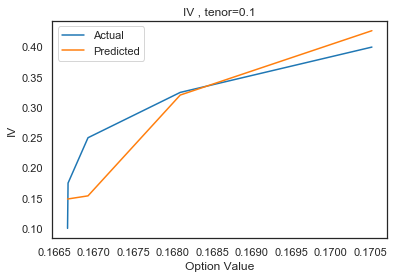

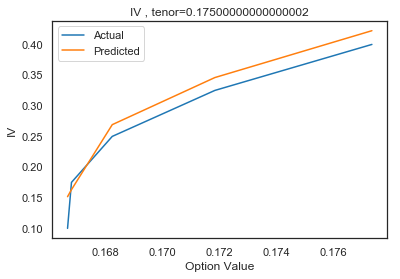

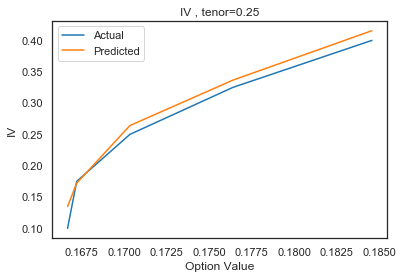

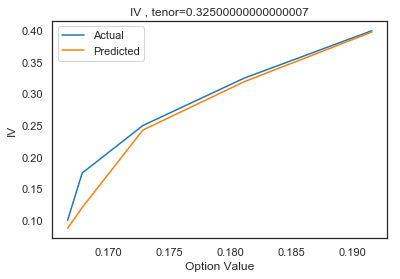

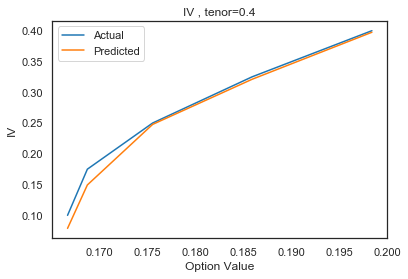

In [37]:
mat = np.linspace(0.1, 0.4, 5)
model = create_multy_model(layers, hidden_units, modelFile)
import seaborn as sns
sns.set_context('notebook')
sns.set_style('white')
for i in range(5):
    f, strike, t, vol = [1.2], [1], [mat[i]], np.linspace(0.1,0.4, 5)
    inputs = np.array(np.meshgrid(f, strike, t, vol)).T.reshape(-1, 4)
    
    prices = blackScholesPriceTrue(inputs[:, 0], inputs[:, 1], inputs[:, 2], inputs[:, 3])
    vols = inputs[:,[-1]].flatten()
    inputs[:, -1] = prices
    pred_vols = model.predict(inputs)
    plt.figure(i)
    plt.title("IV , tenor={}".format(vols[i]))
    plt.plot(prices, vols, label='Actual')
    plt.plot(prices, pred_vols, label='Predicted')
    plt.xlabel("Option Value")
    plt.ylabel("IV")
    plt.legend()


In [7]:
val_generator.__getitem__(0)[0]

array([[1.00000000e+00, 5.00000000e-01, 1.00000000e-01, 5.00000000e-01],
       [1.00000000e+00, 7.50000000e-01, 1.00000000e-01, 2.50000000e-01],
       [1.00000000e+00, 1.00000000e+00, 1.00000000e-01, 1.26156574e-03],
       ...,
       [1.50000000e+00, 1.00000000e+00, 1.00000000e+00, 3.80587562e-01],
       [1.50000000e+00, 1.25000000e+00, 1.00000000e+00, 2.75908118e-01],
       [1.50000000e+00, 1.50000000e+00, 1.00000000e+00, 1.97412651e-01]])